# Introduction
This open-source notebook was written for the qualitative analysis presented in Mack et al., *"What Do We Mean by 'Accessibility Research'? A Literature Survey of Accessibility Papers in CHI and ASSETS from 1994 to 2019"*, CHI'21. 

The Mack paper presents analyses for two paper datasets drawn from CHI and ASSETS:
1. A qualitative analysis of accessibility papers from 2010-2019 (*N=*506). The focus of this notebook.
2. A larger programmatic analysis of the last 26-years of accessibility papers (since the founding of ASSETS); *N=*836

This notebook is for the first point above and relates to Sections 3.1.1 and 3.2.1 and Sections 4.1, 4.2, and 4.3 of the Mack et al. paper. 

## Method
For this analysis, we first manually coded all accessibility papers at CHI and ASSETS from last decade. The manual coding captures research foci (*i.e.,* communities of focus, issues addressed, contribution types), methodological decisions (*e.g.,* study methods, sample sizes), and the roles of both disabled and nondisabled participants in accessibility studies. See Sections 3.1.1 and 3.2.1 of the Mack paper. 

We then iteratively wrote this analysis notebook and used Excel to address our research questions, including:
- **Who** does accessibility research focus on? 
- **What** are the stated goals, such as increasing digital accessibility or increasing independence for people with disabilities and older adults? 
- **What** research methods are used, including study design decisions such as sample size, study location, and whether participatory methods are used? 

## Links
The datasets and code, including this notebook, are on [GitHub here](https://github.com/makeabilitylab/accessibility-literature-survey).

## Acknowledgments
This notebook was written by [Professor Jon E. Froehlich](https://jonfroehlich.github.io/) with input from all team members, including Kelly Mack, Emma McDonnell, Dhruv Jain, Lucy Wang, and Leah Findlater.

# Imports

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

In [125]:
print("Checking environment... Please use 'QualitativeAnalysis_Environment.yml'")
print("We need at least Seaborn (sns) version 0.11.0 for plotting (using displot, etc.)")
print("Your Seaborn version:", sns.__version__)

Checking environment... Please use 'QualitativeAnalysis_Environment.yml'
We need at least Seaborn (sns) version 0.11.0 for plotting (using displot, etc.)
Your Seaborn version: 0.11.0


# Utility functions

In [126]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d',4,5,6,7,8,9,10,'1','2','3','4',',']

def plot_bar_graph_series(series, title=None, ylabel=None, xlabel=None):
    '''
    Plots a bar graph of the pandas series
    '''
    
    # create plot
    fig_height = max(len(series) * 0.5, 3)
    plt.figure(figsize=(12, fig_height))
    indices = np.arange(len(series))

    plt.grid(zorder=0)
    bars = plt.barh(indices, series.values, alpha=0.8, color='b', zorder=3)
    
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.yticks(indices, series.index)
    
    for i, v in enumerate(series.values):
        plt.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.tight_layout()
    xmin, xmax = plt.xlim() 
    plt.xlim(xmax = xmax * 1.1)
    
    plt.show()
    
def calc_sole_sub_code_applied_rates(df, code_cat, map_codes = None):
    '''
    Calculates the frequency with which each sub-code in the code category (code_cat) is solely applied.
    That is, that a count of how often the sub-code occurs by itself (and not with any other sub-code in this code_cat) 
    
    Returns a dictionary of (sub_code_col_names, freq_count)
    '''
    
    if map_codes is None:
        map_codes = map_codes_to_cols
    
    sub_code_cols = map_codes[code_cat]
    map_sole_sub_code_freq = dict()
    for i in range(len(sub_code_cols)):
        query_string = ""
        for j in range(len(sub_code_cols)):
            sub_code_col = sub_code_cols[j]

            cell_value = 0
            if i == j:
                cell_value = 1

            query_string += f"({sub_code_col} == {cell_value})"

            if j + 1 is not len(sub_code_cols):
                query_string += " & "

        # print(query_string)
        # print(len(df.query(query_string)))
        map_sole_sub_code_freq[sub_code_cols[i]] = len(df.query(query_string))
    return map_sole_sub_code_freq

# Read in data

## Define input filenames and directory locations

In [127]:
# Define the paths
num_of_papers_per_year_dir = "../datasets"
num_of_papers_per_year_filename = 'Dataset1_TotalPaperCountsPerYear_ASSETSandCHI_2010-2019.csv'
num_of_papers_per_year_full_path = os.path.join(num_of_papers_per_year_dir, num_of_papers_per_year_filename)

qual_analysis_dir = "../datasets"
# qual_analysis_filename = 'FinalCodeAnalysis_Standardized_v6.5_KNM.xlsx'
qual_analysis_filename = 'Dataset1_QualitativelyCodedData_ASSETSandCHI_2010-2019.csv'
qual_analysis_full_path = os.path.join(qual_analysis_dir, qual_analysis_filename)

print("**************************************************************")
print(f"Using the: {qual_analysis_filename} file")
print("**************************************************************")

**************************************************************
Using the: Dataset1_QualitativelyCodedData_ASSETSandCHI_2010-2019.csv file
**************************************************************


## Read in the data

In [128]:
# Read in the csv that tracks the number of CHI and ASSETS papers from 2010-2019
df_total_papers_per_year = pd.read_csv(num_of_papers_per_year_full_path)
df_total_papers_per_year.set_index('Year', inplace=True)
print(f"Read in `{num_of_papers_per_year_full_path}`")
print("The total number of ASSETS papers={} and CHI papers={}".format(
    df_total_papers_per_year.sum()['ASSETS'], df_total_papers_per_year.sum()['CHI']))
display(df_total_papers_per_year)


Read in `../datasets\Dataset1_TotalPaperCountsPerYear_ASSETSandCHI_2010-2019.csv`
The total number of ASSETS papers=291 and CHI papers=4938


ASSETS  CHI
Year             
2010      28  302
2011      27  409
2012      25  370
2013      27  392
2014      28  465
2015      30  486
2016      24  545
2017      33  600
2018      28  666
2019      41  703

In [129]:
# Read in the applied codes data sheet. Check if Excel or CSV (we were using Excel during paper writing)
if qual_analysis_full_path.endswith('.xlsx'):
    target_sheet_name = 'AppliedCodes'
    df = pd.read_excel(qual_analysis_full_path, target_sheet_name)
else:
    df = pd.read_csv(qual_analysis_full_path)

# Clean column names. Pandas doesn't like hyphens because it messes with its eval parser in the .query function
# See: https://stackoverflow.com/a/50747014/388117
# However, we are using hyphens in our column headers (doh). So, replace these with underscores 
df.columns = [i.replace('-', '_') for i in df.columns]

print(f"Read in {df.shape[0]} rows and {df.shape[1]} cols from '{qual_analysis_full_path}'")

# Drop columns prefixed by 'ListOfParticipants_' since we don't need to analyze them
# See: https://github.com/jonfroehlich/accesslitsurvey/issues/29
code_cols_list_of_participants = [col for col in df if 'ListOfParticipants_' in col]
if len(code_cols_list_of_participants) > 0:
    print(f"Dropping {len(code_cols_list_of_participants)} columns prefixed by 'ListOfParticipants_'")
    df.drop(code_cols_list_of_participants, axis=1, inplace=True)
    
# Drop column 'ComparesOnDisability_Notes' as it's not a binary code column
if 'ComparesOnDisability_Notes' in df:
    df.drop(['ComparesOnDisability_Notes'], axis=1, inplace=True)
    
# The CSV can sometimes have errant empty rows at the end. Drop these
df.dropna(subset=['Title'], inplace=True)

print(f"After cleaning, df has {df.shape[0]} rows and {df.shape[1]} cols")

df.head()

Read in 506 rows and 71 cols from '../datasets\Dataset1_QualitativelyCodedData_ASSETSandCHI_2010-2019.csv'
After cleaning, df has 506 rows and 71 cols


Index                                             Author  \
0      1                     Giovanni Fusco, Valerie Morash   
1      2  Megan Hofmann and Kristin Williams and Toni Ka...   
2      3  Jessica Tran, Joy Kim, Jaehong Chon, Eve Riski...   
3      4                                    Timo Götzelmann   
4      5  Sooyeon Lee and Bjorn Hubert-Wallander and Mol...   

                                               Title  \
0  The Tactile Graphics Helper Providing Audio Cl...   
1  "Occupational Therapy is Making": Clinical Rap...   
2  Evaluating quality and comprehension of real-t...   
3  LucentMaps 3D Printed Audiovisual Tactile Maps...   
4  Understanding and Designing for Deaf or Hard o...   

                                             Keyword                      DOI  \
0  assistive devices, case study, finger tracking...  10.1145/2700648.2809868   
1  3d printing, adaptive design, digital fabricat...  10.1145/3290605.3300544   
2  american sign language, bitrate, deaf communit...  10.1145/2049536.2049558   
3  3d printing, accessibility, audio-tactile, bli...  10.1145/2982142.2982163   
4  accessibility, communication, deaf or hard of ...  10.1145/3290605.3300759   

    Venue  Year  CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
0  ASSETS  2015                     1                     0   
1     CHI  2019                     0                     0   
2  ASSETS  2011                     0                     1   
3  ASSETS  2016                     1                     0   
4     CHI  2019                     0                     1   

   CommunityOfFocus_IDD  ...  NumParticipants_Group1_Count  \
0                     0  ...                             2   
1                     0  ...                             4   
2                     0  ...                            39   
3                     0  ...                             9   
4                     0  ...                             5   

   NumParticipants_Group1_Population  NumParticipants_Group2_Count  \
0                        Specialists                             3   
1                        Specialists                             0   
2                        NonDisabled                            56   
3                                BVI                             0   
4                                DHH                             0   

   NumParticipants_Group2_Population  NumParticipants_Group3_Count  \
0                                BVI                             0   
1                                  0                             0   
2                      Other-Signers                             0   
3                                  0                             0   
4                                  0                             0   

   NumParticipants_Group3_Population  NumParticipants_Group4_Count  \
0                                  0                             0   
1                                  0                             0   
2                                  0                             0   
3                                  0                             0   
4                                  0                             0   

   NumParticipants_Group4_Population  NumParticipants_Group5_Count  \
0                                  0                             0   
1                                  0                             0   
2                                  0                             0   
3                                  0                             0   
4                                  0                             0   

   NumParticipants_Group5_Population  
0                                  0  
1                                  0  
2                                  0  
3                                  0  
4                                  0  

[5 rows x 71 columns]

In [130]:
# Parse and print out code information
code_separator = '_'
code_cols = [col for col in df if code_separator in col]
map_codes = dict(); # maps code categories to sub-codes
map_codes_to_cols = dict()
for full_code in code_cols:
    # Some sub-codes have been sub-coded! We will ignore these for now
    # We identify a sub-code of a sub-code by looking at the number of
    # hypens. So, for example, `TargetPopulation-Other-Description` is a
    # sub-code of a sub-code (`Description` is a sub-code of `TargetPopulation-Other`)
    # 
    # We have one exception, which is the 'NumParticipants_Group' columns,
    # which look like `NumParticipants_Group1_Count` and `NumParticipants_Group1_Population`
    if full_code.count(code_separator) > 1 and not full_code.startswith('NumParticipants'):
        print(f"Ignoring {full_code} because it's a sub-code of a sub-code")
    else:
        # Split
        tokens = full_code.split(code_separator)
        code_category = tokens[0]
        sub_code = tokens[1]
        
        # NumParticipant columns are a special case
        if full_code.startswith('NumParticipants') and len(tokens) > 2:
            # This will correctly parse NumParticipants_Group1_Count and
            # NumParticipants_Group1_Population, for example
            sub_code = sub_code + code_separator + tokens[2]
        
        if code_category not in map_codes:
            map_codes[code_category] = list()
            map_codes_to_cols[code_category] = list()
            
        map_codes[code_category].append(sub_code)
        map_codes_to_cols[code_category].append(full_code)
        
# Print out details about the codes
print("\n-------------\n")
print(f"Found {len(map_codes)} code categories")

# Make into a dataframe to "pretty print" the code categories & sub-codes
df_codes = pd.DataFrame.from_dict(map_codes, orient='index') # https://stackoverflow.com/a/25217425/388117
df_codes = df_codes.transpose()
df_codes = df_codes.replace([None], ['']) # just replace None with '' to make the table cleaner
display(df_codes)

Ignoring ParticipantGroup_Other_Notes because it's a sub-code of a sub-code
Ignoring ParticipantGroup_Other_Crowdworker because it's a sub-code of a sub-code

-------------

Found 10 code categories


CommunityOfFocus                             IssueAddressed  \
0                BVI                      IncreaseDigitalAccess   
1                DHH                     IncreasePhysicalAccess   
2                IDD                       IncreaseIndependence   
3      MotorPhysical               IncreaseUnderstandingOfUsers   
4             Autism  HelpWithPersonalInformaticsBehaviorChange   
5          Cognitive                       SupportCommunication   
6         OlderAdult                                      Other   
7  GeneralDisability                                              
8              Other                                              
9                                                                 

     ContributionType           StudyMethod         ParticipantGroup  \
0           Empirical  ControlledExperiment               OlderAdult   
1            Artifact          SurveyMethod     PeopleWithDisability   
2      Methodological      UsabilityTesting  PeopleWithoutDisability   
3         Theoretical            Interviews    TherapistsSpecialists   
4             Dataset             CaseStudy               Caregivers   
5  SurveyContribution           FocusGroups                    Other   
6                                FieldStudy              NoUserStudy   
7                            WorkshopDesign                            
8                                     Other                            
9                                                                      

               StudyLocation ParticipatoryDesign ComparesOnDisability  \
0                  NearAtLab                 Yes                  Yes   
1  ParticipantsHomeOrFreqLoc                  No                   No   
2            NeutralLocation                                            
3                    Unclear                                            
4             OnlineRemotely                                            
5                      Other                                            
6                NoUserStudy                                            
7                                                                       
8                                                                       
9                                                                       

  UsesProxies    NumParticipants  
0         Yes       Group1_Count  
1          No  Group1_Population  
2                   Group2_Count  
3              Group2_Population  
4                   Group3_Count  
5              Group3_Population  
6                   Group4_Count  
7              Group4_Population  
8                   Group5_Count  
9              Group5_Population

In [131]:
print("Num papers by venue:")
df.groupby("Venue")["Venue"].count()

Num papers by venue:


Venue
ASSETS    291
CHI       215
Name: Venue, dtype: int64

# Summarizing the data

In [132]:
# Quick summaries
print(f"Total number of papers analyzed in our qualitative set: {len(df)}")
num_assets_papers = df.groupby('Venue')['Venue'].count()['ASSETS']
num_chi_papers = df.groupby('Venue')['Venue'].count()['CHI']
print(f"  Num of ASSETS papers: {num_assets_papers} of {len(df)} ({num_assets_papers/len(df)*100:.2f}%)")
print(f"  Num of CHI papers: {num_chi_papers} of {len(df)} ({num_chi_papers/len(df)*100:.2f}%)")
print()

df_no_user_study = df[df['ParticipantGroup_NoUserStudy'] == 1]
df_with_user_study = df[df['ParticipantGroup_NoUserStudy'] == 0]
num_papers_with_user_study = len(df) - len(df_no_user_study)
print(f"Num papers with a user study: {num_papers_with_user_study} of {len(df)} ({num_papers_with_user_study/len(df)*100:.2f}%)")


Total number of papers analyzed in our qualitative set: 506
  Num of ASSETS papers: 291 of 506 (57.51%)
  Num of CHI papers: 215 of 506 (42.49%)

Num papers with a user study: 477 of 506 (94.27%)


## Utility functions

In [133]:
def calc_code_coverage_across_papers(df_code_coverage):
    '''Calculates the code usage across papers for the given dataframe'''
    # Go through each category and print out table with counts, percentages, and a bar graph
    total_fraction_of_all_papers_label = f"Total Fraction of Papers (N={(len(df_code_coverage))})"
    for code_cat, sub_codes in map_codes.items():

        if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
            continue # skip these categories

        col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
        df_code_table = pd.DataFrame(index=col_names)
        df_code_table[code_cat] = sub_codes

        print(f"\n\n******************************* {code_cat} *******************************\n")
        df_code_table['Num Papers with Code'] = df_code_coverage[col_names].sum()
        df_code_table[total_fraction_of_all_papers_label] = df_code_coverage[col_names].sum() / len(df_code_coverage)
        df_code_table = df_code_table.sort_values(by=[total_fraction_of_all_papers_label], ascending=False)

        df_code_table[f'% of Papers (N={len(df_code_coverage)})'] =\
            pd.Series(["{0:.1f}%".format(val/len(df_code_coverage) * 100) for val in df_code_table['Num Papers with Code']], index = df_code_table.index)

        query = ""
        cumulative_coverage_fraction = 0
        row_index = 0
        total_papers_covered = []
        for index, row in df_code_table.iterrows(): 
            if row_index != 0:
                query += " | "
            query += f'({index} == 1)'
            query_result = df_code_coverage.query(query)
            total_papers_covered.append(len(query_result))
            row_index += 1

        df_code_table['Total Papers Covered'] = total_papers_covered
        df_code_table[f'% of Papers (N={len(df_code_coverage)}) Covered'] = \
            pd.Series(["{0:.1f}%".format(val/len(df_code_coverage) * 100) for val in df_code_table['Total Papers Covered']], index = df_code_table.index)

        df_code_table = df_code_table.drop(total_fraction_of_all_papers_label, axis=1)

        display(df_code_table)

## All Papers

### Frequency of sub-code use across all papers
Examines how often a particular sub-code was used for each code category.



******************************* CommunityOfFocus *******************************

Fraction of all papers (N=506) with sub-code:

CommunityOfFocus_BVI                  0.434783
CommunityOfFocus_MotorPhysical        0.142292
CommunityOfFocus_DHH                  0.112648
CommunityOfFocus_Other                0.090909
CommunityOfFocus_GeneralDisability    0.090909
CommunityOfFocus_Cognitive            0.090909
CommunityOfFocus_OlderAdult           0.088933
CommunityOfFocus_Autism               0.061265
CommunityOfFocus_IDD                  0.027668
Name: Total Fraction of All Papers (N=506), dtype: float64


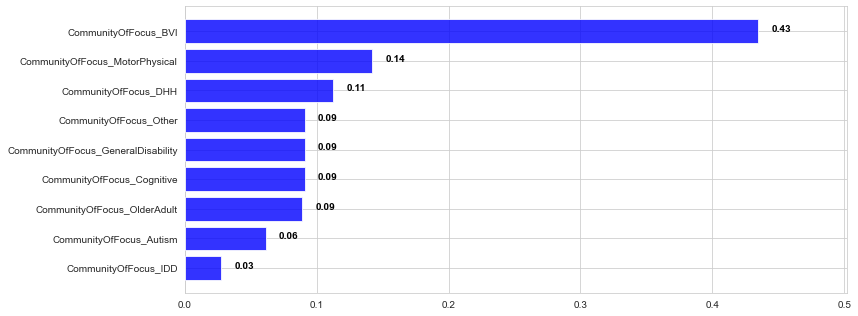

CommunityOfFocus  Num Papers with Code  \
CommunityOfFocus_BVI                              BVI                   220   
CommunityOfFocus_MotorPhysical          MotorPhysical                    72   
CommunityOfFocus_DHH                              DHH                    57   
CommunityOfFocus_Cognitive                  Cognitive                    46   
CommunityOfFocus_GeneralDisability  GeneralDisability                    46   
CommunityOfFocus_Other                          Other                    46   
CommunityOfFocus_OlderAdult                OlderAdult                    45   
CommunityOfFocus_Autism                        Autism                    31   
CommunityOfFocus_IDD                              IDD                    14   

                                    Total Fraction of All Papers (N=506)  \
CommunityOfFocus_BVI                                            0.434783   
CommunityOfFocus_MotorPhysical                                  0.142292   
CommunityOfFocus_DHH                                            0.112648   
CommunityOfFocus_Cognitive                                      0.090909   
CommunityOfFocus_GeneralDisability                              0.090909   
CommunityOfFocus_Other                                          0.090909   
CommunityOfFocus_OlderAdult                                     0.088933   
CommunityOfFocus_Autism                                         0.061265   
CommunityOfFocus_IDD                                            0.027668   

                                    Num Papers with this Code Only  \
CommunityOfFocus_BVI                                           208   
CommunityOfFocus_MotorPhysical                                  59   
CommunityOfFocus_DHH                                            43   
CommunityOfFocus_Cognitive                                      29   
CommunityOfFocus_GeneralDisability                              31   
CommunityOfFocus_Other                                          20   
CommunityOfFocus_OlderAdult                                     29   
CommunityOfFocus_Autism                                         21   
CommunityOfFocus_IDD                                             8   

                                    Num Papers with this Code Only (Fraction of Applied Code)  \
CommunityOfFocus_BVI                                                         0.945455           
CommunityOfFocus_MotorPhysical                                               0.819444           
CommunityOfFocus_DHH                                                         0.754386           
CommunityOfFocus_Cognitive                                                   0.630435           
CommunityOfFocus_GeneralDisability                                           0.673913           
CommunityOfFocus_Other                                                       0.434783           
CommunityOfFocus_OlderAdult                                                  0.644444           
CommunityOfFocus_Autism                                                      0.677419           
CommunityOfFocus_IDD                                                         0.571429           

                                    Num Papers with this Code Only (Fraction of Total Papers; N=506)  
CommunityOfFocus_BVI                                                         0.411067                 
CommunityOfFocus_MotorPhysical                                               0.116601                 
CommunityOfFocus_DHH                                                         0.084980                 
CommunityOfFocus_Cognitive                                                   0.057312                 
CommunityOfFocus_GeneralDisability                                           0.061265                 
CommunityOfFocus_Other                                                       0.039526                 
CommunityOfFocus_OlderAdult                                                  0.057312       

Table for paper:


CommunityOfFocus  Num Papers with Code  \
CommunityOfFocus_BVI                              BVI                   220   
CommunityOfFocus_MotorPhysical          MotorPhysical                    72   
CommunityOfFocus_DHH                              DHH                    57   
CommunityOfFocus_Cognitive                  Cognitive                    46   
CommunityOfFocus_GeneralDisability  GeneralDisability                    46   
CommunityOfFocus_Other                          Other                    46   
CommunityOfFocus_OlderAdult                OlderAdult                    45   
CommunityOfFocus_Autism                        Autism                    31   
CommunityOfFocus_IDD                              IDD                    14   

                                   % of Papers (N=506) with Code  \
CommunityOfFocus_BVI                                       43.5%   
CommunityOfFocus_MotorPhysical                             14.2%   
CommunityOfFocus_DHH                                       11.3%   
CommunityOfFocus_Cognitive                                  9.1%   
CommunityOfFocus_GeneralDisability                          9.1%   
CommunityOfFocus_Other                                      9.1%   
CommunityOfFocus_OlderAdult                                 8.9%   
CommunityOfFocus_Autism                                     6.1%   
CommunityOfFocus_IDD                                        2.8%   

                                    Num Papers with this Code Only  \
CommunityOfFocus_BVI                                           208   
CommunityOfFocus_MotorPhysical                                  59   
CommunityOfFocus_DHH                                            43   
CommunityOfFocus_Cognitive                                      29   
CommunityOfFocus_GeneralDisability                              31   
CommunityOfFocus_Other                                          20   
CommunityOfFocus_OlderAdult                                     29   
CommunityOfFocus_Autism                                         21   
CommunityOfFocus_IDD                                             8   

                                   % of Papers (N=506) with this Code Only  
CommunityOfFocus_BVI                                                 41.1%  
CommunityOfFocus_MotorPhysical                                       11.7%  
CommunityOfFocus_DHH                                                  8.5%  
CommunityOfFocus_Cognitive                                            5.7%  
CommunityOfFocus_GeneralDisability                                    6.1%  
CommunityOfFocus_Other                                                4.0%  
CommunityOfFocus_OlderAdult                                           5.7%  
CommunityOfFocus_Autism                                               4.2%  
CommunityOfFocus_IDD                                                  1.6%



******************************* IssueAddressed *******************************

Fraction of all papers (N=506) with sub-code:

IssueAddressed_IncreaseDigitalAccess                        0.367589
IssueAddressed_IncreaseUnderstandingOfUsers                 0.274704
IssueAddressed_IncreasePhysicalAccess                       0.207510
IssueAddressed_IncreaseIndependence                         0.183794
IssueAddressed_SupportCommunication                         0.160079
IssueAddressed_Other                                        0.116601
IssueAddressed_HelpWithPersonalInformaticsBehaviorChange    0.077075
Name: Total Fraction of All Papers (N=506), dtype: float64


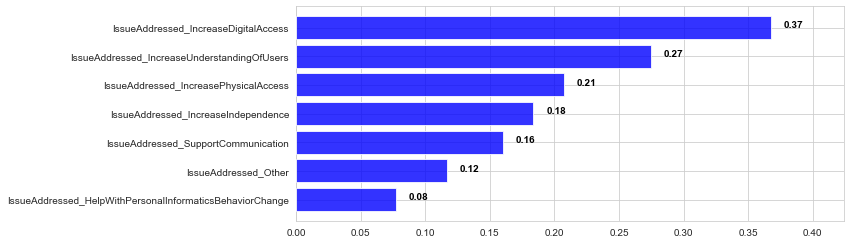

IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                 186   
IssueAddressed_IncreaseUnderstandingOfUsers                          139   
IssueAddressed_IncreasePhysicalAccess                                105   
IssueAddressed_IncreaseIndependence                                   93   
IssueAddressed_SupportCommunication                                   81   
IssueAddressed_Other                                                  59   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    39   

                                                    Total Fraction of All Papers (N=506)  \
IssueAddressed_IncreaseDigitalAccess                                            0.367589   
IssueAddressed_IncreaseUnderstandingOfUsers                                     0.274704   
IssueAddressed_IncreasePhysicalAccess                                           0.207510   
IssueAddressed_IncreaseIndependence                                             0.183794   
IssueAddressed_SupportCommunication                                             0.160079   
IssueAddressed_Other                                                            0.116601   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              0.077075   

                                                    Num Papers with this Code Only  \
IssueAddressed_IncreaseDigitalAccess                                           122   
IssueAddressed_IncreaseUnderstandingOfUsers                                     89   
IssueAddressed_IncreasePhysicalAccess                                           26   
IssueAddressed_IncreaseIndependence                                             14   
IssueAddressed_SupportCommunication                                             45   
IssueAddressed_Other                                                            25   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              19   

                                                    Num Papers with this Code Only (Fraction of Applied Code)  \
IssueAddressed_IncreaseDigitalAccess                                                         0.655914           
IssueAddressed_IncreaseUnderstandingOfUsers                                                  0.640288           
IssueAddressed_IncreasePhysicalAccess                                                        0.247619           
IssueAddressed_IncreaseIndependence                                                          0.150538           
IssueAddressed_SupportCommunication                                                          0.555556           
IssueAddressed_Other                                                                         0.423729           
IssueAddressed_HelpWithPersonalInformaticsBehav...                                           0.487179           

                                                    Num Papers with this Code Only (Fraction of Total Papers; N=506)  
IssueAddressed_IncreaseDigitalAccess                                                         0.241107                 
IssueAddressed_IncreaseUnderstandingOfUsers                                                  0.175889                 
Issue

Table for paper:


IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                 186   
IssueAddressed_IncreaseUnderstandingOfUsers                          139   
IssueAddressed_IncreasePhysicalAccess                                105   
IssueAddressed_IncreaseIndependence                                   93   
IssueAddressed_SupportCommunication                                   81   
IssueAddressed_Other                                                  59   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    39   

                                                   % of Papers (N=506) with Code  \
IssueAddressed_IncreaseDigitalAccess                                       36.8%   
IssueAddressed_IncreaseUnderstandingOfUsers                                27.5%   
IssueAddressed_IncreasePhysicalAccess                                      20.8%   
IssueAddressed_IncreaseIndependence                                        18.4%   
IssueAddressed_SupportCommunication                                        16.0%   
IssueAddressed_Other                                                       11.7%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                          7.7%   

                                                    Num Papers with this Code Only  \
IssueAddressed_IncreaseDigitalAccess                                           122   
IssueAddressed_IncreaseUnderstandingOfUsers                                     89   
IssueAddressed_IncreasePhysicalAccess                                           26   
IssueAddressed_IncreaseIndependence                                             14   
IssueAddressed_SupportCommunication                                             45   
IssueAddressed_Other                                                            25   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              19   

                                                   % of Papers (N=506) with this Code Only  
IssueAddressed_IncreaseDigitalAccess                                                 24.1%  
IssueAddressed_IncreaseUnderstandingOfUsers                                          17.6%  
IssueAddressed_IncreasePhysicalAccess                                                 5.1%  
IssueAddressed_IncreaseIndependence                                                   2.8%  
IssueAddressed_SupportCommunication                                                   8.9%  
IssueAddressed_Other                                                                  4.9%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                                    3.8%



******************************* ContributionType *******************************

Fraction of all papers (N=506) with sub-code:

ContributionType_Empirical             0.602767
ContributionType_Artifact              0.555336
ContributionType_Theoretical           0.086957
ContributionType_Methodological        0.031621
ContributionType_Dataset               0.013834
ContributionType_SurveyContribution    0.005929
Name: Total Fraction of All Papers (N=506), dtype: float64


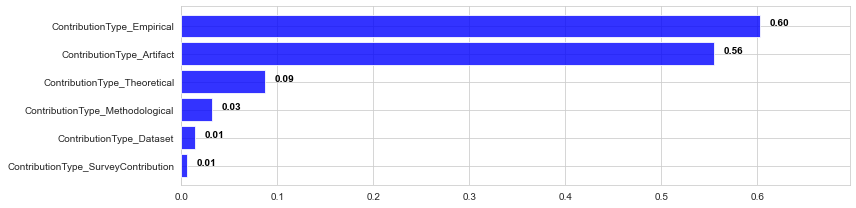

ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                   305   
ContributionType_Artifact                      Artifact                   281   
ContributionType_Theoretical                Theoretical                    44   
ContributionType_Methodological          Methodological                    16   
ContributionType_Dataset                        Dataset                     7   
ContributionType_SurveyContribution  SurveyContribution                     3   

                                     Total Fraction of All Papers (N=506)  \
ContributionType_Empirical                                       0.602767   
ContributionType_Artifact                                        0.555336   
ContributionType_Theoretical                                     0.086957   
ContributionType_Methodological                                  0.031621   
ContributionType_Dataset                                         0.013834   
ContributionType_SurveyContribution                              0.005929   

                                     Num Papers with this Code Only  \
ContributionType_Empirical                                      171   
ContributionType_Artifact                                       182   
ContributionType_Theoretical                                      6   
ContributionType_Methodological                                   2   
ContributionType_Dataset                                          2   
ContributionType_SurveyContribution                               0   

                                     Num Papers with this Code Only (Fraction of Applied Code)  \
ContributionType_Empirical                                                    0.560656           
ContributionType_Artifact                                                     0.647687           
ContributionType_Theoretical                                                  0.136364           
ContributionType_Methodological                                               0.125000           
ContributionType_Dataset                                                      0.285714           
ContributionType_SurveyContribution                                           0.000000           

                                     Num Papers with this Code Only (Fraction of Total Papers; N=506)  
ContributionType_Empirical                                                    0.337945                 
ContributionType_Artifact                                                     0.359684                 
ContributionType_Theoretical                                                  0.011858                 
ContributionType_Methodological                                               0.003953                 
ContributionType_Dataset                                                      0.003953                 
ContributionType_SurveyContribution                                           0.000000

Table for paper:


ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                   305   
ContributionType_Artifact                      Artifact                   281   
ContributionType_Theoretical                Theoretical                    44   
ContributionType_Methodological          Methodological                    16   
ContributionType_Dataset                        Dataset                     7   
ContributionType_SurveyContribution  SurveyContribution                     3   

                                    % of Papers (N=506) with Code  \
ContributionType_Empirical                                  60.3%   
ContributionType_Artifact                                   55.5%   
ContributionType_Theoretical                                 8.7%   
ContributionType_Methodological                              3.2%   
ContributionType_Dataset                                     1.4%   
ContributionType_SurveyContribution                          0.6%   

                                     Num Papers with this Code Only  \
ContributionType_Empirical                                      171   
ContributionType_Artifact                                       182   
ContributionType_Theoretical                                      6   
ContributionType_Methodological                                   2   
ContributionType_Dataset                                          2   
ContributionType_SurveyContribution                               0   

                                    % of Papers (N=506) with this Code Only  
ContributionType_Empirical                                            33.8%  
ContributionType_Artifact                                             36.0%  
ContributionType_Theoretical                                           1.2%  
ContributionType_Methodological                                        0.4%  
ContributionType_Dataset                                               0.4%  
ContributionType_SurveyContribution                                    0.0%



******************************* StudyMethod *******************************

Fraction of all papers (N=506) with sub-code:

StudyMethod_Interviews              0.397233
StudyMethod_UsabilityTesting        0.393281
StudyMethod_ControlledExperiment    0.330040
StudyMethod_SurveyMethod            0.241107
StudyMethod_Other                   0.195652
StudyMethod_WorkshopDesign          0.173913
StudyMethod_FieldStudy              0.167984
StudyMethod_FocusGroups             0.055336
StudyMethod_CaseStudy               0.049407
Name: Total Fraction of All Papers (N=506), dtype: float64


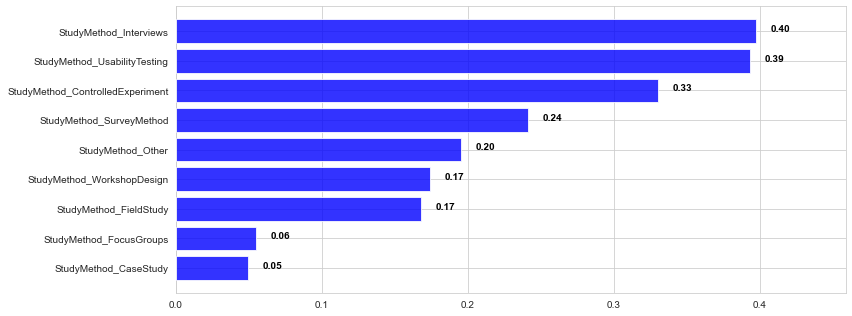

StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                   201   
StudyMethod_UsabilityTesting          UsabilityTesting                   199   
StudyMethod_ControlledExperiment  ControlledExperiment                   167   
StudyMethod_SurveyMethod                  SurveyMethod                   122   
StudyMethod_Other                                Other                    99   
StudyMethod_WorkshopDesign              WorkshopDesign                    88   
StudyMethod_FieldStudy                      FieldStudy                    85   
StudyMethod_FocusGroups                    FocusGroups                    28   
StudyMethod_CaseStudy                        CaseStudy                    25   

                                  Total Fraction of All Papers (N=506)  \
StudyMethod_Interviews                                        0.397233   
StudyMethod_UsabilityTesting                                  0.393281   
StudyMethod_ControlledExperiment                              0.330040   
StudyMethod_SurveyMethod                                      0.241107   
StudyMethod_Other                                             0.195652   
StudyMethod_WorkshopDesign                                    0.173913   
StudyMethod_FieldStudy                                        0.167984   
StudyMethod_FocusGroups                                       0.055336   
StudyMethod_CaseStudy                                         0.049407   

                                  Num Papers with this Code Only  \
StudyMethod_Interviews                                        27   
StudyMethod_UsabilityTesting                                  46   
StudyMethod_ControlledExperiment                              57   
StudyMethod_SurveyMethod                                       6   
StudyMethod_Other                                             25   
StudyMethod_WorkshopDesign                                    15   
StudyMethod_FieldStudy                                        22   
StudyMethod_FocusGroups                                        4   
StudyMethod_CaseStudy                                          6   

                                  Num Papers with this Code Only (Fraction of Applied Code)  \
StudyMethod_Interviews                                                     0.134328           
StudyMethod_UsabilityTesting                                               0.231156           
StudyMethod_ControlledExperiment                                           0.341317           
StudyMethod_SurveyMethod                                                   0.049180           
StudyMethod_Other                                                          0.252525           
StudyMethod_WorkshopDesign                                                 0.170455           
StudyMethod_FieldStudy                                                     0.258824           
StudyMethod_FocusGroups                                                    0.142857           
StudyMethod_CaseStudy                                                      0.240000           

                                  Num Papers with this Code Only (Fraction of Total Papers; N=506)  
StudyMethod_Interviews                                                     0.053360                 
StudyMethod_UsabilityTesting                                               0.090909                 
StudyMethod_ControlledExperiment                                           0.112648                 
StudyMethod_SurveyMethod                                                   0.011858                 
StudyMethod_Other                                                          0.049407                 
StudyMethod_WorkshopDesign                                                 0.029644                 
StudyMethod_FieldStudy                                                     0.043478                 
StudyMethod_FocusGroups                                      

Table for paper:


StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                   201   
StudyMethod_UsabilityTesting          UsabilityTesting                   199   
StudyMethod_ControlledExperiment  ControlledExperiment                   167   
StudyMethod_SurveyMethod                  SurveyMethod                   122   
StudyMethod_Other                                Other                    99   
StudyMethod_WorkshopDesign              WorkshopDesign                    88   
StudyMethod_FieldStudy                      FieldStudy                    85   
StudyMethod_FocusGroups                    FocusGroups                    28   
StudyMethod_CaseStudy                        CaseStudy                    25   

                                 % of Papers (N=506) with Code  \
StudyMethod_Interviews                                   39.7%   
StudyMethod_UsabilityTesting                             39.3%   
StudyMethod_ControlledExperiment                         33.0%   
StudyMethod_SurveyMethod                                 24.1%   
StudyMethod_Other                                        19.6%   
StudyMethod_WorkshopDesign                               17.4%   
StudyMethod_FieldStudy                                   16.8%   
StudyMethod_FocusGroups                                   5.5%   
StudyMethod_CaseStudy                                     4.9%   

                                  Num Papers with this Code Only  \
StudyMethod_Interviews                                        27   
StudyMethod_UsabilityTesting                                  46   
StudyMethod_ControlledExperiment                              57   
StudyMethod_SurveyMethod                                       6   
StudyMethod_Other                                             25   
StudyMethod_WorkshopDesign                                    15   
StudyMethod_FieldStudy                                        22   
StudyMethod_FocusGroups                                        4   
StudyMethod_CaseStudy                                          6   

                                 % of Papers (N=506) with this Code Only  
StudyMethod_Interviews                                              5.3%  
StudyMethod_UsabilityTesting                                        9.1%  
StudyMethod_ControlledExperiment                                   11.3%  
StudyMethod_SurveyMethod                                            1.2%  
StudyMethod_Other                                                   4.9%  
StudyMethod_WorkshopDesign                                          3.0%  
StudyMethod_FieldStudy                                              4.3%  
StudyMethod_FocusGroups                                             0.8%  
StudyMethod_CaseStudy                                               1.2%



******************************* ParticipantGroup *******************************

Fraction of all papers (N=506) with sub-code:

ParticipantGroup_PeopleWithDisability       0.798419
ParticipantGroup_PeopleWithoutDisability    0.217391
ParticipantGroup_TherapistsSpecialists      0.160079
ParticipantGroup_Other                      0.104743
ParticipantGroup_Caregivers                 0.088933
ParticipantGroup_OlderAdult                 0.079051
ParticipantGroup_NoUserStudy                0.057312
Name: Total Fraction of All Papers (N=506), dtype: float64


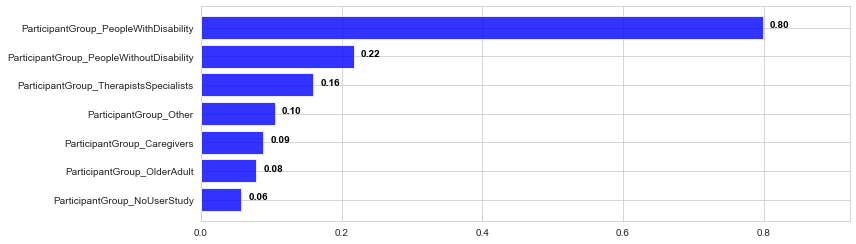

ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   110   
ParticipantGroup_TherapistsSpecialists                      81   
ParticipantGroup_Other                                      53   
ParticipantGroup_Caregivers                                 45   
ParticipantGroup_OlderAdult                                 40   
ParticipantGroup_NoUserStudy                                29   

                                          Total Fraction of All Papers (N=506)  \
ParticipantGroup_PeopleWithDisability                                 0.798419   
ParticipantGroup_PeopleWithoutDisability                              0.217391   
ParticipantGroup_TherapistsSpecialists                                0.160079   
ParticipantGroup_Other                                                0.104743   
ParticipantGroup_Caregivers                                           0.088933   
ParticipantGroup_OlderAdult                                           0.079051   
ParticipantGroup_NoUserStudy                                          0.057312   

                                          Num Papers with this Code Only  \
ParticipantGroup_PeopleWithDisability                                214   
ParticipantGroup_PeopleWithoutDisability                               5   
ParticipantGroup_TherapistsSpecialists                                 9   
ParticipantGroup_Other                                                23   
ParticipantGroup_Caregivers                                            4   
ParticipantGroup_OlderAdult                                           15   
ParticipantGroup_NoUserStudy                                          29   

                                          Num Papers with this Code Only (Fraction of Applied Code)  \
ParticipantGroup_PeopleWithDisability                                              0.529703           
ParticipantGroup_PeopleWithoutDisability                                           0.045455           
ParticipantGroup_TherapistsSpecialists                                             0.111111           
ParticipantGroup_Other                                                             0.433962           
ParticipantGroup_Caregivers                                                        0.088889           
ParticipantGroup_OlderAdult                                                        0.375000           
ParticipantGroup_NoUserStudy                                                       1.000000           

                                          Num Papers with this Code Only (Fraction of Total Papers; N=506)  
ParticipantGroup_PeopleWithDisability                                              0.422925                 
ParticipantGroup_PeopleWithoutDisability                                           0.009881                 
ParticipantGroup_TherapistsSpecialists                                             0.017787                 
ParticipantGroup_Other                                                             0.045455                 
ParticipantGroup_Caregivers                                                        0.007905                 
ParticipantGroup_OlderAdult                                                        0.029644                 
ParticipantGroup_NoUserStudy                                                       0.057312

Table for paper:


ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   110   
ParticipantGroup_TherapistsSpecialists                      81   
ParticipantGroup_Other                                      53   
ParticipantGroup_Caregivers                                 45   
ParticipantGroup_OlderAdult                                 40   
ParticipantGroup_NoUserStudy                                29   

                                         % of Papers (N=506) with Code  \
ParticipantGroup_PeopleWithDisability                            79.8%   
ParticipantGroup_PeopleWithoutDisability                         21.7%   
ParticipantGroup_TherapistsSpecialists                           16.0%   
ParticipantGroup_Other                                           10.5%   
ParticipantGroup_Caregivers                                       8.9%   
ParticipantGroup_OlderAdult                                       7.9%   
ParticipantGroup_NoUserStudy                                      5.7%   

                                          Num Papers with this Code Only  \
ParticipantGroup_PeopleWithDisability                                214   
ParticipantGroup_PeopleWithoutDisability                               5   
ParticipantGroup_TherapistsSpecialists                                 9   
ParticipantGroup_Other                                                23   
ParticipantGroup_Caregivers                                            4   
ParticipantGroup_OlderAdult                                           15   
ParticipantGroup_NoUserStudy                                          29   

                                         % of Papers (N=506) with this Code Only  
ParticipantGroup_PeopleWithDisability                                      42.3%  
ParticipantGroup_PeopleWithoutDisability                                    1.0%  
ParticipantGroup_TherapistsSpecialists                                      1.8%  
ParticipantGroup_Other                                                      4.5%  
ParticipantGroup_Caregivers                                                 0.8%  
ParticipantGroup_OlderAdult                                                 3.0%  
ParticipantGroup_NoUserStudy                                                5.7%



******************************* StudyLocation *******************************

Fraction of all papers (N=506) with sub-code:

StudyLocation_Unclear                      0.373518
StudyLocation_ParticipantsHomeOrFreqLoc    0.272727
StudyLocation_NearAtLab                    0.256917
StudyLocation_OnlineRemotely               0.193676
StudyLocation_NeutralLocation              0.063241
StudyLocation_NoUserStudy                  0.057312
StudyLocation_Other                        0.013834
Name: Total Fraction of All Papers (N=506), dtype: float64


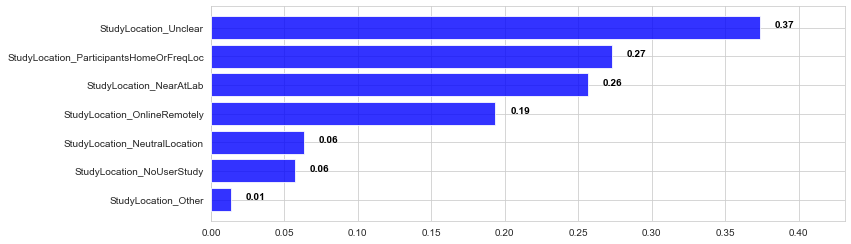

StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   
StudyLocation_Other                                          Other   

                                         Num Papers with Code  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   138   
StudyLocation_NearAtLab                                   130   
StudyLocation_OnlineRemotely                               98   
StudyLocation_NeutralLocation                              32   
StudyLocation_NoUserStudy                                  29   
StudyLocation_Other                                         7   

                                         Total Fraction of All Papers (N=506)  \
StudyLocation_Unclear                                                0.373518   
StudyLocation_ParticipantsHomeOrFreqLoc                              0.272727   
StudyLocation_NearAtLab                                              0.256917   
StudyLocation_OnlineRemotely                                         0.193676   
StudyLocation_NeutralLocation                                        0.063241   
StudyLocation_NoUserStudy                                            0.057312   
StudyLocation_Other                                                  0.013834   

                                         Num Papers with this Code Only  \
StudyLocation_Unclear                                               133   
StudyLocation_ParticipantsHomeOrFreqLoc                              85   
StudyLocation_NearAtLab                                              93   
StudyLocation_OnlineRemotely                                         48   
StudyLocation_NeutralLocation                                        15   
StudyLocation_NoUserStudy                                            29   
StudyLocation_Other                                                   1   

                                         Num Papers with this Code Only (Fraction of Applied Code)  \
StudyLocation_Unclear                                                             0.703704           
StudyLocation_ParticipantsHomeOrFreqLoc                                           0.615942           
StudyLocation_NearAtLab                                                           0.715385           
StudyLocation_OnlineRemotely                                                      0.489796           
StudyLocation_NeutralLocation                                                     0.468750           
StudyLocation_NoUserStudy                                                         1.000000           
StudyLocation_Other                                                               0.142857           

                                         Num Papers with this Code Only (Fraction of Total Papers; N=506)  
StudyLocation_Unclear                                                             0.262846                 
StudyLocation_ParticipantsHomeOrFreqLoc                                           0.167984                 
StudyLocation_NearAtLab                                                           0.183794                 
StudyLocation_OnlineRemotely                                                      0.094862                 
StudyLocation_NeutralLocation                                                     0.029644                 
StudyLocation_NoUserStudy                                                         0.057312                 
StudyLocation_Other                                                               0.001976

Table for paper:


StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   
StudyLocation_Other                                          Other   

                                         Num Papers with Code  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   138   
StudyLocation_NearAtLab                                   130   
StudyLocation_OnlineRemotely                               98   
StudyLocation_NeutralLocation                              32   
StudyLocation_NoUserStudy                                  29   
StudyLocation_Other                                         7   

                                        % of Papers (N=506) with Code  \
StudyLocation_Unclear                                           37.4%   
StudyLocation_ParticipantsHomeOrFreqLoc                         27.3%   
StudyLocation_NearAtLab                                         25.7%   
StudyLocation_OnlineRemotely                                    19.4%   
StudyLocation_NeutralLocation                                    6.3%   
StudyLocation_NoUserStudy                                        5.7%   
StudyLocation_Other                                              1.4%   

                                         Num Papers with this Code Only  \
StudyLocation_Unclear                                               133   
StudyLocation_ParticipantsHomeOrFreqLoc                              85   
StudyLocation_NearAtLab                                              93   
StudyLocation_OnlineRemotely                                         48   
StudyLocation_NeutralLocation                                        15   
StudyLocation_NoUserStudy                                            29   
StudyLocation_Other                                                   1   

                                        % of Papers (N=506) with this Code Only  
StudyLocation_Unclear                                                     26.3%  
StudyLocation_ParticipantsHomeOrFreqLoc                                   16.8%  
StudyLocation_NearAtLab                                                   18.4%  
StudyLocation_OnlineRemotely                                               9.5%  
StudyLocation_NeutralLocation                                              3.0%  
StudyLocation_NoUserStudy                                                  5.7%  
StudyLocation_Other                                                        0.2%



******************************* ParticipatoryDesign *******************************

Fraction of all papers (N=506) with sub-code:

ParticipatoryDesign_No     0.903162
ParticipatoryDesign_Yes    0.096838
Name: Total Fraction of All Papers (N=506), dtype: float64


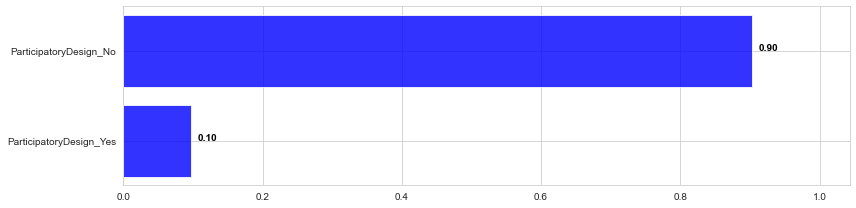

ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                   457   
ParticipatoryDesign_Yes                 Yes                    49   

                         Total Fraction of All Papers (N=506)  \
ParticipatoryDesign_No                               0.903162   
ParticipatoryDesign_Yes                              0.096838   

                         Num Papers with this Code Only  \
ParticipatoryDesign_No                              457   
ParticipatoryDesign_Yes                              49   

                         Num Papers with this Code Only (Fraction of Applied Code)  \
ParticipatoryDesign_No                                                 1.0           
ParticipatoryDesign_Yes                                                1.0           

                         Num Papers with this Code Only (Fraction of Total Papers; N=506)  
ParticipatoryDesign_No                                            0.903162                 
ParticipatoryDesign_Yes                                           0.096838

Table for paper:


ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                   457   
ParticipatoryDesign_Yes                 Yes                    49   

                        % of Papers (N=506) with Code  \
ParticipatoryDesign_No                          90.3%   
ParticipatoryDesign_Yes                          9.7%   

                         Num Papers with this Code Only  \
ParticipatoryDesign_No                              457   
ParticipatoryDesign_Yes                              49   

                        % of Papers (N=506) with this Code Only  
ParticipatoryDesign_No                                    90.3%  
ParticipatoryDesign_Yes                                    9.7%



******************************* ComparesOnDisability *******************************

Fraction of all papers (N=506) with sub-code:

ComparesOnDisability_No     0.871542
ComparesOnDisability_Yes    0.128458
Name: Total Fraction of All Papers (N=506), dtype: float64


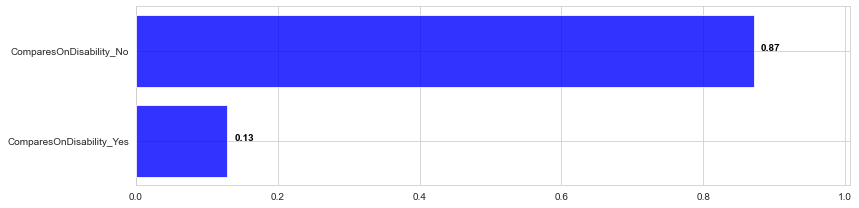

ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                   441   
ComparesOnDisability_Yes                  Yes                    65   

                          Total Fraction of All Papers (N=506)  \
ComparesOnDisability_No                               0.871542   
ComparesOnDisability_Yes                              0.128458   

                          Num Papers with this Code Only  \
ComparesOnDisability_No                              441   
ComparesOnDisability_Yes                              65   

                          Num Papers with this Code Only (Fraction of Applied Code)  \
ComparesOnDisability_No                                                 1.0           
ComparesOnDisability_Yes                                                1.0           

                          Num Papers with this Code Only (Fraction of Total Papers; N=506)  
ComparesOnDisability_No                                            0.871542                 
ComparesOnDisability_Yes                                           0.128458

Table for paper:


ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                   441   
ComparesOnDisability_Yes                  Yes                    65   

                         % of Papers (N=506) with Code  \
ComparesOnDisability_No                          87.2%   
ComparesOnDisability_Yes                         12.8%   

                          Num Papers with this Code Only  \
ComparesOnDisability_No                              441   
ComparesOnDisability_Yes                              65   

                         % of Papers (N=506) with this Code Only  
ComparesOnDisability_No                                    87.2%  
ComparesOnDisability_Yes                                   12.8%



******************************* UsesProxies *******************************

Fraction of all papers (N=506) with sub-code:

UsesProxies_No     0.924901
UsesProxies_Yes    0.075099
Name: Total Fraction of All Papers (N=506), dtype: float64


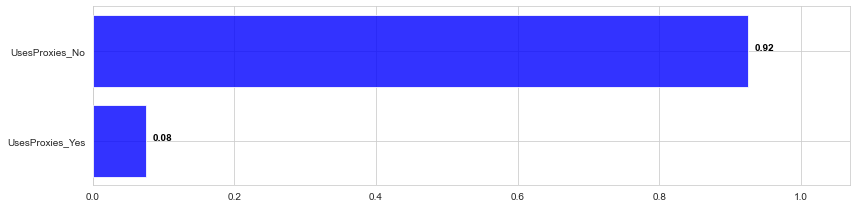

UsesProxies  Num Papers with Code  \
UsesProxies_No           No                   468   
UsesProxies_Yes         Yes                    38   

                 Total Fraction of All Papers (N=506)  \
UsesProxies_No                               0.924901   
UsesProxies_Yes                              0.075099   

                 Num Papers with this Code Only  \
UsesProxies_No                              468   
UsesProxies_Yes                              38   

                 Num Papers with this Code Only (Fraction of Applied Code)  \
UsesProxies_No                                                 1.0           
UsesProxies_Yes                                                1.0           

                 Num Papers with this Code Only (Fraction of Total Papers; N=506)  
UsesProxies_No                                            0.924901                 
UsesProxies_Yes                                           0.075099

Table for paper:


UsesProxies  Num Papers with Code  \
UsesProxies_No           No                   468   
UsesProxies_Yes         Yes                    38   

                % of Papers (N=506) with Code  Num Papers with this Code Only  \
UsesProxies_No                          92.5%                             468   
UsesProxies_Yes                          7.5%                              38   

                % of Papers (N=506) with this Code Only  
UsesProxies_No                                    92.5%  
UsesProxies_Yes                                    7.5%

In [134]:
# Go through each category and print out table with counts, percentages, and a bar graph
total_fraction_of_all_papers_label = f"Total Fraction of All Papers (N={(len(df))})"
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
    
    col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_code_table = pd.DataFrame(index=col_names)
    df_code_table[code_cat] = sub_codes
    
    print(f"\n\n******************************* {code_cat} *******************************\n")
    df_code_table['Num Papers with Code'] = df[col_names].sum()
    df_code_table[total_fraction_of_all_papers_label] = df[col_names].sum() / len(df)
    print(f"Fraction of all papers (N={len(df)}) with sub-code:\n")
    print(df_code_table[total_fraction_of_all_papers_label].sort_values(ascending=False))
    plot_bar_graph_series(df_code_table[total_fraction_of_all_papers_label].sort_values(ascending=True))
    
    map_sole_sub_code_applied_rates = calc_sole_sub_code_applied_rates(df, code_cat)
    sole_sub_code_series = pd.Series(map_sole_sub_code_applied_rates)
    df_code_table['Num Papers with this Code Only'] = sole_sub_code_series
    df_code_table['Num Papers with this Code Only (Fraction of Applied Code)'] = sole_sub_code_series / df_code_table['Num Papers with Code']
    df_code_table[f'Num Papers with this Code Only (Fraction of Total Papers; N={len(df)})'] = sole_sub_code_series / len(df)
    
    display(df_code_table.sort_values(by=[total_fraction_of_all_papers_label], ascending=False))
    
    df_paper_table = pd.DataFrame(index=col_names)
    df_paper_table[code_cat] = sub_codes
    df_paper_table['Num Papers with Code'] = df[col_names].sum()
    df_paper_table[f'% of Papers (N={len(df)}) with Code'] =\
        pd.Series(["{0:.1f}%".format(val/len(df) * 100) for val in df_paper_table['Num Papers with Code']], index = df_paper_table.index)
    df_paper_table['Num Papers with this Code Only'] = sole_sub_code_series
    df_paper_table[f'% of Papers (N={len(df)}) with this Code Only'] =\
        pd.Series(["{0:.1f}%".format(val/len(df) * 100) for val in df_paper_table['Num Papers with this Code Only']], index = df_paper_table.index)
    
    print("Table for paper:")
    display(df_paper_table.sort_values(by=['Num Papers with Code'], ascending=False))

### Code coverage for user-study papers

In [43]:
calc_code_coverage_across_papers(df)



******************************* CommunityOfFocus *******************************



CommunityOfFocus  Num Papers with Code  \
CommunityOfFocus_BVI                              BVI                   220   
CommunityOfFocus_MotorPhysical          MotorPhysical                    72   
CommunityOfFocus_DHH                              DHH                    57   
CommunityOfFocus_Cognitive                  Cognitive                    46   
CommunityOfFocus_GeneralDisability  GeneralDisability                    46   
CommunityOfFocus_Other                          Other                    46   
CommunityOfFocus_OlderAdult                OlderAdult                    45   
CommunityOfFocus_Autism                        Autism                    31   
CommunityOfFocus_IDD                              IDD                    14   

                                   % of Papers (N=506)  Total Papers Covered  \
CommunityOfFocus_BVI                             43.5%                   220   
CommunityOfFocus_MotorPhysical                   14.2%                   290   
CommunityOfFocus_DHH                             11.3%                   347   
CommunityOfFocus_Cognitive                        9.1%                   388   
CommunityOfFocus_GeneralDisability                9.1%                   421   
CommunityOfFocus_Other                            9.1%                   445   
CommunityOfFocus_OlderAdult                       8.9%                   474   
CommunityOfFocus_Autism                           6.1%                   498   
CommunityOfFocus_IDD                              2.8%                   506   

                                   % of Papers (N=506) Covered  
CommunityOfFocus_BVI                                     43.5%  
CommunityOfFocus_MotorPhysical                           57.3%  
CommunityOfFocus_DHH                                     68.6%  
CommunityOfFocus_Cognitive                               76.7%  
CommunityOfFocus_GeneralDisability                       83.2%  
CommunityOfFocus_Other                                   87.9%  
CommunityOfFocus_OlderAdult                              93.7%  
CommunityOfFocus_Autism                                  98.4%  
CommunityOfFocus_IDD                                    100.0%



******************************* IssueAddressed *******************************



IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                 186   
IssueAddressed_IncreaseUnderstandingOfUsers                          139   
IssueAddressed_IncreasePhysicalAccess                                105   
IssueAddressed_IncreaseIndependence                                   93   
IssueAddressed_SupportCommunication                                   81   
IssueAddressed_Other                                                  59   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    39   

                                                   % of Papers (N=506)  \
IssueAddressed_IncreaseDigitalAccess                             36.8%   
IssueAddressed_IncreaseUnderstandingOfUsers                      27.5%   
IssueAddressed_IncreasePhysicalAccess                            20.8%   
IssueAddressed_IncreaseIndependence                              18.4%   
IssueAddressed_SupportCommunication                              16.0%   
IssueAddressed_Other                                             11.7%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                7.7%   

                                                    Total Papers Covered  \
IssueAddressed_IncreaseDigitalAccess                                 186   
IssueAddressed_IncreaseUnderstandingOfUsers                          301   
IssueAddressed_IncreasePhysicalAccess                                387   
IssueAddressed_IncreaseIndependence                                  408   
IssueAddressed_SupportCommunication                                  459   
IssueAddressed_Other                                                 487   
IssueAddressed_HelpWithPersonalInformaticsBehav...                   506   

                                                   % of Papers (N=506) Covered  
IssueAddressed_IncreaseDigitalAccess                                     36.8%  
IssueAddressed_IncreaseUnderstandingOfUsers                              59.5%  
IssueAddressed_IncreasePhysicalAccess                                    76.5%  
IssueAddressed_IncreaseIndependence                                      80.6%  
IssueAddressed_SupportCommunication                                      90.7%  
IssueAddressed_Other                                                     96.2%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                      100.0%



******************************* ContributionType *******************************



ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                   305   
ContributionType_Artifact                      Artifact                   281   
ContributionType_Theoretical                Theoretical                    44   
ContributionType_Methodological          Methodological                    16   
ContributionType_Dataset                        Dataset                     7   
ContributionType_SurveyContribution  SurveyContribution                     3   

                                    % of Papers (N=506)  Total Papers Covered  \
ContributionType_Empirical                        60.3%                   305   
ContributionType_Artifact                         55.5%                   493   
ContributionType_Theoretical                       8.7%                   500   
ContributionType_Methodological                    3.2%                   504   
ContributionType_Dataset                           1.4%                   506   
ContributionType_SurveyContribution                0.6%                   506   

                                    % of Papers (N=506) Covered  
ContributionType_Empirical                                60.3%  
ContributionType_Artifact                                 97.4%  
ContributionType_Theoretical                              98.8%  
ContributionType_Methodological                           99.6%  
ContributionType_Dataset                                 100.0%  
ContributionType_SurveyContribution                      100.0%



******************************* StudyMethod *******************************



StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                   201   
StudyMethod_UsabilityTesting          UsabilityTesting                   199   
StudyMethod_ControlledExperiment  ControlledExperiment                   167   
StudyMethod_SurveyMethod                  SurveyMethod                   122   
StudyMethod_Other                                Other                    99   
StudyMethod_WorkshopDesign              WorkshopDesign                    88   
StudyMethod_FieldStudy                      FieldStudy                    85   
StudyMethod_FocusGroups                    FocusGroups                    28   
StudyMethod_CaseStudy                        CaseStudy                    25   

                                 % of Papers (N=506)  Total Papers Covered  \
StudyMethod_Interviews                         39.7%                   201   
StudyMethod_UsabilityTesting                   39.3%                   317   
StudyMethod_ControlledExperiment               33.0%                   403   
StudyMethod_SurveyMethod                       24.1%                   418   
StudyMethod_Other                              19.6%                   451   
StudyMethod_WorkshopDesign                     17.4%                   472   
StudyMethod_FieldStudy                         16.8%                   496   
StudyMethod_FocusGroups                         5.5%                   500   
StudyMethod_CaseStudy                           4.9%                   506   

                                 % of Papers (N=506) Covered  
StudyMethod_Interviews                                 39.7%  
StudyMethod_UsabilityTesting                           62.6%  
StudyMethod_ControlledExperiment                       79.6%  
StudyMethod_SurveyMethod                               82.6%  
StudyMethod_Other                                      89.1%  
StudyMethod_WorkshopDesign                             93.3%  
StudyMethod_FieldStudy                                 98.0%  
StudyMethod_FocusGroups                                98.8%  
StudyMethod_CaseStudy                                 100.0%



******************************* ParticipantGroup *******************************



ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   110   
ParticipantGroup_TherapistsSpecialists                      81   
ParticipantGroup_Other                                      53   
ParticipantGroup_Caregivers                                 45   
ParticipantGroup_OlderAdult                                 40   
ParticipantGroup_NoUserStudy                                29   

                                         % of Papers (N=506)  \
ParticipantGroup_PeopleWithDisability                  79.8%   
ParticipantGroup_PeopleWithoutDisability               21.7%   
ParticipantGroup_TherapistsSpecialists                 16.0%   
ParticipantGroup_Other                                 10.5%   
ParticipantGroup_Caregivers                             8.9%   
ParticipantGroup_OlderAdult                             7.9%   
ParticipantGroup_NoUserStudy                            5.7%   

                                          Total Papers Covered  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   421   
ParticipantGroup_TherapistsSpecialists                     433   
ParticipantGroup_Other                                     457   
ParticipantGroup_Caregivers                                462   
ParticipantGroup_OlderAdult                                477   
ParticipantGroup_NoUserStudy                               506   

                                         % of Papers (N=506) Covered  
ParticipantGroup_PeopleWithDisability                          79.8%  
ParticipantGroup_PeopleWithoutDisability                       83.2%  
ParticipantGroup_TherapistsSpecialists                         85.6%  
ParticipantGroup_Other                                         90.3%  
ParticipantGroup_Caregivers                                    91.3%  
ParticipantGroup_OlderAdult                                    94.3%  
ParticipantGroup_NoUserStudy                                  100.0%



******************************* StudyLocation *******************************



StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   
StudyLocation_Other                                          Other   

                                         Num Papers with Code  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   138   
StudyLocation_NearAtLab                                   130   
StudyLocation_OnlineRemotely                               98   
StudyLocation_NeutralLocation                              32   
StudyLocation_NoUserStudy                                  29   
StudyLocation_Other                                         7   

                                        % of Papers (N=506)  \
StudyLocation_Unclear                                 37.4%   
StudyLocation_ParticipantsHomeOrFreqLoc               27.3%   
StudyLocation_NearAtLab                               25.7%   
StudyLocation_OnlineRemotely                          19.4%   
StudyLocation_NeutralLocation                          6.3%   
StudyLocation_NoUserStudy                              5.7%   
StudyLocation_Other                                    1.4%   

                                         Total Papers Covered  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   308   
StudyLocation_NearAtLab                                   411   
StudyLocation_OnlineRemotely                              461   
StudyLocation_NeutralLocation                             476   
StudyLocation_NoUserStudy                                 505   
StudyLocation_Other                                       506   

                                        % of Papers (N=506) Covered  
StudyLocation_Unclear                                         37.4%  
StudyLocation_ParticipantsHomeOrFreqLoc                       60.9%  
StudyLocation_NearAtLab                                       81.2%  
StudyLocation_OnlineRemotely                                  91.1%  
StudyLocation_NeutralLocation                                 94.1%  
StudyLocation_NoUserStudy                                     99.8%  
StudyLocation_Other                                          100.0%



******************************* ParticipatoryDesign *******************************



ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                   457   
ParticipatoryDesign_Yes                 Yes                    49   

                        % of Papers (N=506)  Total Papers Covered  \
ParticipatoryDesign_No                90.3%                   457   
ParticipatoryDesign_Yes                9.7%                   506   

                        % of Papers (N=506) Covered  
ParticipatoryDesign_No                        90.3%  
ParticipatoryDesign_Yes                      100.0%



******************************* ComparesOnDisability *******************************



ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                   441   
ComparesOnDisability_Yes                  Yes                    65   

                         % of Papers (N=506)  Total Papers Covered  \
ComparesOnDisability_No                87.2%                   441   
ComparesOnDisability_Yes               12.8%                   506   

                         % of Papers (N=506) Covered  
ComparesOnDisability_No                        87.2%  
ComparesOnDisability_Yes                      100.0%



******************************* UsesProxies *******************************



UsesProxies  Num Papers with Code % of Papers (N=506)  \
UsesProxies_No           No                   468               92.5%   
UsesProxies_Yes         Yes                    38                7.5%   

                 Total Papers Covered % of Papers (N=506) Covered  
UsesProxies_No                    468                       92.5%  
UsesProxies_Yes                   506                      100.0%

### Frequency of multiple sub-codes
For many code categories, multiple sub-codes could apply. Below, for each code category, we count the number of sub-codes applied to each paper. 

In [44]:
for code_cat, sub_code_cols in map_codes_to_cols.items():
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
        
    sub_code_cols = list(sub_code_cols)
    
    # ParticipantGroup and StudyLocation have 'NoUserStudy' columns, which require special handling
    # In that we do not want to treat them as normal counts as they are exclusive counts
    # See: https://github.com/jonfroehlich/accesslitsurvey/issues/55
    if code_cat == 'ParticipantGroup':
        sub_code_cols.remove('ParticipantGroup_NoUserStudy')
    elif code_cat == 'StudyLocation':
        sub_code_cols.remove('StudyLocation_NoUserStudy')
    
    sum_sub_codes_for_cat = df[sub_code_cols].sum(axis=1)
    print(f"\n\n************ {code_cat} *************")
    print(f"Num of sub-codes applied per paper for {code_cat}")
    df_sum_sub_codes_for_cat = pd.DataFrame()
    sub_code_count_series = sum_sub_codes_for_cat.value_counts()

    num_subcodes_applied_header = 'Num Sub-Codes Applied Per Paper'
    
    df_sum_sub_codes_for_cat[num_subcodes_applied_header] =  sub_code_count_series
    
    if code_cat == 'ParticipantGroup' or code_cat == 'StudyLocation':
        df_sum_sub_codes_for_cat[f'Fraction of User-Study Papers (N={num_papers_with_user_study})'] =\
            sum_sub_codes_for_cat.value_counts() / num_papers_with_user_study
    else:
        df_sum_sub_codes_for_cat[f'Fraction of All Papers (N={len(df)})'] = sum_sub_codes_for_cat.value_counts() / len(df)
        
    df_sum_sub_codes_for_cat = df_sum_sub_codes_for_cat.sort_index()
    display(df_sum_sub_codes_for_cat)
    
    print(f"Total count: {df_sum_sub_codes_for_cat[num_subcodes_applied_header].sum()}.")
    
    



************ CommunityOfFocus *************
Num of sub-codes applied per paper for CommunityOfFocus


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              448                        0.885375
2                               47                        0.092885
3                                9                        0.017787
4                                2                        0.003953

Total count: 506.


************ IssueAddressed *************
Num of sub-codes applied per paper for IssueAddressed


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              340                        0.671937
2                              138                        0.272727
3                               26                        0.051383
4                                2                        0.003953

Total count: 506.


************ ContributionType *************
Num of sub-codes applied per paper for ContributionType


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              363                        0.717391
2                              136                        0.268775
3                                7                        0.013834

Total count: 506.


************ StudyMethod *************
Num of sub-codes applied per paper for StudyMethod


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              208                        0.411067
2                              164                        0.324111
3                               74                        0.146245
4                               46                        0.090909
5                               12                        0.023715
6                                2                        0.003953

Total count: 506.


************ ParticipantGroup *************
Num of sub-codes applied per paper for ParticipantGroup


Num Sub-Codes Applied Per Paper  Fraction of User-Study Papers (N=477)
0                               29                               0.060797
1                              270                               0.566038
2                              163                               0.341719
3                               39                               0.081761
4                                5                               0.010482

Total count: 506.


************ StudyLocation *************
Num of sub-codes applied per paper for StudyLocation


Num Sub-Codes Applied Per Paper  Fraction of User-Study Papers (N=477)
0                               29                               0.060797
1                              375                               0.786164
2                               88                               0.184486
3                               13                               0.027254
4                                1                               0.002096

Total count: 506.


************ ParticipatoryDesign *************
Num of sub-codes applied per paper for ParticipatoryDesign


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              506                             1.0

Total count: 506.


************ ComparesOnDisability *************
Num of sub-codes applied per paper for ComparesOnDisability


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              506                             1.0

Total count: 506.


************ UsesProxies *************
Num of sub-codes applied per paper for UsesProxies


Num Sub-Codes Applied Per Paper  Fraction of All Papers (N=506)
1                              506                             1.0

Total count: 506.


## User-study papers only

### Frequency of sub-code use across only user-study papers



******************************* CommunityOfFocus *******************************

Fraction of user study papers (N=477) with sub-code:

CommunityOfFocus_BVI                  0.452830
CommunityOfFocus_MotorPhysical        0.148847
CommunityOfFocus_DHH                  0.111111
CommunityOfFocus_Cognitive            0.094340
CommunityOfFocus_Other                0.092243
CommunityOfFocus_OlderAdult           0.090147
CommunityOfFocus_GeneralDisability    0.064990
CommunityOfFocus_Autism               0.062893
CommunityOfFocus_IDD                  0.029350
Name: Fraction of User-Study Papers (N=477), dtype: float64


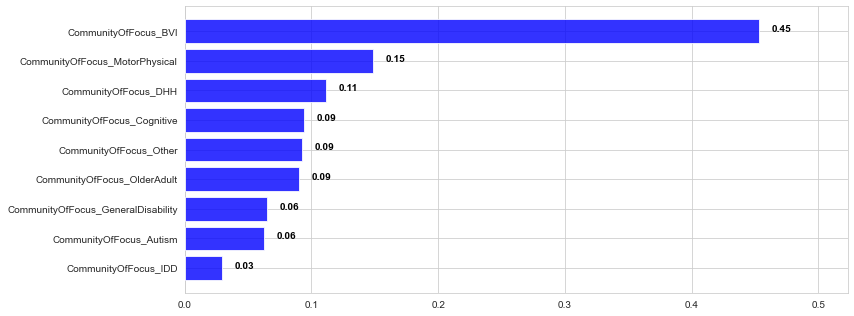

CommunityOfFocus  \
CommunityOfFocus_BVI                              BVI   
CommunityOfFocus_MotorPhysical          MotorPhysical   
CommunityOfFocus_DHH                              DHH   
CommunityOfFocus_Cognitive                  Cognitive   
CommunityOfFocus_Other                          Other   
CommunityOfFocus_OlderAdult                OlderAdult   
CommunityOfFocus_GeneralDisability  GeneralDisability   
CommunityOfFocus_Autism                        Autism   
CommunityOfFocus_IDD                              IDD   

                                    Num User-Study Papers (N=477) with Code  \
CommunityOfFocus_BVI                                                    216   
CommunityOfFocus_MotorPhysical                                           71   
CommunityOfFocus_DHH                                                     53   
CommunityOfFocus_Cognitive                                               45   
CommunityOfFocus_Other                                                   44   
CommunityOfFocus_OlderAdult                                              43   
CommunityOfFocus_GeneralDisability                                       31   
CommunityOfFocus_Autism                                                  30   
CommunityOfFocus_IDD                                                     14   

                                   % of User-Study Papers (N=477)  \
CommunityOfFocus_BVI                                        45.3%   
CommunityOfFocus_MotorPhysical                              14.9%   
CommunityOfFocus_DHH                                        11.1%   
CommunityOfFocus_Cognitive                                   9.4%   
CommunityOfFocus_Other                                       9.2%   
CommunityOfFocus_OlderAdult                                  9.0%   
CommunityOfFocus_GeneralDisability                           6.5%   
CommunityOfFocus_Autism                                      6.3%   
CommunityOfFocus_IDD                                         2.9%   

                                    Num User-Study Papers with this Code Only  \
CommunityOfFocus_BVI                                                      204   
CommunityOfFocus_MotorPhysical                                             58   
CommunityOfFocus_DHH                                                       39   
CommunityOfFocus_Cognitive                                                 28   
CommunityOfFocus_Other                                                     18   
CommunityOfFocus_OlderAdult                                                28   
CommunityOfFocus_GeneralDisability                                         17   
CommunityOfFocus_Autism                                                    20   
CommunityOfFocus_IDD                                                        8   

                                   % of User-Study Papers (N=477) with this Code Only  
CommunityOfFocus_BVI                                                            42.8%  
CommunityOfFocus_MotorPhysical                                                  12.2%  
CommunityOfFocus_DHH                                                             8.2%  
CommunityOfFocus_Cognitive                                                       5.9%  
CommunityOfFocus_Other                                                           3.8%  
CommunityOfFocus_OlderAdult                                                      5.9%  
CommunityOfFocus_GeneralDisability                                               3.6%  
CommunityOfFocus_Autism                                                          4.2%  
CommunityOfFocus_IDD                                                             1.7%



******************************* IssueAddressed *******************************

Fraction of user study papers (N=477) with sub-code:

IssueAddressed_IncreaseDigitalAccess                        0.368973
IssueAddressed_IncreaseUnderstandingOfUsers                 0.268344
IssueAddressed_IncreasePhysicalAccess                       0.215933
IssueAddressed_IncreaseIndependence                         0.192872
IssueAddressed_SupportCommunication                         0.165618
IssueAddressed_Other                                        0.106918
IssueAddressed_HelpWithPersonalInformaticsBehaviorChange    0.081761
Name: Fraction of User-Study Papers (N=477), dtype: float64


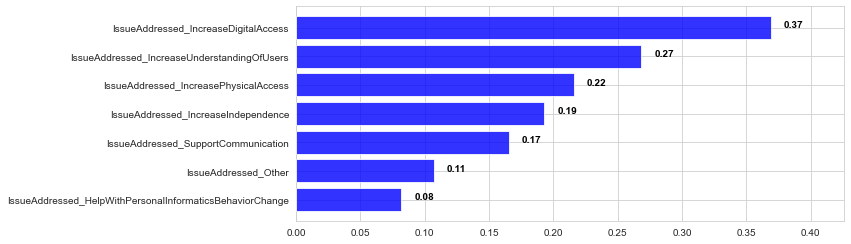

IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num User-Study Papers (N=477) with Code  \
IssueAddressed_IncreaseDigitalAccess                                                    176   
IssueAddressed_IncreaseUnderstandingOfUsers                                             128   
IssueAddressed_IncreasePhysicalAccess                                                   103   
IssueAddressed_IncreaseIndependence                                                      92   
IssueAddressed_SupportCommunication                                                      79   
IssueAddressed_Other                                                                     51   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                       39   

                                                   % of User-Study Papers (N=477)  \
IssueAddressed_IncreaseDigitalAccess                                        36.9%   
IssueAddressed_IncreaseUnderstandingOfUsers                                 26.8%   
IssueAddressed_IncreasePhysicalAccess                                       21.6%   
IssueAddressed_IncreaseIndependence                                         19.3%   
IssueAddressed_SupportCommunication                                         16.6%   
IssueAddressed_Other                                                        10.7%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                           8.2%   

                                                    Num User-Study Papers with this Code Only  \
IssueAddressed_IncreaseDigitalAccess                                                      114   
IssueAddressed_IncreaseUnderstandingOfUsers                                                81   
IssueAddressed_IncreasePhysicalAccess                                                      25   
IssueAddressed_IncreaseIndependence                                                        14   
IssueAddressed_SupportCommunication                                                        43   
IssueAddressed_Other                                                                       20   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                         19   

                                                   % of User-Study Papers (N=477) with this Code Only  
IssueAddressed_IncreaseDigitalAccess                                                            23.9%  
IssueAddressed_IncreaseUnderstandingOfUsers                                                     17.0%  
IssueAddressed_IncreasePhysicalAccess                                                            5.2%  
IssueAddressed_IncreaseIndependence                                                              2.9%  
IssueAddressed_SupportCommunication                                                              9.0%  
IssueAddressed_Other                                                                             4.2%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                                               4.0%



******************************* ContributionType *******************************

Fraction of user study papers (N=477) with sub-code:

ContributionType_Empirical             0.603774
ContributionType_Artifact              0.574423
ContributionType_Theoretical           0.079665
ContributionType_Methodological        0.025157
ContributionType_Dataset               0.014675
ContributionType_SurveyContribution    0.002096
Name: Fraction of User-Study Papers (N=477), dtype: float64


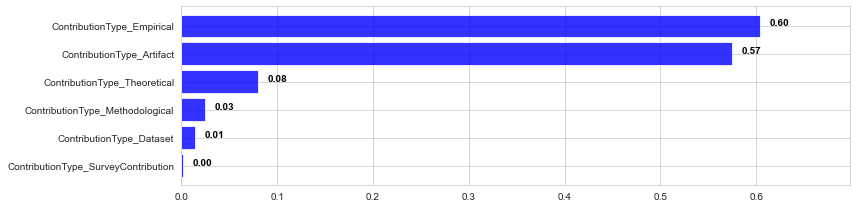

ContributionType  \
ContributionType_Empirical                    Empirical   
ContributionType_Artifact                      Artifact   
ContributionType_Theoretical                Theoretical   
ContributionType_Methodological          Methodological   
ContributionType_Dataset                        Dataset   
ContributionType_SurveyContribution  SurveyContribution   

                                     Num User-Study Papers (N=477) with Code  \
ContributionType_Empirical                                               288   
ContributionType_Artifact                                                274   
ContributionType_Theoretical                                              38   
ContributionType_Methodological                                           12   
ContributionType_Dataset                                                   7   
ContributionType_SurveyContribution                                        1   

                                    % of User-Study Papers (N=477)  \
ContributionType_Empirical                                   60.4%   
ContributionType_Artifact                                    57.4%   
ContributionType_Theoretical                                  8.0%   
ContributionType_Methodological                               2.5%   
ContributionType_Dataset                                      1.5%   
ContributionType_SurveyContribution                           0.2%   

                                     Num User-Study Papers with this Code Only  \
ContributionType_Empirical                                                 158   
ContributionType_Artifact                                                  176   
ContributionType_Theoretical                                                 3   
ContributionType_Methodological                                              2   
ContributionType_Dataset                                                     2   
ContributionType_SurveyContribution                                          0   

                                    % of User-Study Papers (N=477) with this Code Only  
ContributionType_Empirical                                                       33.1%  
ContributionType_Artifact                                                        36.9%  
ContributionType_Theoretical                                                      0.6%  
ContributionType_Methodological                                                   0.4%  
ContributionType_Dataset                                                          0.4%  
ContributionType_SurveyContribution                                               0.0%



******************************* StudyMethod *******************************

Fraction of user study papers (N=477) with sub-code:

StudyMethod_Interviews              0.421384
StudyMethod_UsabilityTesting        0.417191
StudyMethod_ControlledExperiment    0.345912
StudyMethod_SurveyMethod            0.255765
StudyMethod_WorkshopDesign          0.184486
StudyMethod_FieldStudy              0.178197
StudyMethod_Other                   0.161426
StudyMethod_FocusGroups             0.058700
StudyMethod_CaseStudy               0.039832
Name: Fraction of User-Study Papers (N=477), dtype: float64


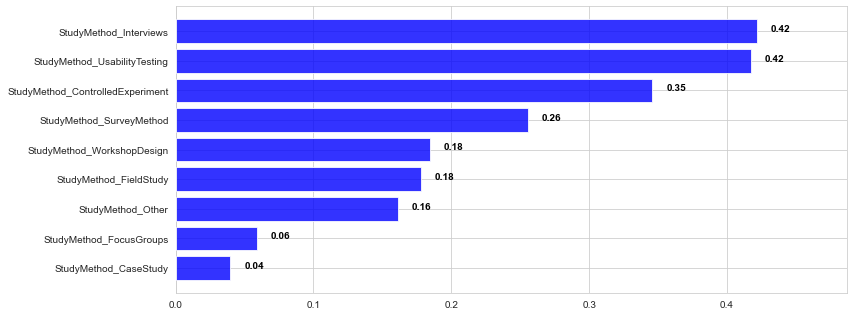

StudyMethod  \
StudyMethod_Interviews                      Interviews   
StudyMethod_UsabilityTesting          UsabilityTesting   
StudyMethod_ControlledExperiment  ControlledExperiment   
StudyMethod_SurveyMethod                  SurveyMethod   
StudyMethod_WorkshopDesign              WorkshopDesign   
StudyMethod_FieldStudy                      FieldStudy   
StudyMethod_Other                                Other   
StudyMethod_FocusGroups                    FocusGroups   
StudyMethod_CaseStudy                        CaseStudy   

                                  Num User-Study Papers (N=477) with Code  \
StudyMethod_Interviews                                                201   
StudyMethod_UsabilityTesting                                          199   
StudyMethod_ControlledExperiment                                      165   
StudyMethod_SurveyMethod                                              122   
StudyMethod_WorkshopDesign                                             88   
StudyMethod_FieldStudy                                                 85   
StudyMethod_Other                                                      77   
StudyMethod_FocusGroups                                                28   
StudyMethod_CaseStudy                                                  19   

                                 % of User-Study Papers (N=477)  \
StudyMethod_Interviews                                    42.1%   
StudyMethod_UsabilityTesting                              41.7%   
StudyMethod_ControlledExperiment                          34.6%   
StudyMethod_SurveyMethod                                  25.6%   
StudyMethod_WorkshopDesign                                18.4%   
StudyMethod_FieldStudy                                    17.8%   
StudyMethod_Other                                         16.1%   
StudyMethod_FocusGroups                                    5.9%   
StudyMethod_CaseStudy                                      4.0%   

                                  Num User-Study Papers with this Code Only  \
StudyMethod_Interviews                                                   27   
StudyMethod_UsabilityTesting                                             46   
StudyMethod_ControlledExperiment                                         55   
StudyMethod_SurveyMethod                                                  6   
StudyMethod_WorkshopDesign                                               15   
StudyMethod_FieldStudy                                                   22   
StudyMethod_Other                                                         4   
StudyMethod_FocusGroups                                                   4   
StudyMethod_CaseStudy                                                     1   

                                 % of User-Study Papers (N=477) with this Code Only  
StudyMethod_Interviews                                                         5.7%  
StudyMethod_UsabilityTesting                                                   9.6%  
StudyMethod_ControlledExperiment                                              11.5%  
StudyMethod_SurveyMethod                                                       1.3%  
StudyMethod_WorkshopDesign                                                     3.1%  
StudyMethod_FieldStudy                                                         4.6%  
StudyMethod_Other                                                              0.8%  
StudyMethod_FocusGroups                                                        0.8%  
StudyMethod_CaseStudy                                                          0.2%



******************************* ParticipantGroup *******************************

Fraction of user study papers (N=477) with sub-code:

ParticipantGroup_PeopleWithDisability       0.846960
ParticipantGroup_PeopleWithoutDisability    0.230608
ParticipantGroup_TherapistsSpecialists      0.169811
ParticipantGroup_Other                      0.111111
ParticipantGroup_Caregivers                 0.094340
ParticipantGroup_OlderAdult                 0.083857
ParticipantGroup_NoUserStudy                0.000000
Name: Fraction of User-Study Papers (N=477), dtype: float64


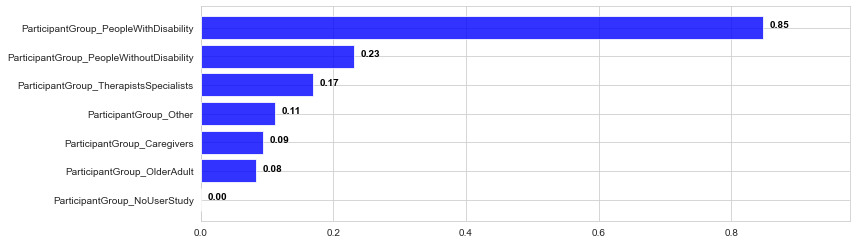

ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num User-Study Papers (N=477) with Code  \
ParticipantGroup_PeopleWithDisability                                         404   
ParticipantGroup_PeopleWithoutDisability                                      110   
ParticipantGroup_TherapistsSpecialists                                         81   
ParticipantGroup_Other                                                         53   
ParticipantGroup_Caregivers                                                    45   
ParticipantGroup_OlderAdult                                                    40   
ParticipantGroup_NoUserStudy                                                    0   

                                         % of User-Study Papers (N=477)  \
ParticipantGroup_PeopleWithDisability                             84.7%   
ParticipantGroup_PeopleWithoutDisability                          23.1%   
ParticipantGroup_TherapistsSpecialists                            17.0%   
ParticipantGroup_Other                                            11.1%   
ParticipantGroup_Caregivers                                        9.4%   
ParticipantGroup_OlderAdult                                        8.4%   
ParticipantGroup_NoUserStudy                                       0.0%   

                                          Num User-Study Papers with this Code Only  \
ParticipantGroup_PeopleWithDisability                                           214   
ParticipantGroup_PeopleWithoutDisability                                          5   
ParticipantGroup_TherapistsSpecialists                                            9   
ParticipantGroup_Other                                                           23   
ParticipantGroup_Caregivers                                                       4   
ParticipantGroup_OlderAdult                                                      15   
ParticipantGroup_NoUserStudy                                                      0   

                                         % of User-Study Papers (N=477) with this Code Only  
ParticipantGroup_PeopleWithDisability                                                 44.9%  
ParticipantGroup_PeopleWithoutDisability                                               1.0%  
ParticipantGroup_TherapistsSpecialists                                                 1.9%  
ParticipantGroup_Other                                                                 4.8%  
ParticipantGroup_Caregivers                                                            0.8%  
ParticipantGroup_OlderAdult                                                            3.1%  
ParticipantGroup_NoUserStudy                                                           0.0%



******************************* StudyLocation *******************************

Fraction of user study papers (N=477) with sub-code:

StudyLocation_Unclear                      0.396226
StudyLocation_ParticipantsHomeOrFreqLoc    0.289308
StudyLocation_NearAtLab                    0.272537
StudyLocation_OnlineRemotely               0.205451
StudyLocation_NeutralLocation              0.067086
StudyLocation_Other                        0.014675
StudyLocation_NoUserStudy                  0.000000
Name: Fraction of User-Study Papers (N=477), dtype: float64


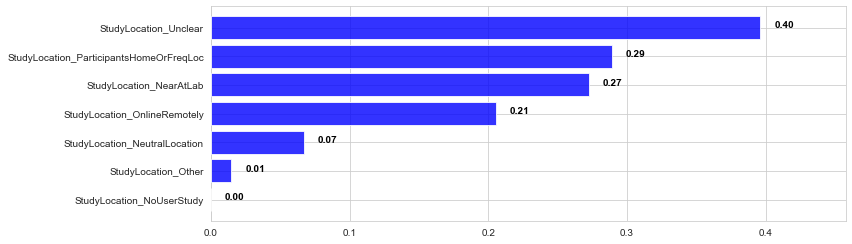

StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_Other                                          Other   
StudyLocation_NoUserStudy                              NoUserStudy   

                                         Num User-Study Papers (N=477) with Code  \
StudyLocation_Unclear                                                        189   
StudyLocation_ParticipantsHomeOrFreqLoc                                      138   
StudyLocation_NearAtLab                                                      130   
StudyLocation_OnlineRemotely                                                  98   
StudyLocation_NeutralLocation                                                 32   
StudyLocation_Other                                                            7   
StudyLocation_NoUserStudy                                                      0   

                                        % of User-Study Papers (N=477)  \
StudyLocation_Unclear                                            39.6%   
StudyLocation_ParticipantsHomeOrFreqLoc                          28.9%   
StudyLocation_NearAtLab                                          27.3%   
StudyLocation_OnlineRemotely                                     20.5%   
StudyLocation_NeutralLocation                                     6.7%   
StudyLocation_Other                                               1.5%   
StudyLocation_NoUserStudy                                         0.0%   

                                         Num User-Study Papers with this Code Only  \
StudyLocation_Unclear                                                          133   
StudyLocation_ParticipantsHomeOrFreqLoc                                         85   
StudyLocation_NearAtLab                                                         93   
StudyLocation_OnlineRemotely                                                    48   
StudyLocation_NeutralLocation                                                   15   
StudyLocation_Other                                                              1   
StudyLocation_NoUserStudy                                                        0   

                                        % of User-Study Papers (N=477) with this Code Only  
StudyLocation_Unclear                                                                27.9%  
StudyLocation_ParticipantsHomeOrFreqLoc                                              17.8%  
StudyLocation_NearAtLab                                                              19.5%  
StudyLocation_OnlineRemotely                                                         10.1%  
StudyLocation_NeutralLocation                                                         3.1%  
StudyLocation_Other                                                                   0.2%  
StudyLocation_NoUserStudy                                                             0.0%



******************************* ParticipatoryDesign *******************************

Fraction of user study papers (N=477) with sub-code:

ParticipatoryDesign_No     0.897275
ParticipatoryDesign_Yes    0.102725
Name: Fraction of User-Study Papers (N=477), dtype: float64


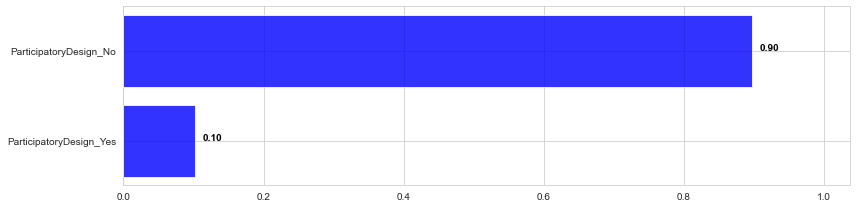

ParticipatoryDesign  \
ParticipatoryDesign_No                   No   
ParticipatoryDesign_Yes                 Yes   

                         Num User-Study Papers (N=477) with Code  \
ParticipatoryDesign_No                                       428   
ParticipatoryDesign_Yes                                       49   

                        % of User-Study Papers (N=477)  \
ParticipatoryDesign_No                           89.7%   
ParticipatoryDesign_Yes                          10.3%   

                         Num User-Study Papers with this Code Only  \
ParticipatoryDesign_No                                         428   
ParticipatoryDesign_Yes                                         49   

                        % of User-Study Papers (N=477) with this Code Only  
ParticipatoryDesign_No                                               89.7%  
ParticipatoryDesign_Yes                                              10.3%



******************************* ComparesOnDisability *******************************

Fraction of user study papers (N=477) with sub-code:

ComparesOnDisability_No     0.863732
ComparesOnDisability_Yes    0.136268
Name: Fraction of User-Study Papers (N=477), dtype: float64


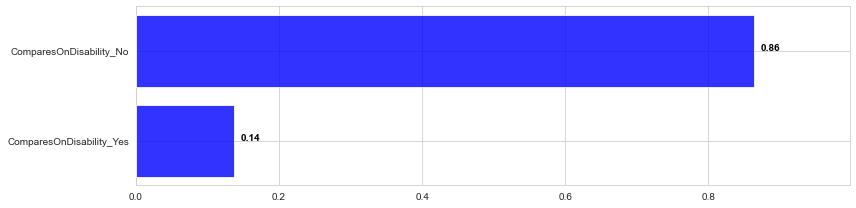

ComparesOnDisability  \
ComparesOnDisability_No                    No   
ComparesOnDisability_Yes                  Yes   

                          Num User-Study Papers (N=477) with Code  \
ComparesOnDisability_No                                       412   
ComparesOnDisability_Yes                                       65   

                         % of User-Study Papers (N=477)  \
ComparesOnDisability_No                           86.4%   
ComparesOnDisability_Yes                          13.6%   

                          Num User-Study Papers with this Code Only  \
ComparesOnDisability_No                                         412   
ComparesOnDisability_Yes                                         65   

                         % of User-Study Papers (N=477) with this Code Only  
ComparesOnDisability_No                                               86.4%  
ComparesOnDisability_Yes                                              13.6%



******************************* UsesProxies *******************************

Fraction of user study papers (N=477) with sub-code:

UsesProxies_No     0.920335
UsesProxies_Yes    0.079665
Name: Fraction of User-Study Papers (N=477), dtype: float64


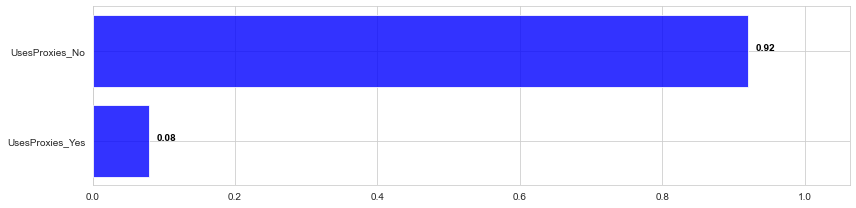

UsesProxies  Num User-Study Papers (N=477) with Code  \
UsesProxies_No           No                                      439   
UsesProxies_Yes         Yes                                       38   

                % of User-Study Papers (N=477)  \
UsesProxies_No                           92.0%   
UsesProxies_Yes                           8.0%   

                 Num User-Study Papers with this Code Only  \
UsesProxies_No                                         439   
UsesProxies_Yes                                         38   

                % of User-Study Papers (N=477) with this Code Only  
UsesProxies_No                                               92.0%  
UsesProxies_Yes                                               8.0%

In [45]:
fraction_of_user_study_papers_label = f"Fraction of User-Study Papers (N={len(df_with_user_study)})"
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
    
    col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_code_table = pd.DataFrame(index=col_names)
    df_code_table[code_cat] = sub_codes
    
    map_sole_sub_code_applied_rates = calc_sole_sub_code_applied_rates(df_with_user_study, code_cat)
    sole_sub_code_series = pd.Series(map_sole_sub_code_applied_rates)
    
    print(f"\n\n******************************* {code_cat} *******************************\n")
    num_user_study_papers_lbl = f'Num User-Study Papers (N={len(df_with_user_study)}) with Code'
    df_code_table[num_user_study_papers_lbl] = df_with_user_study[col_names].sum()
    df_code_table[fraction_of_user_study_papers_label] =\
        df_with_user_study[col_names].sum() / len(df_with_user_study)
    df_code_table[f'% of User-Study Papers (N={len(df_with_user_study)})'] =\
        pd.Series(["{0:.1f}%".format(val/len(df_with_user_study) * 100) for val in df_code_table[num_user_study_papers_lbl]], 
                  index = df_code_table.index)
    
    num_user_study_papers_code_only_lbl = 'Num User-Study Papers with this Code Only'
    df_code_table[num_user_study_papers_code_only_lbl] = sole_sub_code_series
    df_code_table[f'% of User-Study Papers (N={len(df_with_user_study)}) with this Code Only'] =\
        pd.Series(["{0:.1f}%".format(val/len(df_with_user_study) * 100) for val in df_code_table[num_user_study_papers_code_only_lbl]], index = df_code_table.index)
    
    print(f"Fraction of user study papers (N={len(df_with_user_study)}) with sub-code:\n")
    print(df_code_table[fraction_of_user_study_papers_label].sort_values(ascending=False))
    plot_bar_graph_series(df_code_table[fraction_of_user_study_papers_label].sort_values(ascending=True))
    
    df_code_table = df_code_table.drop(fraction_of_user_study_papers_label, axis=1)
    display(df_code_table.sort_values(by=[num_user_study_papers_lbl], ascending=False))

### Code coverage for user-study papers

In [46]:
calc_code_coverage_across_papers(df_with_user_study)



******************************* CommunityOfFocus *******************************



CommunityOfFocus  Num Papers with Code  \
CommunityOfFocus_BVI                              BVI                   216   
CommunityOfFocus_MotorPhysical          MotorPhysical                    71   
CommunityOfFocus_DHH                              DHH                    53   
CommunityOfFocus_Cognitive                  Cognitive                    45   
CommunityOfFocus_Other                          Other                    44   
CommunityOfFocus_OlderAdult                OlderAdult                    43   
CommunityOfFocus_GeneralDisability  GeneralDisability                    31   
CommunityOfFocus_Autism                        Autism                    30   
CommunityOfFocus_IDD                              IDD                    14   

                                   % of Papers (N=477)  Total Papers Covered  \
CommunityOfFocus_BVI                             45.3%                   216   
CommunityOfFocus_MotorPhysical                   14.9%                   285   
CommunityOfFocus_DHH                             11.1%                   338   
CommunityOfFocus_Cognitive                        9.4%                   378   
CommunityOfFocus_Other                            9.2%                   400   
CommunityOfFocus_OlderAdult                       9.0%                   428   
CommunityOfFocus_GeneralDisability                6.5%                   446   
CommunityOfFocus_Autism                           6.3%                   469   
CommunityOfFocus_IDD                              2.9%                   477   

                                   % of Papers (N=477) Covered  
CommunityOfFocus_BVI                                     45.3%  
CommunityOfFocus_MotorPhysical                           59.7%  
CommunityOfFocus_DHH                                     70.9%  
CommunityOfFocus_Cognitive                               79.2%  
CommunityOfFocus_Other                                   83.9%  
CommunityOfFocus_OlderAdult                              89.7%  
CommunityOfFocus_GeneralDisability                       93.5%  
CommunityOfFocus_Autism                                  98.3%  
CommunityOfFocus_IDD                                    100.0%



******************************* IssueAddressed *******************************



IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_Other                                                                    Other   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                 176   
IssueAddressed_IncreaseUnderstandingOfUsers                          128   
IssueAddressed_IncreasePhysicalAccess                                103   
IssueAddressed_IncreaseIndependence                                   92   
IssueAddressed_SupportCommunication                                   79   
IssueAddressed_Other                                                  51   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    39   

                                                   % of Papers (N=477)  \
IssueAddressed_IncreaseDigitalAccess                             36.9%   
IssueAddressed_IncreaseUnderstandingOfUsers                      26.8%   
IssueAddressed_IncreasePhysicalAccess                            21.6%   
IssueAddressed_IncreaseIndependence                              19.3%   
IssueAddressed_SupportCommunication                              16.6%   
IssueAddressed_Other                                             10.7%   
IssueAddressed_HelpWithPersonalInformaticsBehav...                8.2%   

                                                    Total Papers Covered  \
IssueAddressed_IncreaseDigitalAccess                                 176   
IssueAddressed_IncreaseUnderstandingOfUsers                          281   
IssueAddressed_IncreasePhysicalAccess                                365   
IssueAddressed_IncreaseIndependence                                  386   
IssueAddressed_SupportCommunication                                  435   
IssueAddressed_Other                                                 458   
IssueAddressed_HelpWithPersonalInformaticsBehav...                   477   

                                                   % of Papers (N=477) Covered  
IssueAddressed_IncreaseDigitalAccess                                     36.9%  
IssueAddressed_IncreaseUnderstandingOfUsers                              58.9%  
IssueAddressed_IncreasePhysicalAccess                                    76.5%  
IssueAddressed_IncreaseIndependence                                      80.9%  
IssueAddressed_SupportCommunication                                      91.2%  
IssueAddressed_Other                                                     96.0%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                      100.0%



******************************* ContributionType *******************************



ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                   288   
ContributionType_Artifact                      Artifact                   274   
ContributionType_Theoretical                Theoretical                    38   
ContributionType_Methodological          Methodological                    12   
ContributionType_Dataset                        Dataset                     7   
ContributionType_SurveyContribution  SurveyContribution                     1   

                                    % of Papers (N=477)  Total Papers Covered  \
ContributionType_Empirical                        60.4%                   288   
ContributionType_Artifact                         57.4%                   470   
ContributionType_Theoretical                       8.0%                   473   
ContributionType_Methodological                    2.5%                   475   
ContributionType_Dataset                           1.5%                   477   
ContributionType_SurveyContribution                0.2%                   477   

                                    % of Papers (N=477) Covered  
ContributionType_Empirical                                60.4%  
ContributionType_Artifact                                 98.5%  
ContributionType_Theoretical                              99.2%  
ContributionType_Methodological                           99.6%  
ContributionType_Dataset                                 100.0%  
ContributionType_SurveyContribution                      100.0%



******************************* StudyMethod *******************************



StudyMethod  Num Papers with Code  \
StudyMethod_Interviews                      Interviews                   201   
StudyMethod_UsabilityTesting          UsabilityTesting                   199   
StudyMethod_ControlledExperiment  ControlledExperiment                   165   
StudyMethod_SurveyMethod                  SurveyMethod                   122   
StudyMethod_WorkshopDesign              WorkshopDesign                    88   
StudyMethod_FieldStudy                      FieldStudy                    85   
StudyMethod_Other                                Other                    77   
StudyMethod_FocusGroups                    FocusGroups                    28   
StudyMethod_CaseStudy                        CaseStudy                    19   

                                 % of Papers (N=477)  Total Papers Covered  \
StudyMethod_Interviews                         42.1%                   201   
StudyMethod_UsabilityTesting                   41.7%                   317   
StudyMethod_ControlledExperiment               34.6%                   401   
StudyMethod_SurveyMethod                       25.6%                   416   
StudyMethod_WorkshopDesign                     18.4%                   439   
StudyMethod_FieldStudy                         17.8%                   468   
StudyMethod_Other                              16.1%                   472   
StudyMethod_FocusGroups                         5.9%                   476   
StudyMethod_CaseStudy                           4.0%                   477   

                                 % of Papers (N=477) Covered  
StudyMethod_Interviews                                 42.1%  
StudyMethod_UsabilityTesting                           66.5%  
StudyMethod_ControlledExperiment                       84.1%  
StudyMethod_SurveyMethod                               87.2%  
StudyMethod_WorkshopDesign                             92.0%  
StudyMethod_FieldStudy                                 98.1%  
StudyMethod_Other                                      99.0%  
StudyMethod_FocusGroups                                99.8%  
StudyMethod_CaseStudy                                 100.0%



******************************* ParticipantGroup *******************************



ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Other                                      Other   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   110   
ParticipantGroup_TherapistsSpecialists                      81   
ParticipantGroup_Other                                      53   
ParticipantGroup_Caregivers                                 45   
ParticipantGroup_OlderAdult                                 40   
ParticipantGroup_NoUserStudy                                 0   

                                         % of Papers (N=477)  \
ParticipantGroup_PeopleWithDisability                  84.7%   
ParticipantGroup_PeopleWithoutDisability               23.1%   
ParticipantGroup_TherapistsSpecialists                 17.0%   
ParticipantGroup_Other                                 11.1%   
ParticipantGroup_Caregivers                             9.4%   
ParticipantGroup_OlderAdult                             8.4%   
ParticipantGroup_NoUserStudy                            0.0%   

                                          Total Papers Covered  \
ParticipantGroup_PeopleWithDisability                      404   
ParticipantGroup_PeopleWithoutDisability                   421   
ParticipantGroup_TherapistsSpecialists                     433   
ParticipantGroup_Other                                     457   
ParticipantGroup_Caregivers                                462   
ParticipantGroup_OlderAdult                                477   
ParticipantGroup_NoUserStudy                               477   

                                         % of Papers (N=477) Covered  
ParticipantGroup_PeopleWithDisability                          84.7%  
ParticipantGroup_PeopleWithoutDisability                       88.3%  
ParticipantGroup_TherapistsSpecialists                         90.8%  
ParticipantGroup_Other                                         95.8%  
ParticipantGroup_Caregivers                                    96.9%  
ParticipantGroup_OlderAdult                                   100.0%  
ParticipantGroup_NoUserStudy                                  100.0%



******************************* StudyLocation *******************************



StudyLocation  \
StudyLocation_Unclear                                      Unclear   
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_Other                                          Other   
StudyLocation_NoUserStudy                              NoUserStudy   

                                         Num Papers with Code  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   138   
StudyLocation_NearAtLab                                   130   
StudyLocation_OnlineRemotely                               98   
StudyLocation_NeutralLocation                              32   
StudyLocation_Other                                         7   
StudyLocation_NoUserStudy                                   0   

                                        % of Papers (N=477)  \
StudyLocation_Unclear                                 39.6%   
StudyLocation_ParticipantsHomeOrFreqLoc               28.9%   
StudyLocation_NearAtLab                               27.3%   
StudyLocation_OnlineRemotely                          20.5%   
StudyLocation_NeutralLocation                          6.7%   
StudyLocation_Other                                    1.5%   
StudyLocation_NoUserStudy                              0.0%   

                                         Total Papers Covered  \
StudyLocation_Unclear                                     189   
StudyLocation_ParticipantsHomeOrFreqLoc                   308   
StudyLocation_NearAtLab                                   411   
StudyLocation_OnlineRemotely                              461   
StudyLocation_NeutralLocation                             476   
StudyLocation_Other                                       477   
StudyLocation_NoUserStudy                                 477   

                                        % of Papers (N=477) Covered  
StudyLocation_Unclear                                         39.6%  
StudyLocation_ParticipantsHomeOrFreqLoc                       64.6%  
StudyLocation_NearAtLab                                       86.2%  
StudyLocation_OnlineRemotely                                  96.6%  
StudyLocation_NeutralLocation                                 99.8%  
StudyLocation_Other                                          100.0%  
StudyLocation_NoUserStudy                                    100.0%



******************************* ParticipatoryDesign *******************************



ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_No                   No                   428   
ParticipatoryDesign_Yes                 Yes                    49   

                        % of Papers (N=477)  Total Papers Covered  \
ParticipatoryDesign_No                89.7%                   428   
ParticipatoryDesign_Yes               10.3%                   477   

                        % of Papers (N=477) Covered  
ParticipatoryDesign_No                        89.7%  
ParticipatoryDesign_Yes                      100.0%



******************************* ComparesOnDisability *******************************



ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                   412   
ComparesOnDisability_Yes                  Yes                    65   

                         % of Papers (N=477)  Total Papers Covered  \
ComparesOnDisability_No                86.4%                   412   
ComparesOnDisability_Yes               13.6%                   477   

                         % of Papers (N=477) Covered  
ComparesOnDisability_No                        86.4%  
ComparesOnDisability_Yes                      100.0%



******************************* UsesProxies *******************************



UsesProxies  Num Papers with Code % of Papers (N=477)  \
UsesProxies_No           No                   439               92.0%   
UsesProxies_Yes         Yes                    38                8.0%   

                 Total Papers Covered % of Papers (N=477) Covered  
UsesProxies_No                    439                       92.0%  
UsesProxies_Yes                   477                      100.0%

## Participatory-design papers only

### Code coverage for participatory-design papers

In [47]:
df_with_participatory_design = df[df['ParticipatoryDesign_Yes'] == 1]
calc_code_coverage_across_papers(df_with_participatory_design)



******************************* CommunityOfFocus *******************************



CommunityOfFocus  Num Papers with Code  \
CommunityOfFocus_BVI                              BVI                    16   
CommunityOfFocus_MotorPhysical          MotorPhysical                    11   
CommunityOfFocus_Cognitive                  Cognitive                    10   
CommunityOfFocus_Autism                        Autism                     5   
CommunityOfFocus_DHH                              DHH                     4   
CommunityOfFocus_GeneralDisability  GeneralDisability                     4   
CommunityOfFocus_IDD                              IDD                     3   
CommunityOfFocus_OlderAdult                OlderAdult                     3   
CommunityOfFocus_Other                          Other                     3   

                                   % of Papers (N=49)  Total Papers Covered  \
CommunityOfFocus_BVI                            32.7%                    16   
CommunityOfFocus_MotorPhysical                  22.4%                    26   
CommunityOfFocus_Cognitive                      20.4%                    33   
CommunityOfFocus_Autism                         10.2%                    37   
CommunityOfFocus_DHH                             8.2%                    41   
CommunityOfFocus_GeneralDisability               8.2%                    43   
CommunityOfFocus_IDD                             6.1%                    46   
CommunityOfFocus_OlderAdult                      6.1%                    49   
CommunityOfFocus_Other                           6.1%                    49   

                                   % of Papers (N=49) Covered  
CommunityOfFocus_BVI                                    32.7%  
CommunityOfFocus_MotorPhysical                          53.1%  
CommunityOfFocus_Cognitive                              67.3%  
CommunityOfFocus_Autism                                 75.5%  
CommunityOfFocus_DHH                                    83.7%  
CommunityOfFocus_GeneralDisability                      87.8%  
CommunityOfFocus_IDD                                    93.9%  
CommunityOfFocus_OlderAdult                            100.0%  
CommunityOfFocus_Other                                 100.0%



******************************* IssueAddressed *******************************



IssueAddressed  \
IssueAddressed_IncreaseDigitalAccess                                    IncreaseDigitalAccess   
IssueAddressed_IncreasePhysicalAccess                                  IncreasePhysicalAccess   
IssueAddressed_IncreaseUnderstandingOfUsers                      IncreaseUnderstandingOfUsers   
IssueAddressed_Other                                                                    Other   
IssueAddressed_IncreaseIndependence                                      IncreaseIndependence   
IssueAddressed_SupportCommunication                                      SupportCommunication   
IssueAddressed_HelpWithPersonalInformaticsBehav...  HelpWithPersonalInformaticsBehaviorChange   

                                                    Num Papers with Code  \
IssueAddressed_IncreaseDigitalAccess                                  14   
IssueAddressed_IncreasePhysicalAccess                                 11   
IssueAddressed_IncreaseUnderstandingOfUsers                           11   
IssueAddressed_Other                                                  11   
IssueAddressed_IncreaseIndependence                                   10   
IssueAddressed_SupportCommunication                                   10   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     8   

                                                   % of Papers (N=49)  \
IssueAddressed_IncreaseDigitalAccess                            28.6%   
IssueAddressed_IncreasePhysicalAccess                           22.4%   
IssueAddressed_IncreaseUnderstandingOfUsers                     22.4%   
IssueAddressed_Other                                            22.4%   
IssueAddressed_IncreaseIndependence                             20.4%   
IssueAddressed_SupportCommunication                             20.4%   
IssueAddressed_HelpWithPersonalInformaticsBehav...              16.3%   

                                                    Total Papers Covered  \
IssueAddressed_IncreaseDigitalAccess                                  14   
IssueAddressed_IncreasePhysicalAccess                                 22   
IssueAddressed_IncreaseUnderstandingOfUsers                           32   
IssueAddressed_Other                                                  37   
IssueAddressed_IncreaseIndependence                                   42   
IssueAddressed_SupportCommunication                                   46   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    49   

                                                   % of Papers (N=49) Covered  
IssueAddressed_IncreaseDigitalAccess                                    28.6%  
IssueAddressed_IncreasePhysicalAccess                                   44.9%  
IssueAddressed_IncreaseUnderstandingOfUsers                             65.3%  
IssueAddressed_Other                                                    75.5%  
IssueAddressed_IncreaseIndependence                                     85.7%  
IssueAddressed_SupportCommunication                                     93.9%  
IssueAddressed_HelpWithPersonalInformaticsBehav...                     100.0%



******************************* ContributionType *******************************



ContributionType  Num Papers with Code  \
ContributionType_Empirical                    Empirical                    30   
ContributionType_Artifact                      Artifact                    30   
ContributionType_Theoretical                Theoretical                     6   
ContributionType_Methodological          Methodological                     4   
ContributionType_Dataset                        Dataset                     0   
ContributionType_SurveyContribution  SurveyContribution                     0   

                                    % of Papers (N=49)  Total Papers Covered  \
ContributionType_Empirical                       61.2%                    30   
ContributionType_Artifact                        61.2%                    47   
ContributionType_Theoretical                     12.2%                    48   
ContributionType_Methodological                   8.2%                    49   
ContributionType_Dataset                          0.0%                    49   
ContributionType_SurveyContribution               0.0%                    49   

                                    % of Papers (N=49) Covered  
ContributionType_Empirical                               61.2%  
ContributionType_Artifact                                95.9%  
ContributionType_Theoretical                             98.0%  
ContributionType_Methodological                         100.0%  
ContributionType_Dataset                                100.0%  
ContributionType_SurveyContribution                     100.0%



******************************* StudyMethod *******************************



StudyMethod  Num Papers with Code  \
StudyMethod_WorkshopDesign              WorkshopDesign                    46   
StudyMethod_Interviews                      Interviews                    23   
StudyMethod_UsabilityTesting          UsabilityTesting                    17   
StudyMethod_FieldStudy                      FieldStudy                    14   
StudyMethod_SurveyMethod                  SurveyMethod                     7   
StudyMethod_ControlledExperiment  ControlledExperiment                     6   
StudyMethod_CaseStudy                        CaseStudy                     6   
StudyMethod_Other                                Other                     6   
StudyMethod_FocusGroups                    FocusGroups                     4   

                                 % of Papers (N=49)  Total Papers Covered  \
StudyMethod_WorkshopDesign                    93.9%                    46   
StudyMethod_Interviews                        46.9%                    46   
StudyMethod_UsabilityTesting                  34.7%                    47   
StudyMethod_FieldStudy                        28.6%                    49   
StudyMethod_SurveyMethod                      14.3%                    49   
StudyMethod_ControlledExperiment              12.2%                    49   
StudyMethod_CaseStudy                         12.2%                    49   
StudyMethod_Other                             12.2%                    49   
StudyMethod_FocusGroups                        8.2%                    49   

                                 % of Papers (N=49) Covered  
StudyMethod_WorkshopDesign                            93.9%  
StudyMethod_Interviews                                93.9%  
StudyMethod_UsabilityTesting                          95.9%  
StudyMethod_FieldStudy                               100.0%  
StudyMethod_SurveyMethod                             100.0%  
StudyMethod_ControlledExperiment                     100.0%  
StudyMethod_CaseStudy                                100.0%  
StudyMethod_Other                                    100.0%  
StudyMethod_FocusGroups                              100.0%



******************************* ParticipantGroup *******************************



ParticipantGroup  \
ParticipantGroup_PeopleWithDisability        PeopleWithDisability   
ParticipantGroup_TherapistsSpecialists      TherapistsSpecialists   
ParticipantGroup_Caregivers                            Caregivers   
ParticipantGroup_PeopleWithoutDisability  PeopleWithoutDisability   
ParticipantGroup_Other                                      Other   
ParticipantGroup_OlderAdult                            OlderAdult   
ParticipantGroup_NoUserStudy                          NoUserStudy   

                                          Num Papers with Code  \
ParticipantGroup_PeopleWithDisability                       44   
ParticipantGroup_TherapistsSpecialists                      20   
ParticipantGroup_Caregivers                                 10   
ParticipantGroup_PeopleWithoutDisability                     6   
ParticipantGroup_Other                                       4   
ParticipantGroup_OlderAdult                                  3   
ParticipantGroup_NoUserStudy                                 0   

                                         % of Papers (N=49)  \
ParticipantGroup_PeopleWithDisability                 89.8%   
ParticipantGroup_TherapistsSpecialists                40.8%   
ParticipantGroup_Caregivers                           20.4%   
ParticipantGroup_PeopleWithoutDisability              12.2%   
ParticipantGroup_Other                                 8.2%   
ParticipantGroup_OlderAdult                            6.1%   
ParticipantGroup_NoUserStudy                           0.0%   

                                          Total Papers Covered  \
ParticipantGroup_PeopleWithDisability                       44   
ParticipantGroup_TherapistsSpecialists                      46   
ParticipantGroup_Caregivers                                 46   
ParticipantGroup_PeopleWithoutDisability                    46   
ParticipantGroup_Other                                      46   
ParticipantGroup_OlderAdult                                 49   
ParticipantGroup_NoUserStudy                                49   

                                         % of Papers (N=49) Covered  
ParticipantGroup_PeopleWithDisability                         89.8%  
ParticipantGroup_TherapistsSpecialists                        93.9%  
ParticipantGroup_Caregivers                                   93.9%  
ParticipantGroup_PeopleWithoutDisability                      93.9%  
ParticipantGroup_Other                                        93.9%  
ParticipantGroup_OlderAdult                                  100.0%  
ParticipantGroup_NoUserStudy                                 100.0%



******************************* StudyLocation *******************************



StudyLocation  \
StudyLocation_ParticipantsHomeOrFreqLoc  ParticipantsHomeOrFreqLoc   
StudyLocation_Unclear                                      Unclear   
StudyLocation_NearAtLab                                  NearAtLab   
StudyLocation_OnlineRemotely                        OnlineRemotely   
StudyLocation_Other                                          Other   
StudyLocation_NeutralLocation                      NeutralLocation   
StudyLocation_NoUserStudy                              NoUserStudy   

                                         Num Papers with Code  \
StudyLocation_ParticipantsHomeOrFreqLoc                    25   
StudyLocation_Unclear                                      23   
StudyLocation_NearAtLab                                    11   
StudyLocation_OnlineRemotely                                4   
StudyLocation_Other                                         4   
StudyLocation_NeutralLocation                               3   
StudyLocation_NoUserStudy                                   0   

                                        % of Papers (N=49)  \
StudyLocation_ParticipantsHomeOrFreqLoc              51.0%   
StudyLocation_Unclear                                46.9%   
StudyLocation_NearAtLab                              22.4%   
StudyLocation_OnlineRemotely                          8.2%   
StudyLocation_Other                                   8.2%   
StudyLocation_NeutralLocation                         6.1%   
StudyLocation_NoUserStudy                             0.0%   

                                         Total Papers Covered  \
StudyLocation_ParticipantsHomeOrFreqLoc                    25   
StudyLocation_Unclear                                      41   
StudyLocation_NearAtLab                                    47   
StudyLocation_OnlineRemotely                               47   
StudyLocation_Other                                        47   
StudyLocation_NeutralLocation                              49   
StudyLocation_NoUserStudy                                  49   

                                        % of Papers (N=49) Covered  
StudyLocation_ParticipantsHomeOrFreqLoc                      51.0%  
StudyLocation_Unclear                                        83.7%  
StudyLocation_NearAtLab                                      95.9%  
StudyLocation_OnlineRemotely                                 95.9%  
StudyLocation_Other                                          95.9%  
StudyLocation_NeutralLocation                               100.0%  
StudyLocation_NoUserStudy                                   100.0%



******************************* ParticipatoryDesign *******************************



ParticipatoryDesign  Num Papers with Code  \
ParticipatoryDesign_Yes                 Yes                    49   
ParticipatoryDesign_No                   No                     0   

                        % of Papers (N=49)  Total Papers Covered  \
ParticipatoryDesign_Yes             100.0%                    49   
ParticipatoryDesign_No                0.0%                    49   

                        % of Papers (N=49) Covered  
ParticipatoryDesign_Yes                     100.0%  
ParticipatoryDesign_No                      100.0%



******************************* ComparesOnDisability *******************************



ComparesOnDisability  Num Papers with Code  \
ComparesOnDisability_No                    No                    44   
ComparesOnDisability_Yes                  Yes                     5   

                         % of Papers (N=49)  Total Papers Covered  \
ComparesOnDisability_No               89.8%                    44   
ComparesOnDisability_Yes              10.2%                    49   

                         % of Papers (N=49) Covered  
ComparesOnDisability_No                       89.8%  
ComparesOnDisability_Yes                     100.0%



******************************* UsesProxies *******************************



UsesProxies  Num Papers with Code % of Papers (N=49)  \
UsesProxies_No           No                    44              89.8%   
UsesProxies_Yes         Yes                     5              10.2%   

                 Total Papers Covered % of Papers (N=49) Covered  
UsesProxies_No                     44                      89.8%  
UsesProxies_Yes                    49                     100.0%

# Num Participant Analysis
This analysis is only for user-study papers

## Utility functions

In [48]:
def analyze_num_participant_data(df_pdata):
    df_diff = pd.concat([df_with_user_study, df_pdata]).drop_duplicates(keep=False)
    print(f"Removed {len(df_diff)} outlier(s) ({len(df_diff)/len(df_with_user_study)*100:.1f}% of {len(df_with_user_study)})")
    display(df_diff[['Index', 'Author', 'Title', 'DOI']])

    print(f"Descriptive stats for paper dataset (N={len(df_pdata)})")
    print(df_pdata["Total num Participants"].describe())

    print()
    print(f"Box plot of participants for {len(df_pdata)} papers")
    plt.figure(figsize=(15,5))
    sns.boxplot(x=df_pdata["Total num Participants"])
    plt.show()
    
    print()
    print(f"Histogram of participants for {len(df_pdata)} papers")
    sns.displot(data=df_pdata, x="Total num Participants")
    plt.show()
    
    df_pdata_subset = df_pdata[df_pdata["Total num Participants"] <= 200]
    print()
    print(f"Histogram with num_participants <= 200 (N={len(df_pdata_subset)})")
    sns.displot(data=df_pdata_subset, x="Total num Participants", kde=True)
    plt.show()

## Overall number of participants

In [49]:
print("Remember: the 50 percentile is the same as median:")
display(df_with_user_study["Total num Participants"].describe())

quantile75 = df_with_user_study["Total num Participants"].quantile(0.75)
quantile25 = df_with_user_study["Total num Participants"].quantile(0.25)
print(f"IQR: {quantile75 - quantile25}")

Remember: the 50 percentile is the same as median:


count       477.000000
mean        830.062893
std       16140.267082
min           0.000000
25%          11.000000
50%          18.000000
75%          40.000000
max      352363.000000
Name: Total num Participants, dtype: float64

IQR: 29.0


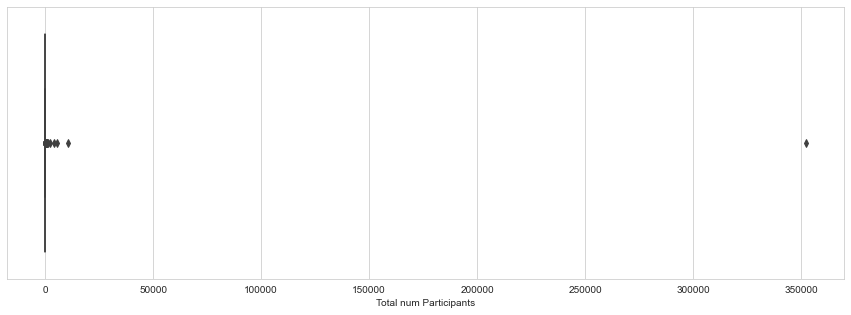

In [50]:
plt.figure(figsize=(15,5))
sns.boxplot(x=df_with_user_study["Total num Participants"]);

Removed 1 outlier(s) (0.2% of 477)


Index                                           Author  \
132    133  Qisheng Li, Krzysztof Gajos, Katharina Reinecke   

                                                 Title  \
132  Volunteer-Based Online Studies With Older Adul...   

                         DOI  
132  10.1145/3234695.3236360

Descriptive stats for paper dataset (N=476)
count      476.000000
mean        91.548319
std        592.755130
min          0.000000
25%         11.000000
50%         18.000000
75%         39.250000
max      10721.000000
Name: Total num Participants, dtype: float64

Box plot of participants for 476 papers


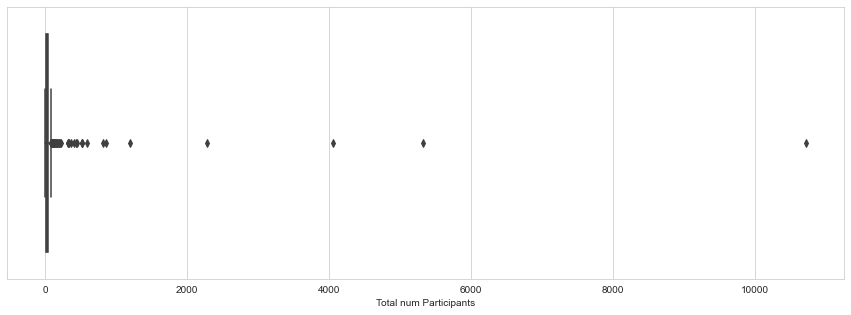


Histogram of participants for 476 papers


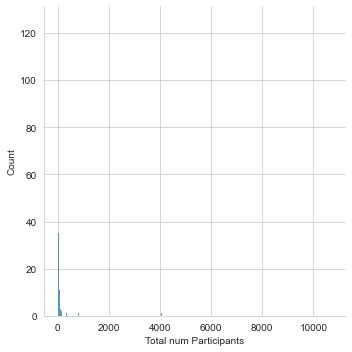


Histogram with num_participants <= 200 (N=456)


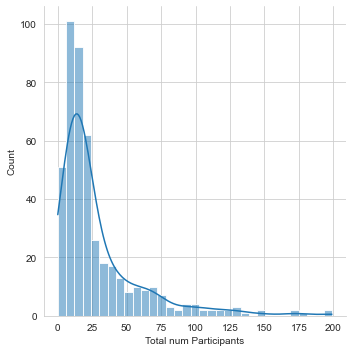

In [51]:
df_user_studies_sans_outliers = df_with_user_study[df_with_user_study["Total num Participants"] < 50000]

analyze_num_participant_data(df_user_studies_sans_outliers)

Num participant analysis without crowdworker papers:
Removed 15 outlier(s) (3.1% of 477)


Index                                             Author  \
12      13                     Walter Lasecki, Jeffrey Bigham   
45      46  Raymond Fok, Harmanpreet Kaur, Skanda Palani, ...   
61      62            Jeffrey Bigham, Irene Lin, Saiph Savage   
132    133    Qisheng Li, Krzysztof Gajos, Katharina Reinecke   
144    145  Abigale Stangl, Esha Kothari, Suyog Jain, Tom ...   
223    224                     Prathik Gadde, Davide Bolchini   
300    301  Xiaojuan Ma and Christiane Fellbaum and Perry ...   
313    314  Yu Zhong, Walter Lasecki, Erin Brady, Jeffrey ...   
348    349  Walter Lasecki, Phyo Thiha, Yu Zhong, Erin Bra...   
354    355         Kotaro Hara and Vicki Le and Jon Froehlich   
389    390  Halley Profita and Reem Albaghli and Leah Find...   
469    470                         Edward Kim, Kathleen McCoy   
478    479  Mohit Jain, Rohun Tripathi, Ishita Bhansali, P...   
491    492  Manaswi Saha and Michael Saugstad and Hanuma T...   
501    502  Kotaro Hara, Shiri Azenkot, Megan Campbell, Cy...   

                                                 Title  \
12   Online quality control for real-time crowd cap...   
45   Towards More Robust Speech Interactions for De...   
61   The Effects of "Not Knowing What You Don't Kno...   
132  Volunteer-Based Online Studies With Older Adul...   
144  BrowseWithMe An Online Clothes Shopping Assist...   
223  From screen reading to aural glancing towards ...   
300  SoundNet investigating a language composed of ...   
313  RegionSpeak Quick Comprehensive Spatial Descri...   
348  Answering visual questions with conversational...   
354  Combining crowdsourcing and google street view...   
389  The AT Effect How Disability Affects the Perce...   
469  Multimodal Deep Learning using Images and Text...   
478  Automatic Generation and Evaluation of Usable ...   
491  Project Sidewalk A Web-based Crowdsourcing Too...   
501  Improving public transit accessibility for bli...   

                         DOI  
12   10.1145/2384916.2384942  
45   10.1145/3234695.3236343  
61   10.1145/3132525.3132533  
132  10.1145/3234695.3236360  
144  10.1145/3234695.3236337  
223  10.1145/2661334.2661363  
300  10.1145/1753326.1753620  
313  10.1145/2702123.2702437  
348  10.1145/2513383.2517033  
354  10.1145/2470654.2470744  
389  10.1145/2858036.2858130  
469  10.1145/3234695.3236357  
478  10.1145/3308561.3353777  
491  10.1145/3290605.3300292  
501  10.1145/2513383.2513448

Descriptive stats for paper dataset (N=462)
count      462.00000
mean        82.04329
std        589.29712
min          0.00000
25%         11.00000
50%         18.00000
75%         36.00000
max      10721.00000
Name: Total num Participants, dtype: float64

Box plot of participants for 462 papers


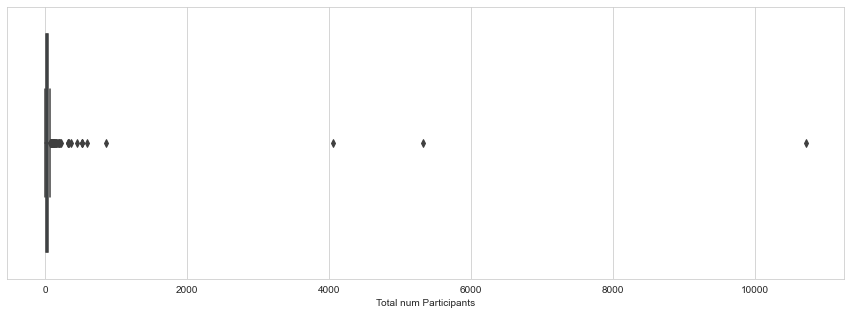


Histogram of participants for 462 papers


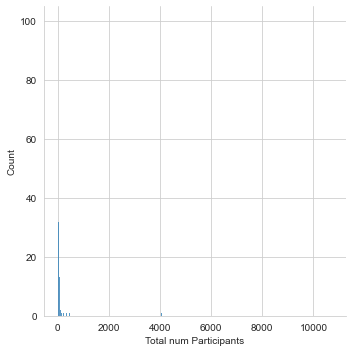


Histogram with num_participants <= 200 (N=447)


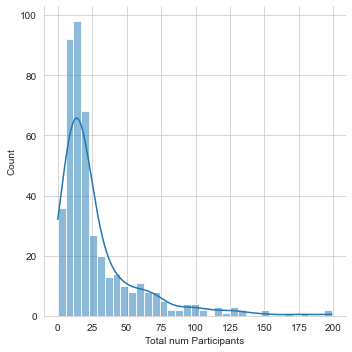

In [52]:
df_user_studies_sans_crowdworkers = df_with_user_study[df_with_user_study['ParticipantGroup_Other_Crowdworker'] != 1]
print("Num participant analysis without crowdworker papers:")
analyze_num_participant_data(df_user_studies_sans_crowdworkers)

## Analysis by participant group

In [53]:
# Setup group col vars for easy reference
numparticipant_group_count_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Count" in col]
numparticipant_group_population_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Population" in col]

In [54]:
# Determine what population group codes exist
map_population_groups = dict()
for index, row in df_with_user_study.iterrows():
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            population_code = row[numparticipant_group_population_col]
            if population_code not in map_population_groups:
                map_population_groups[population_code] = 0
            map_population_groups[population_code] = map_population_groups[population_code] + 1
            
print(f'Found {len(map_population_groups)} population groups')

df_map_population_groups = pd.DataFrame.from_dict(map_population_groups, orient='index', columns=['Num Papers'])

display(df_map_population_groups.sort_values(by='Num Papers', ascending=False))

population_groups = list(map_population_groups.keys())

Found 37 population groups


Num Papers
0                                                         1644
BVI                                                        209
NonDisabled                                                109
Motor/Physical                                              61
Specialists                                                 49
Caregivers                                                  45
DHH                                                         37
Older Adult NonDisabled                                     29
Cognitive                                                   29
Autism                                                      25
Teachers                                                    24
Other                                                       19
Crowdworkers                                                15
Therapists                                                  14
Other-Disabled                                              13
Older Adult Disabled                                        11
IDD                                                         10
Other-Signers                                               10
Other-CVD                                                    7
General DA                                                   5
Other-Mental health                                          3
Other-Developers                                             2
Specialists/Teachers                                         1
Other-Family members                                         1
Older Adult                                                  1
Other-Garden show employees                                  1
Other-Children                                               1
Other-Engineers or interaction designers                     1
Unclear                                                      1
Other-Students, technology instructor                        1
Other-Special education students with multiple ...           1
Other-Designers/developers                                   1
Other-Administrators                                         1
Other-Visual and/or motor                                    1
Other-ASL students                                           1
Other-Students with web accessibility knowledge              1
Other-Students, teachers                                     1

In [55]:
# Create a Pandas table of papers with participant groups
additional_metadata_cols = (['Index', 'Title', 'Author', 'DOI'])
set_additional_metadata_cols = set(additional_metadata_cols)
participant_cnt_cols = additional_metadata_cols + population_groups
df_participant_counts = pd.DataFrame(columns=participant_cnt_cols)

unclear_cnt = 0
for index, row in df_with_user_study.iterrows():
    map_participant_row = dict.fromkeys(participant_cnt_cols, None)
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            population_code = row[numparticipant_group_population_col]
          
            num_participant_count_col = numparticipant_group_population_col.replace('_Population', '_Count')
            
            num_participant_for_this_population = row[num_participant_count_col]
            
            if str(num_participant_for_this_population).lower() != 'unclear':   
                #print(numparticipant_group_population_col, population_code, num_participant_count_col, num_participant_for_this_population)
                map_participant_row[population_code] = (num_participant_for_this_population)
            else:
                unclear_cnt += 1
    
    map_participant_row['Index'] = row['Index']
    map_participant_row['Title'] = row['Title']
    map_participant_row['Author'] = row['Author']
    map_participant_row['DOI'] = row['DOI']
    df_participant_counts = df_participant_counts.append(map_participant_row, ignore_index=True)

# make sure all the population count columns are numeric
df_participant_counts[population_groups] = df_participant_counts[population_groups].apply(pd.to_numeric)

In [56]:
display(df_participant_counts)

Index                                              Title  \
0       1  The Tactile Graphics Helper Providing Audio Cl...   
1       2  "Occupational Therapy is Making": Clinical Rap...   
2       3  Evaluating quality and comprehension of real-t...   
3       4  LucentMaps 3D Printed Audiovisual Tactile Maps...   
4       5  Understanding and Designing for Deaf or Hard o...   
..    ...                                                ...   
472   502  Improving public transit accessibility for bli...   
473   503  "Is Someone There? Do They Have a Gun" How Vis...   
474   504  Incorporating Social Factors in Accessible Des...   
475   505  Voice Telephony for Individuals with Hearing L...   
476   506  Gesture-based Interaction for Individuals with...   

                                                Author  \
0                       Giovanni Fusco, Valerie Morash   
1    Megan Hofmann and Kristin Williams and Toni Ka...   
2    Jessica Tran, Joy Kim, Jaehong Chon, Eve Riski...   
3                                      Timo Götzelmann   
4    Sooyeon Lee and Bjorn Hubert-Wallander and Mol...   
..                                                 ...   
472  Kotaro Hara, Shiri Azenkot, Megan Campbell, Cy...   
473  Stacy Branham, Ali Abdolrahmani, William Easle...   
474     Kristen Shinohara, Jacob Wobbrock, Wanda Pratt   
475  Linda Kozma-Spytek, Paula Tucker, Christian Vo...   
476  Sumita Sharma, Saurabh Srivastava, Krishnaveni...   

                         DOI  Specialists   BVI    0  NonDisabled  \
0    10.1145/2700648.2809868          2.0   3.0  0.0          NaN   
1    10.1145/3290605.3300544          4.0   NaN  0.0          NaN   
2    10.1145/2049536.2049558          NaN   NaN  0.0         39.0   
3    10.1145/2982142.2982163          NaN   9.0  0.0          NaN   
4    10.1145/3290605.3300759          NaN   NaN  0.0          NaN   
..                       ...          ...   ...  ...          ...   
472  10.1145/2513383.2513448          NaN  18.0  0.0          NaN   
473  10.1145/3132525.3132534          NaN  68.0  0.0          NaN   
474  10.1145/3234695.3236346          NaN   5.0  0.0          5.0   
475  10.1145/3308561.3353796          NaN   NaN  0.0         12.0   
476  10.1145/2982142.2982166          NaN   NaN  0.0          NaN   

     Other-Signers    DHH  ...  General DA  \
0              NaN    NaN  ...         NaN   
1              NaN    NaN  ...         NaN   
2             56.0    NaN  ...         NaN   
3              NaN    NaN  ...         NaN   
4              NaN    5.0  ...         NaN   
..             ...    ...  ...         ...   
472            NaN    NaN  ...         NaN   
473            NaN    NaN  ...         NaN   
474            NaN    NaN  ...         NaN   
475            NaN  114.0  ...         NaN   
476            NaN    NaN  ...         NaN   

     Other-Special education students with multiple learning challenges  \
0                                                  NaN                    
1                                                  NaN                    
2                                                  NaN                    
3                                                  NaN                    
4                                                  NaN                    
..                                                 ...                    
472                                                NaN                    
473                                                NaN                    
474                                                NaN                    
475                                                NaN                    
476                                                NaN                    

     Specialists/Teachers  Unclear  Other-Engineers or interaction designers  \
0                     NaN      NaN                                       NaN   
1                     NaN      NaN                                       NaN   
2              

In [57]:
pd.options.display.float_format = '{:.2f}'.format
display(df_participant_counts.describe())
pd.options.display.float_format = None

Specialists     BVI      0  NonDisabled  Other-Signers    DHH  \
count        44.00  208.00 475.00       105.00          10.00  35.00   
mean         14.93   88.79   0.00        97.77          53.90  44.46   
std          21.15  633.09   0.00       440.42          64.09  54.68   
min           1.00    1.00   0.00         2.00          11.00   1.00   
25%           3.00    8.00   0.00         9.00          18.50  10.50   
50%           5.50   13.00   0.00        16.00          23.50  28.00   
75%          12.25   20.00   0.00        35.00          48.50  52.00   
max          80.00 7398.00   0.00      3323.00         195.00 284.00   

       Other-Students with web accessibility knowledge  \
count                                             1.00   
mean                                              4.00   
std                                                nan   
min                                               4.00   
25%                                               4.00   
50%                                               4.00   
75%                                               4.00   
max                                               4.00   

       Older Adult NonDisabled  Caregivers  Cognitive  ...  General DA  \
count                    28.00       34.00      29.00  ...        4.00   
mean                     39.64       11.00      40.34  ...       24.00   
std                      94.89       11.05      74.28  ...       22.02   
min                       4.00        1.00       3.00  ...        3.00   
25%                      12.00        4.00       6.00  ...       14.25   
50%                      20.00        7.50      16.00  ...       19.00   
75%                      35.25       12.75      39.00  ...       28.75   
max                     519.00       43.00     328.00  ...       55.00   

       Other-Special education students with multiple learning challenges  \
count                                               1.00                    
mean                                                6.00                    
std                                                  nan                    
min                                                 6.00                    
25%                                                 6.00                    
50%                                                 6.00                    
75%                                                 6.00                    
max                                                 6.00                    

       Specialists/Teachers  Unclear  \
count                  1.00     1.00   
mean                   9.00    52.00   
std                     nan      nan   
min                    9.00    52.00   
25%                    9.00    52.00   
50%                    9.00    52.00   
75%                    9.00    52.00   
max                    9.00    52.00   

       Other-Engineers or interaction designers  Other-Children  \
count                                      1.00            0.00   
mean                                       7.00             nan   
std                                         nan             nan   
min                                        7.00             nan   
25%                                        7.00             nan   
50%                                        7.00             nan   
75%                                        7.00             nan   
max                                        7.00             nan   

       Other-Garden show employees  Older Adult  Other-Family members  \
count                         1.00         1.00                  1.00   
mean                          4.00        14.00                  6.00   
std                            nan          nan                   nan   
min                           4.00        14.00                  6.00   
25%                           4.00        14.00                  6.00   
50%                           4.00        14.00                  6.00  

## Analysis by consolidated participant group

In [58]:
# create higher-level participant group groupings
set_population_groups = set(population_groups)
other_cols = [col for col in set_population_groups if "Other" in col or "Unclear" in col]
set_population_groups = (set_population_groups - set(other_cols))
older_adult_cols = [col for col in set_population_groups if "Adult" in col]
set_population_groups = (set_population_groups - set(older_adult_cols))
specialist_cols = [col for col in set_population_groups if "Teacher" in col or
                                                           "Therapist" in col or
                                                           "Specialist" in col]
set_population_groups = (set_population_groups - set(specialist_cols))

print(f"{len(other_cols)} 'Other' columns:")
print(other_cols)
print()
print(f"{len(older_adult_cols)} 'Adult' columns:")
print(older_adult_cols)
print()
print(f"{len(specialist_cols)} 'Teacher, Therapist, Specialist' columns:")
print(specialist_cols)
print()
print(f"We have {len(set_population_groups)} remaining groups:")
print(set_population_groups)

19 'Other' columns:
['Other-Family members', 'Other', 'Other-Designers/developers', 'Other-Engineers or interaction designers', 'Other-Mental health', 'Other-Visual and/or motor', 'Other-Developers', 'Other-ASL students', 'Other-Students with web accessibility knowledge', 'Other-Children', 'Other-Signers', 'Other-Students, technology instructor', 'Other-CVD', 'Unclear', 'Other-Administrators', 'Other-Disabled', 'Other-Garden show employees', 'Other-Special education students with multiple learning challenges', 'Other-Students, teachers']

3 'Adult' columns:
['Older Adult NonDisabled', 'Older Adult Disabled', 'Older Adult']

4 'Teacher, Therapist, Specialist' columns:
['Specialists', 'Therapists', 'Teachers', 'Specialists/Teachers']

We have 11 remaining groups:
{'Cognitive', 'DHH', 'Caregivers', 'General DA', 'Autism', 'NonDisabled', 'Motor/Physical', 'BVI', '0', 'Crowdworkers', 'IDD'}


In [59]:
# Now condense the number of participant groups into the following categories
df_participant_cnts_consolidated = df_participant_counts.copy(deep=True)

df_participant_cnts_consolidated['Combined Other'] = df_participant_counts[other_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated['Combined Other'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated['Combined Adult'] = df_participant_counts[older_adult_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated['Combined Adult'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated['Combined Specialist'] = df_participant_counts[specialist_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated['Combined Specialist'].replace(0, np.nan, inplace=True)

df_participant_cnts_consolidated.drop(other_cols, axis=1, inplace=True)
df_participant_cnts_consolidated.drop(older_adult_cols, axis=1, inplace=True)
df_participant_cnts_consolidated.drop(specialist_cols, axis=1, inplace=True)

pd.options.display.float_format = '{:.1f}'.format
display(df_participant_cnts_consolidated.describe())
pd.options.display.float_format = None

BVI     0  NonDisabled   DHH  Caregivers  Cognitive  IDD  \
count  208.0 475.0        105.0  35.0        34.0       29.0 10.0   
mean    88.8   0.0         97.8  44.5        11.0       40.3 16.4   
std    633.1   0.0        440.4  54.7        11.1       74.3 13.0   
min      1.0   0.0          2.0   1.0         1.0        3.0  2.0   
25%      8.0   0.0          9.0  10.5         4.0        6.0 10.0   
50%     13.0   0.0         16.0  28.0         7.5       16.0 11.5   
75%     20.0   0.0         35.0  52.0        12.8       39.0 20.2   
max   7398.0   0.0       3323.0 284.0        43.0      328.0 48.0   

       Crowdworkers  Motor/Physical  Autism  General DA  Combined Other  \
count          13.0            61.0    23.0         4.0            61.0   
mean        27500.0            15.3    12.9        24.0            47.3   
std         97490.3            17.9    16.6        22.0           103.3   
min            15.0             1.0     2.0         3.0             1.0   
25%            42.0             5.0     5.5        14.2             6.0   
50%           153.0            10.0     9.0        19.0            11.0   
75%           797.0            16.0    10.5        28.8            28.0   
max        351960.0           102.0    75.0        55.0           566.0   

       Combined Adult  Combined Specialist  
count            38.0                 69.0  
mean             32.8                 14.2  
std              82.5                 18.3  
min               2.0                  1.0  
25%               8.5                  3.0  
50%              15.0                  7.0  
75%              26.8                 14.0  
max             519.0                 80.0

In [60]:
# Calculate stats for paper
for col in df_participant_cnts_consolidated.columns:
    if col not in set_additional_metadata_cols:
        s = df_participant_cnts_consolidated[col]
        quantile75 = s.quantile(0.75)
        quantile25 = s.quantile(0.25)
        print(f"{col} (N={s.count()}): Median: {s.median()} Mean: {s.mean():.1f}"
              f" Stdev: {s.std():.1f} IQR: {quantile75 - quantile25} Range: {s.min()} - {s.max()}")

BVI (N=208): Median: 13.0 Mean: 88.8 Stdev: 633.1 IQR: 12.0 Range: 1.0 - 7398.0
0 (N=475): Median: 0.0 Mean: 0.0 Stdev: 0.0 IQR: 0.0 Range: 0.0 - 0.0
NonDisabled (N=105): Median: 16.0 Mean: 97.8 Stdev: 440.4 IQR: 26.0 Range: 2.0 - 3323.0
DHH (N=35): Median: 28.0 Mean: 44.5 Stdev: 54.7 IQR: 41.5 Range: 1.0 - 284.0
Caregivers (N=34): Median: 7.5 Mean: 11.0 Stdev: 11.1 IQR: 8.75 Range: 1.0 - 43.0
Cognitive (N=29): Median: 16.0 Mean: 40.3 Stdev: 74.3 IQR: 33.0 Range: 3.0 - 328.0
IDD (N=10): Median: 11.5 Mean: 16.4 Stdev: 13.0 IQR: 10.25 Range: 2.0 - 48.0
Crowdworkers (N=13): Median: 153.0 Mean: 27500.0 Stdev: 97490.3 IQR: 755.0 Range: 15.0 - 351960.0
Motor/Physical (N=61): Median: 10.0 Mean: 15.3 Stdev: 17.9 IQR: 11.0 Range: 1.0 - 102.0
Autism (N=23): Median: 9.0 Mean: 12.9 Stdev: 16.6 IQR: 5.0 Range: 2.0 - 75.0
General DA (N=4): Median: 19.0 Mean: 24.0 Stdev: 22.0 IQR: 14.5 Range: 3.0 - 55.0
Combined Other (N=61): Median: 11.0 Mean: 47.3 Stdev: 103.3 IQR: 22.0 Range: 1.0 - 566.0
Combined 

<AxesSubplot:>

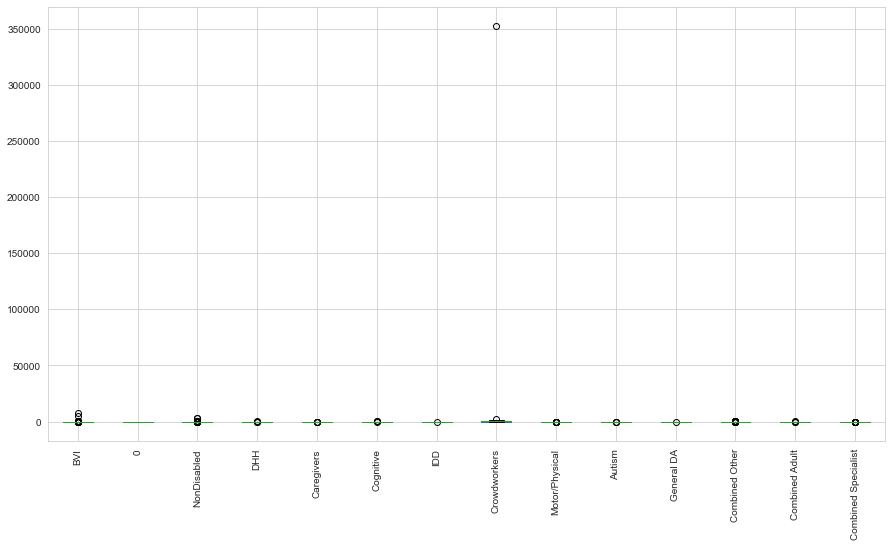

In [61]:
# Plot with outliers...
df_participant_cnts_consolidated.boxplot(figsize=(15,8),rot=90)

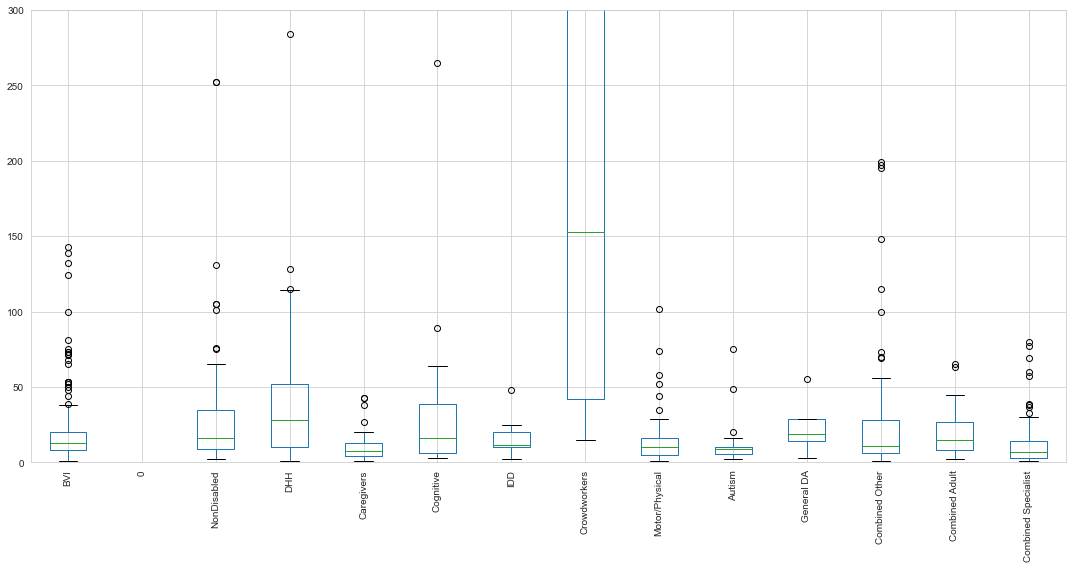

In [62]:
# Plot and zoom in on y-axis to better investigate/assess graph
fig, ax = plt.subplots(1, figsize=(15,8))
df_participant_cnts_consolidated.boxplot(ax=ax, rot=90)
ax.set_ylim(0, 300) # zoom in
plt.tight_layout()

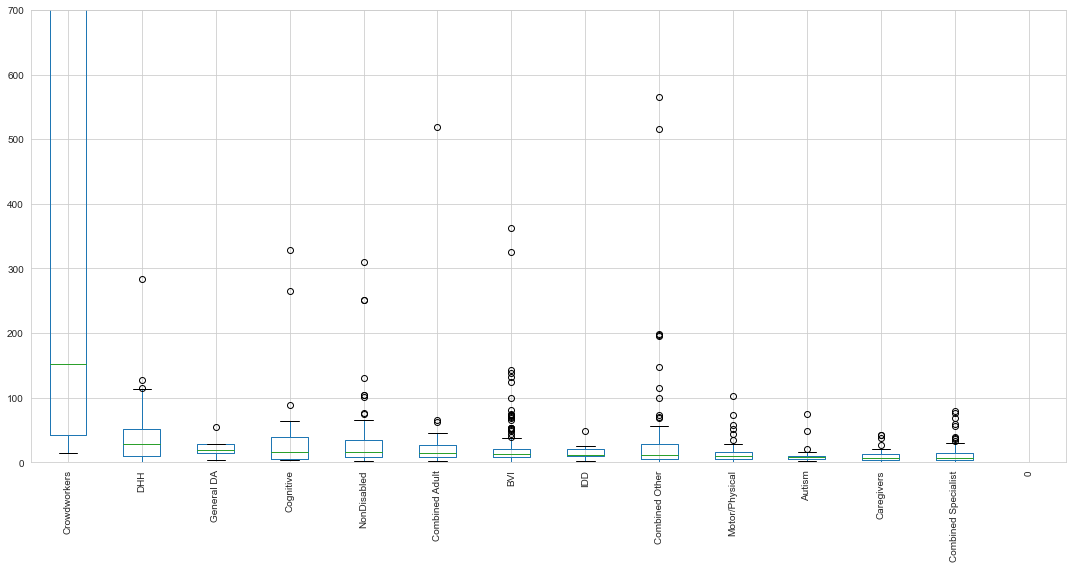

In [63]:
med = df_participant_cnts_consolidated.median()
med = med.sort_values(ascending=False)
sorted_df = df_participant_cnts_consolidated[med.index]
#display(sorted_df)

fig, ax = plt.subplots(1, figsize=(15,8))
sorted_df.boxplot(ax=ax, rot=90)
ax.set_ylim(0, 700) # zoom in
plt.tight_layout()

In [64]:
display(df_participant_cnts_consolidated)

Index                                              Title  \
0       1  The Tactile Graphics Helper Providing Audio Cl...   
1       2  "Occupational Therapy is Making": Clinical Rap...   
2       3  Evaluating quality and comprehension of real-t...   
3       4  LucentMaps 3D Printed Audiovisual Tactile Maps...   
4       5  Understanding and Designing for Deaf or Hard o...   
..    ...                                                ...   
472   502  Improving public transit accessibility for bli...   
473   503  "Is Someone There? Do They Have a Gun" How Vis...   
474   504  Incorporating Social Factors in Accessible Des...   
475   505  Voice Telephony for Individuals with Hearing L...   
476   506  Gesture-based Interaction for Individuals with...   

                                                Author  \
0                       Giovanni Fusco, Valerie Morash   
1    Megan Hofmann and Kristin Williams and Toni Ka...   
2    Jessica Tran, Joy Kim, Jaehong Chon, Eve Riski...   
3                                      Timo Götzelmann   
4    Sooyeon Lee and Bjorn Hubert-Wallander and Mol...   
..                                                 ...   
472  Kotaro Hara, Shiri Azenkot, Megan Campbell, Cy...   
473  Stacy Branham, Ali Abdolrahmani, William Easle...   
474     Kristen Shinohara, Jacob Wobbrock, Wanda Pratt   
475  Linda Kozma-Spytek, Paula Tucker, Christian Vo...   
476  Sumita Sharma, Saurabh Srivastava, Krishnaveni...   

                         DOI   BVI    0  NonDisabled    DHH  Caregivers  \
0    10.1145/2700648.2809868   3.0  0.0          NaN    NaN         NaN   
1    10.1145/3290605.3300544   NaN  0.0          NaN    NaN         NaN   
2    10.1145/2049536.2049558   NaN  0.0         39.0    NaN         NaN   
3    10.1145/2982142.2982163   9.0  0.0          NaN    NaN         NaN   
4    10.1145/3290605.3300759   NaN  0.0          NaN    5.0         NaN   
..                       ...   ...  ...          ...    ...         ...   
472  10.1145/2513383.2513448  18.0  0.0          NaN    NaN         NaN   
473  10.1145/3132525.3132534  68.0  0.0          NaN    NaN         NaN   
474  10.1145/3234695.3236346   5.0  0.0          5.0    NaN         NaN   
475  10.1145/3308561.3353796   NaN  0.0         12.0  114.0         NaN   
476  10.1145/2982142.2982166   NaN  0.0          NaN    NaN         NaN   

     Cognitive   IDD  Crowdworkers  Motor/Physical  Autism  General DA  \
0          NaN   NaN           NaN             NaN     NaN         NaN   
1          NaN   NaN           NaN             NaN     NaN         NaN   
2          NaN   NaN           NaN             NaN     NaN         NaN   
3          NaN   NaN           NaN             NaN     NaN         NaN   
4          NaN   NaN           NaN             NaN     NaN         NaN   
..         ...   ...           ...             ...     ...         ...   
472        NaN   NaN         153.0             NaN     NaN         NaN   
473        NaN   NaN           NaN             NaN     NaN         NaN   
474        NaN   NaN           NaN             NaN     NaN         NaN   
475        NaN   NaN           NaN             NaN     NaN         NaN   
476        NaN  18.0           NaN             NaN     NaN         NaN   

     Combined Other  Combined Adult  Combined Specialist  
0               NaN             NaN                  2.0  
1               NaN             NaN                  4.0  
2              56.0             NaN                  NaN  
3               NaN             NaN                  NaN  
4               NaN             NaN                  NaN  
..              ...             ...                  ...  
472             NaN             NaN                  NaN  
473             NaN             NaN                  NaN  
474             5.0             NaN                  NaN  
475             NaN             NaN                  NaN  
476             NaN             NaN                  NaN  

[477 rows x 18 columns]

DHH  General DA   Cognitive  NonDisabled  Combined Adult  \
count   35.000000    4.000000   29.000000   105.000000       38.000000   
mean    44.457143   24.000000   40.344828    97.771429       32.789474   
std     54.683766   22.015146   74.283855   440.417443       82.491001   
min      1.000000    3.000000    3.000000     2.000000        2.000000   
25%     10.500000   14.250000    6.000000     9.000000        8.500000   
50%     28.000000   19.000000   16.000000    16.000000       15.000000   
75%     52.000000   28.750000   39.000000    35.000000       26.750000   
max    284.000000   55.000000  328.000000  3323.000000      519.000000   

               BVI        IDD  Combined Other  Motor/Physical     Autism  \
count   208.000000  10.000000       61.000000       61.000000  23.000000   
mean     88.788462  16.400000       47.278689       15.278689  12.913043   
std     633.085385  13.005982      103.342333       17.857894  16.558198   
min       1.000000   2.000000        1.000000        1.000000   2.000000   
25%       8.000000  10.000000        6.000000        5.000000   5.500000   
50%      13.000000  11.500000       11.000000       10.000000   9.000000   
75%      20.000000  20.250000       28.000000       16.000000  10.500000   
max    7398.000000  48.000000      566.000000      102.000000  75.000000   

       Caregivers  Combined Specialist      0  
count   34.000000            69.000000  475.0  
mean    11.000000            14.217391    0.0  
std     11.050847            18.304507    0.0  
min      1.000000             1.000000    0.0  
25%      4.000000             3.000000    0.0  
50%      7.500000             7.000000    0.0  
75%     12.750000            14.000000    0.0  
max     43.000000            80.000000    0.0

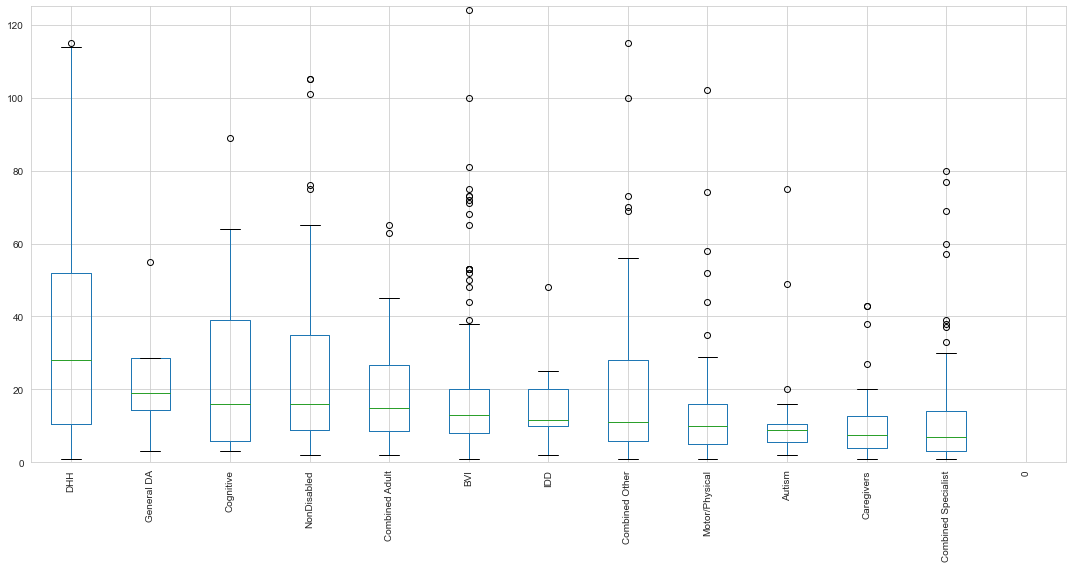

In [65]:
df_participant_cnts_tmp = df_participant_cnts_consolidated.drop('Crowdworkers', axis=1)
med = df_participant_cnts_tmp.median()
med = med.sort_values(ascending=False)
sorted_df = df_participant_cnts_tmp[med.index]
#display(sorted_df)

fig, ax = plt.subplots(1, figsize=(15,8))
sorted_df.boxplot(ax=ax, rot=90)
ax.set_ylim(0, 125) # zoom in
plt.tight_layout()

display(sorted_df.describe())

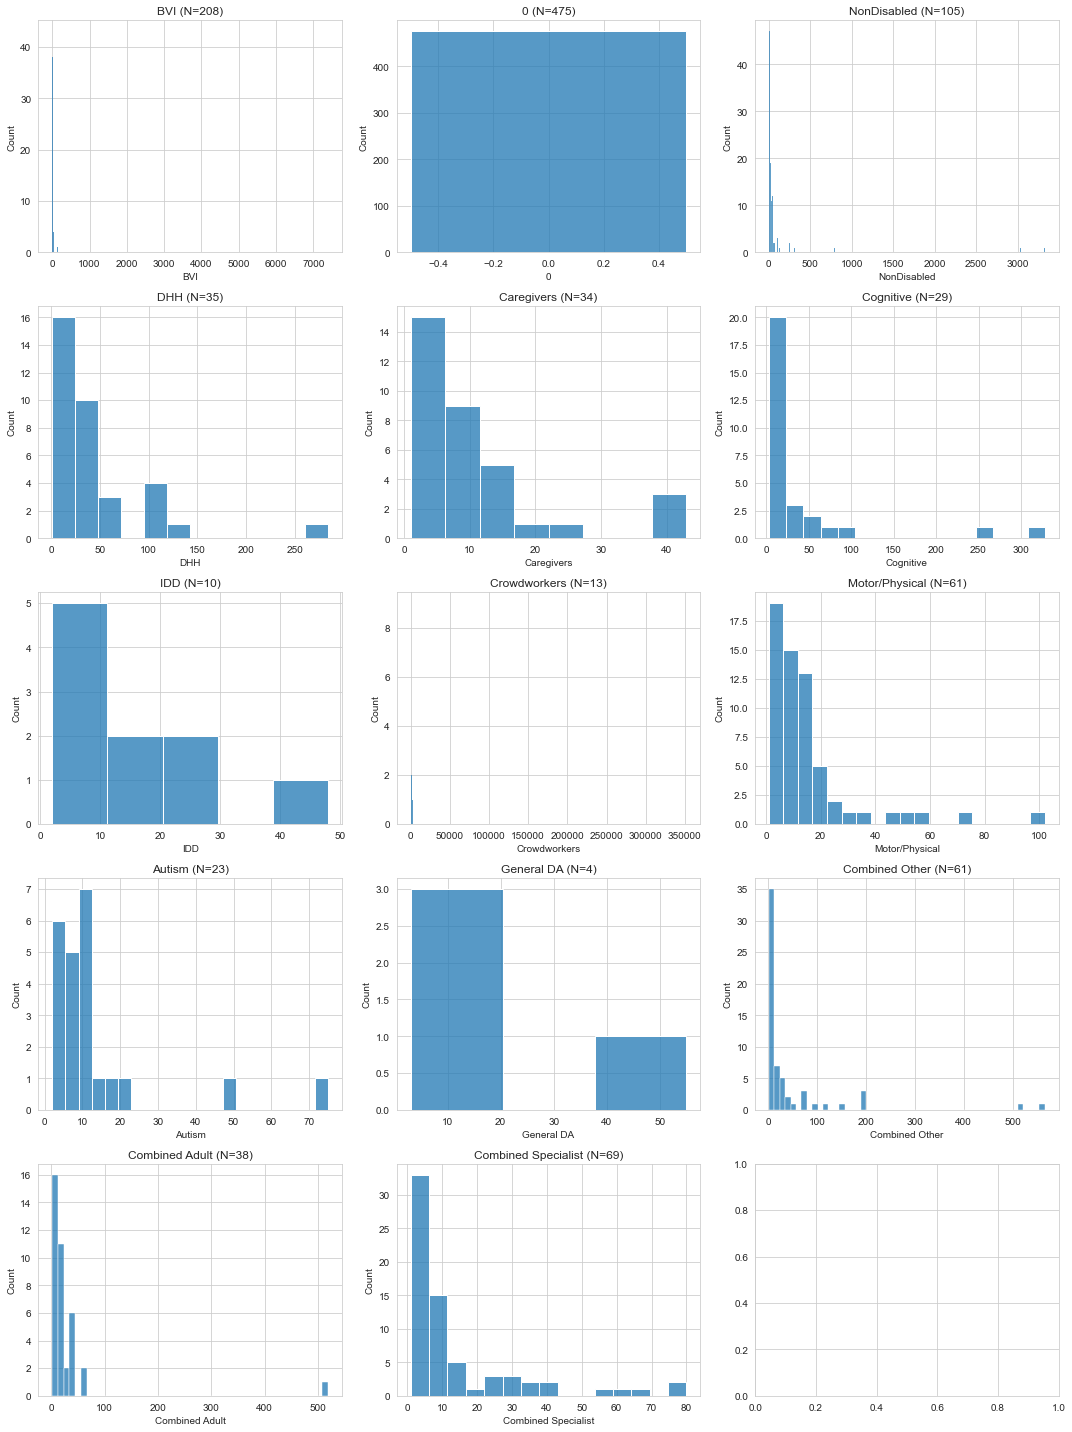

In [66]:
num_ax_rows = 5
num_ax_cols = 3
fig, axes = plt.subplots(num_ax_rows, num_ax_cols, figsize=(15, 20))
i = 0
for col in df_participant_cnts_consolidated.columns:
    if col not in set_additional_metadata_cols:
        row_idx = i // num_ax_cols
        col_idx = i % num_ax_cols
        sns.histplot(data=df_participant_cnts_consolidated, x=col, ax=axes[row_idx, col_idx])
        
        # Another way to plot this:
        # axes[row_idx, col_idx].hist(df_participant_cnts_consolidated[col], bins=20, range=(0, 200))
        axes[row_idx, col_idx].set_title(f'{col} (N={df_participant_cnts_consolidated[col].count()})')
        
        i += 1

plt.tight_layout()
plt.show()

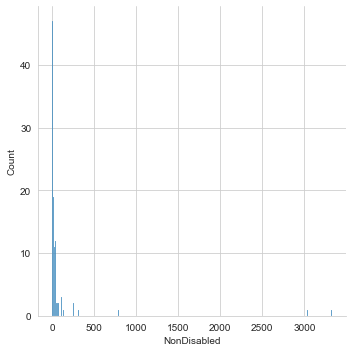

In [67]:
sns.displot(data=df_participant_counts, x="NonDisabled")

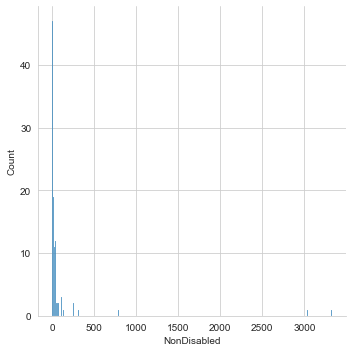

In [68]:
sns.displot(data=df_participant_counts, x="NonDisabled")

## Analysis of older adults and disabled communities
Per Kelly's request ([Issue #61](https://github.com/jonfroehlich/accesslitsurvey/issues/61)) to further consolidate groups into disabled and older adults for num participant analyses

In [69]:
# create higher-level participant group groupings
set_population_groups = set(population_groups)
other_cols = [col for col in set_population_groups if "Other" in col or "Unclear" in col]
set_population_groups = (set_population_groups - set(other_cols))
older_adult_cols = [col for col in set_population_groups if "Adult" in col]
set_population_groups = (set_population_groups - set(older_adult_cols))
specialist_cols = [col for col in set_population_groups if "Teacher" in col or
                                                           "Therapist" in col or
                                                           "Specialist" in col]
set_population_groups = (set_population_groups - set(specialist_cols))
crowdworker_cols = [col for col in set_population_groups if "Crowdworker" in col]
set_population_groups = (set_population_groups - set(crowdworker_cols))
caregiver_cols = [col for col in set_population_groups if "Caregiver" in col]
set_population_groups = (set_population_groups - set(caregiver_cols))
nondisabled_cols = [col for col in set_population_groups if "NonDisabled" in col]
set_population_groups = (set_population_groups - set(nondisabled_cols))
disabled_cols = list(set_population_groups)
set_population_groups = (set_population_groups - set(disabled_cols))

print(f"{len(other_cols)} 'Other' columns:")
print(other_cols)
print()
print(f"{len(older_adult_cols)} 'Adult' columns:")
print(older_adult_cols)
print()
print(f"{len(specialist_cols)} 'Teacher, Therapist, Specialist' columns:")
print(specialist_cols)
print()
print(f"{len(crowdworker_cols)} 'Crowdworker columns:")
print(crowdworker_cols)
print()
print(f"{len(crowdworker_cols)} 'Caregiver columns:")
print(caregiver_cols)
print()
print(f"{len(crowdworker_cols)} 'Nondisabled columns:")
print(nondisabled_cols)
print()
print(f"{len(disabled_cols)} 'Disabled columns:")
print(disabled_cols)
print()
print(f"We have {len(set_population_groups)} remaining groups:")
print(set_population_groups)

19 'Other' columns:
['Other-Family members', 'Other', 'Other-Designers/developers', 'Other-Engineers or interaction designers', 'Other-Mental health', 'Other-Visual and/or motor', 'Other-Developers', 'Other-ASL students', 'Other-Students with web accessibility knowledge', 'Other-Children', 'Other-Signers', 'Other-Students, technology instructor', 'Other-CVD', 'Unclear', 'Other-Administrators', 'Other-Disabled', 'Other-Garden show employees', 'Other-Special education students with multiple learning challenges', 'Other-Students, teachers']

3 'Adult' columns:
['Older Adult NonDisabled', 'Older Adult Disabled', 'Older Adult']

4 'Teacher, Therapist, Specialist' columns:
['Specialists', 'Therapists', 'Teachers', 'Specialists/Teachers']

1 'Crowdworker columns:
['Crowdworkers']

1 'Caregiver columns:
['Caregivers']

1 'Nondisabled columns:
['NonDisabled']

8 'Disabled columns:
['Cognitive', 'DHH', 'General DA', 'Autism', 'Motor/Physical', 'BVI', '0', 'IDD']

We have 0 remaining groups:
set(

In [70]:
# Now condense the number of participant groups into the following categories
df_participant_cnts_consolidated2 = df_participant_counts.copy(deep=True)

df_participant_cnts_consolidated2['Combined Other'] = df_participant_counts[other_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Other'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated2['Combined Adult'] = df_participant_counts[older_adult_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Adult'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated2['Combined Specialist'] = df_participant_counts[specialist_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Specialist'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated2['Combined Disabled'] = df_participant_counts[disabled_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated2['Combined Disabled'].replace(0, np.nan, inplace=True)

df_participant_cnts_consolidated2.drop(other_cols, axis=1, inplace=True)
df_participant_cnts_consolidated2.drop(older_adult_cols, axis=1, inplace=True)
df_participant_cnts_consolidated2.drop(specialist_cols, axis=1, inplace=True)
df_participant_cnts_consolidated2.drop(disabled_cols, axis=1, inplace=True)

pd.options.display.float_format = '{:.1f}'.format
display(df_participant_cnts_consolidated2.describe())
pd.options.display.float_format = None

NonDisabled  Caregivers  Crowdworkers  Combined Other  Combined Adult  \
count        105.0        34.0          13.0            61.0            38.0   
mean          97.8        11.0       27500.0            47.3            32.8   
std          440.4        11.1       97490.3           103.3            82.5   
min            2.0         1.0          15.0             1.0             2.0   
25%            9.0         4.0          42.0             6.0             8.5   
50%           16.0         7.5         153.0            11.0            15.0   
75%           35.0        12.8         797.0            28.0            26.8   
max         3323.0        43.0      351960.0           566.0           519.0   

       Combined Specialist  Combined Disabled  
count                 69.0              366.0  
mean                  14.2               62.0  
std                   18.3              478.8  
min                    1.0                1.0  
25%                    3.0                8.0  
50%                    7.0               13.0  
75%                   14.0               21.0  
max                   80.0             7398.0

In [71]:
# Calculate stats for paper
for col in df_participant_cnts_consolidated2.columns:
    if col not in set_additional_metadata_cols:
        s = df_participant_cnts_consolidated2[col]
        quantile75 = s.quantile(0.75)
        quantile25 = s.quantile(0.25)
        print(f"{col} (N={s.count()}): Median: {s.median()} Mean: {s.mean():.1f}"
              f" Stdev: {s.std():.1f} IQR: {quantile75 - quantile25} Range: {s.min()} - {s.max()}")

NonDisabled (N=105): Median: 16.0 Mean: 97.8 Stdev: 440.4 IQR: 26.0 Range: 2.0 - 3323.0
Caregivers (N=34): Median: 7.5 Mean: 11.0 Stdev: 11.1 IQR: 8.75 Range: 1.0 - 43.0
Crowdworkers (N=13): Median: 153.0 Mean: 27500.0 Stdev: 97490.3 IQR: 755.0 Range: 15.0 - 351960.0
Combined Other (N=61): Median: 11.0 Mean: 47.3 Stdev: 103.3 IQR: 22.0 Range: 1.0 - 566.0
Combined Adult (N=38): Median: 15.0 Mean: 32.8 Stdev: 82.5 IQR: 18.25 Range: 2.0 - 519.0
Combined Specialist (N=69): Median: 7.0 Mean: 14.2 Stdev: 18.3 IQR: 11.0 Range: 1.0 - 80.0
Combined Disabled (N=366): Median: 13.0 Mean: 62.0 Stdev: 478.8 IQR: 13.0 Range: 1.0 - 7398.0


## Analysis of older adults and disabled communities (combined)
And an even more combined set of groups (with adults and disabled communities together)

In [72]:
# create higher-level participant group groupings
set_population_groups = set(population_groups)
other_cols = [col for col in set_population_groups if "Other" in col or "Unclear" in col]
set_population_groups = (set_population_groups - set(other_cols))
specialist_cols = [col for col in set_population_groups if "Teacher" in col or
                                                           "Therapist" in col or
                                                           "Specialist" in col]
set_population_groups = (set_population_groups - set(specialist_cols))
crowdworker_cols = [col for col in set_population_groups if "Crowdworker" in col]
set_population_groups = (set_population_groups - set(crowdworker_cols))
caregiver_cols = [col for col in set_population_groups if "Caregiver" in col]
set_population_groups = (set_population_groups - set(caregiver_cols))
nondisabled_cols = [col for col in set_population_groups if "NonDisabled" == col]
set_population_groups = (set_population_groups - set(nondisabled_cols))
disabled_and_older_adult_cols = list(set_population_groups)
set_population_groups = (set_population_groups - set(disabled_and_older_adult_cols))

print(f"{len(other_cols)} 'Other' columns:")
print(other_cols)
print()
print(f"{len(specialist_cols)} 'Teacher, Therapist, Specialist' columns:")
print(specialist_cols)
print()
print(f"{len(crowdworker_cols)} 'Crowdworker columns:")
print(crowdworker_cols)
print()
print(f"{len(crowdworker_cols)} 'Caregiver columns:")
print(caregiver_cols)
print()
print(f"{len(crowdworker_cols)} 'Nondisabled columns:")
print(nondisabled_cols)
print()
print(f"{len(disabled_and_older_adult_cols)} 'Disabled and older adult columns:")
print(disabled_and_older_adult_cols)
print()
print(f"We have {len(set_population_groups)} remaining groups:")
print(set_population_groups)

19 'Other' columns:
['Other-Family members', 'Other', 'Other-Designers/developers', 'Other-Engineers or interaction designers', 'Other-Mental health', 'Other-Visual and/or motor', 'Other-Developers', 'Other-ASL students', 'Other-Students with web accessibility knowledge', 'Other-Children', 'Other-Signers', 'Other-Students, technology instructor', 'Other-CVD', 'Unclear', 'Other-Administrators', 'Other-Disabled', 'Other-Garden show employees', 'Other-Special education students with multiple learning challenges', 'Other-Students, teachers']

4 'Teacher, Therapist, Specialist' columns:
['Specialists', 'Therapists', 'Teachers', 'Specialists/Teachers']

1 'Crowdworker columns:
['Crowdworkers']

1 'Caregiver columns:
['Caregivers']

1 'Nondisabled columns:
['NonDisabled']

11 'Disabled and older adult columns:
['Cognitive', 'DHH', 'General DA', 'Autism', 'Motor/Physical', 'BVI', 'Older Adult NonDisabled', 'Older Adult', '0', 'Older Adult Disabled', 'IDD']

We have 0 remaining groups:
set()


In [73]:
# Now condense the number of participant groups into the following categories
df_participant_cnts_consolidated3 = df_participant_counts.copy(deep=True)

df_participant_cnts_consolidated3['Combined Other'] = df_participant_counts[other_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated3['Combined Other'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated3['Combined Specialist'] = df_participant_counts[specialist_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated3['Combined Specialist'].replace(0, np.nan, inplace=True)
df_participant_cnts_consolidated3['Combined Disabled and Older Adult'] = df_participant_counts[disabled_cols].sum(axis=1, skipna=True)
df_participant_cnts_consolidated3['Combined Disabled and Older Adult'].replace(0, np.nan, inplace=True)

df_participant_cnts_consolidated3.drop(other_cols, axis=1, inplace=True)
df_participant_cnts_consolidated3.drop(specialist_cols, axis=1, inplace=True)
df_participant_cnts_consolidated3.drop(disabled_and_older_adult_cols, axis=1, inplace=True)

pd.options.display.float_format = '{:.1f}'.format
display(df_participant_cnts_consolidated3.describe())
pd.options.display.float_format = None

NonDisabled  Caregivers  Crowdworkers  Combined Other  \
count        105.0        34.0          13.0            61.0   
mean          97.8        11.0       27500.0            47.3   
std          440.4        11.1       97490.3           103.3   
min            2.0         1.0          15.0             1.0   
25%            9.0         4.0          42.0             6.0   
50%           16.0         7.5         153.0            11.0   
75%           35.0        12.8         797.0            28.0   
max         3323.0        43.0      351960.0           566.0   

       Combined Specialist  Combined Disabled and Older Adult  
count                 69.0                              366.0  
mean                  14.2                               62.0  
std                   18.3                              478.8  
min                    1.0                                1.0  
25%                    3.0                                8.0  
50%                    7.0                               13.0  
75%                   14.0                               21.0  
max                   80.0                             7398.0

In [74]:
# Calculate stats for paper
for col in df_participant_cnts_consolidated3.columns:
    if col not in set_additional_metadata_cols:
        s = df_participant_cnts_consolidated3[col]
        quantile75 = s.quantile(0.75)
        quantile25 = s.quantile(0.25)
        print(f"{col} (N={s.count()}): Median: {s.median()} Mean: {s.mean():.1f}"
              f" Stdev: {s.std():.1f} IQR: {quantile75 - quantile25} Range: {s.min()} - {s.max()}")

NonDisabled (N=105): Median: 16.0 Mean: 97.8 Stdev: 440.4 IQR: 26.0 Range: 2.0 - 3323.0
Caregivers (N=34): Median: 7.5 Mean: 11.0 Stdev: 11.1 IQR: 8.75 Range: 1.0 - 43.0
Crowdworkers (N=13): Median: 153.0 Mean: 27500.0 Stdev: 97490.3 IQR: 755.0 Range: 15.0 - 351960.0
Combined Other (N=61): Median: 11.0 Mean: 47.3 Stdev: 103.3 IQR: 22.0 Range: 1.0 - 566.0
Combined Specialist (N=69): Median: 7.0 Mean: 14.2 Stdev: 18.3 IQR: 11.0 Range: 1.0 - 80.0
Combined Disabled and Older Adult (N=366): Median: 13.0 Mean: 62.0 Stdev: 478.8 IQR: 13.0 Range: 1.0 - 7398.0


# Temporal trends (2010-2019)

## Overall trends

In [75]:
df.groupby(['Year'])['Year'].count() / df_total_papers_per_year.sum(axis=1)

Year
2010    0.106061
2011    0.087156
2012    0.086076
2013    0.102625
2014    0.073022
2015    0.098837
2016    0.080844
2017    0.093207
2018    0.097983
2019    0.129032
dtype: float64

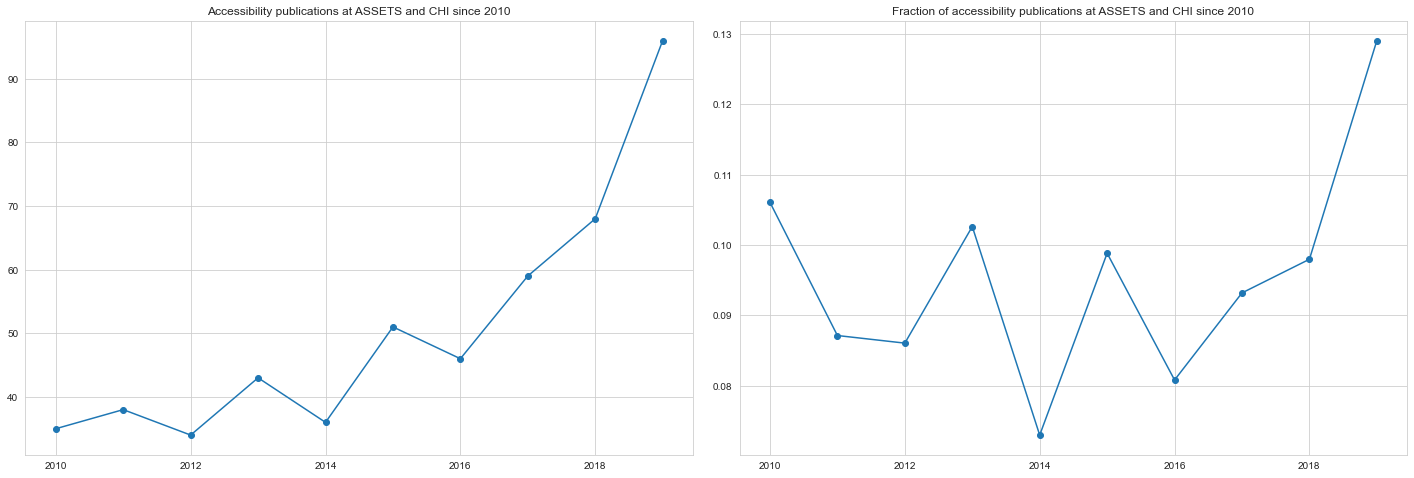

In [76]:
total_pub_cnt_by_year = df.groupby(['Year'])['Year'].count()
total_pub_frac_by_year = df.groupby(['Year'])['Year'].count() / df_total_papers_per_year.sum(axis=1)

f, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].plot(total_pub_cnt_by_year, marker='o', label="Total")
axes[0].set_title("Accessibility publications at ASSETS and CHI since 2010")

axes[1].plot(total_pub_frac_by_year, marker='o', label="Total")
axes[1].set_title("Fraction of accessibility publications at ASSETS and CHI since 2010")
plt.tight_layout(pad=2)

## By publication venue

In [77]:
total_pub_cnt_by_venue_and_year = df.groupby(['Venue', 'Year'])['Year'].count()

# Convert series to a DataFrame for pretty printing
df_pub_cnt_by_venue_and_year = pd.DataFrame(columns=['ASSETS', 'CHI'])
df_pub_cnt_by_venue_and_year['ASSETS'] = total_pub_cnt_by_venue_and_year['ASSETS']
df_pub_cnt_by_venue_and_year['CHI'] = total_pub_cnt_by_venue_and_year['CHI']
display(df_pub_cnt_by_venue_and_year)

ASSETS  CHI
Year             
2010      28    7
2011      27   11
2012      25    9
2013      27   16
2014      28    8
2015      30   21
2016      24   22
2017      33   26
2018      28   40
2019      41   55

In [78]:
# In previous xlsx data files, we found that there were **5** missing rows. This code was the code
# that helped determine this: https://github.com/jonfroehlich/accesslitsurvey/issues/38
# Note: this is now fixed/solved (we added the 5 missing papers)
print("Double checking number of qualitatively coded ASSETS papers vs. total number of ASSETS papers")
df_assets_over_time = pd.DataFrame()
df_assets_over_time['Coded Papers'] = total_pub_cnt_by_venue_and_year['ASSETS']
df_assets_over_time['Total Papers'] = df_total_papers_per_year['ASSETS']
df_assets_over_time['Difference'] = df_assets_over_time['Total Papers'] - df_assets_over_time['Coded Papers']
display(df_assets_over_time)

Double checking number of qualitatively coded ASSETS papers vs. total number of ASSETS papers


Coded Papers  Total Papers  Difference
Year                                        
2010            28            28           0
2011            27            27           0
2012            25            25           0
2013            27            27           0
2014            28            28           0
2015            30            30           0
2016            24            24           0
2017            33            33           0
2018            28            28           0
2019            41            41           0

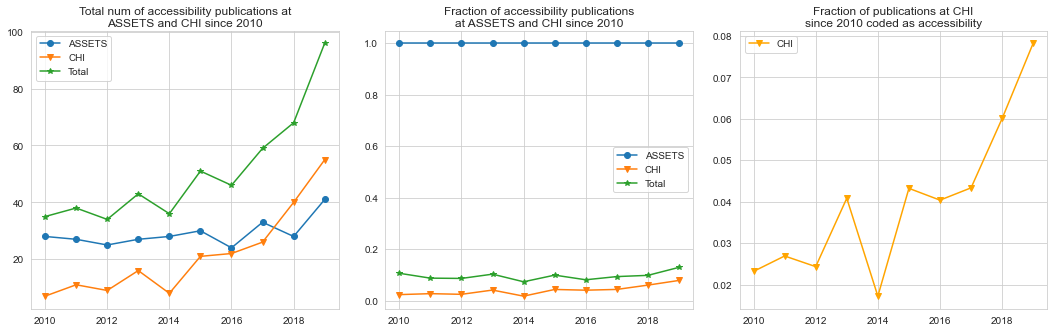

In [79]:
# Graph the results
f, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(total_pub_cnt_by_venue_and_year['ASSETS'], label='ASSETS', marker='o')
axes[0].plot(total_pub_cnt_by_venue_and_year['CHI'], label='CHI', marker='v')
axes[0].plot(total_pub_cnt_by_year, label='Total', marker='*')
axes[0].set_title("Total num of accessibility publications at\nASSETS and CHI since 2010", wrap=True)
axes[0].legend()

#axes[1].plot(total_pub_frac_by_year)
#total_pub_cnt_by_venue_and_year['ASSETS'] / df_total_papers_per_year['ASSETS']
total_pub_frac_by_venue_and_year_assets = total_pub_cnt_by_venue_and_year['ASSETS'] / df_total_papers_per_year['ASSETS']
total_pub_frac_by_venue_and_year_chi = total_pub_cnt_by_venue_and_year['CHI'] / df_total_papers_per_year['CHI']
total_pub_frac_by_venue_and_year = (total_pub_cnt_by_venue_and_year['ASSETS']  + total_pub_cnt_by_venue_and_year['CHI']) / df_total_papers_per_year.sum(axis=1)

axes[1].plot(total_pub_frac_by_venue_and_year_assets, label='ASSETS', marker='o')
axes[1].plot(total_pub_frac_by_venue_and_year_chi, label='CHI', marker='v')
axes[1].plot(total_pub_frac_by_venue_and_year, label='Total', marker='*')
axes[1].set_title("Fraction of accessibility publications\nat ASSETS and CHI since 2010", wrap=True)
axes[1].legend()

axes[2].plot(total_pub_frac_by_venue_and_year_chi, label='CHI', marker='v', color='orange')
axes[2].set_title("Fraction of publications at CHI\nsince 2010 coded as accessibility", wrap=True)
axes[2].legend()

plt.tight_layout(pad=2)

## By code category
Analyze and graph the frequency of sub-codes in each code category over time.

In [80]:
df.groupby(['Venue', 'Year'])['Year'].count()

Venue   Year
ASSETS  2010    28
        2011    27
        2012    25
        2013    27
        2014    28
        2015    30
        2016    24
        2017    33
        2018    28
        2019    41
CHI     2010     7
        2011    11
        2012     9
        2013    16
        2014     8
        2015    21
        2016    22
        2017    26
        2018    40
        2019    55
Name: Year, dtype: int64

In [81]:
# Here's an example of how the sub-code `TargetPopulation_BVI` has occurred over the past 10 years
df[df['TargetPopulation_BVI'] == 1].groupby(['Year', 'TargetPopulation_BVI'])['Year'].count()

KeyError: 'TargetPopulation_BVI'

CommunityOfFocus_BVI  CommunityOfFocus_DHH  CommunityOfFocus_IDD  \
Year                                                                     
2010                    12                     4                     2   
2011                    10                     5                     2   
2012                    14                     4                     0   
2013                    18                     3                     1   
2014                    17                     2                     0   
2015                    22                     6                     1   
2016                    19                     4                     2   
2017                    30                     6                     1   
2018                    34                    11                     2   
2019                    44                    12                     3   

      CommunityOfFocus_MotorPhysical  CommunityOfFocus_Autism  \
Year                                                            
2010                               3                        3   
2011                               7                        2   
2012                               3                        1   
2013                               8                        1   
2014                               9                        2   
2015                               5                        5   
2016                               9                        2   
2017                               7                        8   
2018                               6                        4   
2019                              15                        3   

      CommunityOfFocus_Cognitive  CommunityOfFocus_OlderAdult  \
Year                                                            
2010                           4                            5   
2011                           4                            6   
2012                           3                            6   
2013                           6                            5   
2014                           2                            5   
2015                           6                            4   
2016                           4                            3   
2017                           6                            2   
2018                           4                            3   
2019                           7                            6   

      CommunityOfFocus_GeneralDisability  CommunityOfFocus_Other  
Year                                                              
2010                                   4                       3  
2011                                   7                       5  
2012                                   2                       4  
2013                                   3                       6  
2014                                   3                       1  
2015                                   4                       5  
2016                                   4                       5  
2017                                   2                       4  
2018                                   7                       7  
2019                                  10                       6

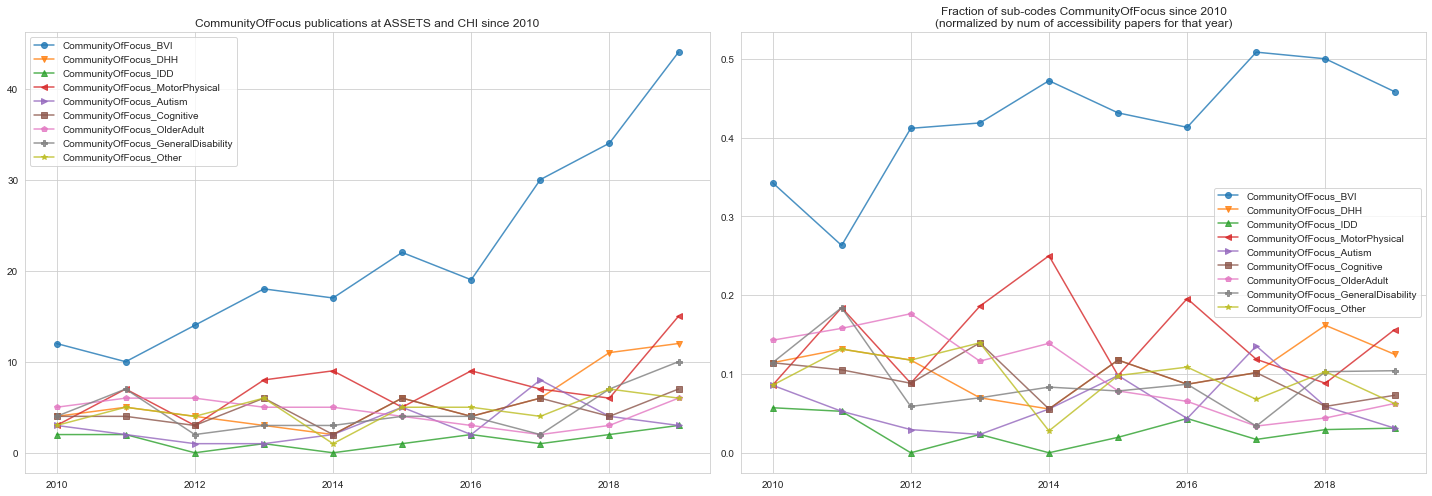

IssueAddressed_IncreaseDigitalAccess  \
Year                                         
2010                                    12   
2011                                    18   
2012                                    17   
2013                                    19   
2014                                    13   
2015                                    22   
2016                                    15   
2017                                    18   
2018                                    21   
2019                                    31   

      IssueAddressed_IncreasePhysicalAccess  \
Year                                          
2010                                      5   
2011                                      5   
2012                                      7   
2013                                      8   
2014                                      8   
2015                                     11   
2016                                     11   
2017                                     12   
2018                                     12   
2019                                     26   

      IssueAddressed_IncreaseIndependence  \
Year                                        
2010                                    3   
2011                                    5   
2012                                    5   
2013                                   10   
2014                                    8   
2015                                    9   
2016                                   12   
2017                                    8   
2018                                   14   
2019                                   19   

      IssueAddressed_IncreaseUnderstandingOfUsers  \
Year                                                
2010                                            6   
2011                                           15   
2012                                            5   
2013                                           13   
2014                                            7   
2015                                           17   
2016                                           14   
2017                                           15   
2018                                           21   
2019                                           26   

      IssueAddressed_HelpWithPersonalInformaticsBehaviorChange  \
Year                                                             
2010                                                  6          
2011                                                  2          
2012                                                  3          
2013                                                  1          
2014                                                  4          
2015                                                  2          
2016                                                  5          
2017                                                  6          
2018                                                  3          
2019                                                  7          

      IssueAddressed_SupportCommunication  IssueAddressed_Other  
Year                                                             
2010                                    7                     3  
2011                                    8                     2  
2012                                    6                     2  
2013                                    6                     4  
2014                                    3                     7  
2015                                    7                     6  
2016                                    5                     6  
2017                                   12                     4  
2018                                   16                     8  
2019                                   11                    17

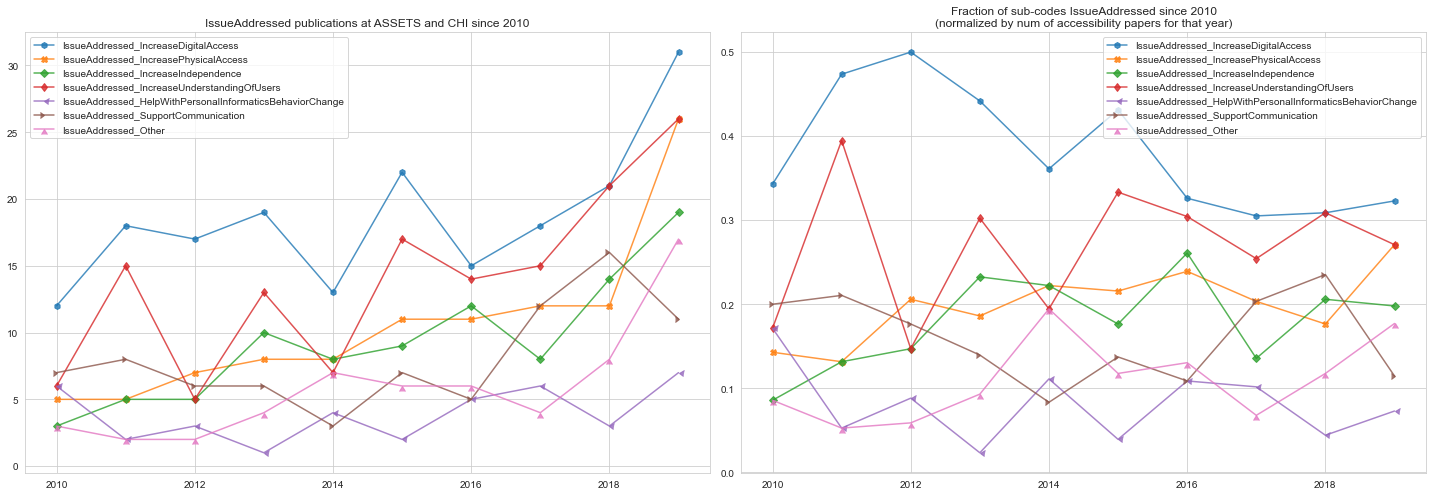

ContributionType_Empirical  ContributionType_Artifact  \
Year                                                          
2010                          16                         24   
2011                          20                         21   
2012                          16                         22   
2013                          27                         23   
2014                          22                         21   
2015                          35                         21   
2016                          26                         26   
2017                          38                         29   
2018                          44                         41   
2019                          61                         53   

      ContributionType_Methodological  ContributionType_Theoretical  \
Year                                                                  
2010                                0                             3   
2011                                2                             4   
2012                                2                             2   
2013                                1                             2   
2014                                1                             0   
2015                                5                             6   
2016                                0                             2   
2017                                1                             7   
2018                                2                             8   
2019                                2                            10   

      ContributionType_Dataset  ContributionType_SurveyContribution  
Year                                                                 
2010                         0                                    0  
2011                         0                                    0  
2012                         0                                    0  
2013                         0                                    0  
2014                         0                                    0  
2015                         1                                    2  
2016                         1                                    0  
2017                         1                                    0  
2018                         1                                    0  
2019                         3                                    1

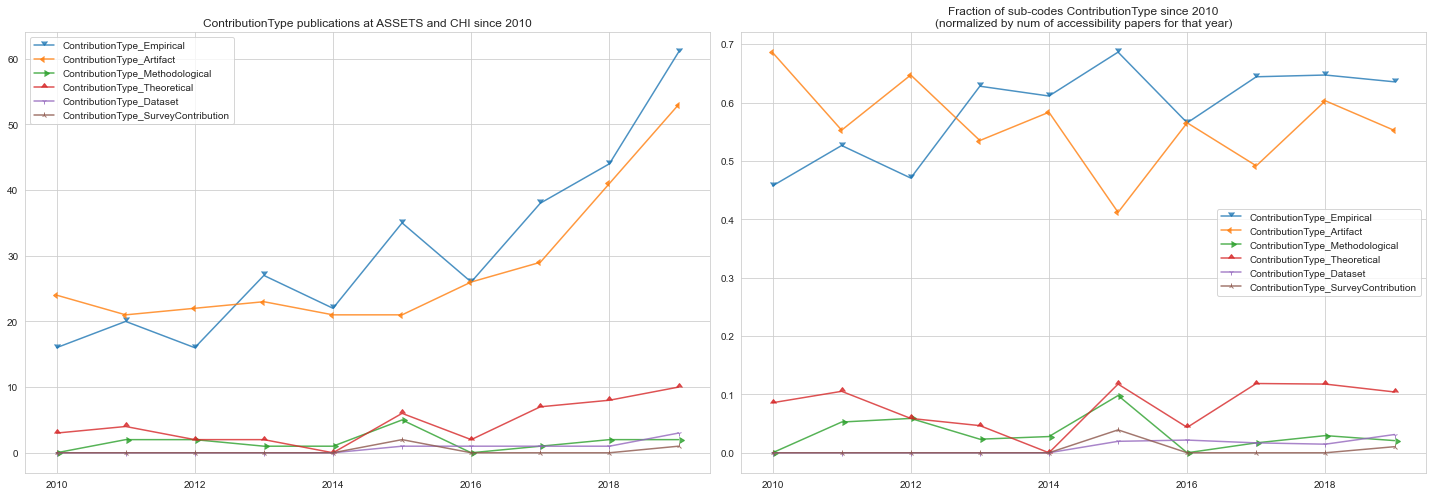

StudyMethod_ControlledExperiment  StudyMethod_SurveyMethod  \
Year                                                               
2010                                11                         9   
2011                                13                        10   
2012                                19                         6   
2013                                16                        10   
2014                                13                        12   
2015                                22                        15   
2016                                12                        13   
2017                                22                        14   
2018                                15                        15   
2019                                24                        18   

      StudyMethod_UsabilityTesting  StudyMethod_Interviews  \
Year                                                         
2010                            17                       6   
2011                            14                      14   
2012                            14                      10   
2013                            17                      14   
2014                            14                      17   
2015                            17                      18   
2016                            21                      21   
2017                            21                      22   
2018                            28                      33   
2019                            36                      46   

      StudyMethod_CaseStudy  StudyMethod_FocusGroups  StudyMethod_FieldStudy  \
Year                                                                           
2010                      1                        3                       5   
2011                      5                        2                       6   
2012                      1                        0                       3   
2013                      3                        1                       5   
2014                      1                        3                      10   
2015                      3                        2                       8   
2016                      2                        3                      10   
2017                      2                        3                       6   
2018                      4                        4                      14   
2019                      3                        7                      18   

      StudyMethod_WorkshopDesign  StudyMethod_Other  
Year                                                 
2010                           3                  6  
2011                           3                  9  
2012                           4                  8  
2013                           6                  8  
2014                           4                  8  
2015                           9                  9  
2016                          10                 11  
2017                           9                  8  
2018                          16                 11  
2019                          24                 21

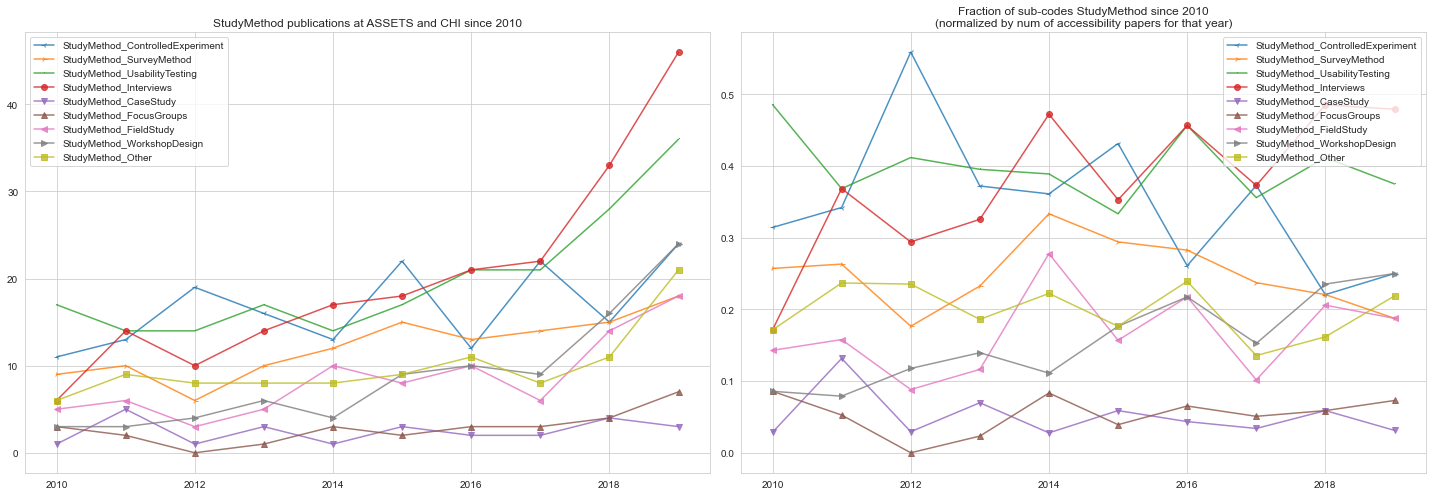

ParticipantGroup_OlderAdult  ParticipantGroup_PeopleWithDisability  \
Year                                                                       
2010                            4                                     23   
2011                            5                                     24   
2012                            5                                     21   
2013                            5                                     33   
2014                            4                                     27   
2015                            4                                     42   
2016                            2                                     40   
2017                            2                                     54   
2018                            3                                     63   
2019                            6                                     77   

      ParticipantGroup_PeopleWithoutDisability  \
Year                                             
2010                                         8   
2011                                         9   
2012                                         8   
2013                                         8   
2014                                         9   
2015                                        15   
2016                                        14   
2017                                        14   
2018                                        13   
2019                                        12   

      ParticipantGroup_TherapistsSpecialists  ParticipantGroup_Caregivers  \
Year                                                                        
2010                                       8                            3   
2011                                       7                            4   
2012                                       3                            0   
2013                                       4                            3   
2014                                       5                            2   
2015                                      10                            5   
2016                                       5                            6   
2017                                       9                            9   
2018                                      13                            4   
2019                                      17                            9   

      ParticipantGroup_Other  ParticipantGroup_NoUserStudy  
Year                                                        
2010                       4                             1  
2011                       4                             5  
2012                       4                             4  
2013                       4                             3  
2014                       4                             3  
2015                       5                             2  
2016                       3                             1  
2017                       2                             3  
2018                       6                             2  
2019                      17                             5

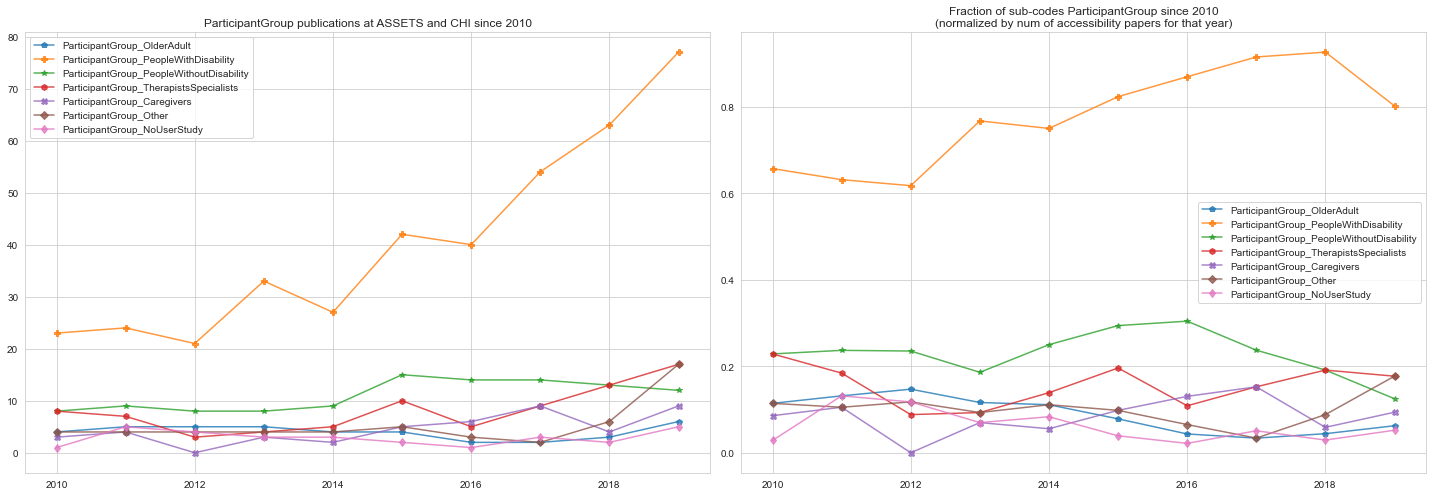

StudyLocation_NearAtLab  StudyLocation_ParticipantsHomeOrFreqLoc  \
Year                                                                     
2010                        5                                       12   
2011                        4                                        8   
2012                        9                                        5   
2013                       12                                       11   
2014                       12                                       13   
2015                       12                                       18   
2016                       15                                       15   
2017                       15                                       16   
2018                       20                                       20   
2019                       26                                       20   

      StudyLocation_NeutralLocation  StudyLocation_Unclear  \
Year                                                         
2010                              2                     11   
2011                              0                     21   
2012                              2                     16   
2013                              4                     15   
2014                              2                     10   
2015                              5                     15   
2016                              1                     21   
2017                              0                     20   
2018                              6                     22   
2019                             10                     38   

      StudyLocation_OnlineRemotely  StudyLocation_Other  \
Year                                                      
2010                             8                    0   
2011                             6                    0   
2012                             2                    0   
2013                             9                    0   
2014                             6                    1   
2015                            10                    2   
2016                            10                    0   
2017                            16                    1   
2018                            15                    2   
2019                            16                    1   

      StudyLocation_NoUserStudy  
Year                             
2010                          1  
2011                          5  
2012                          4  
2013                          3  
2014                          3  
2015                          2  
2016                          1  
2017                          3  
2018                          2  
2019                          5

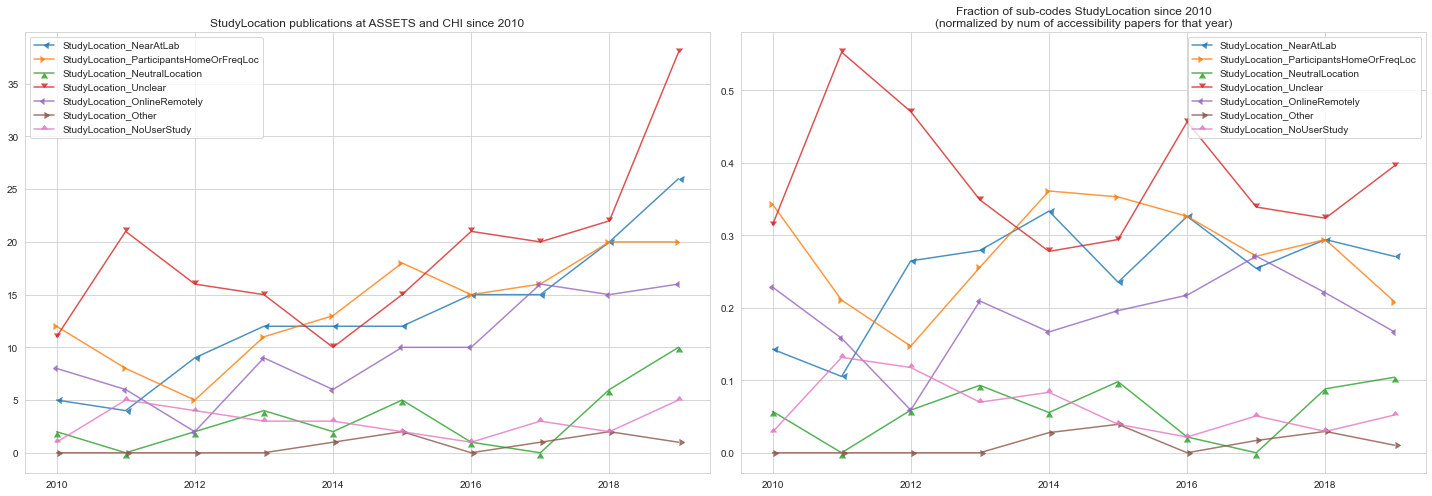

ParticipatoryDesign_Yes  ParticipatoryDesign_No
Year                                                 
2010                        2                      33
2011                        1                      37
2012                        3                      31
2013                        5                      38
2014                        4                      32
2015                        5                      46
2016                        6                      40
2017                        3                      56
2018                        6                      62
2019                       14                      82

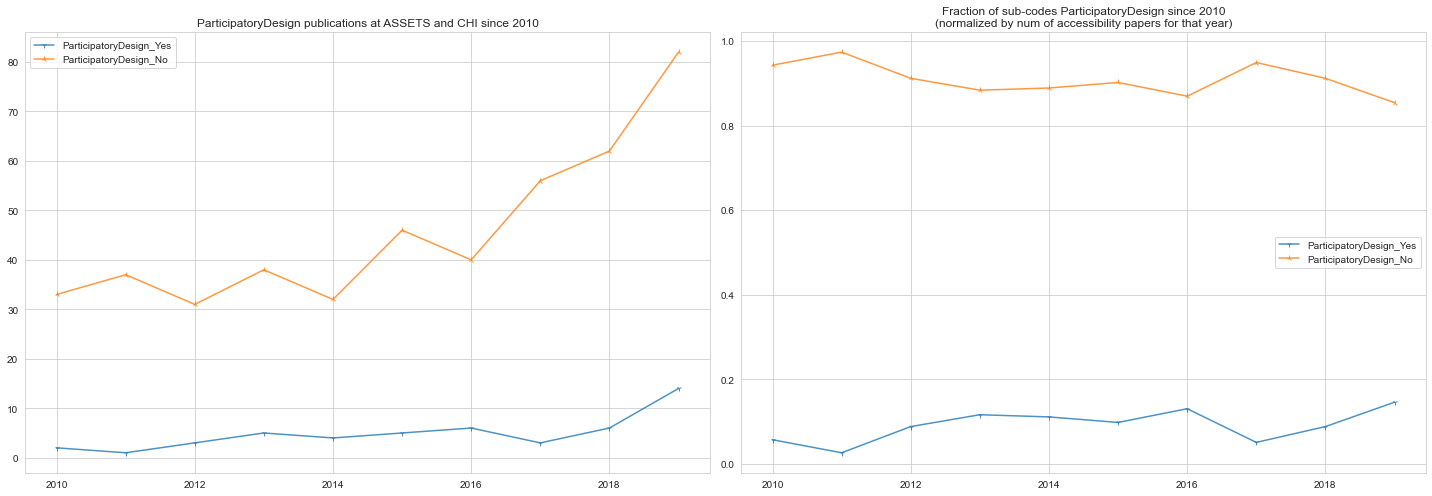

ComparesOnDisability_Yes  ComparesOnDisability_No
Year                                                   
2010                         4                       31
2011                         3                       35
2012                         6                       28
2013                         4                       39
2014                         7                       29
2015                        11                       40
2016                         6                       40
2017                        11                       48
2018                         7                       61
2019                         6                       90

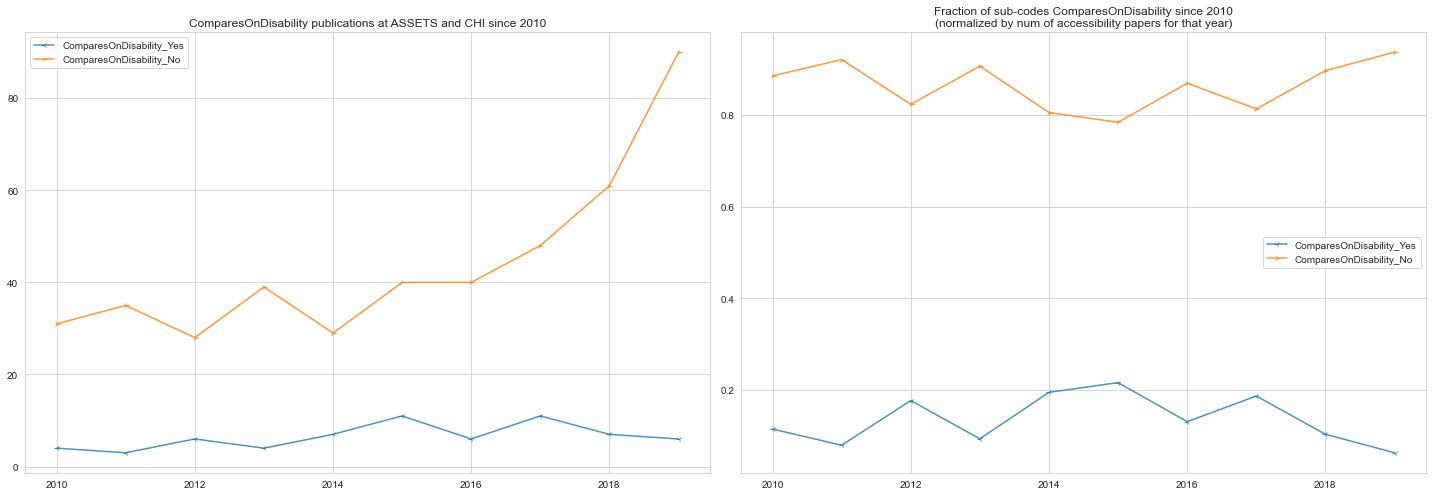

UsesProxies_Yes  UsesProxies_No
Year                                 
2010                2              33
2011                2              36
2012                3              31
2013                3              40
2014                4              32
2015                2              49
2016                5              41
2017                7              52
2018                7              61
2019                3              93

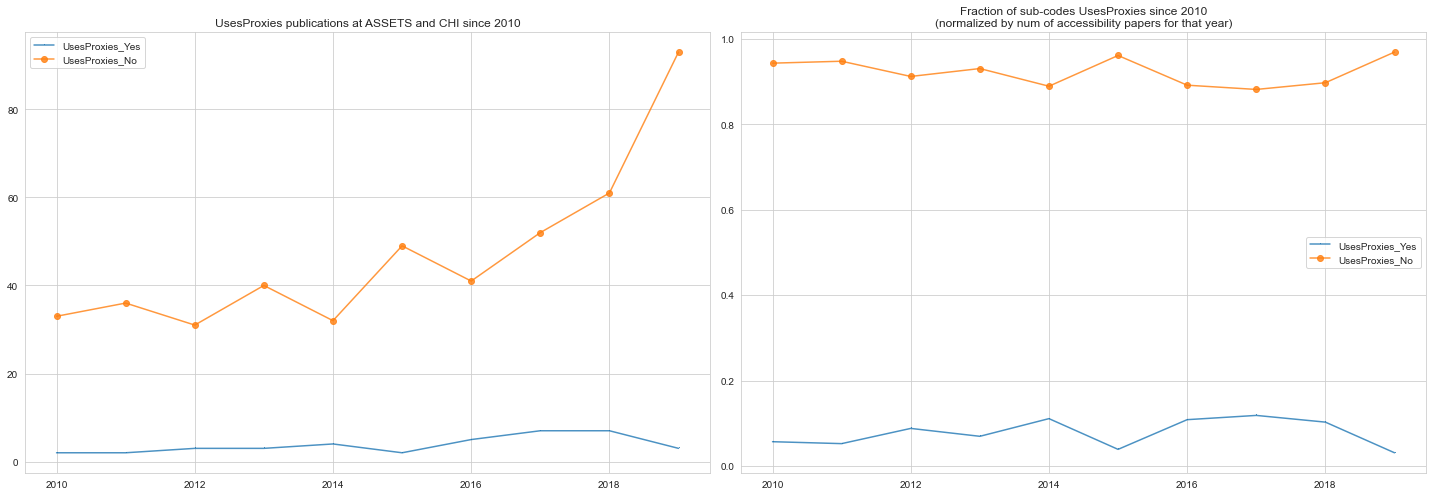

In [82]:
import itertools
marker_iter = itertools.cycle(plot_markers) 
#marker_iter = itertools.cycle(map_marker_to_desc.keys())
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # skip these categories
    
    col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_pub_cnt_per_code_by_year = pd.DataFrame()
    
    for col_name in col_names:           
        # Previously, the code we had here was:
        #   series_pub_cnt_for_code_by_year = df[df[col_name] == 1].groupby(['Year', col_name])['Year'].count()
        # But this wouldn't work for years when that sub_code literally had zero entries with a '1' cell
        # So, based on this Stackoverflow: https://stackoverflow.com/q/37003100
        # I changed it to the following, which is more complicated to look at but works the same and includes zero counts
        df_sub_code_cnt_by_year = df.groupby(['Year', col_name])['Year'].count().unstack(fill_value=0)
        
        if len(df_sub_code_cnt_by_year.columns) == 1:
            # If we're here, then this sub-code was *NEVER* used across any year
            print(f"WARNING: the sub-code {col_name} was never used across any year")
            df_sub_code_cnt_by_year[1] = np.zeros(10, dtype=np.int64)
        
        series_pub_cnt_for_code_by_year = df_sub_code_cnt_by_year[1]
        #print(series_pub_cnt_for_code_by_year)
        df_pub_cnt_per_code_by_year[col_name] = series_pub_cnt_for_code_by_year
    
    # Because the series series_pub_cnt_for_code_by_year has a multindex both on year, subcode
    # we can drop the second index since we only want year
    #df_pub_cnt_per_code_by_year = df_pub_cnt_per_code_by_year.droplevel(1) # drop sub-code index
    df_pub_cnt_per_code_by_year = df_pub_cnt_per_code_by_year.fillna(0)
    df_pub_cnt_per_code_by_year = df_pub_cnt_per_code_by_year.astype(int)
    display(df_pub_cnt_per_code_by_year)
    
    # Graph the results
    f, axes = plt.subplots(1, 2, figsize=(20, 7))

    for col_name in df_pub_cnt_per_code_by_year.columns:
        marker = next(marker_iter)
        label = col_name
        axes[0].plot(df_pub_cnt_per_code_by_year[col_name], label=label, marker=marker, alpha=0.8)
        
        # draw normalized per category, which divides each sub_code count / total number of papers
        # in the code_cat for that year
        normalized_by_num_access_papers_per_year = df_pub_cnt_per_code_by_year[col_name] / total_pub_cnt_by_year
        axes[1].plot(normalized_by_num_access_papers_per_year, label=label, marker=marker, alpha=0.8)

    axes[0].set_title(f"{code_cat} publications at ASSETS and CHI since 2010")
    axes[0].legend()
    
    axes[1].set_title(f"Fraction of sub-codes {code_cat} since 2010\n(normalized by num of accessibility papers for that year)")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# Co-occurence matrices

## Co-occurrence matrix plotting functions

In [83]:
def plot_co_occurrence_cnt_matrix(df_co_occurrence_cnt):
    # Generate a mask for the upper triangle
    df_co_occurrence_cnt = df_co_occurrence_cnt.astype(float)
    mask = np.zeros_like(df_co_occurrence_cnt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_co_occurrence_cnt, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.show()
    
def plot_co_occurrence_fraction_matrix(df_co_occurrence_frac, df_co_occurrence_cnt=None):
    # Plot the percentages version 
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    if df_co_occurrence_cnt is not None:
        print("Read the co-occurrence matrix column-to-row. For example:")
        for i in range(3):
            col_name = random.choice(df_co_occurrence_frac.columns)#'StudyMethod_SurveyMethod'
            row_name = random.choice(df_co_occurrence_frac.columns)#'StudyMethod_ControlledExperiment'
            series_sum_occurrence = df[df_co_occurrence_frac.columns].sum()
            print("{} (column) occurs {} times in {} {} (row) instances {:.2f}%".format(
                col_name, df_co_occurrence_cnt.loc[row_name, col_name],
                series_sum_occurrence[row_name], row_name,
                (df_co_occurrence_cnt.loc[row_name, col_name] / 
                 series_sum_occurrence[row_name]) * 100))

            tmp_name = row_name
            row_name = col_name
            col_name = tmp_name
            print("{} (column) occurs {} times in {} {} (row) instances {:.2f}%".format(
                col_name, df_co_occurrence_cnt.loc[row_name, col_name],
                series_sum_occurrence[row_name], row_name,
                (df_co_occurrence_cnt.loc[row_name, col_name] / 
                 series_sum_occurrence[row_name]) * 100))
        
        print()

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(df_co_occurrence_study_method_frac, annot=True)
    sns.heatmap(df_co_occurrence_frac, cmap=cmap, vmax = 1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.show()

## Within-code co-occurrence matrices
The cells below explore how often sub-codes within a code category co-occur.

In [84]:
def calc_within_code_co_occurrence_matrix(code_cat, map_codes = None):
    '''
    Calculates the frequency with which each sub-code in the code category (code_cat) co-occurs with
    other sub-codes in the same code category
    '''
    
    if map_codes is None:
        map_codes = map_codes_to_cols
    
    # Create empty dataframes to store matrices:
    # df_co_occurrence_subcode_cnt is a count of co-occurrence
    # df_co_occurrence_subcode_frac is a fraction of co-occurrence
    subcode_cols = map_codes[code_cat]
    df_co_occurrence_subcode_cnt = pd.DataFrame(columns=subcode_cols, index=subcode_cols)
    df_co_occurrence_subcode_frac = pd.DataFrame(columns=subcode_cols, index=subcode_cols)
    series_sum_subcode_occurrence = df[subcode_cols].sum()
    
    for i in range(len(subcode_cols)):
        for j in range(len(subcode_cols)):
            row = subcode_cols[i]
            col = subcode_cols[j]
            
            # Run co-occurrence query
            co_occurrence_count = len(df[(df[row] == 1) & (df[col] == 1)])
            co_occurrence_fraction = co_occurrence_count / series_sum_subcode_occurrence[row]

            # Set co-occurrence data into appropriate table cells
            df_co_occurrence_subcode_cnt.loc[row, col] = co_occurrence_count
            df_co_occurrence_subcode_frac.loc[row, col] = co_occurrence_fraction

    # Need to force the fractions to floating point
    df_co_occurrence_subcode_cnt = df_co_occurrence_subcode_cnt.astype(int)
    df_co_occurrence_subcode_frac = df_co_occurrence_subcode_frac.astype(float)

#     return { 'co-occurrence-count-table' : df_co_occurrence_subcode_cnt,
#              'co-occurrence-frac-table' : df_co_occurrence_subcode_frac }
    return (df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac)



******** CommunityOfFocus *******

** Raw sub-code co-occurrence count for CommunityOfFocus **


CommunityOfFocus_BVI  \
CommunityOfFocus_BVI                                 220   
CommunityOfFocus_DHH                                   0   
CommunityOfFocus_IDD                                   0   
CommunityOfFocus_MotorPhysical                         2   
CommunityOfFocus_Autism                                0   
CommunityOfFocus_Cognitive                             1   
CommunityOfFocus_OlderAdult                            2   
CommunityOfFocus_GeneralDisability                     8   
CommunityOfFocus_Other                                 3   

                                    CommunityOfFocus_DHH  \
CommunityOfFocus_BVI                                   0   
CommunityOfFocus_DHH                                  57   
CommunityOfFocus_IDD                                   0   
CommunityOfFocus_MotorPhysical                         0   
CommunityOfFocus_Autism                                0   
CommunityOfFocus_Cognitive                             0   
CommunityOfFocus_OlderAdult                            0   
CommunityOfFocus_GeneralDisability                     1   
CommunityOfFocus_Other                                13   

                                    CommunityOfFocus_IDD  \
CommunityOfFocus_BVI                                   0   
CommunityOfFocus_DHH                                   0   
CommunityOfFocus_IDD                                  14   
CommunityOfFocus_MotorPhysical                         0   
CommunityOfFocus_Autism                                5   
CommunityOfFocus_Cognitive                             1   
CommunityOfFocus_OlderAdult                            0   
CommunityOfFocus_GeneralDisability                     0   
CommunityOfFocus_Other                                 2   

                                    CommunityOfFocus_MotorPhysical  \
CommunityOfFocus_BVI                                             2   
CommunityOfFocus_DHH                                             0   
CommunityOfFocus_IDD                                             0   
CommunityOfFocus_MotorPhysical                                  72   
CommunityOfFocus_Autism                                          1   
CommunityOfFocus_Cognitive                                       5   
CommunityOfFocus_OlderAdult                                      5   
CommunityOfFocus_GeneralDisability                               4   
CommunityOfFocus_Other                                           1   

                                    CommunityOfFocus_Autism  \
CommunityOfFocus_BVI                                      0   
CommunityOfFocus_DHH                                      0   
CommunityOfFocus_IDD                                      5   
CommunityOfFocus_MotorPhysical                            1   
CommunityOfFocus_Autism                                  31   
CommunityOfFocus_Cognitive                                3   
CommunityOfFocus_OlderAdult                               1   
CommunityOfFocus_GeneralDisability                        2   
CommunityOfFocus_Other                                    3   

                                    CommunityOfFocus_Cognitive  \
CommunityOfFocus_BVI                                         1   
CommunityOfFocus_DHH                                         0   
CommunityOfFocus_IDD                                         1   
CommunityOfFocus_MotorPhysical                               5   
CommunityOfFocus_Autism                                      3   
CommunityOfFocus_Cognitive                                  46   
CommunityOfFocus_OlderAdult                                  9   
CommunityOfFocus_GeneralDisability                           2   
CommunityOfFocus_Other                                       5   

                                    CommunityOfFocus_OlderAdult  \
CommunityOfFocus_BVI                                          2   
CommunityOfFocus_DHH                                          0   
CommunityOfFocus_IDD                   

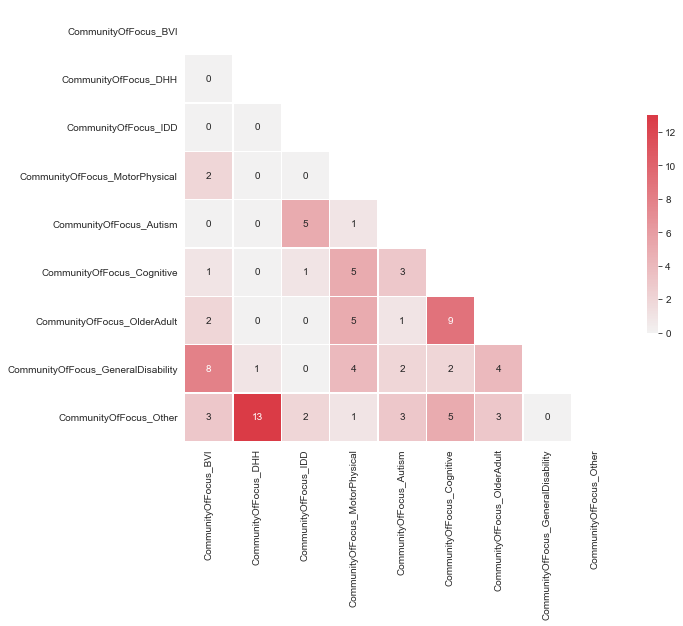

** Fraction of sub-code co-occurrences for CommunityOfFocus **


CommunityOfFocus_BVI  \
CommunityOfFocus_BVI                            1.000000   
CommunityOfFocus_DHH                            0.000000   
CommunityOfFocus_IDD                            0.000000   
CommunityOfFocus_MotorPhysical                  0.027778   
CommunityOfFocus_Autism                         0.000000   
CommunityOfFocus_Cognitive                      0.021739   
CommunityOfFocus_OlderAdult                     0.044444   
CommunityOfFocus_GeneralDisability              0.173913   
CommunityOfFocus_Other                          0.065217   

                                    CommunityOfFocus_DHH  \
CommunityOfFocus_BVI                            0.000000   
CommunityOfFocus_DHH                            1.000000   
CommunityOfFocus_IDD                            0.000000   
CommunityOfFocus_MotorPhysical                  0.000000   
CommunityOfFocus_Autism                         0.000000   
CommunityOfFocus_Cognitive                      0.000000   
CommunityOfFocus_OlderAdult                     0.000000   
CommunityOfFocus_GeneralDisability              0.021739   
CommunityOfFocus_Other                          0.282609   

                                    CommunityOfFocus_IDD  \
CommunityOfFocus_BVI                            0.000000   
CommunityOfFocus_DHH                            0.000000   
CommunityOfFocus_IDD                            1.000000   
CommunityOfFocus_MotorPhysical                  0.000000   
CommunityOfFocus_Autism                         0.161290   
CommunityOfFocus_Cognitive                      0.021739   
CommunityOfFocus_OlderAdult                     0.000000   
CommunityOfFocus_GeneralDisability              0.000000   
CommunityOfFocus_Other                          0.043478   

                                    CommunityOfFocus_MotorPhysical  \
CommunityOfFocus_BVI                                      0.009091   
CommunityOfFocus_DHH                                      0.000000   
CommunityOfFocus_IDD                                      0.000000   
CommunityOfFocus_MotorPhysical                            1.000000   
CommunityOfFocus_Autism                                   0.032258   
CommunityOfFocus_Cognitive                                0.108696   
CommunityOfFocus_OlderAdult                               0.111111   
CommunityOfFocus_GeneralDisability                        0.086957   
CommunityOfFocus_Other                                    0.021739   

                                    CommunityOfFocus_Autism  \
CommunityOfFocus_BVI                               0.000000   
CommunityOfFocus_DHH                               0.000000   
CommunityOfFocus_IDD                               0.357143   
CommunityOfFocus_MotorPhysical                     0.013889   
CommunityOfFocus_Autism                            1.000000   
CommunityOfFocus_Cognitive                         0.065217   
CommunityOfFocus_OlderAdult                        0.022222   
CommunityOfFocus_GeneralDisability                 0.043478   
CommunityOfFocus_Other                             0.065217   

                                    CommunityOfFocus_Cognitive  \
CommunityOfFocus_BVI                                  0.004545   
CommunityOfFocus_DHH                                  0.000000   
CommunityOfFocus_IDD                                  0.071429   
CommunityOfFocus_MotorPhysical                        0.069444   
CommunityOfFocus_Autism                               0.096774   
CommunityOfFocus_Cognitive                            1.000000   
CommunityOfFocus_OlderAdult                           0.200000   
CommunityOfFocus_GeneralDisability                    0.043478   
CommunityOfFocus_Other                                0.108696   

                                    CommunityOfFocus_OlderAdult  \
CommunityOfFocus_BVI                                   0.009091   
CommunityOfFocus_DHH                                   0.000000   
CommunityOfFocus_IDD                   

Read the co-occurrence matrix column-to-row. For example:
CommunityOfFocus_IDD (column) occurs 1 times in 46 CommunityOfFocus_Cognitive (row) instances 2.17%
CommunityOfFocus_Cognitive (column) occurs 1 times in 14 CommunityOfFocus_IDD (row) instances 7.14%
CommunityOfFocus_MotorPhysical (column) occurs 2 times in 220 CommunityOfFocus_BVI (row) instances 0.91%
CommunityOfFocus_BVI (column) occurs 2 times in 72 CommunityOfFocus_MotorPhysical (row) instances 2.78%
CommunityOfFocus_GeneralDisability (column) occurs 1 times in 57 CommunityOfFocus_DHH (row) instances 1.75%
CommunityOfFocus_DHH (column) occurs 1 times in 46 CommunityOfFocus_GeneralDisability (row) instances 2.17%



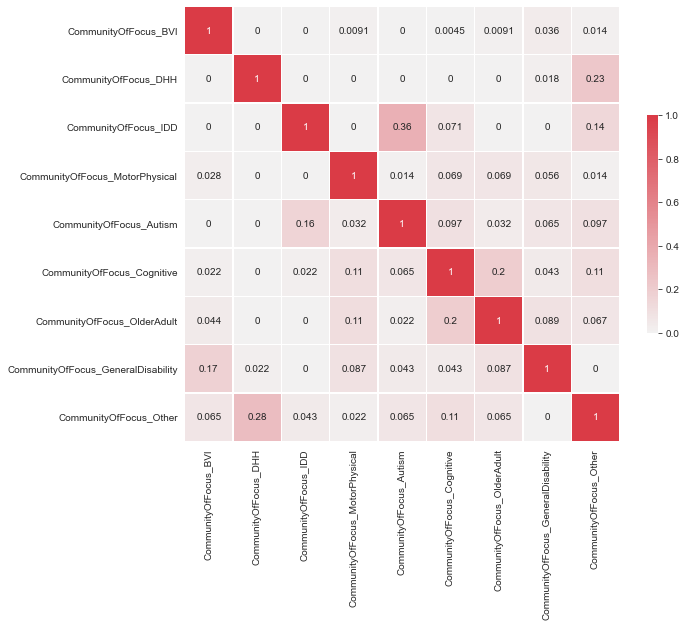



******** IssueAddressed *******

** Raw sub-code co-occurrence count for IssueAddressed **


IssueAddressed_IncreaseDigitalAccess  \
IssueAddressed_IncreaseDigitalAccess                                                 186   
IssueAddressed_IncreasePhysicalAccess                                                 13   
IssueAddressed_IncreaseIndependence                                                   14   
IssueAddressed_IncreaseUnderstandingOfUsers                                           24   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                     1   
IssueAddressed_SupportCommunication                                                   18   
IssueAddressed_Other                                                                  12   

                                                    IssueAddressed_IncreasePhysicalAccess  \
IssueAddressed_IncreaseDigitalAccess                                                   13   
IssueAddressed_IncreasePhysicalAccess                                                 105   
IssueAddressed_IncreaseIndependence                                                    62   
IssueAddressed_IncreaseUnderstandingOfUsers                                             6   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                      3   
IssueAddressed_SupportCommunication                                                     6   
IssueAddressed_Other                                                                    9   

                                                    IssueAddressed_IncreaseIndependence  \
IssueAddressed_IncreaseDigitalAccess                                                 14   
IssueAddressed_IncreasePhysicalAccess                                                62   
IssueAddressed_IncreaseIndependence                                                  93   
IssueAddressed_IncreaseUnderstandingOfUsers                                           4   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                    7   
IssueAddressed_SupportCommunication                                                   3   
IssueAddressed_Other                                                                  9   

                                                    IssueAddressed_IncreaseUnderstandingOfUsers  \
IssueAddressed_IncreaseDigitalAccess                                                         24   
IssueAddressed_IncreasePhysicalAccess                                                         6   
IssueAddressed_IncreaseIndependence                                                           4   
IssueAddressed_IncreaseUnderstandingOfUsers                                                 139   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                            2   
IssueAddressed_SupportCommunication                                                           9   
IssueAddressed_Other                                                                         14   

                                                    IssueAddressed_HelpWithPersonalInformaticsBehaviorChange  \
IssueAddressed_IncreaseDigitalAccess                                                                1          
IssueAddressed_IncreasePhysicalAccess                                                               3          
IssueAddressed_IncreaseIndependence                                                                 7          
IssueAddressed_IncreaseUnderstandingOfUsers                                                         2          
IssueAddressed_HelpWithPersonalInformaticsBehav...                                                 39          
IssueAddressed_SupportCommunication                                                                 5          
IssueAddressed_Other                                                                                4          

                                                    IssueAddressed_SupportCommunication  \
IssueAddressed_IncreaseDigitalAccess                        

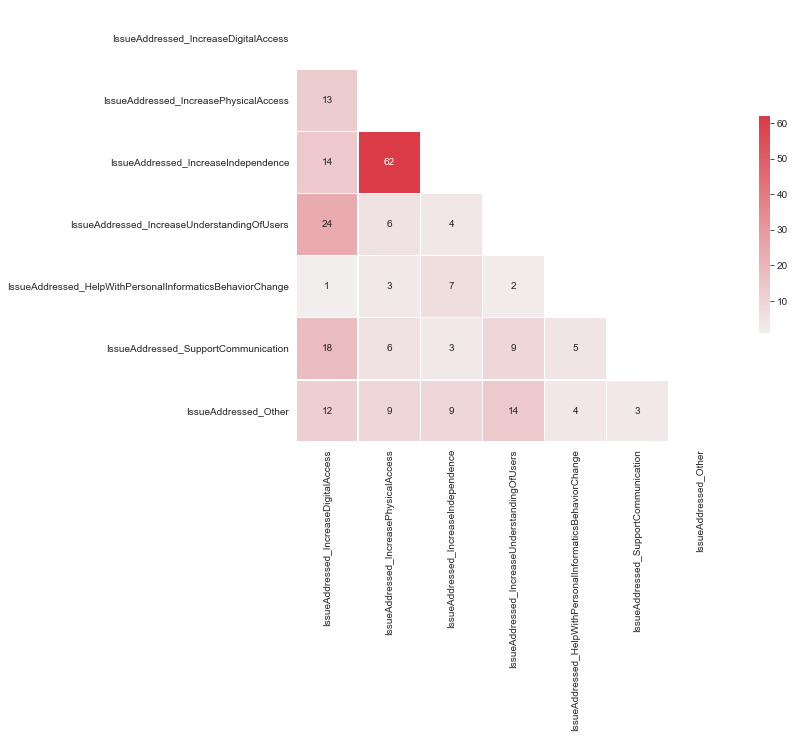

** Fraction of sub-code co-occurrences for IssueAddressed **


IssueAddressed_IncreaseDigitalAccess  \
IssueAddressed_IncreaseDigitalAccess                                            1.000000   
IssueAddressed_IncreasePhysicalAccess                                           0.123810   
IssueAddressed_IncreaseIndependence                                             0.150538   
IssueAddressed_IncreaseUnderstandingOfUsers                                     0.172662   
IssueAddressed_HelpWithPersonalInformaticsBehav...                              0.025641   
IssueAddressed_SupportCommunication                                             0.222222   
IssueAddressed_Other                                                            0.203390   

                                                    IssueAddressed_IncreasePhysicalAccess  \
IssueAddressed_IncreaseDigitalAccess                                             0.069892   
IssueAddressed_IncreasePhysicalAccess                                            1.000000   
IssueAddressed_IncreaseIndependence                                              0.666667   
IssueAddressed_IncreaseUnderstandingOfUsers                                      0.043165   
IssueAddressed_HelpWithPersonalInformaticsBehav...                               0.076923   
IssueAddressed_SupportCommunication                                              0.074074   
IssueAddressed_Other                                                             0.152542   

                                                    IssueAddressed_IncreaseIndependence  \
IssueAddressed_IncreaseDigitalAccess                                           0.075269   
IssueAddressed_IncreasePhysicalAccess                                          0.590476   
IssueAddressed_IncreaseIndependence                                            1.000000   
IssueAddressed_IncreaseUnderstandingOfUsers                                    0.028777   
IssueAddressed_HelpWithPersonalInformaticsBehav...                             0.179487   
IssueAddressed_SupportCommunication                                            0.037037   
IssueAddressed_Other                                                           0.152542   

                                                    IssueAddressed_IncreaseUnderstandingOfUsers  \
IssueAddressed_IncreaseDigitalAccess                                                   0.129032   
IssueAddressed_IncreasePhysicalAccess                                                  0.057143   
IssueAddressed_IncreaseIndependence                                                    0.043011   
IssueAddressed_IncreaseUnderstandingOfUsers                                            1.000000   
IssueAddressed_HelpWithPersonalInformaticsBehav...                                     0.051282   
IssueAddressed_SupportCommunication                                                    0.111111   
IssueAddressed_Other                                                                   0.237288   

                                                    IssueAddressed_HelpWithPersonalInformaticsBehaviorChange  \
IssueAddressed_IncreaseDigitalAccess                                                         0.005376          
IssueAddressed_IncreasePhysicalAccess                                                        0.028571          
IssueAddressed_IncreaseIndependence                                                          0.075269          
IssueAddressed_IncreaseUnderstandingOfUsers                                                  0.014388          
IssueAddressed_HelpWithPersonalInformaticsBehav...                                           1.000000          
IssueAddressed_SupportCommunication                                                          0.061728          
IssueAddressed_Other                                                                         0.067797          

                                                    IssueAddressed_SupportCommunication  \
IssueAddressed_IncreaseDigitalAccess                        

Read the co-occurrence matrix column-to-row. For example:
IssueAddressed_IncreasePhysicalAccess (column) occurs 13 times in 186 IssueAddressed_IncreaseDigitalAccess (row) instances 6.99%
IssueAddressed_IncreaseDigitalAccess (column) occurs 13 times in 105 IssueAddressed_IncreasePhysicalAccess (row) instances 12.38%
IssueAddressed_IncreasePhysicalAccess (column) occurs 6 times in 139 IssueAddressed_IncreaseUnderstandingOfUsers (row) instances 4.32%
IssueAddressed_IncreaseUnderstandingOfUsers (column) occurs 6 times in 105 IssueAddressed_IncreasePhysicalAccess (row) instances 5.71%
IssueAddressed_IncreaseDigitalAccess (column) occurs 12 times in 59 IssueAddressed_Other (row) instances 20.34%
IssueAddressed_Other (column) occurs 12 times in 186 IssueAddressed_IncreaseDigitalAccess (row) instances 6.45%



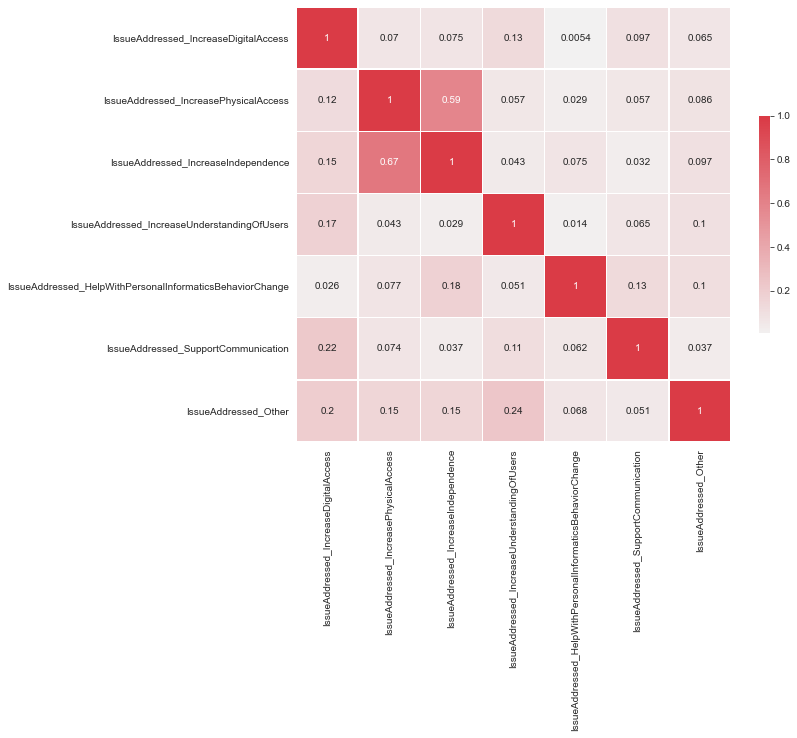



******** ContributionType *******

** Raw sub-code co-occurrence count for ContributionType **


ContributionType_Empirical  \
ContributionType_Empirical                                  305   
ContributionType_Artifact                                    93   
ContributionType_Methodological                              10   
ContributionType_Theoretical                                 33   
ContributionType_Dataset                                      4   
ContributionType_SurveyContribution                           1   

                                     ContributionType_Artifact  \
ContributionType_Empirical                                  93   
ContributionType_Artifact                                  281   
ContributionType_Methodological                              2   
ContributionType_Theoretical                                 7   
ContributionType_Dataset                                     2   
ContributionType_SurveyContribution                          0   

                                     ContributionType_Methodological  \
ContributionType_Empirical                                        10   
ContributionType_Artifact                                          2   
ContributionType_Methodological                                   16   
ContributionType_Theoretical                                       1   
ContributionType_Dataset                                           1   
ContributionType_SurveyContribution                                3   

                                     ContributionType_Theoretical  \
ContributionType_Empirical                                     33   
ContributionType_Artifact                                       7   
ContributionType_Methodological                                 1   
ContributionType_Theoretical                                   44   
ContributionType_Dataset                                        0   
ContributionType_SurveyContribution                             0   

                                     ContributionType_Dataset  \
ContributionType_Empirical                                  4   
ContributionType_Artifact                                   2   
ContributionType_Methodological                             1   
ContributionType_Theoretical                                0   
ContributionType_Dataset                                    7   
ContributionType_SurveyContribution                         0   

                                     ContributionType_SurveyContribution  
ContributionType_Empirical                                             1  
ContributionType_Artifact                                              0  
ContributionType_Methodological                                        3  
ContributionType_Theoretical                                           0  
ContributionType_Dataset                                               0  
ContributionType_SurveyContribution                                    3

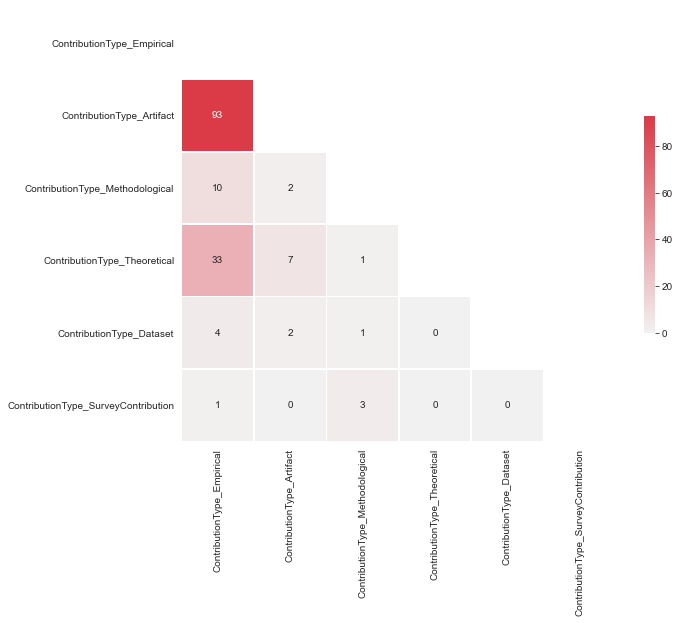

** Fraction of sub-code co-occurrences for ContributionType **


ContributionType_Empirical  \
ContributionType_Empirical                             1.000000   
ContributionType_Artifact                              0.330961   
ContributionType_Methodological                        0.625000   
ContributionType_Theoretical                           0.750000   
ContributionType_Dataset                               0.571429   
ContributionType_SurveyContribution                    0.333333   

                                     ContributionType_Artifact  \
ContributionType_Empirical                            0.304918   
ContributionType_Artifact                             1.000000   
ContributionType_Methodological                       0.125000   
ContributionType_Theoretical                          0.159091   
ContributionType_Dataset                              0.285714   
ContributionType_SurveyContribution                   0.000000   

                                     ContributionType_Methodological  \
ContributionType_Empirical                                  0.032787   
ContributionType_Artifact                                   0.007117   
ContributionType_Methodological                             1.000000   
ContributionType_Theoretical                                0.022727   
ContributionType_Dataset                                    0.142857   
ContributionType_SurveyContribution                         1.000000   

                                     ContributionType_Theoretical  \
ContributionType_Empirical                               0.108197   
ContributionType_Artifact                                0.024911   
ContributionType_Methodological                          0.062500   
ContributionType_Theoretical                             1.000000   
ContributionType_Dataset                                 0.000000   
ContributionType_SurveyContribution                      0.000000   

                                     ContributionType_Dataset  \
ContributionType_Empirical                           0.013115   
ContributionType_Artifact                            0.007117   
ContributionType_Methodological                      0.062500   
ContributionType_Theoretical                         0.000000   
ContributionType_Dataset                             1.000000   
ContributionType_SurveyContribution                  0.000000   

                                     ContributionType_SurveyContribution  
ContributionType_Empirical                                      0.003279  
ContributionType_Artifact                                       0.000000  
ContributionType_Methodological                                 0.187500  
ContributionType_Theoretical                                    0.000000  
ContributionType_Dataset                                        0.000000  
ContributionType_SurveyContribution                             1.000000

Read the co-occurrence matrix column-to-row. For example:
ContributionType_Artifact (column) occurs 2 times in 7 ContributionType_Dataset (row) instances 28.57%
ContributionType_Dataset (column) occurs 2 times in 281 ContributionType_Artifact (row) instances 0.71%
ContributionType_Methodological (column) occurs 2 times in 281 ContributionType_Artifact (row) instances 0.71%
ContributionType_Artifact (column) occurs 2 times in 16 ContributionType_Methodological (row) instances 12.50%
ContributionType_Artifact (column) occurs 93 times in 305 ContributionType_Empirical (row) instances 30.49%
ContributionType_Empirical (column) occurs 93 times in 281 ContributionType_Artifact (row) instances 33.10%



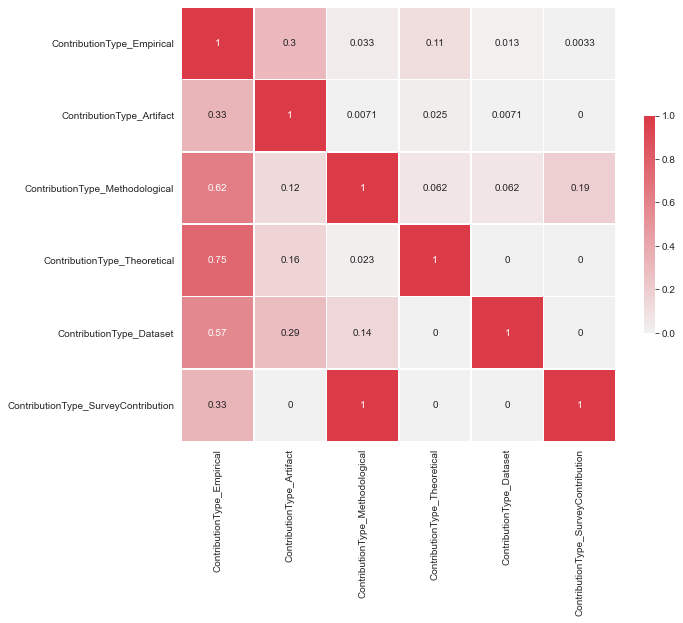



******** StudyMethod *******

** Raw sub-code co-occurrence count for StudyMethod **


StudyMethod_ControlledExperiment  \
StudyMethod_ControlledExperiment                               167   
StudyMethod_SurveyMethod                                        44   
StudyMethod_UsabilityTesting                                    62   
StudyMethod_Interviews                                          47   
StudyMethod_CaseStudy                                            4   
StudyMethod_FocusGroups                                          3   
StudyMethod_FieldStudy                                           3   
StudyMethod_WorkshopDesign                                      13   
StudyMethod_Other                                               17   

                                  StudyMethod_SurveyMethod  \
StudyMethod_ControlledExperiment                        44   
StudyMethod_SurveyMethod                               122   
StudyMethod_UsabilityTesting                            55   
StudyMethod_Interviews                                  63   
StudyMethod_CaseStudy                                    2   
StudyMethod_FocusGroups                                  6   
StudyMethod_FieldStudy                                  25   
StudyMethod_WorkshopDesign                              16   
StudyMethod_Other                                       21   

                                  StudyMethod_UsabilityTesting  \
StudyMethod_ControlledExperiment                            62   
StudyMethod_SurveyMethod                                    55   
StudyMethod_UsabilityTesting                               199   
StudyMethod_Interviews                                      83   
StudyMethod_CaseStudy                                        6   
StudyMethod_FocusGroups                                      9   
StudyMethod_FieldStudy                                      17   
StudyMethod_WorkshopDesign                                  34   
StudyMethod_Other                                           28   

                                  StudyMethod_Interviews  \
StudyMethod_ControlledExperiment                      47   
StudyMethod_SurveyMethod                              63   
StudyMethod_UsabilityTesting                          83   
StudyMethod_Interviews                               201   
StudyMethod_CaseStudy                                 13   
StudyMethod_FocusGroups                               11   
StudyMethod_FieldStudy                                48   
StudyMethod_WorkshopDesign                            49   
StudyMethod_Other                                     42   

                                  StudyMethod_CaseStudy  \
StudyMethod_ControlledExperiment                      4   
StudyMethod_SurveyMethod                              2   
StudyMethod_UsabilityTesting                          6   
StudyMethod_Interviews                               13   
StudyMethod_CaseStudy                                25   
StudyMethod_FocusGroups                               1   
StudyMethod_FieldStudy                                7   
StudyMethod_WorkshopDesign                            8   
StudyMethod_Other                                     5   

                                  StudyMethod_FocusGroups  \
StudyMethod_ControlledExperiment                        3   
StudyMethod_SurveyMethod                                6   
StudyMethod_UsabilityTesting                            9   
StudyMethod_Interviews                                 11   
StudyMethod_CaseStudy                                   1   
StudyMethod_FocusGroups                                28   
StudyMethod_FieldStudy                                  6   
StudyMethod_WorkshopDesign                              8   
StudyMethod_Other                                       4   

                                  StudyMethod_FieldStudy  \
StudyMethod_ControlledExperiment                       3   
StudyMethod_SurveyMethod                              25   
StudyMethod_UsabilityTesting                          17   
StudyMet

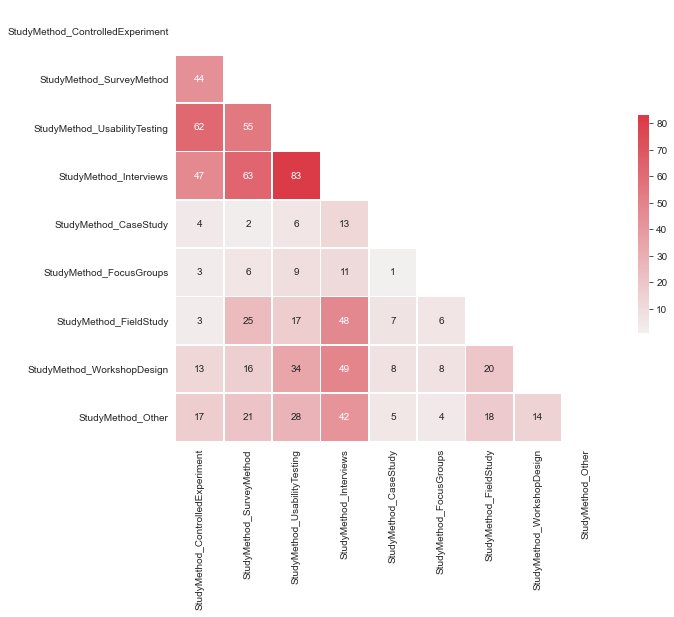

** Fraction of sub-code co-occurrences for StudyMethod **


StudyMethod_ControlledExperiment  \
StudyMethod_ControlledExperiment                          1.000000   
StudyMethod_SurveyMethod                                  0.360656   
StudyMethod_UsabilityTesting                              0.311558   
StudyMethod_Interviews                                    0.233831   
StudyMethod_CaseStudy                                     0.160000   
StudyMethod_FocusGroups                                   0.107143   
StudyMethod_FieldStudy                                    0.035294   
StudyMethod_WorkshopDesign                                0.147727   
StudyMethod_Other                                         0.171717   

                                  StudyMethod_SurveyMethod  \
StudyMethod_ControlledExperiment                  0.263473   
StudyMethod_SurveyMethod                          1.000000   
StudyMethod_UsabilityTesting                      0.276382   
StudyMethod_Interviews                            0.313433   
StudyMethod_CaseStudy                             0.080000   
StudyMethod_FocusGroups                           0.214286   
StudyMethod_FieldStudy                            0.294118   
StudyMethod_WorkshopDesign                        0.181818   
StudyMethod_Other                                 0.212121   

                                  StudyMethod_UsabilityTesting  \
StudyMethod_ControlledExperiment                      0.371257   
StudyMethod_SurveyMethod                              0.450820   
StudyMethod_UsabilityTesting                          1.000000   
StudyMethod_Interviews                                0.412935   
StudyMethod_CaseStudy                                 0.240000   
StudyMethod_FocusGroups                               0.321429   
StudyMethod_FieldStudy                                0.200000   
StudyMethod_WorkshopDesign                            0.386364   
StudyMethod_Other                                     0.282828   

                                  StudyMethod_Interviews  \
StudyMethod_ControlledExperiment                0.281437   
StudyMethod_SurveyMethod                        0.516393   
StudyMethod_UsabilityTesting                    0.417085   
StudyMethod_Interviews                          1.000000   
StudyMethod_CaseStudy                           0.520000   
StudyMethod_FocusGroups                         0.392857   
StudyMethod_FieldStudy                          0.564706   
StudyMethod_WorkshopDesign                      0.556818   
StudyMethod_Other                               0.424242   

                                  StudyMethod_CaseStudy  \
StudyMethod_ControlledExperiment               0.023952   
StudyMethod_SurveyMethod                       0.016393   
StudyMethod_UsabilityTesting                   0.030151   
StudyMethod_Interviews                         0.064677   
StudyMethod_CaseStudy                          1.000000   
StudyMethod_FocusGroups                        0.035714   
StudyMethod_FieldStudy                         0.082353   
StudyMethod_WorkshopDesign                     0.090909   
StudyMethod_Other                              0.050505   

                                  StudyMethod_FocusGroups  \
StudyMethod_ControlledExperiment                 0.017964   
StudyMethod_SurveyMethod                         0.049180   
StudyMethod_UsabilityTesting                     0.045226   
StudyMethod_Interviews                           0.054726   
StudyMethod_CaseStudy                            0.040000   
StudyMethod_FocusGroups                          1.000000   
StudyMethod_FieldStudy                           0.070588   
StudyMethod_WorkshopDesign                       0.090909   
StudyMethod_Other                                0.040404   

                                  StudyMethod_FieldStudy  \
StudyMethod_ControlledExperiment                0.017964   
StudyMethod_SurveyMethod                        0.204918   
StudyMethod_UsabilityTesting                    0.085427   
StudyMet

Read the co-occurrence matrix column-to-row. For example:
StudyMethod_FocusGroups (column) occurs 4 times in 99 StudyMethod_Other (row) instances 4.04%
StudyMethod_Other (column) occurs 4 times in 28 StudyMethod_FocusGroups (row) instances 14.29%
StudyMethod_Other (column) occurs 4 times in 28 StudyMethod_FocusGroups (row) instances 14.29%
StudyMethod_FocusGroups (column) occurs 4 times in 99 StudyMethod_Other (row) instances 4.04%
StudyMethod_WorkshopDesign (column) occurs 14 times in 99 StudyMethod_Other (row) instances 14.14%
StudyMethod_Other (column) occurs 14 times in 88 StudyMethod_WorkshopDesign (row) instances 15.91%



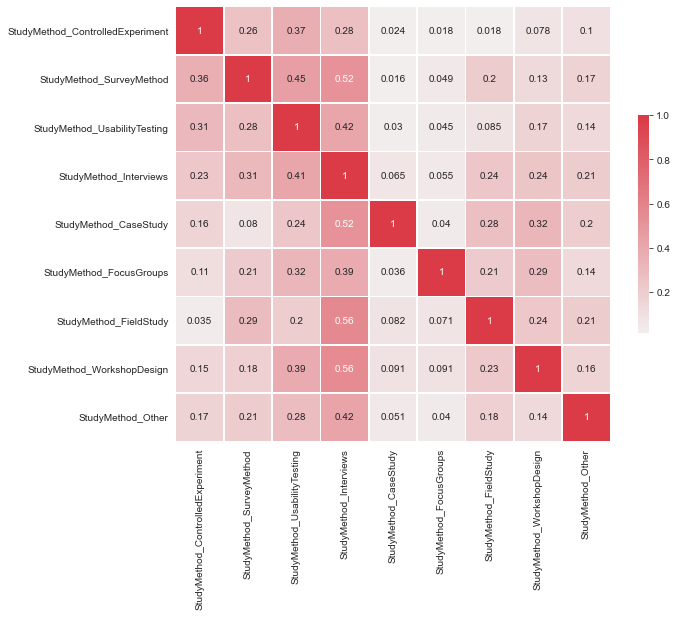



******** ParticipantGroup *******

** Raw sub-code co-occurrence count for ParticipantGroup **


ParticipantGroup_OlderAdult  \
ParticipantGroup_OlderAdult                                        40   
ParticipantGroup_PeopleWithDisability                              14   
ParticipantGroup_PeopleWithoutDisability                           11   
ParticipantGroup_TherapistsSpecialists                              2   
ParticipantGroup_Caregivers                                         5   
ParticipantGroup_Other                                              3   
ParticipantGroup_NoUserStudy                                        0   

                                          ParticipantGroup_PeopleWithDisability  \
ParticipantGroup_OlderAdult                                                  14   
ParticipantGroup_PeopleWithDisability                                       404   
ParticipantGroup_PeopleWithoutDisability                                     93   
ParticipantGroup_TherapistsSpecialists                                       67   
ParticipantGroup_Caregivers                                                  38   
ParticipantGroup_Other                                                       25   
ParticipantGroup_NoUserStudy                                                  0   

                                          ParticipantGroup_PeopleWithoutDisability  \
ParticipantGroup_OlderAdult                                                     11   
ParticipantGroup_PeopleWithDisability                                           93   
ParticipantGroup_PeopleWithoutDisability                                       110   
ParticipantGroup_TherapistsSpecialists                                          12   
ParticipantGroup_Caregivers                                                     10   
ParticipantGroup_Other                                                           5   
ParticipantGroup_NoUserStudy                                                     0   

                                          ParticipantGroup_TherapistsSpecialists  \
ParticipantGroup_OlderAdult                                                    2   
ParticipantGroup_PeopleWithDisability                                         67   
ParticipantGroup_PeopleWithoutDisability                                      12   
ParticipantGroup_TherapistsSpecialists                                        81   
ParticipantGroup_Caregivers                                                   18   
ParticipantGroup_Other                                                         4   
ParticipantGroup_NoUserStudy                                                   0   

                                          ParticipantGroup_Caregivers  \
ParticipantGroup_OlderAdult                                         5   
ParticipantGroup_PeopleWithDisability                              38   
ParticipantGroup_PeopleWithoutDisability                           10   
ParticipantGroup_TherapistsSpecialists                             18   
ParticipantGroup_Caregivers                                        45   
ParticipantGroup_Other                                              3   
ParticipantGroup_NoUserStudy                                        0   

                                          ParticipantGroup_Other  \
ParticipantGroup_OlderAdult                                    3   
ParticipantGroup_PeopleWithDisability                         25   
ParticipantGroup_PeopleWithoutDisability                       5   
ParticipantGroup_TherapistsSpecialists                         4   
ParticipantGroup_Caregivers                                    3   
ParticipantGroup_Other                                        53   
ParticipantGroup_NoUserStudy                                   0   

                                          ParticipantGroup_NoUserStudy  
ParticipantGroup_OlderAdult                                          0  
ParticipantGroup_PeopleWithDisability                                0  
ParticipantGroup_PeopleWithoutDisability                             0  
Particip

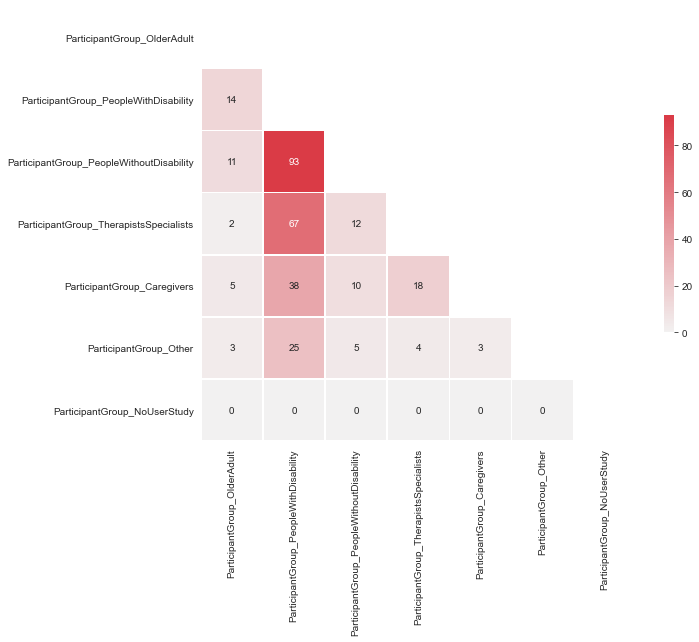

** Fraction of sub-code co-occurrences for ParticipantGroup **


ParticipantGroup_OlderAdult  \
ParticipantGroup_OlderAdult                                  1.000000   
ParticipantGroup_PeopleWithDisability                        0.034653   
ParticipantGroup_PeopleWithoutDisability                     0.100000   
ParticipantGroup_TherapistsSpecialists                       0.024691   
ParticipantGroup_Caregivers                                  0.111111   
ParticipantGroup_Other                                       0.056604   
ParticipantGroup_NoUserStudy                                 0.000000   

                                          ParticipantGroup_PeopleWithDisability  \
ParticipantGroup_OlderAdult                                            0.350000   
ParticipantGroup_PeopleWithDisability                                  1.000000   
ParticipantGroup_PeopleWithoutDisability                               0.845455   
ParticipantGroup_TherapistsSpecialists                                 0.827160   
ParticipantGroup_Caregivers                                            0.844444   
ParticipantGroup_Other                                                 0.471698   
ParticipantGroup_NoUserStudy                                           0.000000   

                                          ParticipantGroup_PeopleWithoutDisability  \
ParticipantGroup_OlderAdult                                               0.275000   
ParticipantGroup_PeopleWithDisability                                     0.230198   
ParticipantGroup_PeopleWithoutDisability                                  1.000000   
ParticipantGroup_TherapistsSpecialists                                    0.148148   
ParticipantGroup_Caregivers                                               0.222222   
ParticipantGroup_Other                                                    0.094340   
ParticipantGroup_NoUserStudy                                              0.000000   

                                          ParticipantGroup_TherapistsSpecialists  \
ParticipantGroup_OlderAdult                                             0.050000   
ParticipantGroup_PeopleWithDisability                                   0.165842   
ParticipantGroup_PeopleWithoutDisability                                0.109091   
ParticipantGroup_TherapistsSpecialists                                  1.000000   
ParticipantGroup_Caregivers                                             0.400000   
ParticipantGroup_Other                                                  0.075472   
ParticipantGroup_NoUserStudy                                            0.000000   

                                          ParticipantGroup_Caregivers  \
ParticipantGroup_OlderAdult                                  0.125000   
ParticipantGroup_PeopleWithDisability                        0.094059   
ParticipantGroup_PeopleWithoutDisability                     0.090909   
ParticipantGroup_TherapistsSpecialists                       0.222222   
ParticipantGroup_Caregivers                                  1.000000   
ParticipantGroup_Other                                       0.056604   
ParticipantGroup_NoUserStudy                                 0.000000   

                                          ParticipantGroup_Other  \
ParticipantGroup_OlderAdult                             0.075000   
ParticipantGroup_PeopleWithDisability                   0.061881   
ParticipantGroup_PeopleWithoutDisability                0.045455   
ParticipantGroup_TherapistsSpecialists                  0.049383   
ParticipantGroup_Caregivers                             0.066667   
ParticipantGroup_Other                                  1.000000   
ParticipantGroup_NoUserStudy                            0.000000   

                                          ParticipantGroup_NoUserStudy  
ParticipantGroup_OlderAdult                                        0.0  
ParticipantGroup_PeopleWithDisability                              0.0  
ParticipantGroup_PeopleWithoutDisability                           0.0  
Particip

Read the co-occurrence matrix column-to-row. For example:
ParticipantGroup_PeopleWithoutDisability (column) occurs 10 times in 45 ParticipantGroup_Caregivers (row) instances 22.22%
ParticipantGroup_Caregivers (column) occurs 10 times in 110 ParticipantGroup_PeopleWithoutDisability (row) instances 9.09%
ParticipantGroup_NoUserStudy (column) occurs 0 times in 110 ParticipantGroup_PeopleWithoutDisability (row) instances 0.00%
ParticipantGroup_PeopleWithoutDisability (column) occurs 0 times in 29 ParticipantGroup_NoUserStudy (row) instances 0.00%
ParticipantGroup_PeopleWithoutDisability (column) occurs 5 times in 53 ParticipantGroup_Other (row) instances 9.43%
ParticipantGroup_Other (column) occurs 5 times in 110 ParticipantGroup_PeopleWithoutDisability (row) instances 4.55%



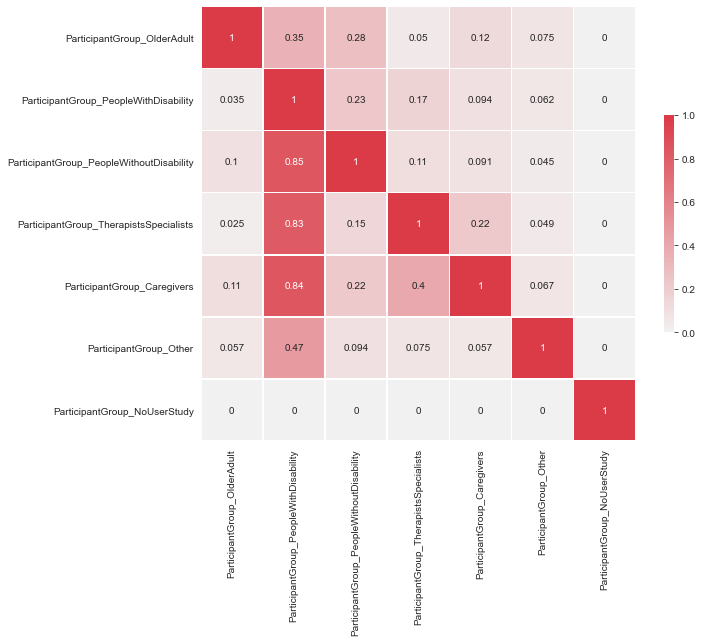



******** StudyLocation *******

** Raw sub-code co-occurrence count for StudyLocation **


StudyLocation_NearAtLab  \
StudyLocation_NearAtLab                                      130   
StudyLocation_ParticipantsHomeOrFreqLoc                       20   
StudyLocation_NeutralLocation                                  4   
StudyLocation_Unclear                                         10   
StudyLocation_OnlineRemotely                                  12   
StudyLocation_Other                                            0   
StudyLocation_NoUserStudy                                      0   

                                         StudyLocation_ParticipantsHomeOrFreqLoc  \
StudyLocation_NearAtLab                                                       20   
StudyLocation_ParticipantsHomeOrFreqLoc                                      138   
StudyLocation_NeutralLocation                                                  8   
StudyLocation_Unclear                                                         19   
StudyLocation_OnlineRemotely                                                  16   
StudyLocation_Other                                                            4   
StudyLocation_NoUserStudy                                                      0   

                                         StudyLocation_NeutralLocation  \
StudyLocation_NearAtLab                                              4   
StudyLocation_ParticipantsHomeOrFreqLoc                              8   
StudyLocation_NeutralLocation                                       32   
StudyLocation_Unclear                                                6   
StudyLocation_OnlineRemotely                                         4   
StudyLocation_Other                                                  1   
StudyLocation_NoUserStudy                                            0   

                                         StudyLocation_Unclear  \
StudyLocation_NearAtLab                                     10   
StudyLocation_ParticipantsHomeOrFreqLoc                     19   
StudyLocation_NeutralLocation                                6   
StudyLocation_Unclear                                      189   
StudyLocation_OnlineRemotely                                25   
StudyLocation_Other                                          4   
StudyLocation_NoUserStudy                                    0   

                                         StudyLocation_OnlineRemotely  \
StudyLocation_NearAtLab                                            12   
StudyLocation_ParticipantsHomeOrFreqLoc                            16   
StudyLocation_NeutralLocation                                       4   
StudyLocation_Unclear                                              25   
StudyLocation_OnlineRemotely                                       98   
StudyLocation_Other                                                 0   
StudyLocation_NoUserStudy                                           0   

                                         StudyLocation_Other  \
StudyLocation_NearAtLab                                    0   
StudyLocation_ParticipantsHomeOrFreqLoc                    4   
StudyLocation_NeutralLocation                              1   
StudyLocation_Unclear                                      4   
StudyLocation_OnlineRemotely                               0   
StudyLocation_Other                                        7   
StudyLocation_NoUserStudy                                  0   

                                         StudyLocation_NoUserStudy  
StudyLocation_NearAtLab                                          0  
StudyLocation_ParticipantsHomeOrFreqLoc                          0  
StudyLocation_NeutralLocation                                    0  
StudyLocation_Unclear                                            0  
StudyLocation_OnlineRemotely                                     0  
StudyLocation_Other                                              0  
StudyLocation_NoUserStudy                                       29

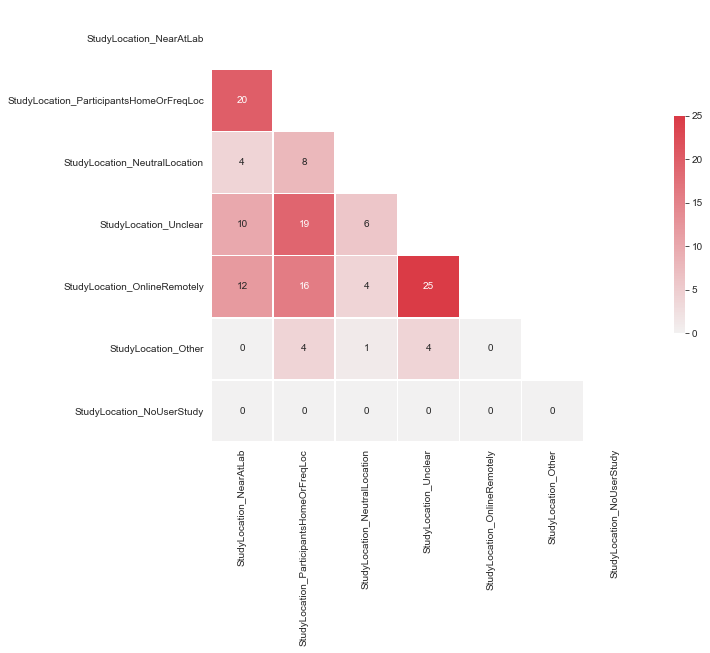

** Fraction of sub-code co-occurrences for StudyLocation **


StudyLocation_NearAtLab  \
StudyLocation_NearAtLab                                 1.000000   
StudyLocation_ParticipantsHomeOrFreqLoc                 0.144928   
StudyLocation_NeutralLocation                           0.125000   
StudyLocation_Unclear                                   0.052910   
StudyLocation_OnlineRemotely                            0.122449   
StudyLocation_Other                                     0.000000   
StudyLocation_NoUserStudy                               0.000000   

                                         StudyLocation_ParticipantsHomeOrFreqLoc  \
StudyLocation_NearAtLab                                                 0.153846   
StudyLocation_ParticipantsHomeOrFreqLoc                                 1.000000   
StudyLocation_NeutralLocation                                           0.250000   
StudyLocation_Unclear                                                   0.100529   
StudyLocation_OnlineRemotely                                            0.163265   
StudyLocation_Other                                                     0.571429   
StudyLocation_NoUserStudy                                               0.000000   

                                         StudyLocation_NeutralLocation  \
StudyLocation_NearAtLab                                       0.030769   
StudyLocation_ParticipantsHomeOrFreqLoc                       0.057971   
StudyLocation_NeutralLocation                                 1.000000   
StudyLocation_Unclear                                         0.031746   
StudyLocation_OnlineRemotely                                  0.040816   
StudyLocation_Other                                           0.142857   
StudyLocation_NoUserStudy                                     0.000000   

                                         StudyLocation_Unclear  \
StudyLocation_NearAtLab                               0.076923   
StudyLocation_ParticipantsHomeOrFreqLoc               0.137681   
StudyLocation_NeutralLocation                         0.187500   
StudyLocation_Unclear                                 1.000000   
StudyLocation_OnlineRemotely                          0.255102   
StudyLocation_Other                                   0.571429   
StudyLocation_NoUserStudy                             0.000000   

                                         StudyLocation_OnlineRemotely  \
StudyLocation_NearAtLab                                      0.092308   
StudyLocation_ParticipantsHomeOrFreqLoc                      0.115942   
StudyLocation_NeutralLocation                                0.125000   
StudyLocation_Unclear                                        0.132275   
StudyLocation_OnlineRemotely                                 1.000000   
StudyLocation_Other                                          0.000000   
StudyLocation_NoUserStudy                                    0.000000   

                                         StudyLocation_Other  \
StudyLocation_NearAtLab                             0.000000   
StudyLocation_ParticipantsHomeOrFreqLoc             0.028986   
StudyLocation_NeutralLocation                       0.031250   
StudyLocation_Unclear                               0.021164   
StudyLocation_OnlineRemotely                        0.000000   
StudyLocation_Other                                 1.000000   
StudyLocation_NoUserStudy                           0.000000   

                                         StudyLocation_NoUserStudy  
StudyLocation_NearAtLab                                        0.0  
StudyLocation_ParticipantsHomeOrFreqLoc                        0.0  
StudyLocation_NeutralLocation                                  0.0  
StudyLocation_Unclear                                          0.0  
StudyLocation_OnlineRemotely                                   0.0  
StudyLocation_Other                                            0.0  
StudyLocation_NoUserStudy                                      1.0

Read the co-occurrence matrix column-to-row. For example:
StudyLocation_ParticipantsHomeOrFreqLoc (column) occurs 138 times in 138 StudyLocation_ParticipantsHomeOrFreqLoc (row) instances 100.00%
StudyLocation_ParticipantsHomeOrFreqLoc (column) occurs 138 times in 138 StudyLocation_ParticipantsHomeOrFreqLoc (row) instances 100.00%
StudyLocation_NearAtLab (column) occurs 4 times in 32 StudyLocation_NeutralLocation (row) instances 12.50%
StudyLocation_NeutralLocation (column) occurs 4 times in 130 StudyLocation_NearAtLab (row) instances 3.08%
StudyLocation_NearAtLab (column) occurs 4 times in 32 StudyLocation_NeutralLocation (row) instances 12.50%
StudyLocation_NeutralLocation (column) occurs 4 times in 130 StudyLocation_NearAtLab (row) instances 3.08%



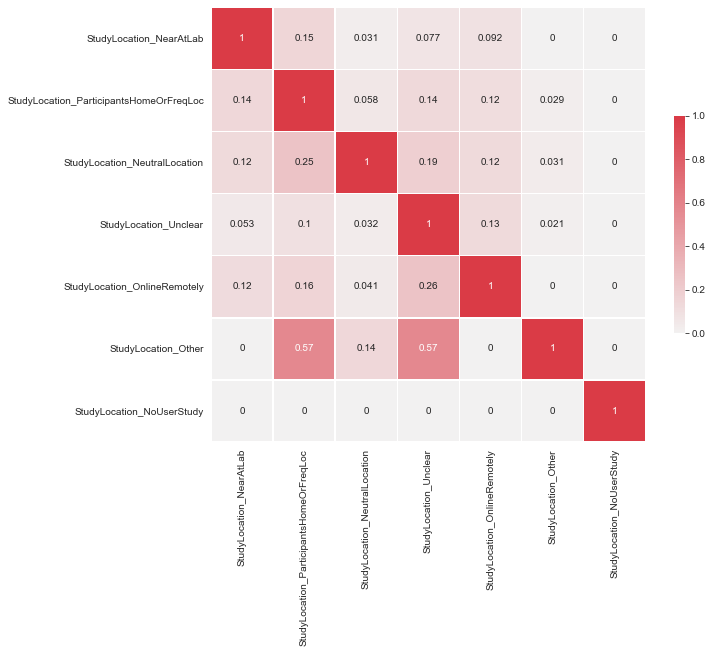



******** ParticipatoryDesign *******

** Raw sub-code co-occurrence count for ParticipatoryDesign **


ParticipatoryDesign_Yes  ParticipatoryDesign_No
ParticipatoryDesign_Yes                       49                       0
ParticipatoryDesign_No                         0                     457

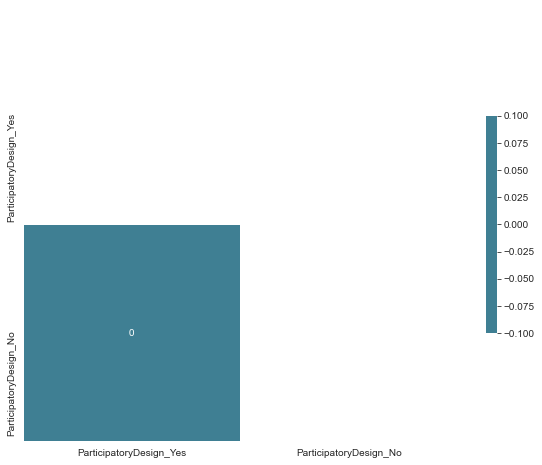

** Fraction of sub-code co-occurrences for ParticipatoryDesign **


ParticipatoryDesign_Yes  ParticipatoryDesign_No
ParticipatoryDesign_Yes                      1.0                     0.0
ParticipatoryDesign_No                       0.0                     1.0

Read the co-occurrence matrix column-to-row. For example:
ParticipatoryDesign_No (column) occurs 457 times in 457 ParticipatoryDesign_No (row) instances 100.00%
ParticipatoryDesign_No (column) occurs 457 times in 457 ParticipatoryDesign_No (row) instances 100.00%
ParticipatoryDesign_Yes (column) occurs 0 times in 457 ParticipatoryDesign_No (row) instances 0.00%
ParticipatoryDesign_No (column) occurs 0 times in 49 ParticipatoryDesign_Yes (row) instances 0.00%
ParticipatoryDesign_Yes (column) occurs 49 times in 49 ParticipatoryDesign_Yes (row) instances 100.00%
ParticipatoryDesign_Yes (column) occurs 49 times in 49 ParticipatoryDesign_Yes (row) instances 100.00%



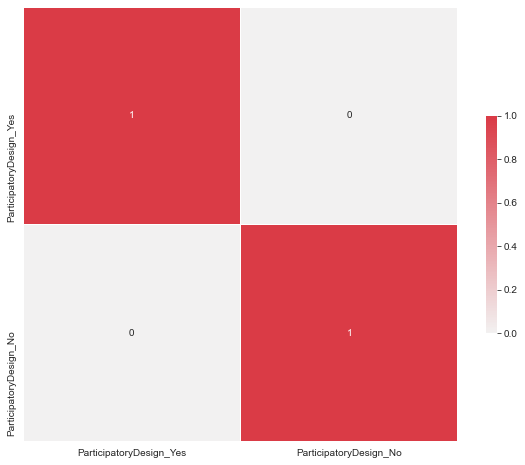



******** ComparesOnDisability *******

** Raw sub-code co-occurrence count for ComparesOnDisability **


ComparesOnDisability_Yes  ComparesOnDisability_No
ComparesOnDisability_Yes                        65                        0
ComparesOnDisability_No                          0                      441

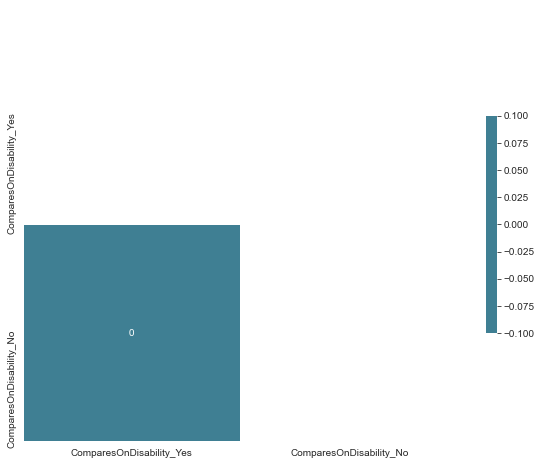

** Fraction of sub-code co-occurrences for ComparesOnDisability **


ComparesOnDisability_Yes  ComparesOnDisability_No
ComparesOnDisability_Yes                       1.0                      0.0
ComparesOnDisability_No                        0.0                      1.0

Read the co-occurrence matrix column-to-row. For example:
ComparesOnDisability_No (column) occurs 0 times in 65 ComparesOnDisability_Yes (row) instances 0.00%
ComparesOnDisability_Yes (column) occurs 0 times in 441 ComparesOnDisability_No (row) instances 0.00%
ComparesOnDisability_No (column) occurs 441 times in 441 ComparesOnDisability_No (row) instances 100.00%
ComparesOnDisability_No (column) occurs 441 times in 441 ComparesOnDisability_No (row) instances 100.00%
ComparesOnDisability_No (column) occurs 0 times in 65 ComparesOnDisability_Yes (row) instances 0.00%
ComparesOnDisability_Yes (column) occurs 0 times in 441 ComparesOnDisability_No (row) instances 0.00%



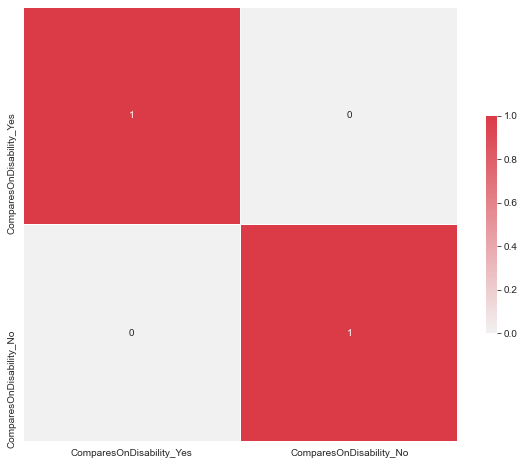



******** UsesProxies *******

** Raw sub-code co-occurrence count for UsesProxies **


UsesProxies_Yes  UsesProxies_No
UsesProxies_Yes               38               0
UsesProxies_No                 0             468

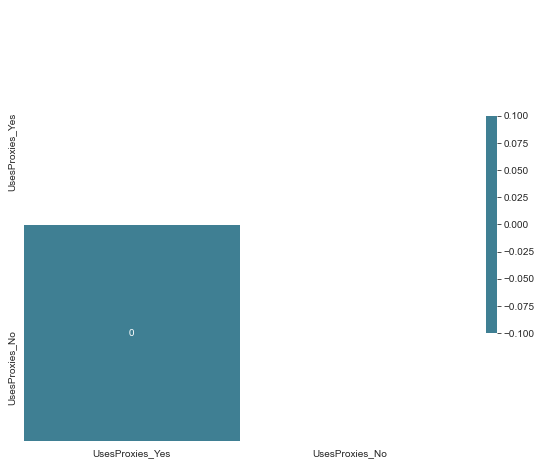

** Fraction of sub-code co-occurrences for UsesProxies **


UsesProxies_Yes  UsesProxies_No
UsesProxies_Yes              1.0             0.0
UsesProxies_No               0.0             1.0

Read the co-occurrence matrix column-to-row. For example:
UsesProxies_Yes (column) occurs 0 times in 468 UsesProxies_No (row) instances 0.00%
UsesProxies_No (column) occurs 0 times in 38 UsesProxies_Yes (row) instances 0.00%
UsesProxies_Yes (column) occurs 38 times in 38 UsesProxies_Yes (row) instances 100.00%
UsesProxies_Yes (column) occurs 38 times in 38 UsesProxies_Yes (row) instances 100.00%
UsesProxies_Yes (column) occurs 0 times in 468 UsesProxies_No (row) instances 0.00%
UsesProxies_No (column) occurs 0 times in 38 UsesProxies_Yes (row) instances 0.00%



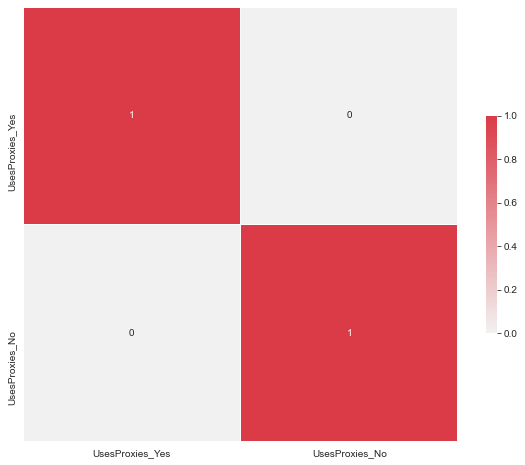

In [85]:
# Print out co-occurrence information
for code_cat, sub_codes in map_codes.items():
    
    if code_cat == 'NumParticipants' or code_cat == 'NumUserStudies':
        continue # these categories
    
    # col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
    df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac = calc_within_code_co_occurrence_matrix(code_cat)
    
    print(f"\n\n******** {code_cat} *******\n")
    print(f"** Raw sub-code co-occurrence count for {code_cat} **")
    display(df_co_occurrence_subcode_cnt)
    plot_co_occurrence_cnt_matrix(df_co_occurrence_subcode_cnt)
    
    print(f"** Fraction of sub-code co-occurrences for {code_cat} **")
    display(df_co_occurrence_subcode_frac)
    plot_co_occurrence_fraction_matrix(df_co_occurrence_subcode_frac, df_co_occurrence_subcode_cnt)
    

## Cross-code co-occurrence matrices

In [86]:
def calc_cross_code_co_occurrence_matrix(code_cat1, code_cat2):
    '''
    Calculates the frequency with which each sub-code in the first code category (code_cat1) co-occurs with
    each sub-code in the second code category (code_cat2)
    '''
    
    # Create empty dataframes to store matrices:
    # df_co_occurrence_subcode_cnt is a count of co-occurrence
    # df_co_occurrence_subcode_frac is a fraction of co-occurrence
    codecat1_subcode_cols = map_codes_to_cols[code_cat1]
    codecat2_subcode_cols = map_codes_to_cols[code_cat2]
    
    # Pandas refers to table columns as 'columns' as table rows as 'index'
    df_co_occurrence_subcode_cnt = pd.DataFrame(columns=codecat1_subcode_cols, index=codecat2_subcode_cols)
    df_co_occurrence_subcode_frac_of_col = pd.DataFrame(columns=codecat1_subcode_cols, index=codecat2_subcode_cols)
    df_co_occurrence_subcode_frac_of_row = pd.DataFrame(columns=codecat1_subcode_cols, index=codecat2_subcode_cols)
    series_sum_codecat1_subcode_occurrence = df[codecat1_subcode_cols].sum() # these are our cols
    series_sum_codecat2_subcode_occurrence = df[codecat2_subcode_cols].sum() # these are our rows
    
    for codecat1_subcode_col in codecat1_subcode_cols:
        for codecat2_subcode_col in codecat2_subcode_cols:   
            # Run co-occurrence query
            co_occurrence_count = len(df[(df[codecat1_subcode_col] == 1) & (df[codecat2_subcode_col] == 1)])
            
            codecat1_subcode_cnt = series_sum_codecat1_subcode_occurrence[codecat1_subcode_col]
            codecat2_subcode_cnt = series_sum_codecat2_subcode_occurrence[codecat2_subcode_col] 
            co_occurrence_frac_of_codecat1 = co_occurrence_count / codecat1_subcode_cnt
            co_occurrence_frac_of_codecat2 = co_occurrence_count / codecat2_subcode_cnt
            
            # DEBUG PRINTS
            # print(f"{codecat1_subcode_col} and {codecat2_subcode_col} co-occur {co_occurrence_count} times")
            # print(f"  {co_occurrence_count} is {co_occurrence_frac_of_codecat1 * 100}% of {codecat1_subcode_cnt} total {codecat1_subcode_col} occurrences and...")
            # print(f"  {co_occurrence_count} is {co_occurrence_frac_of_codecat2 * 100}% of {codecat2_subcode_cnt} total {codecat2_subcode_col} occurrences")
            
            # Set co-occurrence data into appropriate table cells
            df_co_occurrence_subcode_cnt.loc[codecat2_subcode_col, codecat1_subcode_col] = co_occurrence_count
            df_co_occurrence_subcode_frac_of_col.loc[codecat2_subcode_col, codecat1_subcode_col] = co_occurrence_frac_of_codecat1
            df_co_occurrence_subcode_frac_of_row.loc[codecat2_subcode_col, codecat1_subcode_col] = co_occurrence_frac_of_codecat2
            

    # Need to force the fractions to floating point
    df_co_occurrence_subcode_cnt = df_co_occurrence_subcode_cnt.astype(int)
    df_co_occurrence_subcode_frac_of_col = df_co_occurrence_subcode_frac_of_col.astype(float)
    df_co_occurrence_subcode_frac_of_row = df_co_occurrence_subcode_frac_of_row.astype(float)
    
    return df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac_of_col, df_co_occurrence_subcode_frac_of_row



******** CommunityOfFocus and IssueAddressed *******

** Raw sub-code co-occurrence count for CommunityOfFocus and IssueAddressed **


CommunityOfFocus_BVI  \
IssueAddressed_IncreaseDigitalAccess                                 106   
IssueAddressed_IncreasePhysicalAccess                                 77   
IssueAddressed_IncreaseIndependence                                   63   
IssueAddressed_IncreaseUnderstandingOfUsers                           47   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     5   
IssueAddressed_SupportCommunication                                   10   
IssueAddressed_Other                                                  21   

                                                    CommunityOfFocus_DHH  \
IssueAddressed_IncreaseDigitalAccess                                  11   
IssueAddressed_IncreasePhysicalAccess                                  6   
IssueAddressed_IncreaseIndependence                                    0   
IssueAddressed_IncreaseUnderstandingOfUsers                           15   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     1   
IssueAddressed_SupportCommunication                                   37   
IssueAddressed_Other                                                   4   

                                                    CommunityOfFocus_IDD  \
IssueAddressed_IncreaseDigitalAccess                                   0   
IssueAddressed_IncreasePhysicalAccess                                  1   
IssueAddressed_IncreaseIndependence                                    6   
IssueAddressed_IncreaseUnderstandingOfUsers                            2   
IssueAddressed_HelpWithPersonalInformaticsBehav...                     5   
IssueAddressed_SupportCommunication                                    1   
IssueAddressed_Other                                                   3   

                                                    CommunityOfFocus_MotorPhysical  \
IssueAddressed_IncreaseDigitalAccess                                            29   
IssueAddressed_IncreasePhysicalAccess                                           16   
IssueAddressed_IncreaseIndependence                                              9   
IssueAddressed_IncreaseUnderstandingOfUsers                                     21   
IssueAddressed_HelpWithPersonalInformaticsBehav...                               7   
IssueAddressed_SupportCommunication                                              5   
IssueAddressed_Other                                                            10   

                                                    CommunityOfFocus_Autism  \
IssueAddressed_IncreaseDigitalAccess                                      4   
IssueAddressed_IncreasePhysicalAccess                                     0   
IssueAddressed_IncreaseIndependence                                       1   
IssueAddressed_IncreaseUnderstandingOfUsers                              10   
IssueAddressed_HelpWithPersonalInformaticsBehav...                       10   
IssueAddressed_SupportCommunication                                       8   
IssueAddressed_Other                                                      4   

                                                    CommunityOfFocus_Cognitive  \
IssueAddressed_IncreaseDigitalAccess                                         8   
IssueAddressed_IncreasePhysicalAccess                                        3   
IssueAddressed_IncreaseIndependence                                          9   
IssueAddressed_IncreaseUnderstandingOfUsers                                 17   
IssueAddressed_HelpWithPersonalInformaticsBehav...                           6   
IssueAddressed_SupportCommunication                                         12   
IssueAddressed_Other                                                         7   

                                                    CommunityOfFocus_OlderAdult  \
IssueAddressed_IncreaseDigitalAccess                                         16   
IssueAddressed_IncreasePhysicalAccess                                         5 

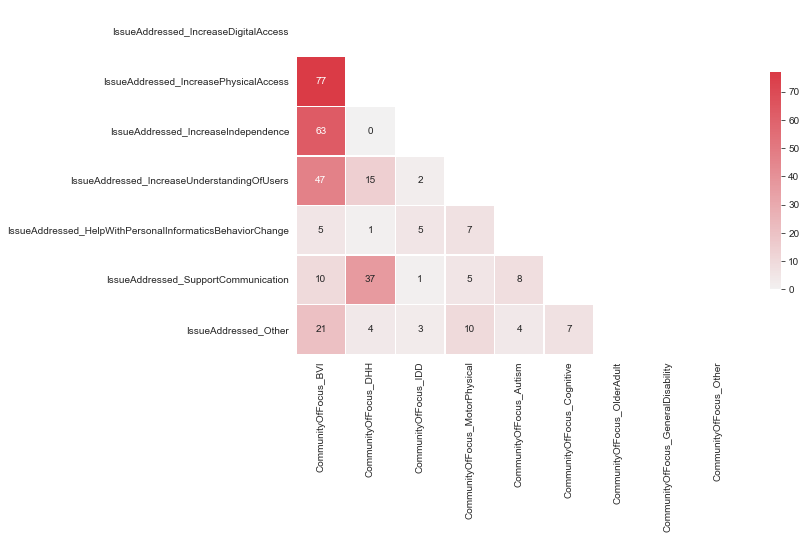

** Fraction of sub-code co-occurrences for CommunityOfFocus and IssueAddressed (divisor is column sum) **


CommunityOfFocus_BVI  \
IssueAddressed_IncreaseDigitalAccess                            0.481818   
IssueAddressed_IncreasePhysicalAccess                           0.350000   
IssueAddressed_IncreaseIndependence                             0.286364   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.213636   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.022727   
IssueAddressed_SupportCommunication                             0.045455   
IssueAddressed_Other                                            0.095455   

                                                    CommunityOfFocus_DHH  \
IssueAddressed_IncreaseDigitalAccess                            0.192982   
IssueAddressed_IncreasePhysicalAccess                           0.105263   
IssueAddressed_IncreaseIndependence                             0.000000   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.263158   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.017544   
IssueAddressed_SupportCommunication                             0.649123   
IssueAddressed_Other                                            0.070175   

                                                    CommunityOfFocus_IDD  \
IssueAddressed_IncreaseDigitalAccess                            0.000000   
IssueAddressed_IncreasePhysicalAccess                           0.071429   
IssueAddressed_IncreaseIndependence                             0.428571   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.142857   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.357143   
IssueAddressed_SupportCommunication                             0.071429   
IssueAddressed_Other                                            0.214286   

                                                    CommunityOfFocus_MotorPhysical  \
IssueAddressed_IncreaseDigitalAccess                                      0.402778   
IssueAddressed_IncreasePhysicalAccess                                     0.222222   
IssueAddressed_IncreaseIndependence                                       0.125000   
IssueAddressed_IncreaseUnderstandingOfUsers                               0.291667   
IssueAddressed_HelpWithPersonalInformaticsBehav...                        0.097222   
IssueAddressed_SupportCommunication                                       0.069444   
IssueAddressed_Other                                                      0.138889   

                                                    CommunityOfFocus_Autism  \
IssueAddressed_IncreaseDigitalAccess                               0.129032   
IssueAddressed_IncreasePhysicalAccess                              0.000000   
IssueAddressed_IncreaseIndependence                                0.032258   
IssueAddressed_IncreaseUnderstandingOfUsers                        0.322581   
IssueAddressed_HelpWithPersonalInformaticsBehav...                 0.322581   
IssueAddressed_SupportCommunication                                0.258065   
IssueAddressed_Other                                               0.129032   

                                                    CommunityOfFocus_Cognitive  \
IssueAddressed_IncreaseDigitalAccess                                  0.173913   
IssueAddressed_IncreasePhysicalAccess                                 0.065217   
IssueAddressed_IncreaseIndependence                                   0.195652   
IssueAddressed_IncreaseUnderstandingOfUsers                           0.369565   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    0.130435   
IssueAddressed_SupportCommunication                                   0.260870   
IssueAddressed_Other                                                  0.152174   

                                                    CommunityOfFocus_OlderAdult  \
IssueAddressed_IncreaseDigitalAccess                                   0.355556   
IssueAddressed_IncreasePhysicalAccess                                  0.111111 

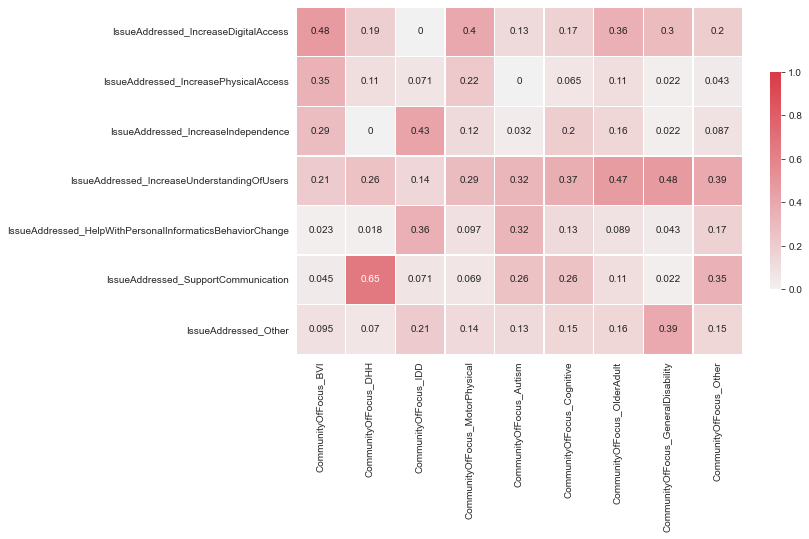

** Fraction of sub-code co-occurrences for CommunityOfFocus and IssueAddressed (divisor is row sum) **


CommunityOfFocus_BVI  \
IssueAddressed_IncreaseDigitalAccess                            0.569892   
IssueAddressed_IncreasePhysicalAccess                           0.733333   
IssueAddressed_IncreaseIndependence                             0.677419   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.338129   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.128205   
IssueAddressed_SupportCommunication                             0.123457   
IssueAddressed_Other                                            0.355932   

                                                    CommunityOfFocus_DHH  \
IssueAddressed_IncreaseDigitalAccess                            0.059140   
IssueAddressed_IncreasePhysicalAccess                           0.057143   
IssueAddressed_IncreaseIndependence                             0.000000   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.107914   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.025641   
IssueAddressed_SupportCommunication                             0.456790   
IssueAddressed_Other                                            0.067797   

                                                    CommunityOfFocus_IDD  \
IssueAddressed_IncreaseDigitalAccess                            0.000000   
IssueAddressed_IncreasePhysicalAccess                           0.009524   
IssueAddressed_IncreaseIndependence                             0.064516   
IssueAddressed_IncreaseUnderstandingOfUsers                     0.014388   
IssueAddressed_HelpWithPersonalInformaticsBehav...              0.128205   
IssueAddressed_SupportCommunication                             0.012346   
IssueAddressed_Other                                            0.050847   

                                                    CommunityOfFocus_MotorPhysical  \
IssueAddressed_IncreaseDigitalAccess                                      0.155914   
IssueAddressed_IncreasePhysicalAccess                                     0.152381   
IssueAddressed_IncreaseIndependence                                       0.096774   
IssueAddressed_IncreaseUnderstandingOfUsers                               0.151079   
IssueAddressed_HelpWithPersonalInformaticsBehav...                        0.179487   
IssueAddressed_SupportCommunication                                       0.061728   
IssueAddressed_Other                                                      0.169492   

                                                    CommunityOfFocus_Autism  \
IssueAddressed_IncreaseDigitalAccess                               0.021505   
IssueAddressed_IncreasePhysicalAccess                              0.000000   
IssueAddressed_IncreaseIndependence                                0.010753   
IssueAddressed_IncreaseUnderstandingOfUsers                        0.071942   
IssueAddressed_HelpWithPersonalInformaticsBehav...                 0.256410   
IssueAddressed_SupportCommunication                                0.098765   
IssueAddressed_Other                                               0.067797   

                                                    CommunityOfFocus_Cognitive  \
IssueAddressed_IncreaseDigitalAccess                                  0.043011   
IssueAddressed_IncreasePhysicalAccess                                 0.028571   
IssueAddressed_IncreaseIndependence                                   0.096774   
IssueAddressed_IncreaseUnderstandingOfUsers                           0.122302   
IssueAddressed_HelpWithPersonalInformaticsBehav...                    0.153846   
IssueAddressed_SupportCommunication                                   0.148148   
IssueAddressed_Other                                                  0.118644   

                                                    CommunityOfFocus_OlderAdult  \
IssueAddressed_IncreaseDigitalAccess                                   0.086022   
IssueAddressed_IncreasePhysicalAccess                                  0.047619 

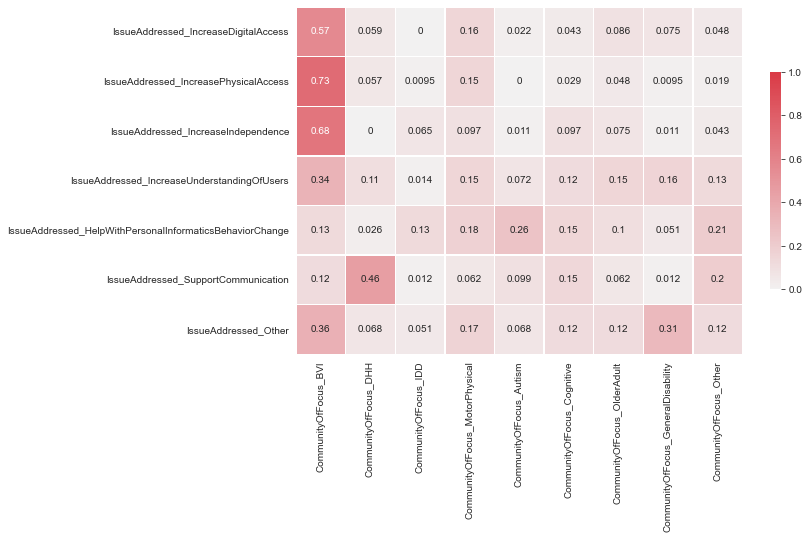



******** CommunityOfFocus and ContributionType *******

** Raw sub-code co-occurrence count for CommunityOfFocus and ContributionType **


CommunityOfFocus_BVI  \
ContributionType_Empirical                            121   
ContributionType_Artifact                             143   
ContributionType_Methodological                         3   
ContributionType_Theoretical                           16   
ContributionType_Dataset                                2   
ContributionType_SurveyContribution                     1   

                                     CommunityOfFocus_DHH  \
ContributionType_Empirical                             42   
ContributionType_Artifact                              24   
ContributionType_Methodological                         2   
ContributionType_Theoretical                            3   
ContributionType_Dataset                                1   
ContributionType_SurveyContribution                     0   

                                     CommunityOfFocus_IDD  \
ContributionType_Empirical                              7   
ContributionType_Artifact                               9   
ContributionType_Methodological                         1   
ContributionType_Theoretical                            1   
ContributionType_Dataset                                0   
ContributionType_SurveyContribution                     0   

                                     CommunityOfFocus_MotorPhysical  \
ContributionType_Empirical                                       45   
ContributionType_Artifact                                        39   
ContributionType_Methodological                                   2   
ContributionType_Theoretical                                      6   
ContributionType_Dataset                                          2   
ContributionType_SurveyContribution                               0   

                                     CommunityOfFocus_Autism  \
ContributionType_Empirical                                18   
ContributionType_Artifact                                 14   
ContributionType_Methodological                            4   
ContributionType_Theoretical                               4   
ContributionType_Dataset                                   0   
ContributionType_SurveyContribution                        1   

                                     CommunityOfFocus_Cognitive  \
ContributionType_Empirical                                   26   
ContributionType_Artifact                                    25   
ContributionType_Methodological                               3   
ContributionType_Theoretical                                  4   
ContributionType_Dataset                                      2   
ContributionType_SurveyContribution                           0   

                                     CommunityOfFocus_OlderAdult  \
ContributionType_Empirical                                    31   
ContributionType_Artifact                                     21   
ContributionType_Methodological                                3   
ContributionType_Theoretical                                   5   
ContributionType_Dataset                                       1   
ContributionType_SurveyContribution                            0   

                                     CommunityOfFocus_GeneralDisability  \
ContributionType_Empirical                                           35   
ContributionType_Artifact                                             9   
ContributionType_Methodological                                       4   
ContributionType_Theoretical                                         10   
ContributionType_Dataset                                              0   
ContributionType_SurveyContribution                                   2   

                                     CommunityOfFocus_Other  
ContributionType_Empirical                               27  
ContributionType_Artifact                                27  
ContributionType_Methodological                           3  
ContributionType_Theoretical                              4  
ContributionType_Datase

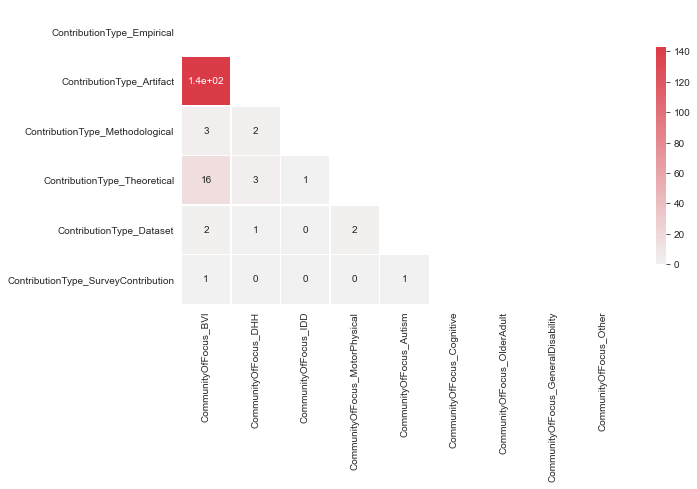

** Fraction of sub-code co-occurrences for CommunityOfFocus and ContributionType (divisor is column sum) **


CommunityOfFocus_BVI  \
ContributionType_Empirical                       0.550000   
ContributionType_Artifact                        0.650000   
ContributionType_Methodological                  0.013636   
ContributionType_Theoretical                     0.072727   
ContributionType_Dataset                         0.009091   
ContributionType_SurveyContribution              0.004545   

                                     CommunityOfFocus_DHH  \
ContributionType_Empirical                       0.736842   
ContributionType_Artifact                        0.421053   
ContributionType_Methodological                  0.035088   
ContributionType_Theoretical                     0.052632   
ContributionType_Dataset                         0.017544   
ContributionType_SurveyContribution              0.000000   

                                     CommunityOfFocus_IDD  \
ContributionType_Empirical                       0.500000   
ContributionType_Artifact                        0.642857   
ContributionType_Methodological                  0.071429   
ContributionType_Theoretical                     0.071429   
ContributionType_Dataset                         0.000000   
ContributionType_SurveyContribution              0.000000   

                                     CommunityOfFocus_MotorPhysical  \
ContributionType_Empirical                                 0.625000   
ContributionType_Artifact                                  0.541667   
ContributionType_Methodological                            0.027778   
ContributionType_Theoretical                               0.083333   
ContributionType_Dataset                                   0.027778   
ContributionType_SurveyContribution                        0.000000   

                                     CommunityOfFocus_Autism  \
ContributionType_Empirical                          0.580645   
ContributionType_Artifact                           0.451613   
ContributionType_Methodological                     0.129032   
ContributionType_Theoretical                        0.129032   
ContributionType_Dataset                            0.000000   
ContributionType_SurveyContribution                 0.032258   

                                     CommunityOfFocus_Cognitive  \
ContributionType_Empirical                             0.565217   
ContributionType_Artifact                              0.543478   
ContributionType_Methodological                        0.065217   
ContributionType_Theoretical                           0.086957   
ContributionType_Dataset                               0.043478   
ContributionType_SurveyContribution                    0.000000   

                                     CommunityOfFocus_OlderAdult  \
ContributionType_Empirical                              0.688889   
ContributionType_Artifact                               0.466667   
ContributionType_Methodological                         0.066667   
ContributionType_Theoretical                            0.111111   
ContributionType_Dataset                                0.022222   
ContributionType_SurveyContribution                     0.000000   

                                     CommunityOfFocus_GeneralDisability  \
ContributionType_Empirical                                     0.760870   
ContributionType_Artifact                                      0.195652   
ContributionType_Methodological                                0.086957   
ContributionType_Theoretical                                   0.217391   
ContributionType_Dataset                                       0.000000   
ContributionType_SurveyContribution                            0.043478   

                                     CommunityOfFocus_Other  
ContributionType_Empirical                         0.586957  
ContributionType_Artifact                          0.586957  
ContributionType_Methodological                    0.065217  
ContributionType_Theoretical                       0.086957  
ContributionType_Datase

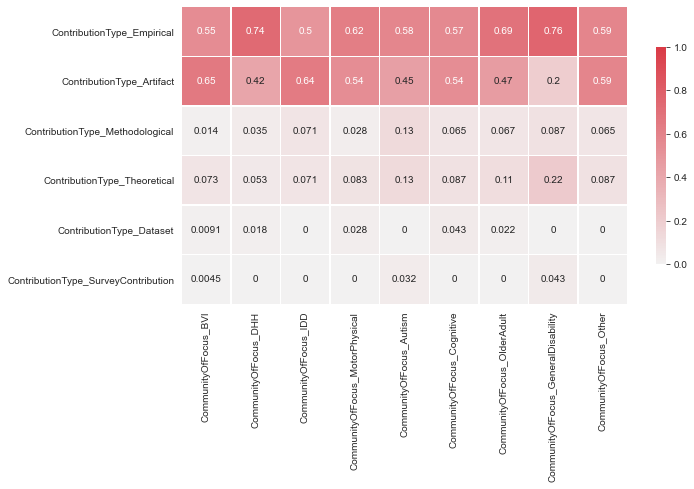

** Fraction of sub-code co-occurrences for CommunityOfFocus and ContributionType (divisor is row sum) **


CommunityOfFocus_BVI  \
ContributionType_Empirical                       0.396721   
ContributionType_Artifact                        0.508897   
ContributionType_Methodological                  0.187500   
ContributionType_Theoretical                     0.363636   
ContributionType_Dataset                         0.285714   
ContributionType_SurveyContribution              0.333333   

                                     CommunityOfFocus_DHH  \
ContributionType_Empirical                       0.137705   
ContributionType_Artifact                        0.085409   
ContributionType_Methodological                  0.125000   
ContributionType_Theoretical                     0.068182   
ContributionType_Dataset                         0.142857   
ContributionType_SurveyContribution              0.000000   

                                     CommunityOfFocus_IDD  \
ContributionType_Empirical                       0.022951   
ContributionType_Artifact                        0.032028   
ContributionType_Methodological                  0.062500   
ContributionType_Theoretical                     0.022727   
ContributionType_Dataset                         0.000000   
ContributionType_SurveyContribution              0.000000   

                                     CommunityOfFocus_MotorPhysical  \
ContributionType_Empirical                                 0.147541   
ContributionType_Artifact                                  0.138790   
ContributionType_Methodological                            0.125000   
ContributionType_Theoretical                               0.136364   
ContributionType_Dataset                                   0.285714   
ContributionType_SurveyContribution                        0.000000   

                                     CommunityOfFocus_Autism  \
ContributionType_Empirical                          0.059016   
ContributionType_Artifact                           0.049822   
ContributionType_Methodological                     0.250000   
ContributionType_Theoretical                        0.090909   
ContributionType_Dataset                            0.000000   
ContributionType_SurveyContribution                 0.333333   

                                     CommunityOfFocus_Cognitive  \
ContributionType_Empirical                             0.085246   
ContributionType_Artifact                              0.088968   
ContributionType_Methodological                        0.187500   
ContributionType_Theoretical                           0.090909   
ContributionType_Dataset                               0.285714   
ContributionType_SurveyContribution                    0.000000   

                                     CommunityOfFocus_OlderAdult  \
ContributionType_Empirical                              0.101639   
ContributionType_Artifact                               0.074733   
ContributionType_Methodological                         0.187500   
ContributionType_Theoretical                            0.113636   
ContributionType_Dataset                                0.142857   
ContributionType_SurveyContribution                     0.000000   

                                     CommunityOfFocus_GeneralDisability  \
ContributionType_Empirical                                     0.114754   
ContributionType_Artifact                                      0.032028   
ContributionType_Methodological                                0.250000   
ContributionType_Theoretical                                   0.227273   
ContributionType_Dataset                                       0.000000   
ContributionType_SurveyContribution                            0.666667   

                                     CommunityOfFocus_Other  
ContributionType_Empirical                         0.088525  
ContributionType_Artifact                          0.096085  
ContributionType_Methodological                    0.187500  
ContributionType_Theoretical                       0.090909  
ContributionType_Datase

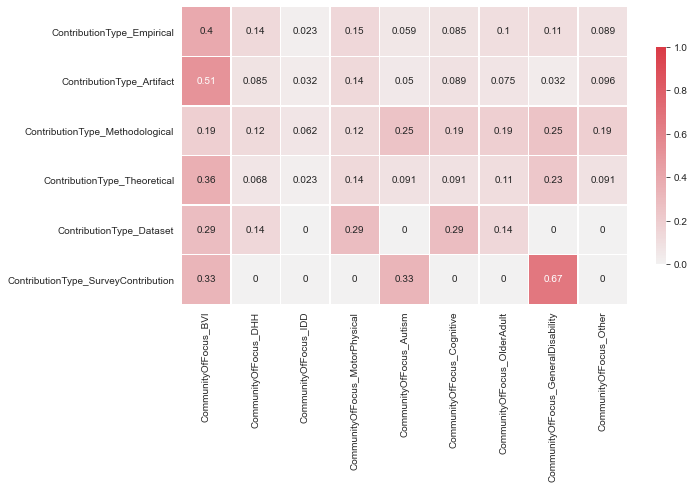



******** CommunityOfFocus and StudyMethod *******

** Raw sub-code co-occurrence count for CommunityOfFocus and StudyMethod **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
StudyMethod_ControlledExperiment                    68                    30   
StudyMethod_SurveyMethod                            52                    20   
StudyMethod_UsabilityTesting                       122                    17   
StudyMethod_Interviews                              91                    17   
StudyMethod_CaseStudy                                3                     3   
StudyMethod_FocusGroups                             12                     2   
StudyMethod_FieldStudy                              27                     7   
StudyMethod_WorkshopDesign                          38                     6   
StudyMethod_Other                                   40                     8   

                                  CommunityOfFocus_IDD  \
StudyMethod_ControlledExperiment                     1   
StudyMethod_SurveyMethod                             1   
StudyMethod_UsabilityTesting                         4   
StudyMethod_Interviews                               9   
StudyMethod_CaseStudy                                1   
StudyMethod_FocusGroups                              1   
StudyMethod_FieldStudy                               5   
StudyMethod_WorkshopDesign                           5   
StudyMethod_Other                                    2   

                                  CommunityOfFocus_MotorPhysical  \
StudyMethod_ControlledExperiment                              24   
StudyMethod_SurveyMethod                                      21   
StudyMethod_UsabilityTesting                                  25   
StudyMethod_Interviews                                        35   
StudyMethod_CaseStudy                                          5   
StudyMethod_FocusGroups                                        3   
StudyMethod_FieldStudy                                        20   
StudyMethod_WorkshopDesign                                    15   
StudyMethod_Other                                             18   

                                  CommunityOfFocus_Autism  \
StudyMethod_ControlledExperiment                       11   
StudyMethod_SurveyMethod                                2   
StudyMethod_UsabilityTesting                            5   
StudyMethod_Interviews                                 15   
StudyMethod_CaseStudy                                   1   
StudyMethod_FocusGroups                                 3   
StudyMethod_FieldStudy                                 13   
StudyMethod_WorkshopDesign                              8   
StudyMethod_Other                                       6   

                                  CommunityOfFocus_Cognitive  \
StudyMethod_ControlledExperiment                          13   
StudyMethod_SurveyMethod                                   7   
StudyMethod_UsabilityTesting                              13   
StudyMethod_Interviews                                    16   
StudyMethod_CaseStudy                                      6   
StudyMethod_FocusGroups                                    4   
StudyMethod_FieldStudy                                    12   
StudyMethod_WorkshopDesign                                10   
StudyMethod_Other                                          5   

                                  CommunityOfFocus_OlderAdult  \
StudyMethod_ControlledExperiment                           19   
StudyMethod_SurveyMethod                                    9   
StudyMethod_UsabilityTesting                               15   
StudyMethod_Interviews                                     20   
StudyMethod_CaseStudy                                       3   
StudyMethod_FocusGroups                                     5   
StudyMethod_FieldStudy                                      5   
StudyMethod_WorkshopDesign                                  6   
StudyMethod_Other                                           7   

                                  CommunityOfFocus_GeneralDisability

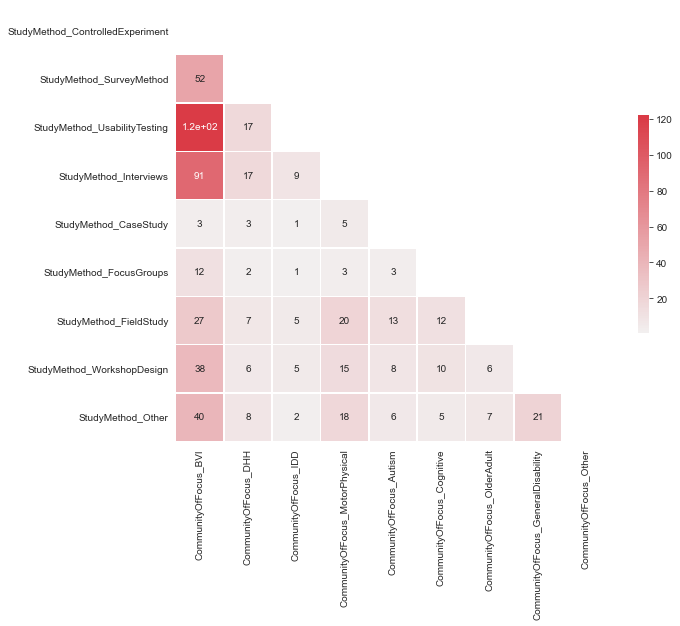

** Fraction of sub-code co-occurrences for CommunityOfFocus and StudyMethod (divisor is column sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
StudyMethod_ControlledExperiment              0.309091              0.526316   
StudyMethod_SurveyMethod                      0.236364              0.350877   
StudyMethod_UsabilityTesting                  0.554545              0.298246   
StudyMethod_Interviews                        0.413636              0.298246   
StudyMethod_CaseStudy                         0.013636              0.052632   
StudyMethod_FocusGroups                       0.054545              0.035088   
StudyMethod_FieldStudy                        0.122727              0.122807   
StudyMethod_WorkshopDesign                    0.172727              0.105263   
StudyMethod_Other                             0.181818              0.140351   

                                  CommunityOfFocus_IDD  \
StudyMethod_ControlledExperiment              0.071429   
StudyMethod_SurveyMethod                      0.071429   
StudyMethod_UsabilityTesting                  0.285714   
StudyMethod_Interviews                        0.642857   
StudyMethod_CaseStudy                         0.071429   
StudyMethod_FocusGroups                       0.071429   
StudyMethod_FieldStudy                        0.357143   
StudyMethod_WorkshopDesign                    0.357143   
StudyMethod_Other                             0.142857   

                                  CommunityOfFocus_MotorPhysical  \
StudyMethod_ControlledExperiment                        0.333333   
StudyMethod_SurveyMethod                                0.291667   
StudyMethod_UsabilityTesting                            0.347222   
StudyMethod_Interviews                                  0.486111   
StudyMethod_CaseStudy                                   0.069444   
StudyMethod_FocusGroups                                 0.041667   
StudyMethod_FieldStudy                                  0.277778   
StudyMethod_WorkshopDesign                              0.208333   
StudyMethod_Other                                       0.250000   

                                  CommunityOfFocus_Autism  \
StudyMethod_ControlledExperiment                 0.354839   
StudyMethod_SurveyMethod                         0.064516   
StudyMethod_UsabilityTesting                     0.161290   
StudyMethod_Interviews                           0.483871   
StudyMethod_CaseStudy                            0.032258   
StudyMethod_FocusGroups                          0.096774   
StudyMethod_FieldStudy                           0.419355   
StudyMethod_WorkshopDesign                       0.258065   
StudyMethod_Other                                0.193548   

                                  CommunityOfFocus_Cognitive  \
StudyMethod_ControlledExperiment                    0.282609   
StudyMethod_SurveyMethod                            0.152174   
StudyMethod_UsabilityTesting                        0.282609   
StudyMethod_Interviews                              0.347826   
StudyMethod_CaseStudy                               0.130435   
StudyMethod_FocusGroups                             0.086957   
StudyMethod_FieldStudy                              0.260870   
StudyMethod_WorkshopDesign                          0.217391   
StudyMethod_Other                                   0.108696   

                                  CommunityOfFocus_OlderAdult  \
StudyMethod_ControlledExperiment                     0.422222   
StudyMethod_SurveyMethod                             0.200000   
StudyMethod_UsabilityTesting                         0.333333   
StudyMethod_Interviews                               0.444444   
StudyMethod_CaseStudy                                0.066667   
StudyMethod_FocusGroups                              0.111111   
StudyMethod_FieldStudy                               0.111111   
StudyMethod_WorkshopDesign                           0.133333   
StudyMethod_Other                                    0.155556   

                                  CommunityOfFocus_GeneralDisability

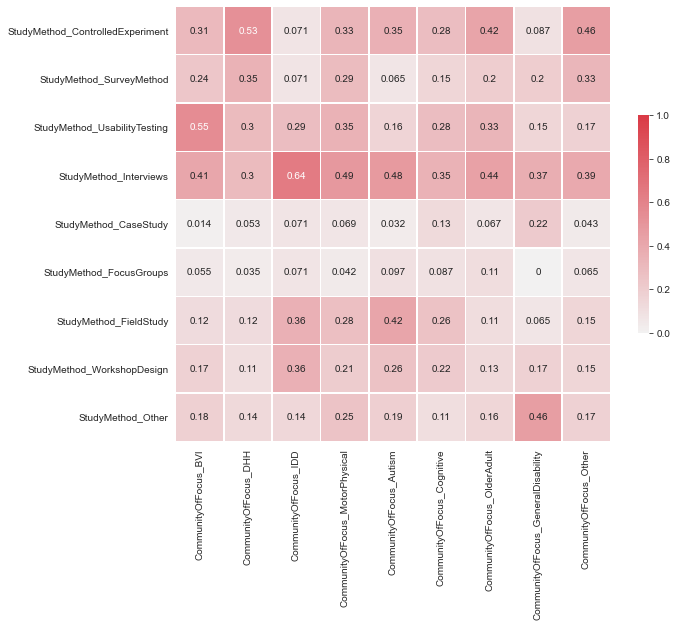

** Fraction of sub-code co-occurrences for CommunityOfFocus and StudyMethod (divisor is row sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
StudyMethod_ControlledExperiment              0.407186              0.179641   
StudyMethod_SurveyMethod                      0.426230              0.163934   
StudyMethod_UsabilityTesting                  0.613065              0.085427   
StudyMethod_Interviews                        0.452736              0.084577   
StudyMethod_CaseStudy                         0.120000              0.120000   
StudyMethod_FocusGroups                       0.428571              0.071429   
StudyMethod_FieldStudy                        0.317647              0.082353   
StudyMethod_WorkshopDesign                    0.431818              0.068182   
StudyMethod_Other                             0.404040              0.080808   

                                  CommunityOfFocus_IDD  \
StudyMethod_ControlledExperiment              0.005988   
StudyMethod_SurveyMethod                      0.008197   
StudyMethod_UsabilityTesting                  0.020101   
StudyMethod_Interviews                        0.044776   
StudyMethod_CaseStudy                         0.040000   
StudyMethod_FocusGroups                       0.035714   
StudyMethod_FieldStudy                        0.058824   
StudyMethod_WorkshopDesign                    0.056818   
StudyMethod_Other                             0.020202   

                                  CommunityOfFocus_MotorPhysical  \
StudyMethod_ControlledExperiment                        0.143713   
StudyMethod_SurveyMethod                                0.172131   
StudyMethod_UsabilityTesting                            0.125628   
StudyMethod_Interviews                                  0.174129   
StudyMethod_CaseStudy                                   0.200000   
StudyMethod_FocusGroups                                 0.107143   
StudyMethod_FieldStudy                                  0.235294   
StudyMethod_WorkshopDesign                              0.170455   
StudyMethod_Other                                       0.181818   

                                  CommunityOfFocus_Autism  \
StudyMethod_ControlledExperiment                 0.065868   
StudyMethod_SurveyMethod                         0.016393   
StudyMethod_UsabilityTesting                     0.025126   
StudyMethod_Interviews                           0.074627   
StudyMethod_CaseStudy                            0.040000   
StudyMethod_FocusGroups                          0.107143   
StudyMethod_FieldStudy                           0.152941   
StudyMethod_WorkshopDesign                       0.090909   
StudyMethod_Other                                0.060606   

                                  CommunityOfFocus_Cognitive  \
StudyMethod_ControlledExperiment                    0.077844   
StudyMethod_SurveyMethod                            0.057377   
StudyMethod_UsabilityTesting                        0.065327   
StudyMethod_Interviews                              0.079602   
StudyMethod_CaseStudy                               0.240000   
StudyMethod_FocusGroups                             0.142857   
StudyMethod_FieldStudy                              0.141176   
StudyMethod_WorkshopDesign                          0.113636   
StudyMethod_Other                                   0.050505   

                                  CommunityOfFocus_OlderAdult  \
StudyMethod_ControlledExperiment                     0.113772   
StudyMethod_SurveyMethod                             0.073770   
StudyMethod_UsabilityTesting                         0.075377   
StudyMethod_Interviews                               0.099502   
StudyMethod_CaseStudy                                0.120000   
StudyMethod_FocusGroups                              0.178571   
StudyMethod_FieldStudy                               0.058824   
StudyMethod_WorkshopDesign                           0.068182   
StudyMethod_Other                                    0.070707   

                                  CommunityOfFocus_GeneralDisability

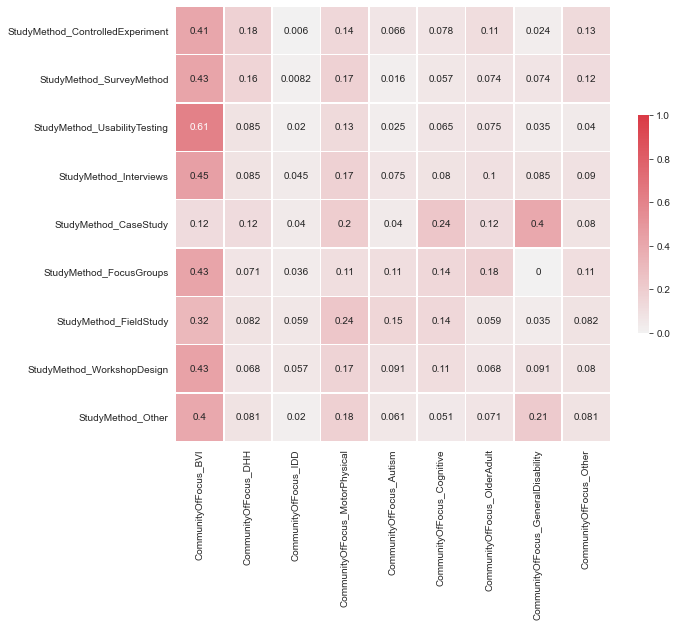



******** CommunityOfFocus and ParticipantGroup *******

** Raw sub-code co-occurrence count for CommunityOfFocus and ParticipantGroup **


CommunityOfFocus_BVI  \
ParticipantGroup_OlderAdult                                  2   
ParticipantGroup_PeopleWithDisability                      209   
ParticipantGroup_PeopleWithoutDisability                    47   
ParticipantGroup_TherapistsSpecialists                      24   
ParticipantGroup_Caregivers                                  6   
ParticipantGroup_Other                                      18   
ParticipantGroup_NoUserStudy                                 4   

                                          CommunityOfFocus_DHH  \
ParticipantGroup_OlderAdult                                  0   
ParticipantGroup_PeopleWithDisability                       37   
ParticipantGroup_PeopleWithoutDisability                    12   
ParticipantGroup_TherapistsSpecialists                       6   
ParticipantGroup_Caregivers                                  2   
ParticipantGroup_Other                                      15   
ParticipantGroup_NoUserStudy                                 4   

                                          CommunityOfFocus_IDD  \
ParticipantGroup_OlderAdult                                  0   
ParticipantGroup_PeopleWithDisability                       12   
ParticipantGroup_PeopleWithoutDisability                     3   
ParticipantGroup_TherapistsSpecialists                       8   
ParticipantGroup_Caregivers                                  3   
ParticipantGroup_Other                                       2   
ParticipantGroup_NoUserStudy                                 0   

                                          CommunityOfFocus_MotorPhysical  \
ParticipantGroup_OlderAdult                                            5   
ParticipantGroup_PeopleWithDisability                                 67   
ParticipantGroup_PeopleWithoutDisability                              14   
ParticipantGroup_TherapistsSpecialists                                16   
ParticipantGroup_Caregivers                                            9   
ParticipantGroup_Other                                                 5   
ParticipantGroup_NoUserStudy                                           1   

                                          CommunityOfFocus_Autism  \
ParticipantGroup_OlderAdult                                     1   
ParticipantGroup_PeopleWithDisability                          29   
ParticipantGroup_PeopleWithoutDisability                        7   
ParticipantGroup_TherapistsSpecialists                         13   
ParticipantGroup_Caregivers                                    10   
ParticipantGroup_Other                                          4   
ParticipantGroup_NoUserStudy                                    1   

                                          CommunityOfFocus_Cognitive  \
ParticipantGroup_OlderAdult                                        7   
ParticipantGroup_PeopleWithDisability                             40   
ParticipantGroup_PeopleWithoutDisability                           6   
ParticipantGroup_TherapistsSpecialists                            12   
ParticipantGroup_Caregivers                                       11   
ParticipantGroup_Other                                             4   
ParticipantGroup_NoUserStudy                                       1   

                                          CommunityOfFocus_OlderAdult  \
ParticipantGroup_OlderAdult                                        40   
ParticipantGroup_PeopleWithDisability                              14   
ParticipantGroup_PeopleWithoutDisability                           11   
ParticipantGroup_TherapistsSpecialists                              3   
ParticipantGroup_Caregivers                                         6   
ParticipantGroup_Other                                              4   
ParticipantGroup_NoUserStudy                                        2   

                                          CommunityOfFocus_GeneralDisability  \
ParticipantGroup_OlderAdult                        

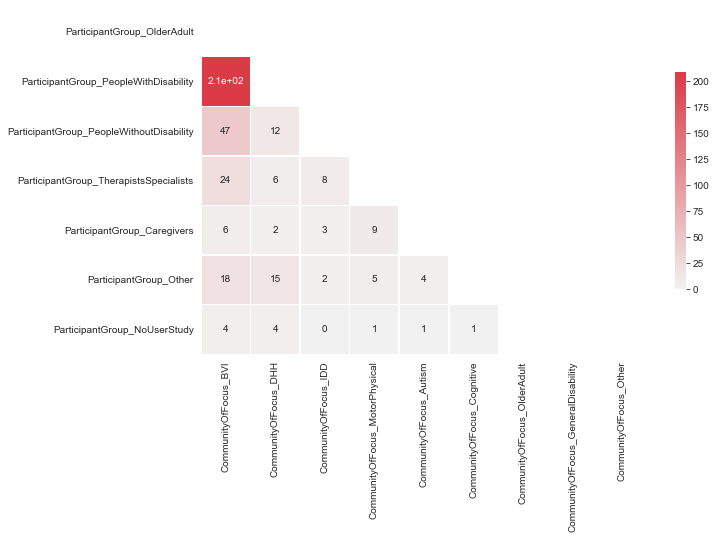

** Fraction of sub-code co-occurrences for CommunityOfFocus and ParticipantGroup (divisor is column sum) **


CommunityOfFocus_BVI  \
ParticipantGroup_OlderAdult                           0.009091   
ParticipantGroup_PeopleWithDisability                 0.950000   
ParticipantGroup_PeopleWithoutDisability              0.213636   
ParticipantGroup_TherapistsSpecialists                0.109091   
ParticipantGroup_Caregivers                           0.027273   
ParticipantGroup_Other                                0.081818   
ParticipantGroup_NoUserStudy                          0.018182   

                                          CommunityOfFocus_DHH  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.649123   
ParticipantGroup_PeopleWithoutDisability              0.210526   
ParticipantGroup_TherapistsSpecialists                0.105263   
ParticipantGroup_Caregivers                           0.035088   
ParticipantGroup_Other                                0.263158   
ParticipantGroup_NoUserStudy                          0.070175   

                                          CommunityOfFocus_IDD  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.857143   
ParticipantGroup_PeopleWithoutDisability              0.214286   
ParticipantGroup_TherapistsSpecialists                0.571429   
ParticipantGroup_Caregivers                           0.214286   
ParticipantGroup_Other                                0.142857   
ParticipantGroup_NoUserStudy                          0.000000   

                                          CommunityOfFocus_MotorPhysical  \
ParticipantGroup_OlderAdult                                     0.069444   
ParticipantGroup_PeopleWithDisability                           0.930556   
ParticipantGroup_PeopleWithoutDisability                        0.194444   
ParticipantGroup_TherapistsSpecialists                          0.222222   
ParticipantGroup_Caregivers                                     0.125000   
ParticipantGroup_Other                                          0.069444   
ParticipantGroup_NoUserStudy                                    0.013889   

                                          CommunityOfFocus_Autism  \
ParticipantGroup_OlderAdult                              0.032258   
ParticipantGroup_PeopleWithDisability                    0.935484   
ParticipantGroup_PeopleWithoutDisability                 0.225806   
ParticipantGroup_TherapistsSpecialists                   0.419355   
ParticipantGroup_Caregivers                              0.322581   
ParticipantGroup_Other                                   0.129032   
ParticipantGroup_NoUserStudy                             0.032258   

                                          CommunityOfFocus_Cognitive  \
ParticipantGroup_OlderAdult                                 0.152174   
ParticipantGroup_PeopleWithDisability                       0.869565   
ParticipantGroup_PeopleWithoutDisability                    0.130435   
ParticipantGroup_TherapistsSpecialists                      0.260870   
ParticipantGroup_Caregivers                                 0.239130   
ParticipantGroup_Other                                      0.086957   
ParticipantGroup_NoUserStudy                                0.021739   

                                          CommunityOfFocus_OlderAdult  \
ParticipantGroup_OlderAdult                                  0.888889   
ParticipantGroup_PeopleWithDisability                        0.311111   
ParticipantGroup_PeopleWithoutDisability                     0.244444   
ParticipantGroup_TherapistsSpecialists                       0.066667   
ParticipantGroup_Caregivers                                  0.133333   
ParticipantGroup_Other                                       0.088889   
ParticipantGroup_NoUserStudy                                 0.044444   

                                          CommunityOfFocus_GeneralDisability  \
ParticipantGroup_OlderAdult                        

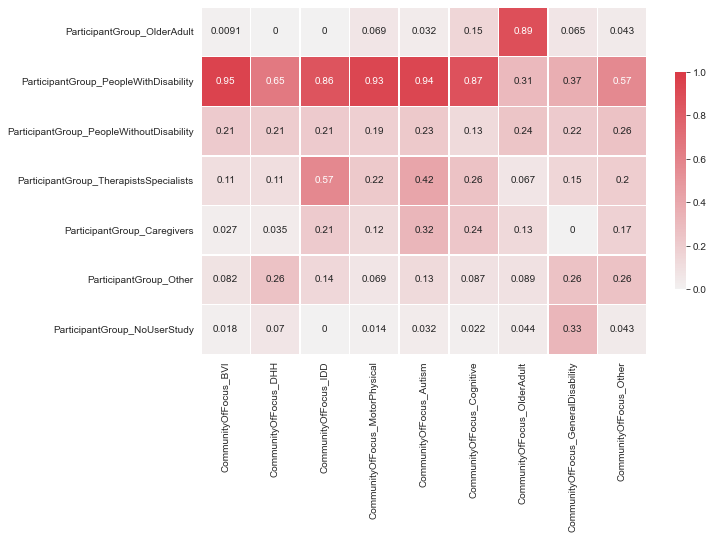

** Fraction of sub-code co-occurrences for CommunityOfFocus and ParticipantGroup (divisor is row sum) **


CommunityOfFocus_BVI  \
ParticipantGroup_OlderAdult                           0.050000   
ParticipantGroup_PeopleWithDisability                 0.517327   
ParticipantGroup_PeopleWithoutDisability              0.427273   
ParticipantGroup_TherapistsSpecialists                0.296296   
ParticipantGroup_Caregivers                           0.133333   
ParticipantGroup_Other                                0.339623   
ParticipantGroup_NoUserStudy                          0.137931   

                                          CommunityOfFocus_DHH  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.091584   
ParticipantGroup_PeopleWithoutDisability              0.109091   
ParticipantGroup_TherapistsSpecialists                0.074074   
ParticipantGroup_Caregivers                           0.044444   
ParticipantGroup_Other                                0.283019   
ParticipantGroup_NoUserStudy                          0.137931   

                                          CommunityOfFocus_IDD  \
ParticipantGroup_OlderAdult                           0.000000   
ParticipantGroup_PeopleWithDisability                 0.029703   
ParticipantGroup_PeopleWithoutDisability              0.027273   
ParticipantGroup_TherapistsSpecialists                0.098765   
ParticipantGroup_Caregivers                           0.066667   
ParticipantGroup_Other                                0.037736   
ParticipantGroup_NoUserStudy                          0.000000   

                                          CommunityOfFocus_MotorPhysical  \
ParticipantGroup_OlderAdult                                     0.125000   
ParticipantGroup_PeopleWithDisability                           0.165842   
ParticipantGroup_PeopleWithoutDisability                        0.127273   
ParticipantGroup_TherapistsSpecialists                          0.197531   
ParticipantGroup_Caregivers                                     0.200000   
ParticipantGroup_Other                                          0.094340   
ParticipantGroup_NoUserStudy                                    0.034483   

                                          CommunityOfFocus_Autism  \
ParticipantGroup_OlderAdult                              0.025000   
ParticipantGroup_PeopleWithDisability                    0.071782   
ParticipantGroup_PeopleWithoutDisability                 0.063636   
ParticipantGroup_TherapistsSpecialists                   0.160494   
ParticipantGroup_Caregivers                              0.222222   
ParticipantGroup_Other                                   0.075472   
ParticipantGroup_NoUserStudy                             0.034483   

                                          CommunityOfFocus_Cognitive  \
ParticipantGroup_OlderAdult                                 0.175000   
ParticipantGroup_PeopleWithDisability                       0.099010   
ParticipantGroup_PeopleWithoutDisability                    0.054545   
ParticipantGroup_TherapistsSpecialists                      0.148148   
ParticipantGroup_Caregivers                                 0.244444   
ParticipantGroup_Other                                      0.075472   
ParticipantGroup_NoUserStudy                                0.034483   

                                          CommunityOfFocus_OlderAdult  \
ParticipantGroup_OlderAdult                                  1.000000   
ParticipantGroup_PeopleWithDisability                        0.034653   
ParticipantGroup_PeopleWithoutDisability                     0.100000   
ParticipantGroup_TherapistsSpecialists                       0.037037   
ParticipantGroup_Caregivers                                  0.133333   
ParticipantGroup_Other                                       0.075472   
ParticipantGroup_NoUserStudy                                 0.068966   

                                          CommunityOfFocus_GeneralDisability  \
ParticipantGroup_OlderAdult                        

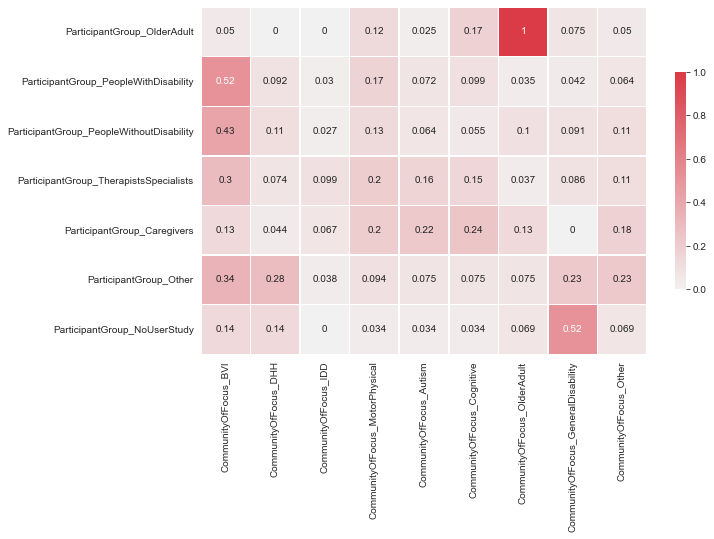



******** CommunityOfFocus and StudyLocation *******

** Raw sub-code co-occurrence count for CommunityOfFocus and StudyLocation **


CommunityOfFocus_BVI  \
StudyLocation_NearAtLab                                    69   
StudyLocation_ParticipantsHomeOrFreqLoc                    47   
StudyLocation_NeutralLocation                              20   
StudyLocation_Unclear                                      89   
StudyLocation_OnlineRemotely                               45   
StudyLocation_Other                                         3   
StudyLocation_NoUserStudy                                   4   

                                         CommunityOfFocus_DHH  \
StudyLocation_NearAtLab                                    14   
StudyLocation_ParticipantsHomeOrFreqLoc                     9   
StudyLocation_NeutralLocation                               5   
StudyLocation_Unclear                                      22   
StudyLocation_OnlineRemotely                               12   
StudyLocation_Other                                         2   
StudyLocation_NoUserStudy                                   4   

                                         CommunityOfFocus_IDD  \
StudyLocation_NearAtLab                                     3   
StudyLocation_ParticipantsHomeOrFreqLoc                    11   
StudyLocation_NeutralLocation                               1   
StudyLocation_Unclear                                       2   
StudyLocation_OnlineRemotely                                0   
StudyLocation_Other                                         0   
StudyLocation_NoUserStudy                                   0   

                                         CommunityOfFocus_MotorPhysical  \
StudyLocation_NearAtLab                                              19   
StudyLocation_ParticipantsHomeOrFreqLoc                              26   
StudyLocation_NeutralLocation                                         1   
StudyLocation_Unclear                                                31   
StudyLocation_OnlineRemotely                                         16   
StudyLocation_Other                                                   0   
StudyLocation_NoUserStudy                                             1   

                                         CommunityOfFocus_Autism  \
StudyLocation_NearAtLab                                        5   
StudyLocation_ParticipantsHomeOrFreqLoc                       19   
StudyLocation_NeutralLocation                                  0   
StudyLocation_Unclear                                          7   
StudyLocation_OnlineRemotely                                   5   
StudyLocation_Other                                            2   
StudyLocation_NoUserStudy                                      1   

                                         CommunityOfFocus_Cognitive  \
StudyLocation_NearAtLab                                           9   
StudyLocation_ParticipantsHomeOrFreqLoc                          18   
StudyLocation_NeutralLocation                                     1   
StudyLocation_Unclear                                            14   
StudyLocation_OnlineRemotely                                      9   
StudyLocation_Other                                               0   
StudyLocation_NoUserStudy                                         1   

                                         CommunityOfFocus_OlderAdult  \
StudyLocation_NearAtLab                                            9   
StudyLocation_ParticipantsHomeOrFreqLoc                           15   
StudyLocation_NeutralLocation                                      1   
StudyLocation_Unclear                                             20   
StudyLocation_OnlineRemotely                                       4   
StudyLocation_Other                                                0   
StudyLocation_NoUserStudy                                          2   

                                         CommunityOfFocus_GeneralDisability  \
StudyLocation_NearAtLab                                                   6   
StudyLocation_ParticipantsHo

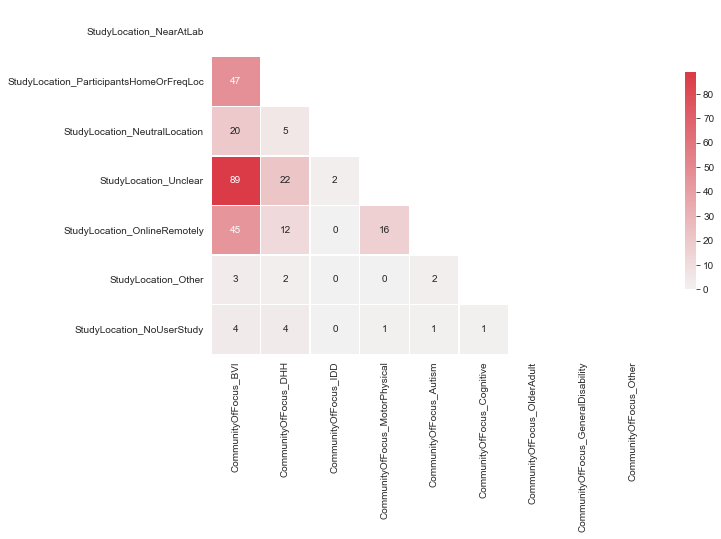

** Fraction of sub-code co-occurrences for CommunityOfFocus and StudyLocation (divisor is column sum) **


CommunityOfFocus_BVI  \
StudyLocation_NearAtLab                              0.313636   
StudyLocation_ParticipantsHomeOrFreqLoc              0.213636   
StudyLocation_NeutralLocation                        0.090909   
StudyLocation_Unclear                                0.404545   
StudyLocation_OnlineRemotely                         0.204545   
StudyLocation_Other                                  0.013636   
StudyLocation_NoUserStudy                            0.018182   

                                         CommunityOfFocus_DHH  \
StudyLocation_NearAtLab                              0.245614   
StudyLocation_ParticipantsHomeOrFreqLoc              0.157895   
StudyLocation_NeutralLocation                        0.087719   
StudyLocation_Unclear                                0.385965   
StudyLocation_OnlineRemotely                         0.210526   
StudyLocation_Other                                  0.035088   
StudyLocation_NoUserStudy                            0.070175   

                                         CommunityOfFocus_IDD  \
StudyLocation_NearAtLab                              0.214286   
StudyLocation_ParticipantsHomeOrFreqLoc              0.785714   
StudyLocation_NeutralLocation                        0.071429   
StudyLocation_Unclear                                0.142857   
StudyLocation_OnlineRemotely                         0.000000   
StudyLocation_Other                                  0.000000   
StudyLocation_NoUserStudy                            0.000000   

                                         CommunityOfFocus_MotorPhysical  \
StudyLocation_NearAtLab                                        0.263889   
StudyLocation_ParticipantsHomeOrFreqLoc                        0.361111   
StudyLocation_NeutralLocation                                  0.013889   
StudyLocation_Unclear                                          0.430556   
StudyLocation_OnlineRemotely                                   0.222222   
StudyLocation_Other                                            0.000000   
StudyLocation_NoUserStudy                                      0.013889   

                                         CommunityOfFocus_Autism  \
StudyLocation_NearAtLab                                 0.161290   
StudyLocation_ParticipantsHomeOrFreqLoc                 0.612903   
StudyLocation_NeutralLocation                           0.000000   
StudyLocation_Unclear                                   0.225806   
StudyLocation_OnlineRemotely                            0.161290   
StudyLocation_Other                                     0.064516   
StudyLocation_NoUserStudy                               0.032258   

                                         CommunityOfFocus_Cognitive  \
StudyLocation_NearAtLab                                    0.195652   
StudyLocation_ParticipantsHomeOrFreqLoc                    0.391304   
StudyLocation_NeutralLocation                              0.021739   
StudyLocation_Unclear                                      0.304348   
StudyLocation_OnlineRemotely                               0.195652   
StudyLocation_Other                                        0.000000   
StudyLocation_NoUserStudy                                  0.021739   

                                         CommunityOfFocus_OlderAdult  \
StudyLocation_NearAtLab                                     0.200000   
StudyLocation_ParticipantsHomeOrFreqLoc                     0.333333   
StudyLocation_NeutralLocation                               0.022222   
StudyLocation_Unclear                                       0.444444   
StudyLocation_OnlineRemotely                                0.088889   
StudyLocation_Other                                         0.000000   
StudyLocation_NoUserStudy                                   0.044444   

                                         CommunityOfFocus_GeneralDisability  \
StudyLocation_NearAtLab                                            0.130435   
StudyLocation_ParticipantsHo

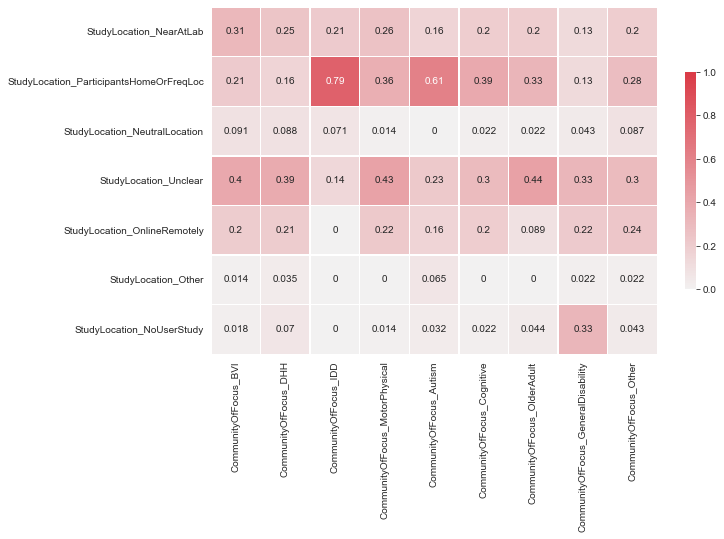

** Fraction of sub-code co-occurrences for CommunityOfFocus and StudyLocation (divisor is row sum) **


CommunityOfFocus_BVI  \
StudyLocation_NearAtLab                              0.530769   
StudyLocation_ParticipantsHomeOrFreqLoc              0.340580   
StudyLocation_NeutralLocation                        0.625000   
StudyLocation_Unclear                                0.470899   
StudyLocation_OnlineRemotely                         0.459184   
StudyLocation_Other                                  0.428571   
StudyLocation_NoUserStudy                            0.137931   

                                         CommunityOfFocus_DHH  \
StudyLocation_NearAtLab                              0.107692   
StudyLocation_ParticipantsHomeOrFreqLoc              0.065217   
StudyLocation_NeutralLocation                        0.156250   
StudyLocation_Unclear                                0.116402   
StudyLocation_OnlineRemotely                         0.122449   
StudyLocation_Other                                  0.285714   
StudyLocation_NoUserStudy                            0.137931   

                                         CommunityOfFocus_IDD  \
StudyLocation_NearAtLab                              0.023077   
StudyLocation_ParticipantsHomeOrFreqLoc              0.079710   
StudyLocation_NeutralLocation                        0.031250   
StudyLocation_Unclear                                0.010582   
StudyLocation_OnlineRemotely                         0.000000   
StudyLocation_Other                                  0.000000   
StudyLocation_NoUserStudy                            0.000000   

                                         CommunityOfFocus_MotorPhysical  \
StudyLocation_NearAtLab                                        0.146154   
StudyLocation_ParticipantsHomeOrFreqLoc                        0.188406   
StudyLocation_NeutralLocation                                  0.031250   
StudyLocation_Unclear                                          0.164021   
StudyLocation_OnlineRemotely                                   0.163265   
StudyLocation_Other                                            0.000000   
StudyLocation_NoUserStudy                                      0.034483   

                                         CommunityOfFocus_Autism  \
StudyLocation_NearAtLab                                 0.038462   
StudyLocation_ParticipantsHomeOrFreqLoc                 0.137681   
StudyLocation_NeutralLocation                           0.000000   
StudyLocation_Unclear                                   0.037037   
StudyLocation_OnlineRemotely                            0.051020   
StudyLocation_Other                                     0.285714   
StudyLocation_NoUserStudy                               0.034483   

                                         CommunityOfFocus_Cognitive  \
StudyLocation_NearAtLab                                    0.069231   
StudyLocation_ParticipantsHomeOrFreqLoc                    0.130435   
StudyLocation_NeutralLocation                              0.031250   
StudyLocation_Unclear                                      0.074074   
StudyLocation_OnlineRemotely                               0.091837   
StudyLocation_Other                                        0.000000   
StudyLocation_NoUserStudy                                  0.034483   

                                         CommunityOfFocus_OlderAdult  \
StudyLocation_NearAtLab                                     0.069231   
StudyLocation_ParticipantsHomeOrFreqLoc                     0.108696   
StudyLocation_NeutralLocation                               0.031250   
StudyLocation_Unclear                                       0.105820   
StudyLocation_OnlineRemotely                                0.040816   
StudyLocation_Other                                         0.000000   
StudyLocation_NoUserStudy                                   0.068966   

                                         CommunityOfFocus_GeneralDisability  \
StudyLocation_NearAtLab                                            0.046154   
StudyLocation_ParticipantsHo

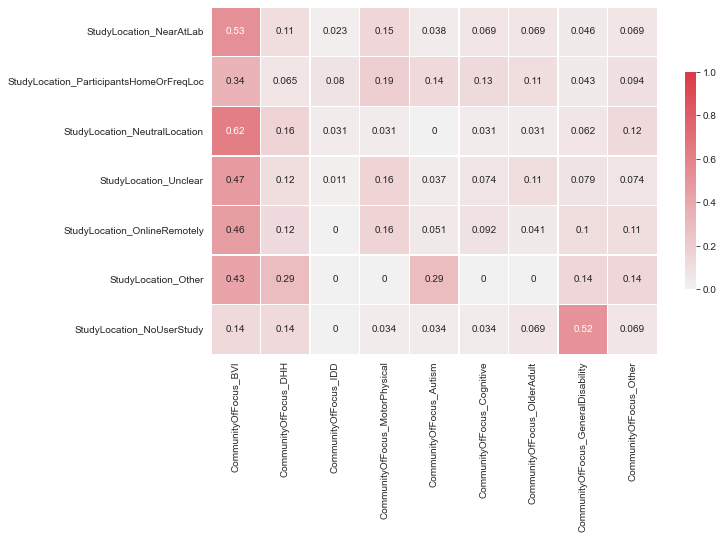



******** CommunityOfFocus and ParticipatoryDesign *******

** Raw sub-code co-occurrence count for CommunityOfFocus and ParticipatoryDesign **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
ParticipatoryDesign_Yes                    16                     4   
ParticipatoryDesign_No                    204                    53   

                         CommunityOfFocus_IDD  CommunityOfFocus_MotorPhysical  \
ParticipatoryDesign_Yes                     3                              11   
ParticipatoryDesign_No                     11                              61   

                         CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
ParticipatoryDesign_Yes                        5                          10   
ParticipatoryDesign_No                        26                          36   

                         CommunityOfFocus_OlderAdult  \
ParticipatoryDesign_Yes                            3   
ParticipatoryDesign_No                            42   

                         CommunityOfFocus_GeneralDisability  \
ParticipatoryDesign_Yes                                   4   
ParticipatoryDesign_No                                   42   

                         CommunityOfFocus_Other  
ParticipatoryDesign_Yes                       3  
ParticipatoryDesign_No                       43

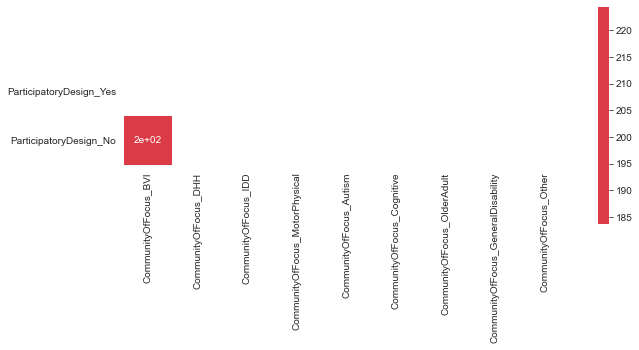

** Fraction of sub-code co-occurrences for CommunityOfFocus and ParticipatoryDesign (divisor is column sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
ParticipatoryDesign_Yes              0.072727              0.070175   
ParticipatoryDesign_No               0.927273              0.929825   

                         CommunityOfFocus_IDD  CommunityOfFocus_MotorPhysical  \
ParticipatoryDesign_Yes              0.214286                        0.152778   
ParticipatoryDesign_No               0.785714                        0.847222   

                         CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
ParticipatoryDesign_Yes                  0.16129                    0.217391   
ParticipatoryDesign_No                   0.83871                    0.782609   

                         CommunityOfFocus_OlderAdult  \
ParticipatoryDesign_Yes                     0.066667   
ParticipatoryDesign_No                      0.933333   

                         CommunityOfFocus_GeneralDisability  \
ParticipatoryDesign_Yes                            0.086957   
ParticipatoryDesign_No                             0.913043   

                         CommunityOfFocus_Other  
ParticipatoryDesign_Yes                0.065217  
ParticipatoryDesign_No                 0.934783

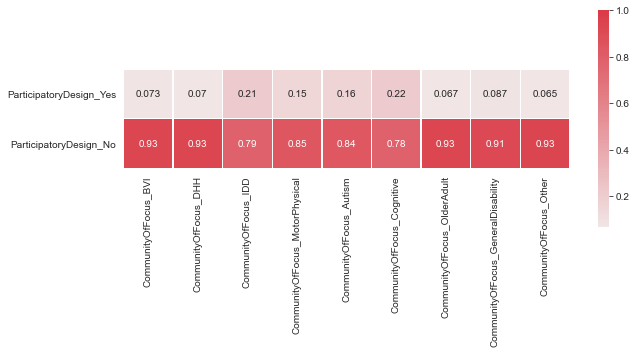

** Fraction of sub-code co-occurrences for CommunityOfFocus and ParticipatoryDesign (divisor is row sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
ParticipatoryDesign_Yes              0.326531              0.081633   
ParticipatoryDesign_No               0.446389              0.115974   

                         CommunityOfFocus_IDD  CommunityOfFocus_MotorPhysical  \
ParticipatoryDesign_Yes              0.061224                        0.224490   
ParticipatoryDesign_No               0.024070                        0.133479   

                         CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
ParticipatoryDesign_Yes                 0.102041                    0.204082   
ParticipatoryDesign_No                  0.056893                    0.078775   

                         CommunityOfFocus_OlderAdult  \
ParticipatoryDesign_Yes                     0.061224   
ParticipatoryDesign_No                      0.091904   

                         CommunityOfFocus_GeneralDisability  \
ParticipatoryDesign_Yes                            0.081633   
ParticipatoryDesign_No                             0.091904   

                         CommunityOfFocus_Other  
ParticipatoryDesign_Yes                0.061224  
ParticipatoryDesign_No                 0.094092

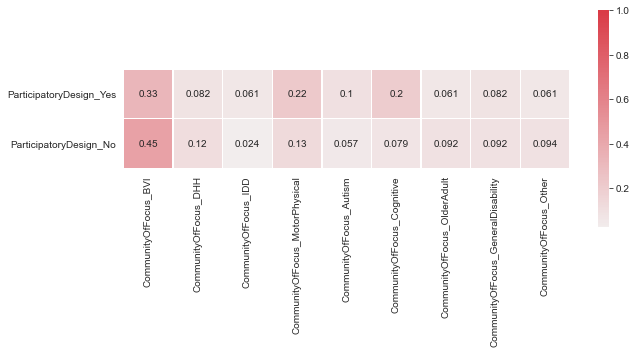



******** CommunityOfFocus and ComparesOnDisability *******

** Raw sub-code co-occurrence count for CommunityOfFocus and ComparesOnDisability **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
ComparesOnDisability_Yes                    30                     6   
ComparesOnDisability_No                    190                    51   

                          CommunityOfFocus_IDD  \
ComparesOnDisability_Yes                     1   
ComparesOnDisability_No                     13   

                          CommunityOfFocus_MotorPhysical  \
ComparesOnDisability_Yes                               7   
ComparesOnDisability_No                               65   

                          CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
ComparesOnDisability_Yes                        4                           6   
ComparesOnDisability_No                        27                          40   

                          CommunityOfFocus_OlderAdult  \
ComparesOnDisability_Yes                            9   
ComparesOnDisability_No                            36   

                          CommunityOfFocus_GeneralDisability  \
ComparesOnDisability_Yes                                   3   
ComparesOnDisability_No                                   43   

                          CommunityOfFocus_Other  
ComparesOnDisability_Yes                       9  
ComparesOnDisability_No                       37

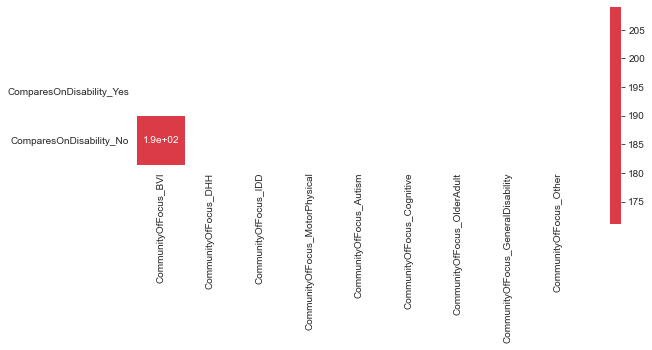

** Fraction of sub-code co-occurrences for CommunityOfFocus and ComparesOnDisability (divisor is column sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
ComparesOnDisability_Yes              0.136364              0.105263   
ComparesOnDisability_No               0.863636              0.894737   

                          CommunityOfFocus_IDD  \
ComparesOnDisability_Yes              0.071429   
ComparesOnDisability_No               0.928571   

                          CommunityOfFocus_MotorPhysical  \
ComparesOnDisability_Yes                        0.097222   
ComparesOnDisability_No                         0.902778   

                          CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
ComparesOnDisability_Yes                 0.129032                    0.130435   
ComparesOnDisability_No                  0.870968                    0.869565   

                          CommunityOfFocus_OlderAdult  \
ComparesOnDisability_Yes                          0.2   
ComparesOnDisability_No                           0.8   

                          CommunityOfFocus_GeneralDisability  \
ComparesOnDisability_Yes                            0.065217   
ComparesOnDisability_No                             0.934783   

                          CommunityOfFocus_Other  
ComparesOnDisability_Yes                0.195652  
ComparesOnDisability_No                 0.804348

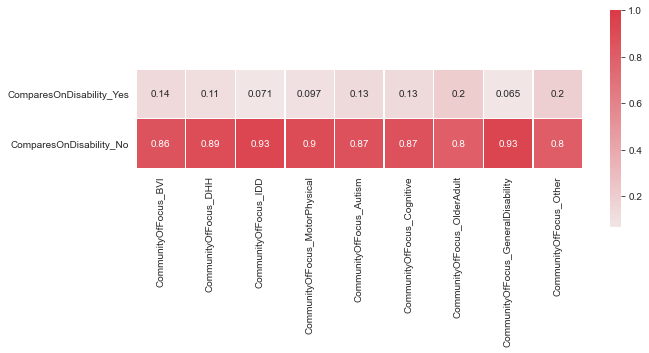

** Fraction of sub-code co-occurrences for CommunityOfFocus and ComparesOnDisability (divisor is row sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
ComparesOnDisability_Yes              0.461538              0.092308   
ComparesOnDisability_No               0.430839              0.115646   

                          CommunityOfFocus_IDD  \
ComparesOnDisability_Yes              0.015385   
ComparesOnDisability_No               0.029478   

                          CommunityOfFocus_MotorPhysical  \
ComparesOnDisability_Yes                        0.107692   
ComparesOnDisability_No                         0.147392   

                          CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
ComparesOnDisability_Yes                 0.061538                    0.092308   
ComparesOnDisability_No                  0.061224                    0.090703   

                          CommunityOfFocus_OlderAdult  \
ComparesOnDisability_Yes                     0.138462   
ComparesOnDisability_No                      0.081633   

                          CommunityOfFocus_GeneralDisability  \
ComparesOnDisability_Yes                            0.046154   
ComparesOnDisability_No                             0.097506   

                          CommunityOfFocus_Other  
ComparesOnDisability_Yes                0.138462  
ComparesOnDisability_No                 0.083900

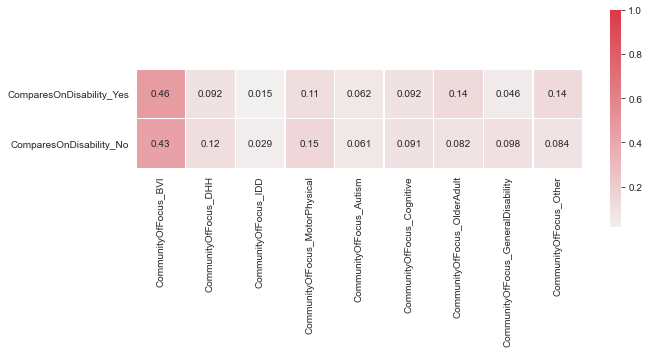



******** CommunityOfFocus and UsesProxies *******

** Raw sub-code co-occurrence count for CommunityOfFocus and UsesProxies **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
UsesProxies_Yes                    10                     0   
UsesProxies_No                    210                    57   

                 CommunityOfFocus_IDD  CommunityOfFocus_MotorPhysical  \
UsesProxies_Yes                     3                               6   
UsesProxies_No                     11                              66   

                 CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
UsesProxies_Yes                        7                           8   
UsesProxies_No                        24                          38   

                 CommunityOfFocus_OlderAdult  \
UsesProxies_Yes                            3   
UsesProxies_No                            42   

                 CommunityOfFocus_GeneralDisability  CommunityOfFocus_Other  
UsesProxies_Yes                                   2                       8  
UsesProxies_No                                   44                      38

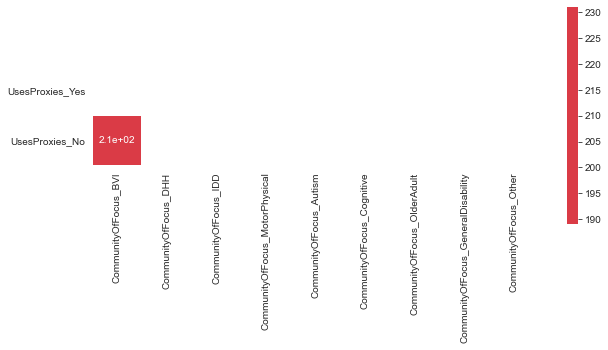

** Fraction of sub-code co-occurrences for CommunityOfFocus and UsesProxies (divisor is column sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
UsesProxies_Yes              0.045455                   0.0   
UsesProxies_No               0.954545                   1.0   

                 CommunityOfFocus_IDD  CommunityOfFocus_MotorPhysical  \
UsesProxies_Yes              0.214286                        0.083333   
UsesProxies_No               0.785714                        0.916667   

                 CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
UsesProxies_Yes                 0.225806                    0.173913   
UsesProxies_No                  0.774194                    0.826087   

                 CommunityOfFocus_OlderAdult  \
UsesProxies_Yes                     0.066667   
UsesProxies_No                      0.933333   

                 CommunityOfFocus_GeneralDisability  CommunityOfFocus_Other  
UsesProxies_Yes                            0.043478                0.173913  
UsesProxies_No                             0.956522                0.826087

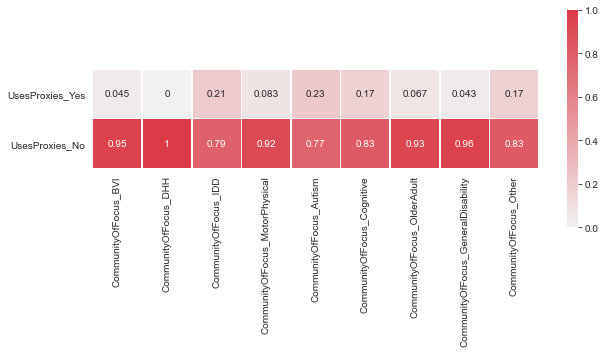

** Fraction of sub-code co-occurrences for CommunityOfFocus and UsesProxies (divisor is row sum) **


CommunityOfFocus_BVI  CommunityOfFocus_DHH  \
UsesProxies_Yes              0.263158              0.000000   
UsesProxies_No               0.448718              0.121795   

                 CommunityOfFocus_IDD  CommunityOfFocus_MotorPhysical  \
UsesProxies_Yes              0.078947                        0.157895   
UsesProxies_No               0.023504                        0.141026   

                 CommunityOfFocus_Autism  CommunityOfFocus_Cognitive  \
UsesProxies_Yes                 0.184211                    0.210526   
UsesProxies_No                  0.051282                    0.081197   

                 CommunityOfFocus_OlderAdult  \
UsesProxies_Yes                     0.078947   
UsesProxies_No                      0.089744   

                 CommunityOfFocus_GeneralDisability  CommunityOfFocus_Other  
UsesProxies_Yes                            0.052632                0.210526  
UsesProxies_No                             0.094017                0.081197

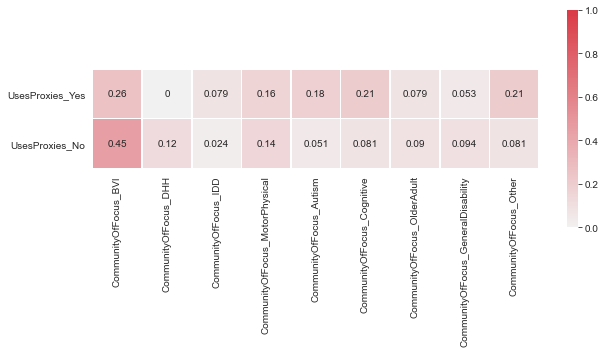

In [88]:
# Print out co-occurrence information
code_cats = list(map_codes.keys())

if 'NumParticipants' in code_cats:
    code_cats.remove('NumParticipants')

if 'NumUserStudies' in code_cats:
    code_cats.remove('NumUserStudies')

for i in range(len(code_cats)):
    for j in range(len(code_cats)):    
        
        # col_names = [code_cat + code_separator + sub_code for sub_code in sub_codes]
        code_cat1 = code_cats[i]
        code_cat2 = code_cats[j]
        
        if code_cat1 is not code_cat2:
        
            cross_code_co_occurence_results = calc_cross_code_co_occurrence_matrix(code_cat1, code_cat2)
            df_co_occurrence_subcode_cnt, df_co_occurrence_subcode_frac_of_col, df_co_occurrence_subcode_frac_of_row = cross_code_co_occurence_results

            print(f"\n\n******** {code_cat1} and {code_cat2} *******\n")
            print(f"** Raw sub-code co-occurrence count for {code_cat1} and {code_cat2} **")
            display(df_co_occurrence_subcode_cnt)
            plot_co_occurrence_cnt_matrix(df_co_occurrence_subcode_cnt)

            print(f"** Fraction of sub-code co-occurrences for {code_cat1} and {code_cat2} (divisor is column sum) **")
            display(df_co_occurrence_subcode_frac_of_col)
            plot_co_occurrence_fraction_matrix(df_co_occurrence_subcode_frac_of_col)

            print(f"** Fraction of sub-code co-occurrences for {code_cat1} and {code_cat2} (divisor is row sum) **")
            display(df_co_occurrence_subcode_frac_of_row)
            plot_co_occurrence_fraction_matrix(df_co_occurrence_subcode_frac_of_row)
            
    break

# Authorial Analysis
Our initial focus here is just to see how many authors we have and how divergent they are. Note: we did not end up using this authorial analysis in our CHI'21 paper but may in follow-up work.

In [90]:
# author lists are either comma separated or separated with 'and'
class Author:
    def __init__(self, full_name):
        name_parts = full_name.split(' ')
        self.first = None
        self.middle = None
        self.last = None
        
        if len(name_parts) == 2:
            self.first = name_parts[0]
            self.middle = None
            self.last = name_parts[1]
        elif len(name_parts) == 3:
            self.first = name_parts[0]
            self.middle = name_parts[1]
            self.last = name_parts[2]
        elif len(name_parts) > 3:
            print(f"Found author {full_name} with {len(name_parts)} name parts")
            self.first = name_parts[0]
            self.middle = None
            self.last = ' '.join(name_parts[1:])
        else:
            print(f"Found author {full_name} with only one name parts")
            self.first = full_name
            self.middle = None
            self.last = ""
            
        self.papers = []
        
    def __eq__(self, other):
        if not isinstance(other, Author):
            return False
        
        return self.first.lower() == other.first.lower() and \
               self.last.lower() == other.last.lower()
    
    def __hash__(self):
        # only hash on first and last names
        return hash(f"{self.first} {self.last}")
    
    def __str__(self):
        if self.middle is not None:
            return f"{self.first} {self.middle} {self.last}"
        else:
            return f"{self.first} {self.last}"
    
    def __repr__(self):
        return self.__str__()
        
class Paper:
    def __init__(self, title, doi, venue, year):
        print(title)
        self.title = title.strip()
        self.doi = doi
        self.venue = venue
        self.year = year
        self.authors = []
    
    def __str__(self):
        return f"{self.title}, {self.venue} {self.year}"
    
    def __repr__(self):
        return self.__str__()
    


In [91]:
# Create and fill authorial data structures for analysis
map_authors = dict() # set of authors
papers = list()
for index, row in df.iterrows():
    author_block = row['Author']
    
    paper = Paper(row['Title'], row['DOI'], row['Venue'], row['Year'])
    papers.append(paper)
    if ',' in author_block or ' and ' in author_block:
        tokens = []
        if ',' in author_block:
            tokens = author_block.split(',')
        else:
            tokens = author_block.split(' and ')
        tokens = list(map(str.strip, tokens))
        for full_name in tokens:
            author = Author(full_name)
            if author not in map_authors:
                map_authors[author] = author
            else:
                author = map_authors[author]
                #print(f"Author {author} has {len(author.papers)} papers")
            author.papers.append(paper)
            paper.authors.append(author)
    else:
        author = Author(author_block.strip())
        if author not in map_authors:
            map_authors[author] = author
        else:
            author = map_authors[author]
        author.papers.append(paper)
        paper.authors.append(author)

authors = list(map_authors.values())


The Tactile Graphics Helper Providing Audio Clarification for Tactile Graphics Using Machine Vision
"Occupational Therapy is Making": Clinical Rapid Prototyping and Digital Fabrication
Evaluating quality and comprehension of real-time sign language video on mobile phones  
LucentMaps 3D Printed Audiovisual Tactile Maps for Blind and Visually Impaired People
Understanding and Designing for Deaf or Hard of Hearing Drivers on Uber  
Automatically generating tailored accessible user interfaces for ubiquitous services  
A haptic ATM interface to assist visually impaired users  
Towards Accessible Conversations in a Mobile Context for People who are Deaf and Hard of Hearing  
Understanding the conflicting demands of family caregivers caring for depressed family members  
Smart Kitchens for People with Cognitive Impairments A Qualitative Study of Design Requirements
Comparing Tactile, Auditory, and Visual Assembly Error-Feedback for Workers with Cognitive Impairments  
Inclusion and Education

In [92]:
# sort and print authors by last name
authors = sorted(authors, key=lambda author: author.last)
for author in authors:
    print(author, len(author.papers))

Nazneen  1
Julio Abascal 1
Jacob Abbott 1
Ali Abdolrahmani 4
Vero Vanden Abeele 1
Gregory Abowd 2
Krishnaveni Achary 2
Mark S. Ackerman 1
Lada A. Adamic 1
Dustin W. Adams 2
Malek Adjouadi 1
Maneesh Agrawala 1
Faisal Ahmed 1
Taimur Ahmed 1
Alex Ahmed 1
Tousif Ahmed 1
Beena Ahmed 1
Dragan Ahmetovic 7
Amaia Aizpurua 1
Sedeeq Al-khazraji 1
Nicolò Alabastro 1
Gazihan Alankus 3
Reem Albaghli 1
Jérémy Albouys-Perrois 1
Khaled Albusays 2
Shareef Ali 1
Abdullah Ali 2
Abdinasir Aliomar 1
Maraim Alnfiai 1
Oliver Alonzo 1
Ahmad Alsaleem 1
Kyle Althoff 1
Roger Altizer 1
Tawfiq Ammari 1
A. Anam 1
Boyd Anderson 2
Richard Anderson 2
Hugh Anderson 1
Fraser Anderson 1
Alan Andrade 1
Ronny Andrade 1
Antonella De Angeli 2
Lisa Anthony 1
Ilias Apostolopoulous 1
Mike Armstrong 2
Safa Arooj 1
Rosa Arriaga 2
Sonia Arteaga 1
Beatrice Aruanno 1
Chieko Asakawa 12
Saki Asakawa 1
Daniel Ashbrook 1
Vikas Ashok 6
Michael Astrauskas 1
Awais Athar 1
Brooke E. Auxier 1
Federico Avanzini 1
Shiri Azenkot 13
A. B. M. Al I

Nicolai Marquardt 1
Diogo Marques 1
Kim Marriott 3
Jane Marshall 2
Paul Marshall 1
Daniel Martín-Albo 1
Sergio Mascetti 6
Liam Mason 1
Lee Mason 2
Aaron K. Massey 2
Justin Matejka 1
Reeti Mathur 1
Soichiro Matsuda 1
Silke Matthes 1
Laura Matuszewska 1
Matt May 1
Laura Maye 1
Sven Mayer 1
Peter Mayer 1
Sinziana Mazilu 1
Grace Mbipom 1
Denise McCall 2
John McCarthy 1
Sandy McCombe-Waller 1
Kathleen McCoy 2
Samantha McDonald 2
David McGookin 2
John McGowan 1
Iain McGregor 1
Joanna McGrenere 2
Lesley McIntyre 1
Jacqueline McKechnie 1
Janice McLaughlin 2
Roisin McNaney 1
Saige McVea 1
Sean Mealin 1
Kanika Mehta 1
Chao Mei 2
Genna Melamed 1
Michele Mengucci 1
Helena Mentis 4
Arcangelo Merla 1
Andrew Merryweather 1
Alexander Mertens 1
Oussama Metatla 2
Thomas D. Meyer 1
Joshua Miele 2
Sunny Miglani 1
Alex Mihailidis 2
Zdenek Mikovec 1
Nick Miller 1
Matthew Miller 2
Hannah Miller 1
Lauren Milne 7
Kelly Minckler 1
Aliaksei Miniukovich 1
Silvia Mirri 1
Pejman Mirza-Babaei 1
Taniya Mishra 1
Sonal

## Authorial frequency

In [93]:
# sort and print authors by num of papers published
authors = sorted(authors, key=lambda author: len(author.papers), reverse=True)
for author in authors:
    print(author, len(author.papers))

Jeffrey Bigham 23
Leah Findlater 22
Jacob Wobbrock 22
Shaun Kane 21
Meredith Ringel Morris 20
Richard Ladner 18
Cynthia Bennett 16
Amy Hurst 16
Matt Huenerfauth 15
Shiri Azenkot 13
Jon Froehlich 13
Chieko Asakawa 12
Vicki Hanson 12
Edward Cutrell 11
Tiago Guerreiro 11
Hugo Nicolau 11
João Guerreiro 10
Gillian Hayes 10
Hernisa Kacorri 10
Kathrin Gerling 9
Kyle Montague 9
Erin Brady 8
Stacy Branham 8
David Flatla 8
Jennifer Mankoff 8
Kyle Rector 8
Yuhang Zhao 8
Dragan Ahmetovic 7
LouAnne Boyd 7
Patrick Carrington 7
Kris M. Kitani 7
Lauren Milne 7
André Rodrigues 7
Vikas Ashok 6
Syed Masum Billah 6
Raja Kushalnagar 6
Sergio Mascetti 6
Martez Mott 6
Uran Oh 6
Abigale Stangl 6
Tom Yeh 6
Larwan Berke 5
Stephen Brewster 5
James Fogarty 5
Rachel Franz 5
Daniel Gonçalves 5
Kotaro Hara 5
Sushant Kafle 5
Sri H. Kurniawan 5
Walter Lasecki 5
Roberto Manduchi 5
Anne Piper 5
Daisuke Sato 5
Hironobu Takagi 5
Khai Truong 5
Xiaoyi Zhang 5
Yu Zhong 5
Ali Abdolrahmani 4
Xiaojun Bi 4
Davide Bolchini 4
Dani

Björn Hartmann 1
Marc Hassenzahl 1
Jeffrey M. Hausdorff 1
David Hayden 1
Weijie He 1
Kurtis Heimerl 1
Tomi Heimonen 1
Alexis Heloir 1
Julie Hengst 1
Niels Henze 1
Michael Heron 1
Cynthia Herrera 1
Jo Herstad 1
Ellen Hibbard 1
Keita Higuchi 1
Alexis Hiniker 1
Keiji Hirata 1
Timothy L. Hodgson 1
Jerry Hoepner 1
Jesse Hoey 1
Erik Hofer 1
Kristine Holbø 1
Benjamin Holland 1
Ryan Holland 1
Nic Hollinworth 1
Catherine Holloway 1
Jon Holman 1
Harald Holone 1
Hwajung Hong 1
Zhenan Hong 1
Matthias Hoppe 1
Anthony Hornof 1
Simo Hosio 1
Roberto Hoyle 1
Ming-Wei Hsi 1
Leon Hsu 1
Chia-Lo Hsu 1
Michele Hu 1
Yun Huang 1
Yifeng Huang 1
Jian Huang 1
Jochen Huber 1
Bjorn Hubert-Wallander 1
Earl Huff 1
Chris Hughes 1
Jan Hurtmanns 1
Lisa Hurwitz 1
Nicholas Huynh 1
Faustina Hwang 1
Jennifer Hyde 1
Seray B. Ibrahim 1
Thavishi Illandara 1
Ross Imburgia 1
Muhammad Islam 1
Yuta Itoh 1
Suresh Iyengar 1
Daniel Jackson 1
Dan Jackson 1
Claudia Jacova 1
Shobhit Jain 1
Suyog Jain 1
Mohit Jain 1
Matthew Jamieson 1
E

## Primitive authorial prevelance analysis

In [104]:
def calc_num_authors_n_papers(authors, num_papers = 1):
    num_authors_one_paper = 0
    for author in authors:
        if len(author.papers) == 1:
            num_authors_one_paper += 1
    return num_authors_one_paper

# Count number of papers from top N authors
def calc_author_prevelance_top_n(authors, top_n):
    authors = sorted(authors, key=lambda author: len(author.papers), reverse=True)
    papers_top_n = set()

    for i in range(top_n):
        author = authors[i]
        for paper in author.papers:
            if paper not in papers_top_n:
                papers_top_n.add(paper)
    return papers_top_n


num_authors_one_paper = calc_num_authors_n_papers(authors, 1)    
print(f"We found {len(authors)} authors")
print(f"{num_authors_one_paper} authors ({num_authors_one_paper/len(authors) * 100:.2f}%) had one paper")

# TODO: in future, make plot that varies top_n and plots result
top_n = 10
papers_top_n = calc_author_prevelance_top_n(authors, top_n)
print(f"The top {top_n} ({top_n / len(authors) * 100:.2f}%) authors contributed {len(papers_top_n)/len(df) * 100:.2f}% ({len(papers_top_n)} of {len(df)})")

top_n = 20
papers_top_n = calc_author_prevelance_top_n(authors, top_n)
print(f"The top {top_n} ({top_n / len(authors) * 100:.2f}%) authors contributed {len(papers_top_n)/len(df) * 100:.2f}% ({len(papers_top_n)} of {len(df)})")

top_n = 50
papers_top_n = calc_author_prevelance_top_n(authors, top_n)
print(f"The top {top_n} ({top_n / len(authors) * 100:.2f}%) authors contributed {len(papers_top_n)/len(df) * 100:.2f}% ({len(papers_top_n)} of {len(df)})")



We found 1260 authors
981 authors (77.86%) had one paper
The top 10 (0.79%) authors contributed 28.06% (142 of 506)
The top 20 (1.59%) authors contributed 40.71% (206 of 506)
The top 50 (3.97%) authors contributed 51.19% (259 of 506)


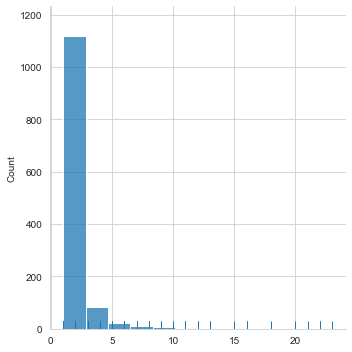

In [105]:
# create a histogram
sns.set_style("whitegrid")
num_papers = [len(author.papers) for author in authors]
sns.displot(num_papers, kde=False, rug=True);

## Primitive newcomer analysis

In [107]:
# how many papers exist in our dataset where the entire author list is from authors that have no other papers
# in our dataset
papers_with_completely_fresh_authors = list()
for paper in papers:
    num_papers_by_authors = 0
    for author in paper.authors:
        num_papers_by_authors += len(author.papers)
    
    if num_papers_by_authors == len(paper.authors):
        papers_with_completely_fresh_authors.append(paper)
        
print(f"The number of papers where entire author list is from authors that have no other papers: "
      f"{len(papers_with_completely_fresh_authors)} of {(len(df))}, which is "
      f"{len(papers_with_completely_fresh_authors) / (len(df)) * 100:.2f}%")
print()

for paper in papers_with_completely_fresh_authors:
    print(f"The paper {paper} has authors {paper.authors}")

The number of papers where entire author list is from authors that have no other papers: 100 of 506, which is 19.76%

The paper The Tactile Graphics Helper Providing Audio Clarification for Tactile Graphics Using Machine Vision, ASSETS 2015 has authors [Giovanni Fusco, Valerie Morash]
The paper LucentMaps 3D Printed Audiovisual Tactile Maps for Blind and Visually Impaired People, ASSETS 2016 has authors [Timo Götzelmann]
The paper Understanding and Designing for Deaf or Hard of Hearing Drivers on Uber, CHI 2019 has authors [Sooyeon Lee, Bjorn Hubert-Wallander, Molly Stevens, John M. Carroll]
The paper Automatically generating tailored accessible user interfaces for ubiquitous services, ASSETS 2011 has authors [Julio Abascal, Amaia Aizpurua, Idoia Cearreta, Borja Gamecho, Nestor Garay-Vitoria, Raúl Miñón]
The paper Understanding the conflicting demands of family caregivers caring for depressed family members, CHI 2013 has authors [Naomi Yamashita, Hideaki Kuzuoka, Keiji Hirata, Takashi 

# Data validity checks
These checks were useful to the team to validate our qualitative coding and find errors. They are not necessary to run the other cells in the notebook.

## Verify NoUserStudy columns

In [108]:
# verify that all columns where NoUserStudy == 1 agree
code_cols_no_user_study = [col for col in df if 'NoUserStudy' in col]

print("In previous data, we had found disagreements between `NoUserStudy` columns. Checking now...")
print(f"Found {len(code_cols_no_user_study)} 'NoUserStudy' columns {code_cols_no_user_study}")
print("Making sure all of the 'NoUserStudy' columns agree...")

for i in range(len(code_cols_no_user_study) - 1):
    nouserstudy_col1 = code_cols_no_user_study[i]
    nouserstudy_col2 = code_cols_no_user_study[i + 1]
    df_no_userstudy_mismatch = df.query(f"{nouserstudy_col1} != {nouserstudy_col2}")
    if len(df_no_userstudy_mismatch) <= 0:
        print(f"Yay, no mismatches found between {nouserstudy_col1} and {nouserstudy_col2}!")
    else:
        print(f"Ugh, found {len(df_no_userstudy_mismatch)} 'NoUserStudy' mismatches between {nouserstudy_col1} and {nouserstudy_col2}.")
        print("This needs to be fixed!")
        display_cols = ['Index', 'Author', 'Title', 'DOI']
        display_cols.append(nouserstudy_col1)
        display_cols.append(nouserstudy_col2)
        display(df_no_userstudy_mismatch[display_cols])

In previous data, we had found disagreements between `NoUserStudy` columns. Checking now...
Found 2 'NoUserStudy' columns ['ParticipantGroup_NoUserStudy', 'StudyLocation_NoUserStudy']
Making sure all of the 'NoUserStudy' columns agree...
Yay, no mismatches found between ParticipantGroup_NoUserStudy and StudyLocation_NoUserStudy!


## Verify that a ParticipantGroup is set if ParticipantGroup-NoUserStudy == 0
If ParticipantGroup_NoUserStudy is equal to zero, then that means that the paper included a user study and thus should have a ParticipantGroup column set. This code double checks our papers to make sure this is true.

In [109]:
# verify that a participant group is set if nouserstudy == 0
query = ""
participant_group_cols = list(map_codes_to_cols['ParticipantGroup'])
participant_group_cols.remove('ParticipantGroup_NoUserStudy')
# print(participant_group_cols)
for i in range(0, len(participant_group_cols)):
    sub_code = participant_group_cols[i]
    query += f"{sub_code} == 0"
    if i + 1 < len(participant_group_cols):
        query += " and "
        
query += " and ParticipantGroup_NoUserStudy == 0"

print("Running the following query:")
print(f"df.query({query})")
print()
csv_participant_group_cols = list()
for sub_code in map_codes_to_cols['ParticipantGroup']:
    csv_participant_group_cols.append(str(sub_code))

df_query_result = df.query(query)

cols_to_print = ['Index', 'Author', 'Title']

print(f"The following {len(df_query_result)} papers have 'ParticipantGroup_NoUserStudy == 0' but no other ParticipantGroup set")
display(df_query_result.loc[:, cols_to_print])

print(f"Here's the same result data as above but with all participant group columns:")
cols_to_print.extend(csv_participant_group_cols)
display(df_query_result.loc[:, cols_to_print])

Running the following query:
df.query(ParticipantGroup_OlderAdult == 0 and ParticipantGroup_PeopleWithDisability == 0 and ParticipantGroup_PeopleWithoutDisability == 0 and ParticipantGroup_TherapistsSpecialists == 0 and ParticipantGroup_Caregivers == 0 and ParticipantGroup_Other == 0 and ParticipantGroup_NoUserStudy == 0)

The following 0 papers have 'ParticipantGroup_NoUserStudy == 0' but no other ParticipantGroup set


Empty DataFrame
Columns: [Index, Author, Title]
Index: []

Here's the same result data as above but with all participant group columns:


Empty DataFrame
Columns: [Index, Author, Title, ParticipantGroup_OlderAdult, ParticipantGroup_PeopleWithDisability, ParticipantGroup_PeopleWithoutDisability, ParticipantGroup_TherapistsSpecialists, ParticipantGroup_Caregivers, ParticipantGroup_Other, ParticipantGroup_NoUserStudy]
Index: []

## Verify NumParticipant columns
The following analysis corresponds to [Issue #48](https://github.com/jonfroehlich/accesslitsurvey/issues/48) in GitHub entitled "Check `NumParticipants-Group-Population` and make sure it matches the `ParticipantGroup` and `TargetPopulation` columns"

In [111]:
# First, verify that the 'NumParticipants-HasBeenVerified' column is all 1s
if 'NumParticipants_HasBeenVerified' in df:
    df_result = df.loc[df['NumParticipants_HasBeenVerified'] != 1]
    if len(df_result) > 0:
        print(f"WARNING: There are {len(df_result)} papers where the num of participants has not been verified")
        display(df_result)
    else:
        print("Yay! All papers have '1' in the 'NumParticipants_HasBeenVerified' column")

### Verify ParticipantGroup and NumParticipants-Group-Population columns

In [112]:
# Need to create mapping between NumParticipant_Group_Population columns
# and our ParticipantGroup and TargetPopulation columns
group1_populations = df['NumParticipants_Group1_Population'].value_counts()
group2_populations = df['NumParticipants_Group2_Population'].value_counts()
group3_populations = df['NumParticipants_Group3_Population'].value_counts()
group4_populations = df['NumParticipants_Group4_Population'].value_counts()
group5_populations = df['NumParticipants_Group5_Population'].value_counts()

group_populations = [group1_populations, group2_populations, 
                     group3_populations, group4_populations,
                     group5_populations]

aggregate_populations = group_populations[0]
for i in range(1, len(group_populations)):
    aggregate_populations = aggregate_populations.add(group_populations[i], fill_value=0)

aggregate_populations = aggregate_populations.astype(int)
print("The NumParticipants_Group_Populations and their occurrence count:")
print(aggregate_populations.sort_values(ascending=False))

The NumParticipants_Group_Populations and their occurrence count:
0                                                                     1789
BVI                                                                    209
NonDisabled                                                            109
Motor/Physical                                                          61
Specialists                                                             49
Caregivers                                                              45
DHH                                                                     37
Older Adult NonDisabled                                                 29
Cognitive                                                               29
Autism                                                                  25
Teachers                                                                24
Other                                                                   19
Crowdworkers                      

In [113]:
# Deal with the huge number of other codes
group_population_codes = aggregate_populations.index.to_list()
full_other_codes = [code for code in group_population_codes if str(code).startswith('Other')]
full_other_codes = set(full_other_codes)
other_codes_without_disability = set(['Other-Signers', 'Other-ASL students',
                                'Other-Developers', 'Other-Administrators',
                                'Other-Designers/developers', 
                                'Other-Engineers or interaction designers', 
                                'Other-Family members', 
                                'Other-Garden show employees',
                                'Other-Students with web accessibility knowledge',
                                'Other-Students, teachers',
                                'Other-Students, technology instructor'])
other_codes_with_disability = set(full_other_codes)
other_codes_with_disability.difference_update(other_codes_without_disability)

print(f"We have {len(other_codes_with_disability)} 'Other' codes for people with disabilities:")
print(other_codes_with_disability)

print()
print(f"We have {len(other_codes_without_disability)} 'Other' codes for people without disabilities:")
print(other_codes_without_disability)

We have 7 'Other' codes for people with disabilities:
{'Other-CVD', 'Other', 'Other-Mental health', 'Other-Visual and/or motor', 'Other-Disabled', 'Other-Special education students with multiple learning challenges', 'Other-Children'}

We have 11 'Other' codes for people without disabilities:
{'Other-Signers', 'Other-Students, teachers', 'Other-Students, technology instructor', 'Other-ASL students', 'Other-Garden show employees', 'Other-Developers', 'Other-Family members', 'Other-Designers/developers', 'Other-Administrators', 'Other-Students with web accessibility knowledge', 'Other-Engineers or interaction designers'}


In [116]:
map_group_population_to_participant_group = dict()
map_group_population_to_participant_group['Older Adult NonDisabled'] = set(['ParticipantGroup_OlderAdult'])
map_group_population_to_participant_group['Older Adult Disabled'] = set(['ParticipantGroup_OlderAdult'])
map_group_population_to_participant_group['Older Adult'] = set(['ParticipantGroup_OlderAdult'])
map_group_population_to_participant_group['NonDisabled'] = set(['ParticipantGroup_PeopleWithoutDisability'])
map_group_population_to_participant_group['Caregivers'] = set(['ParticipantGroup_Caregivers'])
map_group_population_to_participant_group['Specialists'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Therapists'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Teachers'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Specialists/Teachers'] = set(['ParticipantGroup_TherapistsSpecialists'])
map_group_population_to_participant_group['Other'] = set(['ParticipantGroup_Other'])
map_group_population_to_participant_group['Crowdworkers'] = set(['ParticipantGroup_Other_Crowdworker'])
map_group_population_to_participant_group['Other-Signers'] = set(['ParticipantGroup_Other'])
map_group_population_to_participant_group['Unclear'] = set(['ParticipantGroup_Other'])

# Track all of the sub-codes that are participants without disabilities
for other_code_without_disability in other_codes_without_disability:
    map_group_population_to_participant_group[other_code_without_disability] = set(['ParticipantGroup_Other'])
                     
codes_without_disability = set(['NonDisabled', 'Specialists', 'Caregivers',
                                'Older Adult NonDisabled', 'Teachers',
                                'Therapists', 'Crowdworkers', 
                                'Specialists/Teachers', 'Older Adult'])
codes_without_disability.update(other_codes_without_disability)

codes_with_disability = set(aggregate_populations.index)

if 0 in codes_with_disability:
    codes_with_disability.remove(0)

if 'Other' in codes_with_disability:
    codes_with_disability.remove('Other')
    
if 'Unclear' in codes_with_disability:
    codes_with_disability.remove('Unclear')
    
codes_with_disability.difference_update(codes_without_disability)

for code_with_disability in codes_with_disability:
    if code_with_disability not in map_group_population_to_participant_group:
        map_group_population_to_participant_group[code_with_disability] = set()
    
    map_group_population_to_participant_group[code_with_disability].add('ParticipantGroup_PeopleWithDisability')

map_participant_group_to_group_population = dict()
for group_population_code, participant_group_list in map_group_population_to_participant_group.items():
    for participant_group in participant_group_list:
        if participant_group not in map_participant_group_to_group_population:
            map_participant_group_to_group_population[participant_group] = set()
        map_participant_group_to_group_population[participant_group].add(group_population_code)  

# Display a pretty print version of our mapping
df_participant_group_to_group_population = pd.DataFrame.from_dict(map_participant_group_to_group_population, orient='index' )
df_participant_group_to_group_population = df_participant_group_to_group_population.transpose()
display(df_participant_group_to_group_population)

# Iterate through every group population and make sure found in our mapping
not_found_in_mappings_cnt = 0
for population_code in aggregate_populations.index:
    if population_code not in map_group_population_to_participant_group and\
        population_code != 0:
        print(f"WARNING: {population_code} is not found in our mappings")
        not_found_in_mappings_cnt += 1
        
if not_found_in_mappings_cnt > 0:
    print(f"WARNING: found {not_found_in_mappings_cnt} sub-codes not mapped to 'ParticipantGroup' columns")
          
print()
print("Full mappings:")
for population_code in aggregate_populations.index:
    if population_code in map_group_population_to_participant_group:
        print(f"{population_code} is in {map_group_population_to_participant_group[population_code]}")


ParticipantGroup_OlderAdult  \
0                  Older Adult   
1         Older Adult Disabled   
2      Older Adult NonDisabled   
3                         None   
4                         None   
5                         None   
6                         None   
7                         None   
8                         None   
9                         None   
10                        None   
11                        None   
12                        None   
13                        None   
14                        None   

                ParticipantGroup_PeopleWithDisability  \
0                                           Cognitive   
1                                                 DHH   
2                                          General DA   
3                                              Autism   
4                                      Motor/Physical   
5                                           Other-CVD   
6                                      Other-Disabled   
7                                                 BVI   
8   Other-Special education students with multiple...   
9                                                   0   
10                               Older Adult Disabled   
11                                                IDD   
12                                     Other-Children   
13                                Other-Mental health   
14                          Other-Visual and/or motor   

   ParticipantGroup_PeopleWithoutDisability ParticipantGroup_Caregivers  \
0                               NonDisabled                  Caregivers   
1                                      None                        None   
2                                      None                        None   
3                                      None                        None   
4                                      None                        None   
5                                      None                        None   
6                                      None                        None   
7                                      None                        None   
8                                      None                        None   
9                                      None                        None   
10                                     None                        None   
11                                     None                        None   
12                                     None                        None   
13                                     None                        None   
14                                     None                        None   

   ParticipantGroup_TherapistsSpecialists  \
0                                Teachers   
1                             Specialists   
2                    Specialists/Teachers   
3                              Therapists   
4                                    None   
5                                    None   
6                                    None   
7                                    None   
8                                    None   
9                                    None   
10                                   None   
11                                   None   
12                                   None   
13                                   None   
14                                   None   

                             ParticipantGroup_Other  \
0                                     Other-Signers   
1             Other-Students, technology instructor   
2                                Other-ASL students   
3                       Other-Garden show employees   
4                                  Other-Developers   
5                              Other-Family members   
6                              Other-Administrators   
7                                             Other   
8                                           Unclear   
9                        Other-Designers/developers   
10                


Full mappings:
0 is in {'ParticipantGroup_PeopleWithDisability'}
Autism is in {'ParticipantGroup_PeopleWithDisability'}
BVI is in {'ParticipantGroup_PeopleWithDisability'}
Caregivers is in {'ParticipantGroup_Caregivers'}
Cognitive is in {'ParticipantGroup_PeopleWithDisability'}
Crowdworkers is in {'ParticipantGroup_Other_Crowdworker'}
DHH is in {'ParticipantGroup_PeopleWithDisability'}
General DA is in {'ParticipantGroup_PeopleWithDisability'}
IDD is in {'ParticipantGroup_PeopleWithDisability'}
Motor/Physical is in {'ParticipantGroup_PeopleWithDisability'}
NonDisabled is in {'ParticipantGroup_PeopleWithoutDisability'}
Older Adult is in {'ParticipantGroup_OlderAdult'}
Older Adult Disabled is in {'ParticipantGroup_PeopleWithDisability', 'ParticipantGroup_OlderAdult'}
Older Adult NonDisabled is in {'ParticipantGroup_OlderAdult'}
Other is in {'ParticipantGroup_Other'}
Other-ASL students is in {'ParticipantGroup_Other'}
Other-Administrators is in {'ParticipantGroup_Other'}
Other-CVD is in 

#### Check that codes in NumParticipants_Group_Population agree with ParticipantGroup columns

In [117]:
# First, let's check that the codes found in the NumParticipants_Group_Population columns
# agree with the ParticipantGroup columns
numparticipant_group_count_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Count" in col]
numparticipant_group_population_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Population" in col]

print(f"**Analyzing if codes in 'NumParticipants-Group-Population' match 'ParticipantGroup' cells**\n")

problem_cnt = 0
for index, row in df.iterrows():
    group_pop_codes_used_for_row = []
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            group_pop_codes_used_for_row.append(row[numparticipant_group_population_col])
            # print(numparticipant_group_population_col, row[numparticipant_group_population_col])
    
    for group_pop_code_used in group_pop_codes_used_for_row:
        participant_group_cols_for_code = map_group_population_to_participant_group[group_pop_code_used]
        for participant_group_col_for_code in participant_group_cols_for_code:
            if row[participant_group_col_for_code] != 1:
                print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" had the "
                      f"'NumParticipants-Group-Population' code of '{group_pop_code_used}' but the corresponding "
                      f"participant group column ({participant_group_col_for_code}) was not '1'")
                print()
                problem_cnt += 1
                
    # Check case were all NumParticipants_Group_Population columns are 0 but 
    # 'ParticipantGroup_NoUserStudy' is not set
    if len(group_pop_codes_used_for_row) <= 0 and row['ParticipantGroup_NoUserStudy'] != 1:
        print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" had no "
              f"'NumParticipants-Group-Population' codes set implying *NO* user study but the corresponding "
              f"participant group column ('ParticipantGroup_NoUserStudy') was not '1'")
        print()
        problem_cnt += 1
                      
print(f"Found {problem_cnt} disagreements")
    

**Analyzing if codes in 'NumParticipants-Group-Population' match 'ParticipantGroup' cells**

The paper at Index 2 entitled ""Occupational Therapy is Making": Clinical Rapid Prototyping and Digital Fabrication" had the 'NumParticipants-Group-Population' code of '0' but the corresponding participant group column (ParticipantGroup_PeopleWithDisability) was not '1'

The paper at Index 2 entitled ""Occupational Therapy is Making": Clinical Rapid Prototyping and Digital Fabrication" had the 'NumParticipants-Group-Population' code of '0' but the corresponding participant group column (ParticipantGroup_PeopleWithDisability) was not '1'

The paper at Index 2 entitled ""Occupational Therapy is Making": Clinical Rapid Prototyping and Digital Fabrication" had the 'NumParticipants-Group-Population' code of '0' but the corresponding participant group column (ParticipantGroup_PeopleWithDisability) was not '1'

The paper at Index 2 entitled ""Occupational Therapy is Making": Clinical Rapid Prototyping

#### Check that ParticipantGroup cells agree with codes in NumParticipants_Group_Population
This code iterates through ParticipantGroup cells and ensure they agree with NumParticipants_Group_Population cells

In [20]:
print(f"**Analyzing if 'ParticipantGroup' cells agree with codes in NumParticipants_Group_Population**\n")

participant_group_cols = [col for col in df if 'ParticipantGroup' in col]
print(f"The participant group cols are {participant_group_cols}\n\n")

problem_cnt = 0
for index, row in df.iterrows():
    group_pop_codes_used_for_row = set()
    for numparticipant_group_population_col in numparticipant_group_population_cols:
        if row[numparticipant_group_population_col] != 0:
            group_pop_codes_used_for_row.add(row[numparticipant_group_population_col])
    
    #print(f"The population codes used for this row: {group_pop_codes_used_for_row}")
    
    for participant_group_col in participant_group_cols:
        if row[participant_group_col] == 1 and participant_group_col != 'ParticipantGroup_NoUserStudy':
            # now see if any of the group population columns have this code
            set_corresponding_codes = map_participant_group_to_group_population[participant_group_col]
           
            # print(f"Checking participant group column {participant_group_col} with corresponding codes {set_corresponding_codes}")
            found_code = False
            for group_pop_code_used in group_pop_codes_used_for_row:
                if group_pop_code_used in set_corresponding_codes:
                    # print(f"Found {group_pop_code_used} in {set_corresponding_codes}")
                    found_code = True
            
            if found_code is False:
                print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" "
                   f"had the \'{participant_group_col}\' cell set to '1' but none of the corresponding cells in "
                   f"`NumParticipants-Group-Population' were {set_corresponding_codes} " 
                   f". Instead, we found {group_pop_codes_used_for_row}.") 
                print()
                problem_cnt += 1
                
        elif row[participant_group_col] == 1 and participant_group_col == 'ParticipantGroup_NoUserStudy':
            # all NumParticipants_Group_Population columns should be 0
            for numparticipant_group_population_col in numparticipant_group_population_cols:
                if row[numparticipant_group_population_col] != 0:
                    print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" "
                       f"had the \'{participant_group_col}\' cell set to '1' but the {numparticipant_group_population_col} "
                       f"column was not Null or '0'")
                    print()
                    problem_cnt += 1

print(f"Found {problem_cnt} disagreements")

**Analyzing if 'ParticipantGroup' cells agree with codes in NumParticipants_Group_Population**

The participant group cols are ['ParticipantGroup_OlderAdult', 'ParticipantGroup_PeopleWithDisability', 'ParticipantGroup_PeopleWithoutDisability', 'ParticipantGroup_TherapistsSpecialists', 'ParticipantGroup_Caregivers', 'ParticipantGroup_Other', 'ParticipantGroup_Other_Notes', 'ParticipantGroup_Other_Crowdworker', 'ParticipantGroup_NoUserStudy']


The paper at Index 13 entitled "Online quality control for real-time crowd captioning" had the 'ParticipantGroup_Other' cell set to '1' but none of the corresponding cells in `NumParticipants-Group-Population' were {'Other-Developers', 'Other-Family members', 'Other-Garden show employees', 'Other-Designers/developers', 'Other-Signers', 'Other-Students with web accessibility knowledge', 'Other-Administrators', 'Other-Students, teachers', 'Unclear', 'Other-Engineers or interaction designers', 'Other-ASL students', 'Other', 'Other-Students, technolog

### Verify TargetParticipant and NumParticipants-Group-Population columns

In [118]:
target_pop_cols = [col for col in df if 'TargetPopulation' in col]
for i in reversed(range(len(target_pop_cols))):
    if target_pop_cols[i].count(code_separator) > 1 or target_pop_cols[i].count(code_separator) == 0:
        target_pop_cols.pop(i)
        
print(f"The target populations columns are {target_pop_cols}\n\n")

print("The NumParticipants_Group_Populations and their occurrence count:")
print(aggregate_populations.sort_values(ascending=False))

The target populations columns are []


The NumParticipants_Group_Populations and their occurrence count:
0                                                                     1789
BVI                                                                    209
NonDisabled                                                            109
Motor/Physical                                                          61
Specialists                                                             49
Caregivers                                                              45
DHH                                                                     37
Older Adult NonDisabled                                                 29
Cognitive                                                               29
Autism                                                                  25
Teachers                                                                24
Other                                                                

In [119]:
map_group_population_to_target_pop = dict()
map_group_population_to_target_pop['Older Adult'] = set(['TargetPopulation_OlderAdult'])
map_group_population_to_target_pop['Older Adult NonDisabled'] = set(['TargetPopulation_OlderAdult'])
map_group_population_to_target_pop['Older Adult Disabled'] = set(['TargetPopulation_OlderAdult'])
map_group_population_to_target_pop['NonDisabled'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Caregivers'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Specialists'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Therapists'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Teachers'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Other'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Crowdworkers'] = set(['TargetPopulation_Other'])
map_group_population_to_target_pop['Other-Signers'] = set(['TargetPopulation_DHH'])
map_group_population_to_target_pop['Unclear'] = set(['TargetPopulation_Other'])

map_group_population_to_target_pop['Cognitive'] = set(['TargetPopulation_Cognitive'])
map_group_population_to_target_pop['BVI'] = set(['TargetPopulation_BVI'])
map_group_population_to_target_pop['IDD'] = set(['TargetPopulation_IDD'])
map_group_population_to_target_pop['Autism'] = set(['TargetPopulation_Autism'])
map_group_population_to_target_pop['General DA'] = set(['TargetPopulation_GeneralDisability'])
map_group_population_to_target_pop['Motor/Physical'] = set(['TargetPopulation_MotorPhysical'])
map_group_population_to_target_pop['DHH'] = set(['TargetPopulation_DHH'])
map_group_population_to_target_pop['Older Adult Disabled'] = set(['TargetPopulation_OlderAdult'])

set_ignore_population_codes = set([0, 'Unclear', 'Signers', 'Crowdworkers', 'Caregivers', 
                                   'Teachers', 'Therapists', 'Specialists', 'NonDisabled',
                                  'Specialists/Teachers'])

set_ignore_population_codes.update(other_codes_without_disability)
set_ignore_population_codes.update(other_codes_with_disability)

map_target_pop_to_group_population = dict()
for group_population_code, target_pop_list in map_group_population_to_target_pop.items():
    for target_pop in target_pop_list:
        if target_pop not in map_target_pop_to_group_population:
            map_target_pop_to_group_population[target_pop] = set()
        map_target_pop_to_group_population[target_pop].add(group_population_code)  

# Display a pretty print version of our mapping
df_target_pop_to_group_population = pd.DataFrame.from_dict(map_target_pop_to_group_population, orient='index' )
df_target_pop_to_group_population = df_target_pop_to_group_population.transpose()
display(df_target_pop_to_group_population)
        
# Iterate through every group population and make sure found in our mapping
not_found_in_mappings_cnt = 0
for population_code in aggregate_populations.index:
    if population_code not in map_group_population_to_target_pop and\
        population_code not in set_ignore_population_codes:
        print(f"WARNING: {population_code} is not found in our mappings")
        not_found_in_mappings_cnt += 1
        
if not_found_in_mappings_cnt > 0:
    print(f"WARNING: found {not_found_in_mappings_cnt} sub-codes not mapped to 'ParticipantGroup' columns")
          
print()
print("Full mappings:")
for population_code in aggregate_populations.index:
    if population_code in map_group_population_to_target_pop:
        print(f"{population_code} is in {map_group_population_to_target_pop[population_code]}")

TargetPopulation_OlderAdult TargetPopulation_Other TargetPopulation_DHH  \
0        Older Adult Disabled            Specialists        Other-Signers   
1                 Older Adult             Caregivers                  DHH   
2     Older Adult NonDisabled             Therapists                 None   
3                        None            NonDisabled                 None   
4                        None               Teachers                 None   
5                        None                  Other                 None   
6                        None                Unclear                 None   
7                        None           Crowdworkers                 None   

  TargetPopulation_Cognitive TargetPopulation_BVI TargetPopulation_IDD  \
0                  Cognitive                  BVI                  IDD   
1                       None                 None                 None   
2                       None                 None                 None   
3                       None                 None                 None   
4                       None                 None                 None   
5                       None                 None                 None   
6                       None                 None                 None   
7                       None                 None                 None   

  TargetPopulation_Autism TargetPopulation_GeneralDisability  \
0                  Autism                         General DA   
1                    None                               None   
2                    None                               None   
3                    None                               None   
4                    None                               None   
5                    None                               None   
6                    None                               None   
7                    None                               None   

  TargetPopulation_MotorPhysical  
0                 Motor/Physical  
1                           None  
2                           None  
3                           None  
4                           None  
5                           None  
6                           None  
7                           None


Full mappings:
Autism is in {'TargetPopulation_Autism'}
BVI is in {'TargetPopulation_BVI'}
Caregivers is in {'TargetPopulation_Other'}
Cognitive is in {'TargetPopulation_Cognitive'}
Crowdworkers is in {'TargetPopulation_Other'}
DHH is in {'TargetPopulation_DHH'}
General DA is in {'TargetPopulation_GeneralDisability'}
IDD is in {'TargetPopulation_IDD'}
Motor/Physical is in {'TargetPopulation_MotorPhysical'}
NonDisabled is in {'TargetPopulation_Other'}
Older Adult is in {'TargetPopulation_OlderAdult'}
Older Adult Disabled is in {'TargetPopulation_OlderAdult'}
Older Adult NonDisabled is in {'TargetPopulation_OlderAdult'}
Other is in {'TargetPopulation_Other'}
Other-Signers is in {'TargetPopulation_DHH'}
Specialists is in {'TargetPopulation_Other'}
Teachers is in {'TargetPopulation_Other'}
Therapists is in {'TargetPopulation_Other'}
Unclear is in {'TargetPopulation_Other'}


#### Check that codes in NumParticipants_Group_Population agree with TargetPopulation columns

In [120]:
numparticipant_group_count_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Count" in col]
numparticipant_group_population_cols = [col for col in df if col.startswith("NumParticipants") 
                                        and "Population" in col]

print(f"**Analyzing if codes in 'NumParticipants-Group-Population' match 'TargetPopulation' cells**\n")
print(f"We are currently ignoring {len(set_ignore_population_codes)} codes in 'NumParticipants-Group-Population "
      f"because I could not determine an adequate mapping between them and the 'TargetPopulation' columns."
      " The ignored codes are:")
print()
for ignored_code in set_ignore_population_codes:
    print(ignored_code)
print()

problem_cnt = 0
ignored_cnt_due_to_validity_script_ok = 0
ignored_cnt_set_ignore_pop_codes = 0
for index, row in df.iterrows():
    if row['ValidityScriptDiscrepancyIsOkay'] == 1:
        print(f"Ignoring paper at Index {row['Index']} entitled \"{row['Title'].strip()}\""
              f"because 'ValidityScriptDiscrepancyIsOkay == 1'")
        print()
        ignored_cnt_due_to_validity_script_ok += 1
    else:
        group_pop_codes_used_for_row = []

        for numparticipant_group_population_col in numparticipant_group_population_cols:
            if row[numparticipant_group_population_col] != 0:
                group_pop_codes_used_for_row.append(row[numparticipant_group_population_col])
                # print(numparticipant_group_population_col, row[numparticipant_group_population_col])

        for group_pop_code_used in group_pop_codes_used_for_row:

            if group_pop_code_used in set_ignore_population_codes:
                #print(f"Ignoring 'NumParticipants-Group-Population' code of {group_pop_code_used} "
                #      f"for the paper at Index {row['Index']}")
                ignored_cnt_set_ignore_pop_codes += 1
            else:
                target_pop_cols_for_code = map_group_population_to_target_pop[group_pop_code_used]
                for target_pop_col_for_code in target_pop_cols_for_code:
                    if row[target_pop_col_for_code] != 1:
                        print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" had the "
                              f"'NumParticipants-Group-Population' code of '{group_pop_code_used}' but the corresponding "
                              f"target population column ({target_pop_col_for_code}) was not '1'")
                        print()
                        problem_cnt += 1
                      
print(f"Found {problem_cnt} disagreements")
print(f"Ignored {ignored_cnt_due_to_validity_script_ok} papers because 'ValidityScriptDiscrepancyIsOkay == 1'")
print(f"Ignored {ignored_cnt_set_ignore_pop_codes} total validity checks due to {len(set_ignore_population_codes)} ignored codes")

**Analyzing if codes in 'NumParticipants-Group-Population' match 'TargetPopulation' cells**

We are currently ignoring 28 codes in 'NumParticipants-Group-Population because I could not determine an adequate mapping between them and the 'TargetPopulation' columns. The ignored codes are:

0
Other-Signers
Specialists
Other-Students, technology instructor
Other-ASL students
Therapists
Teachers
NonDisabled
Other-Family members
Other-CVD
Other
Unclear
Other-Designers/developers
Crowdworkers
Other-Administrators
Other-Engineers or interaction designers
Other-Mental health
Other-Visual and/or motor
Caregivers
Other-Garden show employees
Signers
Other-Developers
Other-Disabled
Other-Special education students with multiple learning challenges
Other-Students, teachers
Other-Students with web accessibility knowledge
Specialists/Teachers
Other-Children



KeyError: 'ValidityScriptDiscrepancyIsOkay'

#### Check that TargetPopulation cells agree with codes in NumParticipants_Group_Population
This code iterates through TargetPopulation cells and ensure they agree with NumParticipants_Group_Population cells

In [122]:
print(f"**Analyzing if 'TargetPopulation' cells agree with codes in NumParticipants_Group_Population**\n")

print(f"The target populations columns are {target_pop_cols}\n\n")

problem_cnt = 0
ignored_cnt_due_to_validity_script_ok = 0
ignored_cnt_due_to_no_user_study = 0
for index, row in df.iterrows():
    if 'ValidityScriptDiscrepancyIsOkay' in row and row['ValidityScriptDiscrepancyIsOkay'] == 1:
#         print(f"Ignoring paper at Index {row['Index']} entitled \"{row['Title'].strip()}\""
#               f"because 'ValidityScriptDiscrepancyIsOkay == 1'")
#         print()
        ignored_cnt_due_to_validity_script_ok += 1
    elif row['ParticipantGroup_NoUserStudy'] == 1:
#         print(f"Ignoring paper at Index {row['Index']} entitled \"{row['Title'].strip()}\""
#               f"because 'ParticipantGroup_NoUserStudy == 1'")
#         print()
        ignored_cnt_due_to_no_user_study += 1
    else:
        group_pop_codes_used_for_row = set()
        for numparticipant_group_population_col in numparticipant_group_population_cols:
            if row[numparticipant_group_population_col] != 0:
                group_pop_codes_used_for_row.add(row[numparticipant_group_population_col])

        #print(f"The population codes used for this row: {group_pop_codes_used_for_row}")

        for target_pop_col in target_pop_cols:
            if row[target_pop_col] == 1:
                # now see if any of the group population columns have this code
                set_corresponding_codes = map_target_pop_to_group_population[target_pop_col]

                # print(f"Checking target population column {target_pop_col} with corresponding codes {set_corresponding_codes}")
                found_code = False
                for group_pop_code_used in group_pop_codes_used_for_row:
                    if group_pop_code_used in set_corresponding_codes:
                        # print(f"Found {group_pop_code_used} in {set_corresponding_codes}")
                        found_code = True

                if found_code is False:
                    print(f"The paper at Index {row['Index']} entitled \"{row['Title'].strip()}\" "
                       f"had the \'{target_pop_col}\' cell set to '1' but none of the corresponding cells in "
                       f"`NumParticipants-Group-Population' were {set_corresponding_codes} " 
                       f". Instead, we found {group_pop_codes_used_for_row}.") 
                    print()
                    problem_cnt += 1
                
print(f"Found {problem_cnt} disagreements")
print(f"Ignored {ignored_cnt_due_to_validity_script_ok} papers because 'ValidityScriptDiscrepancyIsOkay == 1'")
print(f"Ignored {ignored_cnt_due_to_no_user_study} papers because 'ParticipantGroup_NoUserStudy == 1'")

**Analyzing if 'TargetPopulation' cells agree with codes in NumParticipants_Group_Population**

The target populations columns are []


Found 0 disagreements
Ignored 0 papers because 'ValidityScriptDiscrepancyIsOkay == 1'
Ignored 29 papers because 'ParticipantGroup_NoUserStudy == 1'
